In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import glob
import datetime

%matplotlib inline

In [2]:
from matplotlib.colors import LogNorm

In [147]:
grid = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
#grid.close()
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01'
grid = nc.Dataset('/home/sallen/MEOPAR/sea_initial/bathymetry_201803b.nc')
bathyv18, Xv18, Yv18 = tidetools.get_bathy_data(grid)
#grid.close()
ferry = nc.Dataset(ferry_data)

In [4]:
threemonthsbase = sorted(glob.glob('/data/vdo/MEOPAR/completed-runs/threemonthbase/test*/*1h*grid_T*'))

In [5]:
threemonthv1803 = sorted(glob.glob('/data/sallen/results/MEOPAR/test_this_bathy/*/*1h*grid_T*'))

In [42]:
mesh_mask = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
tmask = mesh_mask.variables['tmask'][:]
mesh_mask.close()
mesh_mask = nc.Dataset('/home/sallen/MEOPAR/sea_initial/mesh_mask201803b.nc')
tmaskv18 = mesh_mask.variables['tmask'][:]
mesh_mask.close()

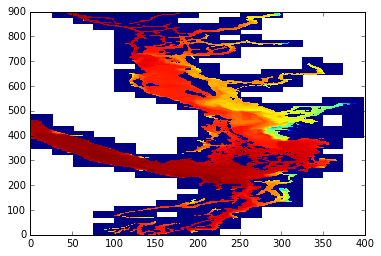

In [7]:
tester = nc.Dataset('/data/sallen/results/MEOPAR/test_this_bathy/part1_07mar17/SalishSea_1h_20170307_20170405_grid_T_20170307-20170307.nc')
pretty_sal = tester.variables['vosaline'][0, 0]
plt.pcolormesh(pretty_sal)
tester.close()

In [8]:
nc.num2date(ferry.variables['s.time'][135000], ferry.variables['s.time'].units)

datetime.datetime(2012, 5, 10, 0, 0)

In [9]:
with nc_tools.scDataset(threemonthsbase) as f:
    threemonthsbase_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsbase_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesbase = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [10]:
with nc_tools.scDataset(threemonthv1803) as f:
    threemonthv1803_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthv1803_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timev1803 = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


31.8029


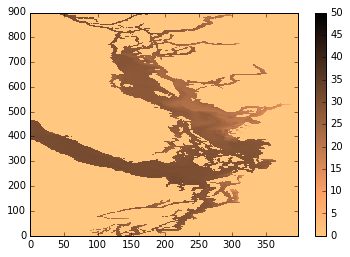

In [44]:
imin, imax = 0, 898
jmin, jmax = 0, 398
plt.pcolormesh(threemonthv1803_sal[0]*tmaskv18[0, 1], cmap='copper_r', vmax=50)
plt.colorbar()
plt.xlim((jmin, jmax))
plt.ylim((imin, imax))
print(np.max(threemonthv1803_sal[0, imin:imax, jmin:jmax]*tmaskv18[0,1, imin:imax, jmin:jmax]))

In [11]:
h = nc.Dataset('/data/vdo/MEOPAR/completed-runs/threemonthbase/testA/SalishSea_1h_20170307_20170316_grid_U_20170313-20170313.nc')

In [12]:
converted_timesbase = nc.num2date(timesbase, h.variables['time_counter'].units)
converted_timev1803 = nc.num2date(timev1803, h.variables['time_counter'].units)

In [151]:
list_of_modelbase_sals = np.array([])
list_of_modelbase_temps = np.array([])
list_of_modelv18_sals = np.array([])
list_of_modelv18_temps = np.array([])
list_of_ferrybase_sals = np.array([])
list_of_ferrybase_temps = np.array([])
unit = ferry.variables['s.time'].units
# for n in range(14500,135000):

In [135]:
ferry_times = nc.num2date(ferry.variables['s.time'][:], unit)

In [136]:
print (ferry_times)

[datetime.datetime(2012, 5, 10, 0, 0) datetime.datetime(2012, 5, 10, 0, 1)
 datetime.datetime(2012, 5, 10, 0, 2) ...,
 datetime.datetime(2018, 3, 22, 23, 57)
 datetime.datetime(2018, 3, 22, 23, 58)
 datetime.datetime(2018, 3, 22, 23, 59)]


In [137]:
istart, iend = 2179329, 2308867

In [182]:
istart = iend
iend = 2308867
print (istart, iend)

2179609 2308867


In [181]:
np.savetxt('base', list_of_modelbase_sals)
np.savetxt('v18', list_of_modelv18_sals)
np.savetxt('ferry', list_of_ferrybase_sals)

In [ ]:
for n in range(istart, iend):
    print (n)
    date = ferry_times[n]
    print (n, date, date.minute)
    print (ferry.variables['s.longitude'][n], ferry.variables['s.latitude'][n], ferry.variables['s.salinity'][n])
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        Yv18i, Xv18i = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        Xv18, Yv18, land_mask = bathyv18.mask) 
        print (Yind, Xind, Yv18i, Xv18i)
        if date.minute <= 30:
            print (n, 'before')
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            index = np.argmin(np.abs(converted_timesbase - date))
            print (index, 'base')
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index, Yind, Xind]))
            
            index = np.argmin(np.abs(converted_timev1803 - date))
            print (index, 'v18', threemonthv1803_sal[index, Yv18i, Xv18i])
            delta = (date - before).seconds / 3600
            s_val_v18 = ((delta * (threemonthv1803_sal[index-1, Yv18i, Xv18i])) + 
                   (1- delta)*(threemonthv1803_sal[index, Yv18i, Xv18i]))
            t_val_v18 = ((delta * (threemonthv1803_temp[index-1, Yv18i, Xv18i])) + 
                   (1- delta)*(threemonthv1803_temp[index, Yv18i, Xv18i]))
            
            
        elif date.minute > 30:
            print (n, 'after')
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            index = np.argmin(np.abs(converted_timesbase - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index+1, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index+1, Yind, Xind]))
        
            index = np.argmin(np.abs(converted_timev1803 - date))
            delta = (date - before).seconds / 3600
            s_val_v18 = ((delta * (threemonthv1803_sal[index, Yv18i, Xv18i])) + 
                   (1- delta)*(threemonthv1803_sal[index+1, Yv18i, Xv18i]))
            t_val_v18 = ((delta * (threemonthv1803_temp[index, Yv18i, Xv18i])) + 
                   (1- delta)*(threemonthv1803_temp[index+1, Yv18i, Xv18i]))
        else:
            print ('bad minute')
        print(s_val, s_val_v18)    
        print(n, ferry.variables['s.salinity'][n])
        list_of_ferrybase_sals = np.append(list_of_ferrybase_sals, 
                                           ferry.variables['s.salinity'][n])
        list_of_ferrybase_temps = np.append(list_of_ferrybase_temps, 
                                            ferry.variables['s.temperature'][n])
        list_of_modelbase_sals = np.append(list_of_modelbase_sals, s_val)
        list_of_modelbase_temps = np.append(list_of_modelbase_temps, t_val)
        
        list_of_modelv18_sals = np.append(list_of_modelv18_sals, s_val_v18)
        list_of_modelv18_temps = np.append(list_of_modelv18_temps, t_val_v18)
    else:
        print ('bad point')
    print (n, date, date.minute, 'end of loop')
    if n % 1000 == 0:
        np.savetxt('base', list_of_modelbase_sals)
        np.savetxt('v18', list_of_modelv18_sals)
        np.savetxt('ferry', list_of_ferrybase_sals)

2179609
2179609 2017-03-07 05:11:00 11
-123.1328 49.0062 --
446 266 446 266
2179609 before
5 base
5 v18 26.2209
27.0491141955 26.260449028
2179609 17.890555703245706
2179609 2017-03-07 05:11:00 11 end of loop
2179610
2179610 2017-03-07 05:12:00 12
-123.1328 49.0062 --
447 266 447 266
2179610 before
5 base
5 v18 25.9886
26.7948606491 26.0708324432
2179610 18.49577618310857
2179610 2017-03-07 05:12:00 12 end of loop
2179611
2179611 2017-03-07 05:13:00 13
-123.1328 49.0062 --
448 265 448 265
2179611 before
5 base
5 v18 25.5409
26.3348136584 25.5398716291
2179611 18.29840486074286
2179611 2017-03-07 05:13:00 13 end of loop
2179612
2179612 2017-03-07 05:14:00 14
-123.1328 49.0062 --
449 264 449 264
2179612 before
5 base
5 v18 25.3945
25.7849819183 25.4312610626
2179612 18.417761704605713
2179612 2017-03-07 05:14:00 14 end of loop
2179613
2179613 2017-03-07 05:15:00 15
-123.1328 49.0062 --
450 264 450 264
2179613 before
5 base
5 v18 25.2363
25.7308473587 25.2711453438
2179613 23.470214368879

2179650 2017-03-07 05:52:00 52 end of loop
2179651
2179651 2017-03-07 05:53:00 53
-123.1328 49.0062 --
484 235 484 235
2179651 after
25.6889037768 26.9064015071
2179651 28.579018172491434
2179651 2017-03-07 05:53:00 53 end of loop
2179652
2179652 2017-03-07 05:54:00 54
-123.1328 49.0062 --
485 234 485 234
2179652 after
25.8711338043 26.9833503723
2179652 28.47595446382858
2179652 2017-03-07 05:54:00 54 end of loop
2179653
2179653 2017-03-07 05:55:00 55
-123.1328 49.0062 --
485 233 485 233
2179653 after
25.8759012222 26.9978734652
2179653 28.575317470662856
2179653 2017-03-07 05:55:00 55 end of loop
2179654
2179654 2017-03-07 05:56:00 56
-123.1328 49.0062 --
486 231 486 231
2179654 after
26.0308848063 26.8081478755
2179654 28.7509953124
2179654 2017-03-07 05:56:00 56 end of loop
2179655
2179655 2017-03-07 05:57:00 57
-123.1328 49.0062 --
486 230 486 230
2179655 after
25.810302639 26.7516710281
2179655 28.777432724377142
2179655 2017-03-07 05:57:00 57 end of loop
2179656
2179656 2017-03-

-123.1328 49.0062 --
481 214 481 214
2179703 after
23.5230436325 26.2448396683
2179703 28.829488705257138
2179703 2017-03-07 06:45:00 45 end of loop
2179704
2179704 2017-03-07 06:46:00 46
-123.1328 49.0062 --
482 214 482 214
2179704 after
23.9472848256 26.6985954285
2179704 28.955049666891412
2179704 2017-03-07 06:46:00 46 end of loop
2179705
2179705 2017-03-07 06:47:00 47
-123.1328 49.0062 --
482 215 482 215
2179705 after
23.7039393425 26.5448258082
2179705 28.743250630971424
2179705 2017-03-07 06:47:00 47 end of loop
2179706
2179706 2017-03-07 06:48:00 48
-123.1328 49.0062 --
483 216 483 216
2179706 after
24.6152124405 26.4225875854
2179706 27.899627925165706
2179706 2017-03-07 06:48:00 48 end of loop
2179707
2179707 2017-03-07 06:49:00 49
-123.1328 49.0062 --
484 217 484 217
2179707 after
24.6932898204 26.2444911639
2179707 27.25224958592
2179707 2017-03-07 06:49:00 49 end of loop
2179708
2179708 2017-03-07 06:50:00 50
-123.1328 49.0062 --
485 218 485 218
2179708 after
25.6710910797

-123.1328 49.0062 --
461 252 461 252
2179744 before
7 base
7 v18 25.3661
24.8123592377 24.9813911438
2179744 28.36112051392
2179744 2017-03-07 07:26:00 26 end of loop
2179745
2179745 2017-03-07 07:27:00 27
-123.1328 49.0062 --
460 252 460 252
2179745 before
7 base
7 v18 25.3553
25.0466994286 25.1046561241
2179745 28.46716655288001
2179745 2017-03-07 07:27:00 27 end of loop
2179746
2179746 2017-03-07 07:28:00 28
-123.1328 49.0062 --
459 253 459 253
2179746 before
7 base
7 v18 25.0479
25.07985967 25.0318578084
2179746 28.495365565908575
2179746 2017-03-07 07:28:00 28 end of loop
2179747
2179747 2017-03-07 07:29:00 29
-123.1328 49.0062 --
458 253 458 253
2179747 before
7 base
7 v18 25.0613
25.0602309227 24.9644391696
2179747 28.44748752668572
2179747 2017-03-07 07:29:00 29 end of loop
2179748
2179748 2017-03-07 07:30:00 30
-123.1328 49.0062 --
457 254 457 254
2179748 before
7 base
7 v18 25.0803
24.9167900085 24.9596862793
2179748 28.395645885097135
2179748 2017-03-07 07:30:00 30 end of lo

2179786 2017-03-07 08:08:00 8 end of loop
2179787
2179787 2017-03-07 08:09:00 9
-123.1328 49.0062 --
415 278 415 278
2179787 before
8 base
8 v18 26.4659
27.7454483986 26.2771022797
2179787 27.571112772434297
2179787 2017-03-07 08:09:00 9 end of loop
2179788
2179788 2017-03-07 08:10:00 10
-123.1328 49.0062 --
414 278 414 278
2179788 before
8 base
8 v18 26.5903
27.7620283763 26.4531116486
2179788 27.613555301188573
2179788 2017-03-07 08:10:00 10 end of loop
2179789
2179789 2017-03-07 08:11:00 11
-123.1328 49.0062 --
413 279 413 279
2179789 before
8 base
8 v18 25.9733
27.7052512487 25.9450263341
2179789 27.65757020958857
2179789 2017-03-07 08:11:00 11 end of loop
2179790
2179790 2017-03-07 08:12:00 12
-123.1328 49.0062 --
412 279 412 279
2179790 before
8 base
8 v18 26.218
27.6052202225 26.1928730011
2179790 27.726726447062852
2179790 2017-03-07 08:12:00 12 end of loop
2179791
2179791 2017-03-07 08:13:00 13
-123.1328 49.0062 --
411 280 411 280
2179791 before
8 base
8 v18 26.0421
27.5337722

-123.13201665999999 49.00566666999999 --
bad point
2179861 2017-03-07 09:23:00 23 end of loop
2179862
2179862 2017-03-07 09:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2179862 2017-03-07 09:24:00 24 end of loop
2179863
2179863 2017-03-07 09:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2179863 2017-03-07 09:25:00 25 end of loop
2179864
2179864 2017-03-07 09:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2179864 2017-03-07 09:26:00 26 end of loop
2179865
2179865 2017-03-07 09:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2179865 2017-03-07 09:27:00 27 end of loop
2179866
2179866 2017-03-07 09:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2179866 2017-03-07 09:28:00 28 end of loop
2179867
2179867 2017-03-07 09:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2179867 2017-03-07 09:29:00 29 end of loop
2179868
2179868 2017-03-07 09:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2179868 2017-03-07

-123.13201665999999 49.00566666999999 --
bad point
2179956 2017-03-07 10:58:00 58 end of loop
2179957
2179957 2017-03-07 10:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2179957 2017-03-07 10:59:00 59 end of loop
2179958
2179958 2017-03-07 11:00:00 0
-123.13201665999999 49.00566666999999 --
bad point
2179958 2017-03-07 11:00:00 0 end of loop
2179959
2179959 2017-03-07 11:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2179959 2017-03-07 11:01:00 1 end of loop
2179960
2179960 2017-03-07 11:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2179960 2017-03-07 11:02:00 2 end of loop
2179961
2179961 2017-03-07 11:03:00 3
-123.13201665999999 49.00566666999999 --
bad point
2179961 2017-03-07 11:03:00 3 end of loop
2179962
2179962 2017-03-07 11:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2179962 2017-03-07 11:04:00 4 end of loop
2179963
2179963 2017-03-07 11:05:00 5
-123.13204443833332 49.00566666999999 --
bad point
2179963 2017-03-07 11:05:00 5

2180047 2017-03-07 12:29:00 29 end of loop
2180048
2180048 2017-03-07 12:30:00 30
-123.13207221666666 49.00566666999999 --
bad point
2180048 2017-03-07 12:30:00 30 end of loop
2180049
2180049 2017-03-07 12:31:00 31
-123.13218332999999 49.00566666999999 --
bad point
2180049 2017-03-07 12:31:00 31 end of loop
2180050
2180050 2017-03-07 12:32:00 32
-123.13218332999999 49.00566666999999 --
bad point
2180050 2017-03-07 12:32:00 32 end of loop
2180051
2180051 2017-03-07 12:33:00 33
-123.13218332999999 49.00566666999999 --
bad point
2180051 2017-03-07 12:33:00 33 end of loop
2180052
2180052 2017-03-07 12:34:00 34
-123.13204443833332 49.00566666999999 --
bad point
2180052 2017-03-07 12:34:00 34 end of loop
2180053
2180053 2017-03-07 12:35:00 35
-123.13201665999999 49.00566666999999 --
bad point
2180053 2017-03-07 12:35:00 35 end of loop
2180054
2180054 2017-03-07 12:36:00 36
-123.13201665999999 49.00566666999999 --
bad point
2180054 2017-03-07 12:36:00 36 end of loop
2180055
2180055 2017-03-07

2180102 2017-03-07 13:24:00 24 end of loop
2180103
2180103 2017-03-07 13:25:00 25
-123.1328 49.0062 --
403 295 403 295
2180103 before
13 base
13 v18 25.0686
28.4911330541 25.0323057175
2180103 27.552830300685724
2180103 2017-03-07 13:25:00 25 end of loop
2180104
2180104 2017-03-07 13:26:00 26
-123.1328 49.0062 --
403 294 403 294
2180104 before
13 base
13 v18 25.9652
28.5195992788 25.8676241557
2180104 27.64772064933714
2180104 2017-03-07 13:26:00 26 end of loop
2180105
2180105 2017-03-07 13:27:00 27
-123.1328 49.0062 --
404 293 404 293
2180105 before
13 base
13 v18 26.6942
28.8026141167 26.5890374184
2180105 27.7451947911657
2180105 2017-03-07 13:27:00 27 end of loop
2180106
2180106 2017-03-07 13:28:00 28
-123.1328 49.0062 --
405 292 405 292
2180106 before
13 base
13 v18 26.7939
28.3446590424 26.7588427226
2180106 27.91988801178285
2180106 2017-03-07 13:28:00 28 end of loop
2180107
2180107 2017-03-07 13:29:00 29
-123.1328 49.0062 --
406 291 406 291
2180107 before
13 base
13 v18 27.1587

-123.1328 49.0062 --
443 269 443 269
2180145 before
14 base
14 v18 27.4628
27.8261354129 27.435684967
2180145 27.048315797279997
2180145 2017-03-07 14:07:00 7 end of loop
2180146
2180146 2017-03-07 14:08:00 8
-123.1328 49.0062 --
444 268 444 268
2180146 before
14 base
14 v18 27.3924
27.0700874964 27.3691265106
2180146 27.38431942900571
2180146 2017-03-07 14:08:00 8 end of loop
2180147
2180147 2017-03-07 14:09:00 9
-123.1328 49.0062 --
445 267 445 267
2180147 before
14 base
14 v18 27.1956
26.3625463486 27.2040088654
2180147 27.53373568396571
2180147 2017-03-07 14:09:00 9 end of loop
2180148
2180148 2017-03-07 14:10:00 10
-123.1328 49.0062 --
446 266 446 266
2180148 before
14 base
14 v18 27.0237
25.9376296997 27.0722344716
2180148 27.871601388285725
2180148 2017-03-07 14:10:00 10 end of loop
2180149
2180149 2017-03-07 14:11:00 11
-123.1328 49.0062 --
447 266 447 266
2180149 before
14 base
14 v18 26.7488
25.7202493985 26.806726106
2180149 27.89839882329143
2180149 2017-03-07 14:11:00 11 e

-123.1328 49.0062 --
481 238 481 238
2180186 after
25.4532304764 27.1846628189
2180186 28.890744530411435
2180186 2017-03-07 14:48:00 48 end of loop
2180187
2180187 2017-03-07 14:49:00 49
-123.1328 49.0062 --
482 237 482 237
2180187 after
25.2066456477 27.1451348305
2180187 28.926904238685708
2180187 2017-03-07 14:49:00 49 end of loop
2180188
2180188 2017-03-07 14:50:00 50
-123.1328 49.0062 --
482 236 482 236
2180188 after
25.0240154266 27.1362743378
2180188 28.949434982171436
2180188 2017-03-07 14:50:00 50 end of loop
2180189
2180189 2017-03-07 14:51:00 51
-123.1328 49.0062 --
483 236 483 236
2180189 after
24.856854248 27.1303887367
2180189 28.85663779066284
2180189 2017-03-07 14:51:00 51 end of loop
2180190
2180190 2017-03-07 14:52:00 52
-123.1328 49.0062 --
484 235 484 235
2180190 after
24.7176311493 26.9567016602
2180190 28.79970391637715
2180190 2017-03-07 14:52:00 52 end of loop
2180191
2180191 2017-03-07 14:53:00 53
-123.1328 49.0062 --
485 234 485 234
2180191 after
24.627629947

2180241 2017-03-07 15:43:00 43 end of loop
2180242
2180242 2017-03-07 15:44:00 44
-123.1328 49.0062 --
481 214 481 214
2180242 after
25.5530859629 26.8925238291
2180242 29.062214289028574
2180242 2017-03-07 15:44:00 44 end of loop
2180243
2180243 2017-03-07 15:45:00 45
-123.1328 49.0062 --
481 214 481 214
2180243 after
25.5627813339 26.8887071609
2180243 29.102841631908557
2180243 2017-03-07 15:45:00 45 end of loop
2180244
2180244 2017-03-07 15:46:00 46
-123.1328 49.0062 --
482 215 482 215
2180244 after
25.344138972 26.5547089895
2180244 28.930161191200003
2180244 2017-03-07 15:46:00 46 end of loop
2180245
2180245 2017-03-07 15:47:00 47
-123.1328 49.0062 --
483 215 483 215
2180245 after
25.19888738 26.634551843
2180245 28.455364495645714
2180245 2017-03-07 15:47:00 47 end of loop
2180246
2180246 2017-03-07 15:48:00 48
-123.1328 49.0062 --
484 216 484 216
2180246 after
25.3945720673 26.404312706
2180246 28.018490783942863
2180246 2017-03-07 15:48:00 48 end of loop
2180247
2180247 2017-0

2180282 2017-03-07 16:24:00 24 end of loop
2180283
2180283 2017-03-07 16:25:00 25
-123.1328 49.0062 --
465 249 465 249
2180283 before
16 base
16 v18 27.0176
26.0358026822 26.989871343
2180283 28.44161831405714
2180283 2017-03-07 16:25:00 25 end of loop
2180284
2180284 2017-03-07 16:26:00 26
-123.1328 49.0062 --
464 250 464 250
2180284 before
16 base
16 v18 27.0124
26.5310113271 26.948206838
2180284 28.274154020948576
2180284 2017-03-07 16:26:00 26 end of loop
2180285
2180285 2017-03-07 16:27:00 27
-123.1328 49.0062 --
463 251 463 251
2180285 before
16 base
16 v18 27.15
26.6558117867 27.0813519478
2180285 28.219968043359994
2180285 2017-03-07 16:27:00 27 end of loop
2180286
2180286 2017-03-07 16:28:00 28
-123.1328 49.0062 --
462 251 462 251
2180286 before
16 base
16 v18 27.2132
26.8044328054 27.2081202825
2180286 28.39207579627428
2180286 2017-03-07 16:28:00 28 end of loop
2180287
2180287 2017-03-07 16:29:00 29
-123.1328 49.0062 --
461 252 461 252
2180287 before
16 base
16 v18 27.2827
2

-123.1328 49.0062 --
423 273 423 273
2180325 before
17 base
17 v18 27.4258
26.1821657499 27.2759269079
2180325 28.05140693590857
2180325 2017-03-07 17:07:00 7 end of loop
2180326
2180326 2017-03-07 17:08:00 8
-123.1328 49.0062 --
422 273 422 273
2180326 before
17 base
17 v18 27.5091
25.9824766795 27.3285252253
2180326 27.90188351130286
2180326 2017-03-07 17:08:00 8 end of loop
2180327
2180327 2017-03-07 17:09:00 9
-123.1328 49.0062 --
421 273 421 273
2180327 before
17 base
17 v18 27.5856
26.1167943954 27.3948265076
2180327 27.83639783419428
2180327 2017-03-07 17:09:00 9 end of loop
2180328
2180328 2017-03-07 17:10:00 10
-123.1328 49.0062 --
420 274 420 274
2180328 before
17 base
17 v18 27.5083
26.2478167216 27.3617839813
2180328 27.738985649817156
2180328 2017-03-07 17:10:00 10 end of loop
2180329
2180329 2017-03-07 17:11:00 11
-123.1328 49.0062 --
419 275 419 275
2180329 before
17 base
17 v18 27.2961
26.2561646144 27.1848777771
2180329 27.700168469234278
2180329 2017-03-07 17:11:00 11

-123.1328 49.0062 --
bad point
2180366 2017-03-07 17:48:00 48 end of loop
2180367
2180367 2017-03-07 17:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2180367 2017-03-07 17:49:00 49 end of loop
2180368
2180368 2017-03-07 17:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2180368 2017-03-07 17:50:00 50 end of loop
2180369
2180369 2017-03-07 17:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2180369 2017-03-07 17:51:00 51 end of loop
2180370
2180370 2017-03-07 17:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2180370 2017-03-07 17:52:00 52 end of loop
2180371
2180371 2017-03-07 17:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2180371 2017-03-07 17:53:00 53 end of loop
2180372
2180372 2017-03-07 17:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2180372 2017-03-07 17:54:00 54 end of loop
2180373
2180373 2017-03-07 17:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2180373 2017-03-07 17:55:00 55 end of 

2180416 2017-03-07 18:38:00 38 end of loop
2180417
2180417 2017-03-07 18:39:00 39
-123.1328 49.0062 --
412 286 412 286
2180417 after
28.8146121025 27.6210824013
2180417 28.364292065622855
2180417 2017-03-07 18:39:00 39 end of loop
2180418
2180418 2017-03-07 18:40:00 40
-123.1328 49.0062 --
413 285 413 285
2180418 after
28.6831432978 27.6949208577
2180418 28.357515260057134
2180418 2017-03-07 18:40:00 40 end of loop
2180419
2180419 2017-03-07 18:41:00 41
-123.1328 49.0062 --
414 284 414 284
2180419 after
28.5503152529 27.6856886546
2180419 28.440300462320007
2180419 2017-03-07 18:41:00 41 end of loop
2180420
2180420 2017-03-07 18:42:00 42
-123.1328 49.0062 --
415 283 415 283
2180420 after
28.3525367737 27.6425689697
2180420 28.52345573476571
2180420 2017-03-07 18:42:00 42 end of loop
2180421
2180421 2017-03-07 18:43:00 43
-123.1328 49.0062 --
416 283 416 283
2180421 after
28.3358462334 27.5761995633
2180421 28.570930213291426
2180421 2017-03-07 18:43:00 43 end of loop
2180422
2180422 20

-123.1328 49.0062 --
453 262 453 262
2180458 before
19 base
19 v18 27.3876
26.5391998291 27.2503395081
2180458 28.562448740548575
2180458 2017-03-07 19:20:00 20 end of loop
2180459
2180459 2017-03-07 19:21:00 21
-123.1328 49.0062 --
454 261 454 261
2180459 before
19 base
19 v18 27.1937
26.610468483 27.0730628014
2180459 28.68984833141715
2180459 2017-03-07 19:21:00 21 end of loop
2180460
2180460 2017-03-07 19:22:00 22
-123.1328 49.0062 --
455 260 455 260
2180460 before
19 base
19 v18 27.1817
26.7467849731 27.0722120921
2180460 28.768664907737143
2180460 2017-03-07 19:22:00 22 end of loop
2180461
2180461 2017-03-07 19:23:00 23
-123.1328 49.0062 --
456 259 456 259
2180461 before
19 base
19 v18 27.2424
26.878644975 27.1251015027
2180461 28.85232588694857
2180461 2017-03-07 19:23:00 23 end of loop
2180462
2180462 2017-03-07 19:24:00 24
-123.1328 49.0062 --
457 259 457 259
2180462 before
19 base
19 v18 27.2468
26.966884613 27.132365036
2180462 28.99476774230857
2180462 2017-03-07 19:24:00 2

2180500 2017-03-07 20:02:00 2 end of loop
2180501
2180501 2017-03-07 20:03:00 3
-123.1328 49.0062 --
487 223 487 223
2180501 before
20 base
20 v18 26.2382
26.5534600258 26.204682827
2180501 28.77743774795429
2180501 2017-03-07 20:03:00 3 end of loop
2180502
2180502 2017-03-07 20:04:00 4
-123.1328 49.0062 --
487 221 487 221
2180502 before
20 base
20 v18 26.4389
26.5802756627 26.2838088353
2180502 28.55994532460572
2180502 2017-03-07 20:04:00 4 end of loop
2180503
2180503 2017-03-07 20:05:00 5
-123.1328 49.0062 --
487 220 487 220
2180503 before
20 base
20 v18 26.6422
26.6572004954 26.4708275795
2180503 28.652040889840006
2180503 2017-03-07 20:05:00 5 end of loop
2180504
2180504 2017-03-07 20:06:00 6
-123.1328 49.0062 --
486 219 486 219
2180504 before
20 base
20 v18 26.7804
26.8496089935 26.6878292084
2180504 28.70944028227427
2180504 2017-03-07 20:06:00 6 end of loop
2180505
2180505 2017-03-07 20:07:00 7
-123.1328 49.0062 --
485 218 485 218
2180505 before
20 base
20 v18 26.9725
27.066839

2180553 2017-03-07 20:55:00 55 end of loop
2180554
2180554 2017-03-07 20:56:00 56
-123.1328 49.0062 --
487 224 487 224
2180554 after
26.6245558421 26.3406422933
2180554 28.261891469142864
2180554 2017-03-07 20:56:00 56 end of loop
2180555
2180555 2017-03-07 20:57:00 57
-123.1328 49.0062 --
487 225 487 225
2180555 after
26.3531624794 26.3964598656
2180555 28.10214339052572
2180555 2017-03-07 20:57:00 57 end of loop
2180556
2180556 2017-03-07 20:58:00 58
-123.1328 49.0062 --
486 226 486 226
2180556 after
25.9313985189 26.7600042979
2180556 27.963591458399996
2180556 2017-03-07 20:58:00 58 end of loop
2180557
2180557 2017-03-07 20:59:00 59
-123.1328 49.0062 --
486 227 486 227
2180557 after
26.036420091 26.9011125247
2180557 28.230656540994296
2180557 2017-03-07 20:59:00 59 end of loop
2180558
2180558 2017-03-07 21:00:00 0
-123.1328 49.0062 --
486 229 486 229
2180558 before
20 base
20 v18 26.9057
25.7077150345 26.810749054
2180558 28.229564750228572
2180558 2017-03-07 21:00:00 0 end of loo

2180593 2017-03-07 21:35:00 35 end of loop
2180594
2180594 2017-03-07 21:36:00 36
-123.1328 49.0062 --
454 256 454 256
2180594 after
27.7927021027 27.7943891525
2180594 28.306303240137137
2180594 2017-03-07 21:36:00 36 end of loop
2180595
2180595 2017-03-07 21:37:00 37
-123.1328 49.0062 --
452 257 452 257
2180595 after
27.405746301 27.800917085
2180595 28.228312204994282
2180595 2017-03-07 21:37:00 37 end of loop
2180596
2180596 2017-03-07 21:38:00 38
-123.1328 49.0062 --
451 258 451 258
2180596 after
27.2737032572 27.8799214681
2180596 28.403110920731436
2180596 2017-03-07 21:38:00 38 end of loop
2180597
2180597 2017-03-07 21:39:00 39
-123.1328 49.0062 --
450 258 450 258
2180597 after
27.4105900764 27.9118582726
2180597 28.166490390148574
2180597 2017-03-07 21:39:00 39 end of loop
2180598
2180598 2017-03-07 21:40:00 40
-123.1328 49.0062 --
449 259 449 259
2180598 after
27.4280246099 27.9065291087
2180598 27.916076791257144
2180598 2017-03-07 21:40:00 40 end of loop
2180599
2180599 201

2180635 2017-03-07 22:17:00 17 end of loop
2180636
2180636 2017-03-07 22:18:00 18
-123.1328 49.0062 --
410 281 410 281
2180636 before
22 base
22 v18 27.9265
27.4489398956 27.8782592773
2180636 27.934531739154288
2180636 2017-03-07 22:18:00 18 end of loop
2180637
2180637 2017-03-07 22:19:00 19
-123.1328 49.0062 --
409 281 409 281
2180637 before
22 base
22 v18 27.9331
27.5024119377 27.8880616506
2180637 27.968407394354294
2180637 2017-03-07 22:19:00 19 end of loop
2180638
2180638 2017-03-07 22:20:00 20
-123.1328 49.0062 --
408 282 408 282
2180638 before
22 base
22 v18 27.9123
27.6170438131 27.9227679571
2180638 27.78471192349714
2180638 2017-03-07 22:20:00 20 end of loop
2180639
2180639 2017-03-07 22:21:00 21
-123.1328 49.0062 --
408 283 408 283
2180639 before
22 base
22 v18 27.908
27.679850769 27.9306450844
2180639 27.661282633097137
2180639 2017-03-07 22:21:00 21 end of loop
2180640
2180640 2017-03-07 22:22:00 22
-123.1328 49.0062 --
407 284 407 284
2180640 before
22 base
22 v18 27.935

2180696 2017-03-07 23:18:00 18 end of loop
2180697
2180697 2017-03-07 23:19:00 19
-123.1328 49.0062 --
396 305 396 305
2180697 before
23 base
23 v18 25.5416
28.9711947759 25.7666318576
2180697 28.274892486788577
2180697 2017-03-07 23:19:00 19 end of loop
2180698
2180698 2017-03-07 23:20:00 20
-123.1328 49.0062 --
396 304 396 304
2180698 before
23 base
23 v18 26.0649
29.0132630666 26.8535795212
2180698 28.191974996994283
2180698 2017-03-07 23:20:00 20 end of loop
2180699
2180699 2017-03-07 23:21:00 21
-123.1328 49.0062 --
396 303 396 303
2180699 before
23 base
23 v18 26.4366
28.9943380356 27.0646465302
2180699 27.654398657885704
2180699 2017-03-07 23:21:00 21 end of loop
2180700
2180700 2017-03-07 23:22:00 22
-123.1328 49.0062 --
396 302 396 302
2180700 before
23 base
23 v18 26.8068
29.0458535512 27.2454184214
2180700 27.941345384285714
2180700 2017-03-07 23:22:00 22 end of loop
2180701
2180701 2017-03-07 23:23:00 23
-123.1328 49.0062 --
397 301 397 301
2180701 before
23 base
23 v18 26.

-123.1328 49.0062 --
434 274 434 274
2180739 before
24 base
24 v18 28.1007
28.107696406 28.0074290911
2180739 26.74523166657142
2180739 2017-03-08 00:01:00 1 end of loop
2180740
2180740 2017-03-08 00:02:00 2
-123.1328 49.0062 --
435 274 435 274
2180740 before
24 base
24 v18 28.1564
28.219234848 28.0499617259
2180740 26.181232986217147
2180740 2017-03-08 00:02:00 2 end of loop
2180741
2180741 2017-03-08 00:03:00 3
-123.1328 49.0062 --
436 273 436 273
2180741 before
24 base
24 v18 28.2693
28.2879745483 28.1915772438
2180741 25.907516687485717
2180741 2017-03-08 00:03:00 3 end of loop
2180742
2180742 2017-03-08 00:04:00 4
-123.1328 49.0062 --
437 272 437 272
2180742 before
24 base
24 v18 28.3114
28.2987979253 28.2906003316
2180742 26.078299890559997
2180742 2017-03-08 00:04:00 4 end of loop
2180743
2180743 2017-03-08 00:05:00 5
-123.1328 49.0062 --
438 271 438 271
2180743 before
24 base
24 v18 28.3084
28.3487079938 28.332098643
2180743 26.37434598969143
2180743 2017-03-08 00:05:00 5 end o

2180779 2017-03-08 00:41:00 41 end of loop
2180780
2180780 2017-03-08 00:42:00 42
-123.1328 49.0062 --
474 242 474 242
2180780 after
27.6957481384 28.1944248199
2180780 29.475231032879996
2180780 2017-03-08 00:42:00 42 end of loop
2180781
2180781 2017-03-08 00:43:00 43
-123.1328 49.0062 --
475 241 475 241
2180781 after
27.7342342377 28.2074060758
2180781 29.45004784066286
2180781 2017-03-08 00:43:00 43 end of loop
2180782
2180782 2017-03-08 00:44:00 44
-123.1328 49.0062 --
476 240 476 240
2180782 after
27.6891379038 28.2575285594
2180782 29.460428225565717
2180782 2017-03-08 00:44:00 44 end of loop
2180783
2180783 2017-03-08 00:45:00 45
-123.1328 49.0062 --
477 239 477 239
2180783 after
27.7185544968 28.2898755074
2180783 29.45239887476572
2180783 2017-03-08 00:45:00 45 end of loop
2180784
2180784 2017-03-08 00:46:00 46
-123.1328 49.0062 --
478 239 478 239
2180784 after
27.6789034526 28.2254751841
2180784 29.418414375394278
2180784 2017-03-08 00:46:00 46 end of loop
2180785
2180785 201

2180842 2017-03-08 01:44:00 44 end of loop
2180843
2180843 2017-03-08 01:45:00 45
-123.1328 49.0062 --
481 214 481 214
2180843 after
24.6313481331 28.2090449333
2180843 29.27085516945143
2180843 2017-03-08 01:45:00 45 end of loop
2180844
2180844 2017-03-08 01:46:00 46
-123.1328 49.0062 --
482 215 482 215
2180844 after
25.2152036031 27.9267771403
2180844 28.822745390205714
2180844 2017-03-08 01:46:00 46 end of loop
2180845
2180845 2017-03-08 01:47:00 47
-123.1328 49.0062 --
482 215 482 215
2180845 after
25.226088206 27.9284859022
2180845 28.346580607142858
2180845 2017-03-08 01:47:00 47 end of loop
2180846
2180846 2017-03-08 01:48:00 48
-123.1328 49.0062 --
483 216 483 216
2180846 after
26.4053220749 27.6700603485
2180846 26.597675809679988
2180846 2017-03-08 01:48:00 48 end of loop
2180847
2180847 2017-03-08 01:49:00 49
-123.1328 49.0062 --
484 217 484 217
2180847 after
27.0006432533 27.8352970123
2180847 26.025289430022863
2180847 2017-03-08 01:49:00 49 end of loop
2180848
2180848 201

2180883 2017-03-08 02:25:00 25 end of loop
2180884
2180884 2017-03-08 02:26:00 26
-123.1328 49.0062 --
463 251 463 251
2180884 before
26 base
26 v18 28.0397
28.1958602905 27.8255271912
2180884 28.902739158102868
2180884 2017-03-08 02:26:00 26 end of loop
2180885
2180885 2017-03-08 02:27:00 27
-123.1328 49.0062 --
462 251 462 251
2180885 before
26 base
26 v18 28.2591
28.1875347137 28.0086367607
2180885 28.85207805714287
2180885 2017-03-08 02:27:00 27 end of loop
2180886
2180886 2017-03-08 02:28:00 28
-123.1328 49.0062 --
461 252 461 252
2180886 before
26 base
26 v18 28.4109
27.8963161469 28.2328430812
2180886 28.67933565898286
2180886 2017-03-08 02:28:00 28 end of loop
2180887
2180887 2017-03-08 02:29:00 29
-123.1328 49.0062 --
460 253 460 253
2180887 before
26 base
26 v18 28.3294
27.8510919253 28.1742300987
2180887 28.63004097100573
2180887 2017-03-08 02:29:00 29 end of loop
2180888
2180888 2017-03-08 02:30:00 30
-123.1328 49.0062 --
459 253 459 253
2180888 before
26 base
26 v18 28.397

-123.1328 49.0062 --
420 275 420 275
2180926 before
27 base
27 v18 27.7889
27.4089307149 27.9499949773
2180926 28.33503977592001
2180926 2017-03-08 03:08:00 8 end of loop
2180927
2180927 2017-03-08 03:09:00 9
-123.1328 49.0062 --
419 276 419 276
2180927 before
27 base
27 v18 27.7646
27.2838246346 27.8907196999
2180927 28.34486924186286
2180927 2017-03-08 03:09:00 9 end of loop
2180928
2180928 2017-03-08 03:10:00 10
-123.1328 49.0062 --
418 276 418 276
2180928 before
27 base
27 v18 27.8329
27.2253672282 27.9385884603
2180928 28.38606592348572
2180928 2017-03-08 03:10:00 10 end of loop
2180929
2180929 2017-03-08 03:11:00 11
-123.1328 49.0062 --
417 277 417 277
2180929 before
27 base
27 v18 27.7787
27.1666262627 27.8852981567
2180929 28.374660728845715
2180929 2017-03-08 03:11:00 11 end of loop
2180930
2180930 2017-03-08 03:12:00 12
-123.1328 49.0062 --
416 277 416 277
2180930 before
27 base
27 v18 27.8287
27.1229618073 27.9350790024
2180930 28.257435556217143
2180930 2017-03-08 03:12:00 

2180993 2017-03-08 04:15:00 15 end of loop
2180994
2180994 2017-03-08 04:16:00 16
-123.1328 49.0062 --
396 305 396 305
2180994 before
28 base
28 v18 25.9864
27.6709941228 26.0495305379
2180994 27.85391504769143
2180994 2017-03-08 04:16:00 16 end of loop
2180995
2180995 2017-03-08 04:17:00 17
-123.1328 49.0062 --
396 304 396 304
2180995 before
28 base
28 v18 26.4602
27.637628301 26.2351754506
2180995 27.79725412109715
2180995 2017-03-08 04:17:00 17 end of loop
2180996
2180996 2017-03-08 04:18:00 18
-123.1328 49.0062 --
397 303 397 303
2180996 before
28 base
28 v18 26.3638
27.0693367004 26.1763809204
2180996 27.903514499348567
2180996 2017-03-08 04:18:00 18 end of loop
2180997
2180997 2017-03-08 04:19:00 19
-123.1328 49.0062 --
397 302 397 302
2180997 before
28 base
28 v18 27.1378
27.803007857 26.8776251157
2180997 28.18946655747428
2180997 2017-03-08 04:19:00 19 end of loop
2180998
2180998 2017-03-08 04:20:00 20
-123.1328 49.0062 --
398 301 398 301
2180998 before
28 base
28 v18 26.9611


2181035 2017-03-08 04:57:00 57 end of loop
2181036
2181036 2017-03-08 04:58:00 58
-123.1328 49.0062 --
434 275 434 275
2181036 after
28.3245438894 21.9082649231
2181036 16.073502732788576
2181036 2017-03-08 04:58:00 58 end of loop
2181037
2181037 2017-03-08 04:59:00 59
-123.1328 49.0062 --
435 274 435 274
2181037 after
28.3600055377 22.0810318629
2181037 16.147843301874286
2181037 2017-03-08 04:59:00 59 end of loop
2181038
2181038 2017-03-08 05:00:00 0
-123.1328 49.0062 --
436 273 436 273
2181038 before
28 base
28 v18 23.6365
28.3988218307 25.7322244644
2181038 16.186417676228572
2181038 2017-03-08 05:00:00 0 end of loop
2181039
2181039 2017-03-08 05:01:00 1
-123.1328 49.0062 --
437 273 437 273
2181039 before
29 base
29 v18 22.9461
28.4326190948 23.9455790202
2181039 16.205768495382856
2181039 2017-03-08 05:01:00 1 end of loop
2181040
2181040 2017-03-08 05:02:00 2
-123.1328 49.0062 --
438 272 438 272
2181040 before
29 base
29 v18 25.1238
28.4775918325 25.9061672211
2181040 16.294722650

2181075 2017-03-08 05:37:00 37 end of loop
2181076
2181076 2017-03-08 05:38:00 38
-123.1328 49.0062 --
473 246 473 246
2181076 after
26.4956968943 27.9239293416
2181076 29.471948962480006
2181076 2017-03-08 05:38:00 38 end of loop
2181077
2181077 2017-03-08 05:39:00 39
-123.1328 49.0062 --
474 245 474 245
2181077 after
26.2603259087 27.9597091675
2181077 29.499000925394295
2181077 2017-03-08 05:39:00 39 end of loop
2181078
2181078 2017-03-08 05:40:00 40
-123.1328 49.0062 --
475 244 475 244
2181078 after
26.1361160278 28.0529521306
2181078 29.51114793492572
2181078 2017-03-08 05:40:00 40 end of loop
2181079
2181079 2017-03-08 05:41:00 41
-123.1328 49.0062 --
476 244 476 244
2181079 after
26.0246834119 28.0182460467
2181079 29.480085482925713
2181079 2017-03-08 05:41:00 41 end of loop
2181080
2181080 2017-03-08 05:42:00 42
-123.1328 49.0062 --
477 243 477 243
2181080 after
25.8674114227 28.0778648376
2181080 29.46709786148571
2181080 2017-03-08 05:42:00 42 end of loop
2181081
2181081 201

2181142 2017-03-08 06:44:00 44 end of loop
2181143
2181143 2017-03-08 06:45:00 45
-123.1328 49.0062 --
481 214 481 214
2181143 after
25.8561711311 28.5777859688
2181143 29.203448811348572
2181143 2017-03-08 06:45:00 45 end of loop
2181144
2181144 2017-03-08 06:46:00 46
-123.1328 49.0062 --
482 215 482 215
2181144 after
25.7015858968 28.4989543915
2181144 27.777693986228574
2181144 2017-03-08 06:46:00 46 end of loop
2181145
2181145 2017-03-08 06:47:00 47
-123.1328 49.0062 --
483 215 483 215
2181145 after
26.2977752686 28.5343365669
2181145 27.74061328881144
2181145 2017-03-08 06:47:00 47 end of loop
2181146
2181146 2017-03-08 06:48:00 48
-123.1328 49.0062 --
483 216 483 216
2181146 after
26.2455133438 28.4162330627
2181146 27.97228224685714
2181146 2017-03-08 06:48:00 48 end of loop
2181147
2181147 2017-03-08 06:49:00 49
-123.1328 49.0062 --
484 217 484 217
2181147 after
26.5360448201 28.4035628955
2181147 28.104221476937152
2181147 2017-03-08 06:49:00 49 end of loop
2181148
2181148 201

2181183 2017-03-08 07:25:00 25 end of loop
2181184
2181184 2017-03-08 07:26:00 26
-123.1328 49.0062 --
461 252 461 252
2181184 before
31 base
31 v18 28.7039
27.1945226034 28.7404616038
2181184 28.27835373144
2181184 2017-03-08 07:26:00 26 end of loop
2181185
2181185 2017-03-08 07:27:00 27
-123.1328 49.0062 --
460 253 460 253
2181185 before
31 base
31 v18 28.7205
27.492152977 28.6771605492
2181185 28.35527139560001
2181185 2017-03-08 07:27:00 27 end of loop
2181186
2181186 2017-03-08 07:28:00 28
-123.1328 49.0062 --
459 253 459 253
2181186 before
31 base
31 v18 28.7424
28.1958214442 28.675241216
2181186 28.238461505348575
2181186 2017-03-08 07:28:00 28 end of loop
2181187
2181187 2017-03-08 07:29:00 29
-123.1328 49.0062 --
458 254 458 254
2181187 before
31 base
31 v18 28.6229
28.3605197271 28.5692198435
2181187 28.276982294880003
2181187 2017-03-08 07:29:00 29 end of loop
2181188
2181188 2017-03-08 07:30:00 30
-123.1328 49.0062 --
457 255 457 255
2181188 before
31 base
31 v18 28.493
28.

-123.1328 49.0062 --
415 277 415 277
2181226 before
32 base
32 v18 28.1316
27.3896653493 28.1154824575
2181226 27.926505737405712
2181226 2017-03-08 08:08:00 8 end of loop
2181227
2181227 2017-03-08 08:09:00 9
-123.1328 49.0062 --
414 278 414 278
2181227 before
32 base
32 v18 28.0646
27.3812497139 28.0635764122
2181227 28.340917361177148
2181227 2017-03-08 08:09:00 9 end of loop
2181228
2181228 2017-03-08 08:10:00 10
-123.1328 49.0062 --
413 279 413 279
2181228 before
32 base
32 v18 28.0411
27.4098409017 28.017525355
2181228 28.22987118843428
2181228 2017-03-08 08:10:00 10 end of loop
2181229
2181229 2017-03-08 08:11:00 11
-123.1328 49.0062 --
413 280 413 280
2181229 before
32 base
32 v18 28.0098
27.398747762 27.962699604
2181229 27.85788367363428
2181229 2017-03-08 08:11:00 11 end of loop
2181230
2181230 2017-03-08 08:12:00 12
-123.1328 49.0062 --
412 281 412 281
2181230 before
32 base
32 v18 28.0402
27.3984584808 27.9591575623
2181230 27.729645145382857
2181230 2017-03-08 08:12:00 12

-123.13201665999999 49.00566666999999 --
bad point
2181303 2017-03-08 09:25:00 25 end of loop
2181304
2181304 2017-03-08 09:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2181304 2017-03-08 09:26:00 26 end of loop
2181305
2181305 2017-03-08 09:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2181305 2017-03-08 09:27:00 27 end of loop
2181306
2181306 2017-03-08 09:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2181306 2017-03-08 09:28:00 28 end of loop
2181307
2181307 2017-03-08 09:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2181307 2017-03-08 09:29:00 29 end of loop
2181308
2181308 2017-03-08 09:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2181308 2017-03-08 09:30:00 30 end of loop
2181309
2181309 2017-03-08 09:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2181309 2017-03-08 09:31:00 31 end of loop
2181310
2181310 2017-03-08 09:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2181310 2017-03-08

-123.13201665999999 49.00566666999999 --
bad point
2181393 2017-03-08 10:55:00 55 end of loop
2181394
2181394 2017-03-08 10:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2181394 2017-03-08 10:56:00 56 end of loop
2181395
2181395 2017-03-08 10:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2181395 2017-03-08 10:57:00 57 end of loop
2181396
2181396 2017-03-08 10:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2181396 2017-03-08 10:58:00 58 end of loop
2181397
2181397 2017-03-08 10:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2181397 2017-03-08 10:59:00 59 end of loop
2181398
2181398 2017-03-08 11:00:00 0
-123.13201665999999 49.00566666999999 --
bad point
2181398 2017-03-08 11:00:00 0 end of loop
2181399
2181399 2017-03-08 11:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2181399 2017-03-08 11:01:00 1 end of loop
2181400
2181400 2017-03-08 11:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2181400 2017-03-08 11:0

-123.13201665999999 49.00566666999999 --
bad point
2181480 2017-03-08 12:22:00 22 end of loop
2181481
2181481 2017-03-08 12:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2181481 2017-03-08 12:23:00 23 end of loop
2181482
2181482 2017-03-08 12:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2181482 2017-03-08 12:24:00 24 end of loop
2181483
2181483 2017-03-08 12:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2181483 2017-03-08 12:25:00 25 end of loop
2181484
2181484 2017-03-08 12:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2181484 2017-03-08 12:26:00 26 end of loop
2181485
2181485 2017-03-08 12:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2181485 2017-03-08 12:27:00 27 end of loop
2181486
2181486 2017-03-08 12:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2181486 2017-03-08 12:28:00 28 end of loop
2181487
2181487 2017-03-08 12:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2181487 2017-03-08

-123.1328 49.0062 --
397 300 397 300
2181539 before
37 base
37 v18 28.1138
29.4505016327 28.363312149
2181539 26.376318580982865
2181539 2017-03-08 13:21:00 21 end of loop
2181540
2181540 2017-03-08 13:22:00 22
-123.1328 49.0062 --
398 299 398 299
2181540 before
37 base
37 v18 28.076
29.4402089437 28.5091506958
2181540 23.35878640427428
2181540 2017-03-08 13:22:00 22 end of loop
2181541
2181541 2017-03-08 13:23:00 23
-123.1328 49.0062 --
399 298 399 298
2181541 before
37 base
37 v18 28.483
29.3525723139 28.5028193792
2181541 22.44156996785143
2181541 2017-03-08 13:23:00 23 end of loop
2181542
2181542 2017-03-08 13:24:00 24
-123.1328 49.0062 --
400 298 400 298
2181542 before
37 base
37 v18 28.2981
29.3426994324 28.4547027588
2181542 21.00683131227428
2181542 2017-03-08 13:24:00 24 end of loop
2181543
2181543 2017-03-08 13:25:00 25
-123.1328 49.0062 --
400 297 400 297
2181543 before
37 base
37 v18 28.342
29.3424819311 28.4310166041
2181543 21.33343750569143
2181543 2017-03-08 13:25:00 25

2181581 2017-03-08 14:03:00 3 end of loop
2181582
2181582 2017-03-08 14:04:00 4
-123.1328 49.0062 --
438 270 438 270
2181582 before
38 base
38 v18 26.2592
26.6623558044 26.5722377777
2181582 24.240715560319998
2181582 2017-03-08 14:04:00 4 end of loop
2181583
2181583 2017-03-08 14:05:00 5
-123.1328 49.0062 --
439 270 439 270
2181583 before
38 base
38 v18 26.6868
26.7041128476 26.846924305
2181583 24.528779195371424
2181583 2017-03-08 14:05:00 5 end of loop
2181584
2181584 2017-03-08 14:06:00 6
-123.1328 49.0062 --
441 270 441 270
2181584 before
38 base
38 v18 27.2181
26.7657836914 27.2694347382
2181584 25.459698275714278
2181584 2017-03-08 14:06:00 6 end of loop
2181585
2181585 2017-03-08 14:07:00 7
-123.1328 49.0062 --
442 270 442 270
2181585 before
38 base
38 v18 27.3295
26.7797968229 27.3871757825
2181585 25.92036867234286
2181585 2017-03-08 14:07:00 7 end of loop
2181586
2181586 2017-03-08 14:08:00 8
-123.1328 49.0062 --
443 269 443 269
2181586 before
38 base
38 v18 27.536
26.98020

-123.1328 49.0062 --
476 242 476 242
2181622 after
26.0804112116 27.8126180013
2181622 29.326092749188568
2181622 2017-03-08 14:44:00 44 end of loop
2181623
2181623 2017-03-08 14:45:00 45
-123.1328 49.0062 --
477 241 477 241
2181623 after
26.2870526314 27.8709259033
2181623 29.34327170849143
2181623 2017-03-08 14:45:00 45 end of loop
2181624
2181624 2017-03-08 14:46:00 46
-123.1328 49.0062 --
478 240 478 240
2181624 after
26.3567424774 27.8634332021
2181624 29.34561102091428
2181624 2017-03-08 14:46:00 46 end of loop
2181625
2181625 2017-03-08 14:47:00 47
-123.1328 49.0062 --
479 239 479 239
2181625 after
26.4830637932 27.7981422106
2181625 29.31766151221714
2181625 2017-03-08 14:47:00 47 end of loop
2181626
2181626 2017-03-08 14:48:00 48
-123.1328 49.0062 --
480 239 480 239
2181626 after
26.6325653076 27.6698007584
2181626 29.205679279599998
2181626 2017-03-08 14:48:00 48 end of loop
2181627
2181627 2017-03-08 14:49:00 49
-123.1328 49.0062 --
481 238 481 238
2181627 after
26.808217779

2181682 2017-03-08 15:44:00 44 end of loop
2181683
2181683 2017-03-08 15:45:00 45
-123.1328 49.0062 --
481 214 481 214
2181683 after
26.5946083069 27.8693556786
2181683 29.177562318331425
2181683 2017-03-08 15:45:00 45 end of loop
2181684
2181684 2017-03-08 15:46:00 46
-123.1328 49.0062 --
482 214 482 214
2181684 after
27.3515163422 28.2865830739
2181684 28.921291228491434
2181684 2017-03-08 15:46:00 46 end of loop
2181685
2181685 2017-03-08 15:47:00 47
-123.1328 49.0062 --
482 215 482 215
2181685 after
27.2583167394 27.9362860362
2181685 26.861991321051438
2181685 2017-03-08 15:47:00 47 end of loop
2181686
2181686 2017-03-08 15:48:00 48
-123.1328 49.0062 --
483 216 483 216
2181686 after
27.8250905991 27.8848268509
2181686 24.660077082102852
2181686 2017-03-08 15:48:00 48 end of loop
2181687
2181687 2017-03-08 15:49:00 49
-123.1328 49.0062 --
484 217 484 217
2181687 after
27.8853390058 27.6433485667
2181687 23.690109736628575
2181687 2017-03-08 15:49:00 49 end of loop
2181688
2181688 2

2181723 2017-03-08 16:25:00 25 end of loop
2181724
2181724 2017-03-08 16:26:00 26
-123.1328 49.0062 --
464 250 464 250
2181724 before
40 base
40 v18 27.3359
26.5201755524 27.323137792
2181724 27.872172401554288
2181724 2017-03-08 16:26:00 26 end of loop
2181725
2181725 2017-03-08 16:27:00 27
-123.1328 49.0062 --
463 251 463 251
2181725 before
40 base
40 v18 27.2033
26.5414541245 27.239328289
2181725 27.818875597119998
2181725 2017-03-08 16:27:00 27 end of loop
2181726
2181726 2017-03-08 16:28:00 28
-123.1328 49.0062 --
462 251 462 251
2181726 before
40 base
40 v18 27.1437
26.538038063 27.18172671
2181726 27.871594690182853
2181726 2017-03-08 16:28:00 28 end of loop
2181727
2181727 2017-03-08 16:29:00 29
-123.1328 49.0062 --
461 252 461 252
2181727 before
40 base
40 v18 27.1904
26.5422024091 27.2371096929
2181727 28.078350054651434
2181727 2017-03-08 16:29:00 29 end of loop
2181728
2181728 2017-03-08 16:30:00 30
-123.1328 49.0062 --
460 253 460 253
2181728 before
40 base
40 v18 27.2587


-123.1328 49.0062 --
422 274 422 274
2181766 before
41 base
41 v18 27.2384
27.8702324549 27.3599463781
2181766 22.09846299804571
2181766 2017-03-08 17:08:00 8 end of loop
2181767
2181767 2017-03-08 17:09:00 9
-123.1328 49.0062 --
421 275 421 275
2181767 before
41 base
41 v18 27.658
27.9575155258 27.6982192993
2181767 22.48212530612572
2181767 2017-03-08 17:09:00 9 end of loop
2181768
2181768 2017-03-08 17:10:00 10
-123.1328 49.0062 --
420 275 420 275
2181768 before
41 base
41 v18 27.8733
27.8625958761 27.8683427175
2181768 22.805148014514277
2181768 2017-03-08 17:10:00 10 end of loop
2181769
2181769 2017-03-08 17:11:00 11
-123.1328 49.0062 --
419 276 419 276
2181769 before
41 base
41 v18 27.9484
27.5390728951 27.9289580027
2181769 23.831374400411427
2181769 2017-03-08 17:11:00 11 end of loop
2181770
2181770 2017-03-08 17:12:00 12
-123.1328 49.0062 --
418 276 418 276
2181770 before
41 base
41 v18 27.9832
27.4777952194 27.9614738464
2181770 24.936300145828568
2181770 2017-03-08 17:12:00 

2181831 2017-03-08 18:13:00 13 end of loop
2181832
2181832 2017-03-08 18:14:00 14
-123.1328 49.0062 --
396 305 396 305
2181832 before
42 base
42 v18 27.3768
28.7850463867 27.2427817027
2181832 29.06370294238856
2181832 2017-03-08 18:14:00 14 end of loop
2181833
2181833 2017-03-08 18:15:00 15
-123.1328 49.0062 --
396 304 396 304
2181833 before
42 base
42 v18 28.5781
28.896900177 27.8030805588
2181833 29.122055139954284
2181833 2017-03-08 18:15:00 15 end of loop
2181834
2181834 2017-03-08 18:16:00 16
-123.1328 49.0062 --
396 303 396 303
2181834 before
42 base
42 v18 28.3997
28.9622180939 28.7460211436
2181834 26.720812058079996
2181834 2017-03-08 18:16:00 16 end of loop
2181835
2181835 2017-03-08 18:17:00 17
-123.1328 49.0062 --
397 302 397 302
2181835 before
42 base
42 v18 29.0387
29.4293499629 29.349232165
2181835 26.20221479341713
2181835 2017-03-08 18:17:00 17 end of loop
2181836
2181836 2017-03-08 18:18:00 18
-123.1328 49.0062 --
398 301 398 301
2181836 before
42 base
42 v18 28.9779

2181873 2017-03-08 18:55:00 55 end of loop
2181874
2181874 2017-03-08 18:56:00 56
-123.1328 49.0062 --
432 276 432 276
2181874 after
26.7233703613 26.3193703334
2181874 22.30858415919999
2181874 2017-03-08 18:56:00 56 end of loop
2181875
2181875 2017-03-08 18:57:00 57
-123.1328 49.0062 --
433 275 433 275
2181875 after
26.3962640762 26.2792086601
2181875 22.581312487759998
2181875 2017-03-08 18:57:00 57 end of loop
2181876
2181876 2017-03-08 18:58:00 58
-123.1328 49.0062 --
434 274 434 274
2181876 after
26.0936515808 25.3854175568
2181876 22.711123395657157
2181876 2017-03-08 18:58:00 58 end of loop
2181877
2181877 2017-03-08 18:59:00 59
-123.1328 49.0062 --
435 274 435 274
2181877 after
26.1110665321 25.2866777738
2181877 22.770254247680008
2181877 2017-03-08 18:59:00 59 end of loop
2181878
2181878 2017-03-08 19:00:00 0
-123.1328 49.0062 --
436 273 436 273
2181878 before
42 base
42 v18 25.1753
26.1150894165 23.8648834229
2181878 22.795191284617143
2181878 2017-03-08 19:00:00 0 end of l

2181913 2017-03-08 19:35:00 35 end of loop
2181914
2181914 2017-03-08 19:36:00 36
-123.1328 49.0062 --
469 247 469 247
2181914 after
26.3265640259 27.3702762604
2181914 28.717838028731435
2181914 2017-03-08 19:36:00 36 end of loop
2181915
2181915 2017-03-08 19:37:00 37
-123.1328 49.0062 --
470 246 470 246
2181915 after
26.1373342514 27.3067889214
2181915 28.767392268194293
2181915 2017-03-08 19:37:00 37 end of loop
2181916
2181916 2017-03-08 19:38:00 38
-123.1328 49.0062 --
471 246 471 246
2181916 after
26.1553146362 27.3065442403
2181916 28.95162191275428
2181916 2017-03-08 19:38:00 38 end of loop
2181917
2181917 2017-03-08 19:39:00 39
-123.1328 49.0062 --
472 245 472 245
2181917 after
26.1308672905 27.3388327599
2181917 28.989394189291435
2181917 2017-03-08 19:39:00 39 end of loop
2181918
2181918 2017-03-08 19:40:00 40
-123.1328 49.0062 --
472 244 472 244
2181918 after
26.0497207642 27.3845691681
2181918 29.06393402693714
2181918 2017-03-08 19:40:00 40 end of loop
2181919
2181919 201

2181983 2017-03-08 20:45:00 45 end of loop
2181984
2181984 2017-03-08 20:46:00 46
-123.1328 49.0062 --
481 214 481 214
2181984 after
27.1569493612 27.8035662333
2181984 29.190613571748575
2181984 2017-03-08 20:46:00 46 end of loop
2181985
2181985 2017-03-08 20:47:00 47
-123.1328 49.0062 --
482 215 482 215
2181985 after
27.5840795835 27.8007044156
2181985 28.889548919051435
2181985 2017-03-08 20:47:00 47 end of loop
2181986
2181986 2017-03-08 20:48:00 48
-123.1328 49.0062 --
483 215 483 215
2181986 after
27.6232452393 27.9160655975
2181986 28.149385109977143
2181986 2017-03-08 20:48:00 48 end of loop
2181987
2181987 2017-03-08 20:49:00 49
-123.1328 49.0062 --
483 216 483 216
2181987 after
27.5088908513 27.7148763975
2181987 26.2400959141257
2181987 2017-03-08 20:49:00 49 end of loop
2181988
2181988 2017-03-08 20:50:00 50
-123.1328 49.0062 --
484 217 484 217
2181988 after
27.4711462657 27.5273977915
2181988 25.52468661868572
2181988 2017-03-08 20:50:00 50 end of loop
2181989
2181989 2017

2182024 2017-03-08 21:26:00 26 end of loop
2182025
2182025 2017-03-08 21:27:00 27
-123.1328 49.0062 --
463 251 463 251
2182025 before
45 base
45 v18 27.2009
26.5227570534 27.0488507271
2182025 27.151386204045703
2182025 2017-03-08 21:27:00 27 end of loop
2182026
2182026 2017-03-08 21:28:00 28
-123.1328 49.0062 --
462 252 462 252
2182026 before
45 base
45 v18 26.9564
26.5421357473 27.0015544256
2182026 26.57440325130285
2182026 2017-03-08 21:28:00 28 end of loop
2182027
2182027 2017-03-08 21:29:00 29
-123.1328 49.0062 --
461 252 461 252
2182027 before
45 base
45 v18 27.259
26.5142995834 27.1514979045
2182027 26.215291164720004
2182027 2017-03-08 21:29:00 29 end of loop
2182028
2182028 2017-03-08 21:30:00 30
-123.1328 49.0062 --
460 253 460 253
2182028 before
45 base
45 v18 27.0403
26.5504608154 27.2598876953
2182028 25.24446981113143
2182028 2017-03-08 21:30:00 30 end of loop
2182029
2182029 2017-03-08 21:31:00 31
-123.1328 49.0062 --
459 254 459 254
2182029 after
26.5646764119 27.51198

-123.1328 49.0062 --
420 276 420 276
2182067 before
46 base
46 v18 28.004
27.6624635696 28.0077400208
2182067 25.622668141805722
2182067 2017-03-08 22:09:00 9 end of loop
2182068
2182068 2017-03-08 22:10:00 10
-123.1328 49.0062 --
419 277 419 277
2182068 before
46 base
46 v18 28.0066
27.5794258118 28.0085760752
2182068 26.04110197634287
2182068 2017-03-08 22:10:00 10 end of loop
2182069
2182069 2017-03-08 22:11:00 11
-123.1328 49.0062 --
418 278 418 278
2182069 before
46 base
46 v18 28.0542
27.4530751864 28.0630461375
2182069 25.880546776331425
2182069 2017-03-08 22:11:00 11 end of loop
2182070
2182070 2017-03-08 22:12:00 12
-123.1328 49.0062 --
417 278 417 278
2182070 before
46 base
46 v18 28.0716
27.414153862 28.0751203537
2182070 26.10893366397714
2182070 2017-03-08 22:12:00 12 end of loop
2182071
2182071 2017-03-08 22:13:00 13
-123.1328 49.0062 --
416 279 416 279
2182071 before
46 base
46 v18 28.0546
27.4378939946 28.0567944209
2182071 26.681085610034287
2182071 2017-03-08 22:13:00

2182134 2017-03-08 23:16:00 16 end of loop
2182135
2182135 2017-03-08 23:17:00 17
-123.1328 49.0062 --
396 305 396 305
2182135 before
47 base
47 v18 27.777
25.814434433 28.2379198074
2182135 28.156975735039982
2182135 2017-03-08 23:17:00 17 end of loop
2182136
2182136 2017-03-08 23:18:00 18
-123.1328 49.0062 --
396 303 396 303
2182136 before
47 base
47 v18 28.1832
28.1595355988 28.4512062073
2182136 27.26983378044571
2182136 2017-03-08 23:18:00 18 end of loop
2182137
2182137 2017-03-08 23:19:00 19
-123.1328 49.0062 --
396 302 396 302
2182137 before
47 base
47 v18 28.285
28.4581110319 28.6583478292
2182137 27.33958112549714
2182137 2017-03-08 23:19:00 19 end of loop
2182138
2182138 2017-03-08 23:20:00 20
-123.1328 49.0062 --
397 301 397 301
2182138 before
47 base
47 v18 27.7459
28.1010284424 28.1918023427
2182138 27.36254892019429
2182138 2017-03-08 23:20:00 20 end of loop
2182139
2182139 2017-03-08 23:21:00 21
-123.1328 49.0062 --
397 300 397 300
2182139 before
47 base
47 v18 27.7994
2

2182176 2017-03-08 23:58:00 58 end of loop
2182177
2182177 2017-03-08 23:59:00 59
-123.1328 49.0062 --
434 275 434 275
2182177 after
25.7309534709 24.9569496155
2182177 21.95652684945143
2182177 2017-03-08 23:59:00 59 end of loop
2182178
2182178 2017-03-09 00:00:00 0
-123.1328 49.0062 --
435 274 435 274
2182178 before
47 base
47 v18 24.5981
26.1736545563 24.8463382721
2182178 21.676110773337143
2182178 2017-03-09 00:00:00 0 end of loop
2182179
2182179 2017-03-09 00:01:00 1
-123.1328 49.0062 --
436 273 436 273
2182179 before
48 base
48 v18 25.0461
26.9747496287 25.0473099709
2182179 22.16088596762285
2182179 2017-03-09 00:01:00 1 end of loop
2182180
2182180 2017-03-09 00:02:00 2
-123.1328 49.0062 --
437 272 437 272
2182180 before
48 base
48 v18 24.7781
27.1247917175 24.827852122
2182180 22.398755694388573
2182180 2017-03-09 00:02:00 2 end of loop
2182181
2182181 2017-03-09 00:03:00 3
-123.1328 49.0062 --
438 272 438 272
2182181 before
48 base
48 v18 24.783
26.9799607277 24.8418990135
21

2182216 2017-03-09 00:38:00 38 end of loop
2182217
2182217 2017-03-09 00:39:00 39
-123.1328 49.0062 --
473 245 473 245
2182217 after
26.3100352287 27.6862174988
2182217 29.30023472310857
2182217 2017-03-09 00:39:00 39 end of loop
2182218
2182218 2017-03-09 00:40:00 40
-123.1328 49.0062 --
474 244 474 244
2182218 after
26.4079039892 27.6883306503
2182218 29.294886287977146
2182218 2017-03-09 00:40:00 40 end of loop
2182219
2182219 2017-03-09 00:41:00 41
-123.1328 49.0062 --
475 244 475 244
2182219 after
26.3908055941 27.642301623
2182219 29.329512130697154
2182219 2017-03-09 00:41:00 41 end of loop
2182220
2182220 2017-03-09 00:42:00 42
-123.1328 49.0062 --
476 243 476 243
2182220 after
26.4466030121 27.6216640472
2182220 29.358293878674292
2182220 2017-03-09 00:42:00 42 end of loop
2182221
2182221 2017-03-09 00:43:00 43
-123.1328 49.0062 --
477 242 477 242
2182221 after
26.568577226 27.6407851537
2182221 29.39518535468572
2182221 2017-03-09 00:43:00 43 end of loop
2182222
2182222 2017-

2182283 2017-03-09 01:45:00 45 end of loop
2182284
2182284 2017-03-09 01:46:00 46
-123.1328 49.0062 --
bad point
2182284 2017-03-09 01:46:00 46 end of loop
2182285
2182285 2017-03-09 01:47:00 47
-123.889099995 49.170361113333335 28.885568571428564
482 215 482 215
2182285 after
25.5286342939 27.8334138552
2182285 28.885568571428564
2182285 2017-03-09 01:47:00 47 end of loop
2182286
2182286 2017-03-09 01:48:00 48
-123.1328 49.0062 --
483 215 483 215
2182286 after
25.9327510834 27.9210861206
2182286 27.853744246068583
2182286 2017-03-09 01:48:00 48 end of loop
2182287
2182287 2017-03-09 01:49:00 49
-123.1328 49.0062 --
484 216 484 216
2182287 after
26.6404086431 27.7598687172
2182287 27.12737852888
2182287 2017-03-09 01:49:00 49 end of loop
2182288
2182288 2017-03-09 01:50:00 50
-123.1328 49.0062 --
485 217 485 217
2182288 after
27.1812801361 27.5342057546
2182288 27.098320484160006
2182288 2017-03-09 01:50:00 50 end of loop
2182289
2182289 2017-03-09 01:51:00 51
-123.1328 49.0062 --
486 

2182324 2017-03-09 02:26:00 26 end of loop
2182325
2182325 2017-03-09 02:27:00 27
-123.1328 49.0062 --
462 251 462 251
2182325 before
50 base
50 v18 27.3875
26.5035531044 27.3378336906
2182325 28.173481535005713
2182325 2017-03-09 02:27:00 27 end of loop
2182326
2182326 2017-03-09 02:28:00 28
-123.1328 49.0062 --
461 252 461 252
2182326 before
50 base
50 v18 27.4351
26.5989780426 27.2748799006
2182326 27.557939278639996
2182326 2017-03-09 02:28:00 28 end of loop
2182327
2182327 2017-03-09 02:29:00 29
-123.1328 49.0062 --
460 252 460 252
2182327 before
50 base
50 v18 27.7398
26.5940791766 27.4673686345
2182327 27.23024296898286
2182327 2017-03-09 02:29:00 29 end of loop
2182328
2182328 2017-03-09 02:30:00 30
-123.1328 49.0062 --
459 253 459 253
2182328 before
50 base
50 v18 27.8248
26.5736122131 27.7069473267
2182328 27.073591088411423
2182328 2017-03-09 02:30:00 30 end of loop
2182329
2182329 2017-03-09 02:31:00 31
-123.1328 49.0062 --
458 254 458 254
2182329 after
26.6294291496 27.972

-123.1328 49.0062 --
418 275 418 275
2182367 before
51 base
51 v18 27.2142
27.5249596596 27.5109956741
2182367 28.39115145808
2182367 2017-03-09 03:09:00 9 end of loop
2182368
2182368 2017-03-09 03:10:00 10
-123.1328 49.0062 --
417 276 417 276
2182368 before
51 base
51 v18 27.518
27.7020861308 27.7426401774
2182368 28.429665549508577
2182368 2017-03-09 03:10:00 10 end of loop
2182369
2182369 2017-03-09 03:11:00 11
-123.1328 49.0062 --
416 276 416 276
2182369 before
51 base
51 v18 27.667
27.6875956853 27.8488617897
2182369 28.44026697180572
2182369 2017-03-09 03:11:00 11 end of loop
2182370
2182370 2017-03-09 03:12:00 12
-123.1328 49.0062 --
415 277 415 277
2182370 before
51 base
51 v18 27.8177
27.7516061783 27.9340812683
2182370 28.459297956548582
2182370 2017-03-09 03:12:00 12 end of loop
2182371
2182371 2017-03-09 03:13:00 13
-123.1328 49.0062 --
414 278 414 278
2182371 before
51 base
51 v18 27.9125
27.7127536456 27.9765243848
2182371 28.563086734845715
2182371 2017-03-09 03:13:00 13

2182433 2017-03-09 04:15:00 15 end of loop
2182434
2182434 2017-03-09 04:16:00 16
-123.1328 49.0062 --
bad point
2182434 2017-03-09 04:16:00 16 end of loop
2182435
2182435 2017-03-09 04:17:00 17
-123.14048888666666 49.00188889166666 24.419817807142852
396 303 396 303
2182435 before
52 base
52 v18 28.6147
24.4266265551 28.0063128153
2182435 24.419817807142852
2182435 2017-03-09 04:17:00 17 end of loop
2182436
2182436 2017-03-09 04:18:00 18
-123.1328 49.0062 --
397 302 397 302
2182436 before
52 base
52 v18 27.8889
22.6262329102 28.2655105591
2182436 24.263959651760008
2182436 2017-03-09 04:18:00 18 end of loop
2182437
2182437 2017-03-09 04:19:00 19
-123.1328 49.0062 --
397 301 397 301
2182437 before
52 base
52 v18 27.5753
23.4753707568 27.3596627553
2182437 24.129453373760008
2182437 2017-03-09 04:19:00 19 end of loop
2182438
2182438 2017-03-09 04:20:00 20
-123.1328 49.0062 --
398 300 398 300
2182438 before
52 base
52 v18 27.6379
20.8594532013 27.2998714447
2182438 24.34842942689142
2182

-123.1328 49.0062 --
434 275 434 275
2182476 after
26.9705588023 22.9426298777
2182476 17.140398324708578
2182476 2017-03-09 04:58:00 58 end of loop
2182477
2182477 2017-03-09 04:59:00 59
-123.1328 49.0062 --
435 274 435 274
2182477 after
27.2361479123 23.7319769541
2182477 17.555119735737147
2182477 2017-03-09 04:59:00 59 end of loop
2182478
2182478 2017-03-09 05:00:00 0
-123.1328 49.0062 --
436 273 436 273
2182478 before
52 base
52 v18 24.5502
27.3432235718 24.6644802094
2182478 18.072067592571432
2182478 2017-03-09 05:00:00 0 end of loop
2182479
2182479 2017-03-09 05:01:00 1
-123.1328 49.0062 --
437 272 437 272
2182479 before
53 base
53 v18 24.5265
27.4019895871 24.6761019707
2182479 17.92712901937143
2182479 2017-03-09 05:01:00 1 end of loop
2182480
2182480 2017-03-09 05:02:00 2
-123.1328 49.0062 --
438 272 438 272
2182480 before
53 base
53 v18 24.5241
27.3637162526 24.6537899017
2182480 18.240804525222856
2182480 2017-03-09 05:02:00 2 end of loop
2182481
2182481 2017-03-09 05:03:0

-123.1328 49.0062 --
473 246 473 246
2182516 after
26.5718945821 27.7119946798
2182516 29.36428030810286
2182516 2017-03-09 05:38:00 38 end of loop
2182517
2182517 2017-03-09 05:39:00 39
-123.1328 49.0062 --
474 246 474 246
2182517 after
26.6570113182 27.6831425667
2182517 29.37423871252571
2182517 2017-03-09 05:39:00 39 end of loop
2182518
2182518 2017-03-09 05:40:00 40
-123.1328 49.0062 --
475 245 475 245
2182518 after
26.7386258443 27.7371168137
2182518 29.387166051040005
2182518 2017-03-09 05:40:00 40 end of loop
2182519
2182519 2017-03-09 05:41:00 41
-123.1328 49.0062 --
475 244 475 244
2182519 after
26.8235034943 27.7844451904
2182519 29.41956979813713
2182519 2017-03-09 05:41:00 41 end of loop
2182520
2182520 2017-03-09 05:42:00 42
-123.1328 49.0062 --
476 243 476 243
2182520 after
26.9665740967 27.8578578949
2182520 29.41899878486857
2182520 2017-03-09 05:42:00 42 end of loop
2182521
2182521 2017-03-09 05:43:00 43
-123.1328 49.0062 --
477 242 477 242
2182521 after
27.1379271189

2182583 2017-03-09 06:45:00 45 end of loop
2182584
2182584 2017-03-09 06:46:00 46
-123.1328 49.0062 --
481 214 481 214
2182584 after
26.3247006734 28.2046658834
2182584 29.148179415622852
2182584 2017-03-09 06:46:00 46 end of loop
2182585
2182585 2017-03-09 06:47:00 47
-123.1328 49.0062 --
482 214 482 214
2182585 after
26.7463078817 28.2168694496
2182585 28.854035577702856
2182585 2017-03-09 06:47:00 47 end of loop
2182586
2182586 2017-03-09 06:48:00 48
-123.1328 49.0062 --
482 215 482 215
2182586 after
27.1261749268 28.1040988922
2182586 27.807728279440006
2182586 2017-03-09 06:48:00 48 end of loop
2182587
2182587 2017-03-09 06:49:00 49
-123.1328 49.0062 --
483 216 483 216
2182587 after
26.9044751485 28.08050855
2182587 27.621999934365714
2182587 2017-03-09 06:49:00 49 end of loop
2182588
2182588 2017-03-09 06:50:00 50
-123.1328 49.0062 --
484 217 484 217
2182588 after
26.4971720378 27.9246056875
2182588 27.687929360788583
2182588 2017-03-09 06:50:00 50 end of loop
2182589
2182589 201

2182624 2017-03-09 07:26:00 26 end of loop
2182625
2182625 2017-03-09 07:27:00 27
-123.1328 49.0062 --
461 252 461 252
2182625 before
55 base
55 v18 28.1193
26.8832590103 28.1015349388
2182625 28.36770642355429
2182625 2017-03-09 07:27:00 27 end of loop
2182626
2182626 2017-03-09 07:28:00 28
-123.1328 49.0062 --
460 253 460 253
2182626 before
55 base
55 v18 28.1094
26.7371255239 28.1196727753
2182626 28.34708129033142
2182626 2017-03-09 07:28:00 28 end of loop
2182627
2182627 2017-03-09 07:29:00 29
-123.1328 49.0062 --
459 253 459 253
2182627 before
55 base
55 v18 28.3528
26.722567304 28.2339251518
2182627 28.27516208542858
2182627 2017-03-09 07:29:00 29 end of loop
2182628
2182628 2017-03-09 07:30:00 30
-123.1328 49.0062 --
457 254 457 254
2182628 before
55 base
55 v18 28.5851
26.7223358154 28.4928016663
2182628 28.151104847885716
2182628 2017-03-09 07:30:00 30 end of loop
2182629
2182629 2017-03-09 07:31:00 31
-123.1328 49.0062 --
456 255 456 255
2182629 after
26.8517552694 28.339133

-123.1328 49.0062 --
416 276 416 276
2182667 before
56 base
56 v18 27.7958
26.7422510147 27.4784442902
2182667 26.18053638352
2182667 2017-03-09 08:09:00 9 end of loop
2182668
2182668 2017-03-09 08:10:00 10
-123.1328 49.0062 --
415 277 415 277
2182668 before
56 base
56 v18 27.9433
27.2370669047 27.7438729604
2182668 26.644331445131442
2182668 2017-03-09 08:10:00 10 end of loop
2182669
2182669 2017-03-09 08:11:00 11
-123.1328 49.0062 --
414 278 414 278
2182669 before
56 base
56 v18 28.0165
27.4923364321 27.9091142019
2182669 27.179797881840003
2182669 2017-03-09 08:11:00 11 end of loop
2182670
2182670 2017-03-09 08:12:00 12
-123.1328 49.0062 --
413 278 413 278
2182670 before
56 base
56 v18 28.0043
27.5172380447 27.9544776917
2182670 27.197986580148566
2182670 2017-03-09 08:12:00 12 end of loop
2182671
2182671 2017-03-09 08:13:00 13
-123.1328 49.0062 --
412 279 412 279
2182671 before
56 base
56 v18 28.0247
27.5169801394 27.9986282667
2182671 27.50495393598857
2182671 2017-03-09 08:13:00 

-123.13201665999999 49.00566666999999 --
bad point
2182743 2017-03-09 09:25:00 25 end of loop
2182744
2182744 2017-03-09 09:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2182744 2017-03-09 09:26:00 26 end of loop
2182745
2182745 2017-03-09 09:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2182745 2017-03-09 09:27:00 27 end of loop
2182746
2182746 2017-03-09 09:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2182746 2017-03-09 09:28:00 28 end of loop
2182747
2182747 2017-03-09 09:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2182747 2017-03-09 09:29:00 29 end of loop
2182748
2182748 2017-03-09 09:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2182748 2017-03-09 09:30:00 30 end of loop
2182749
2182749 2017-03-09 09:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2182749 2017-03-09 09:31:00 31 end of loop
2182750
2182750 2017-03-09 09:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2182750 2017-03-09

bad point
2182830 2017-03-09 10:52:00 52 end of loop
2182831
2182831 2017-03-09 10:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2182831 2017-03-09 10:53:00 53 end of loop
2182832
2182832 2017-03-09 10:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2182832 2017-03-09 10:54:00 54 end of loop
2182833
2182833 2017-03-09 10:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2182833 2017-03-09 10:55:00 55 end of loop
2182834
2182834 2017-03-09 10:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2182834 2017-03-09 10:56:00 56 end of loop
2182835
2182835 2017-03-09 10:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2182835 2017-03-09 10:57:00 57 end of loop
2182836
2182836 2017-03-09 10:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2182836 2017-03-09 10:58:00 58 end of loop
2182837
2182837 2017-03-09 10:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2182837 2017-03-09 10:59:00 59 end of loop
2182838
2182838 

2182918 2017-03-09 12:20:00 20 end of loop
2182919
2182919 2017-03-09 12:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2182919 2017-03-09 12:21:00 21 end of loop
2182920
2182920 2017-03-09 12:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2182920 2017-03-09 12:22:00 22 end of loop
2182921
2182921 2017-03-09 12:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2182921 2017-03-09 12:23:00 23 end of loop
2182922
2182922 2017-03-09 12:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2182922 2017-03-09 12:24:00 24 end of loop
2182923
2182923 2017-03-09 12:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2182923 2017-03-09 12:25:00 25 end of loop
2182924
2182924 2017-03-09 12:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2182924 2017-03-09 12:26:00 26 end of loop
2182925
2182925 2017-03-09 12:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2182925 2017-03-09 12:27:00 27 end of loop
2182926
2182926 2017-03-09

2182976 2017-03-09 13:18:00 18 end of loop
2182977
2182977 2017-03-09 13:19:00 19
-123.1328 49.0062 --
398 300 398 300
2182977 before
61 base
61 v18 28.9113
28.7230217616 28.9660472234
2182977 28.18659976945143
2182977 2017-03-09 13:19:00 19 end of loop
2182978
2182978 2017-03-09 13:20:00 20
-123.1328 49.0062 --
398 299 398 299
2182978 before
61 base
61 v18 28.7111
28.5527944565 28.9128433863
2182978 28.35678349232001
2182978 2017-03-09 13:20:00 20 end of loop
2182979
2182979 2017-03-09 13:21:00 21
-123.1328 49.0062 --
399 298 399 298
2182979 before
61 base
61 v18 28.6287
28.6374580383 28.7764499664
2182979 28.336550198114292
2182979 2017-03-09 13:21:00 21 end of loop
2182980
2182980 2017-03-09 13:22:00 22
-123.1328 49.0062 --
400 298 400 298
2182980 before
61 base
61 v18 28.6013
28.365454483 28.6246598562
2182980 28.225087068468575
2182980 2017-03-09 13:22:00 22 end of loop
2182981
2182981 2017-03-09 13:23:00 23
-123.1328 49.0062 --
401 297 401 297
2182981 before
61 base
61 v18 28.718

-123.1328 49.0062 --
437 272 437 272
2183019 before
62 base
62 v18 25.0524
26.1748123169 25.023607858
2183019 22.91099980849142
2183019 2017-03-09 14:01:00 1 end of loop
2183020
2183020 2017-03-09 14:02:00 2
-123.1328 49.0062 --
438 272 438 272
2183020 before
62 base
62 v18 25.0085
26.1928328196 24.8709437052
2183020 22.864692474388573
2183020 2017-03-09 14:02:00 2 end of loop
2183021
2183021 2017-03-09 14:03:00 3
-123.1328 49.0062 --
439 271 439 271
2183021 before
62 base
62 v18 24.567
26.7433990479 24.4959749222
2183021 22.812968049600002
2183021 2017-03-09 14:03:00 3 end of loop
2183022
2183022 2017-03-09 14:04:00 4
-123.1328 49.0062 --
440 270 440 270
2183022 before
62 base
62 v18 24.1296
26.3781401952 24.0630152384
2183022 22.82499114422857
2183022 2017-03-09 14:04:00 4 end of loop
2183023
2183023 2017-03-09 14:05:00 5
-123.1328 49.0062 --
441 270 441 270
2183023 before
62 base
62 v18 23.9332
26.2056512833 23.8591505686
2183023 23.086307580045716
2183023 2017-03-09 14:05:00 5 end 

2183059 2017-03-09 14:41:00 41 end of loop
2183060
2183060 2017-03-09 14:42:00 42
-123.1328 49.0062 --
475 242 475 242
2183060 after
26.8652690887 27.814465332
2183060 29.15453256618286
2183060 2017-03-09 14:42:00 42 end of loop
2183061
2183061 2017-03-09 14:43:00 43
-123.1328 49.0062 --
476 241 476 241
2183061 after
26.9308029175 27.70139033
2183061 29.104414011554287
2183061 2017-03-09 14:43:00 43 end of loop
2183062
2183062 2017-03-09 14:44:00 44
-123.1328 49.0062 --
477 241 477 241
2183062 after
26.9700592041 27.6558645884
2183062 29.027628634925716
2183062 2017-03-09 14:44:00 44 end of loop
2183063
2183063 2017-03-09 14:45:00 45
-123.1328 49.0062 --
478 240 478 240
2183063 after
26.8119492531 27.6870937347
2183063 29.03361171530285
2183063 2017-03-09 14:45:00 45 end of loop
2183064
2183064 2017-03-09 14:46:00 46
-123.1328 49.0062 --
479 239 479 239
2183064 after
26.5826482137 27.777696228
2183064 29.033648554868577
2183064 2017-03-09 14:46:00 46 end of loop
2183065
2183065 2017-03

2183121 2017-03-09 15:43:00 43 end of loop
2183122
2183122 2017-03-09 15:44:00 44
-123.1328 49.0062 --
481 214 481 214
2183122 after
25.2224510193 28.1492258072
2183122 28.785371650788573
2183122 2017-03-09 15:44:00 44 end of loop
2183123
2183123 2017-03-09 15:45:00 45
-123.1328 49.0062 --
481 214 481 214
2183123 after
25.2236404419 28.1494174004
2183123 29.046523983085724
2183123 2017-03-09 15:45:00 45 end of loop
2183124
2183124 2017-03-09 15:46:00 46
-123.1328 49.0062 --
482 215 482 215
2183124 after
25.2161465963 28.1040120443
2183124 28.51350905202285
2183124 2017-03-09 15:46:00 46 end of loop
2183125
2183125 2017-03-09 15:47:00 47
-123.1328 49.0062 --
483 215 483 215
2183125 after
25.2145830472 28.1110297839
2183125 28.611272886799995
2183125 2017-03-09 15:47:00 47 end of loop
2183126
2183126 2017-03-09 15:48:00 48
-123.1328 49.0062 --
484 216 484 216
2183126 after
25.3988296509 27.9054452896
2183126 28.65744793337143
2183126 2017-03-09 15:48:00 48 end of loop
2183127
2183127 201

2183162 2017-03-09 16:24:00 24 end of loop
2183163
2183163 2017-03-09 16:25:00 25
-123.1328 49.0062 --
465 249 465 249
2183163 before
64 base
64 v18 27.1646
26.3951430321 27.1129744848
2183163 29.131105951440002
2183163 2017-03-09 16:25:00 25 end of loop
2183164
2183164 2017-03-09 16:26:00 26
-123.1328 49.0062 --
464 250 464 250
2183164 before
64 base
64 v18 27.1878
26.3769804637 27.1241840363
2183164 29.132631444365707
2183164 2017-03-09 16:26:00 26 end of loop
2183165
2183165 2017-03-09 16:27:00 27
-123.1328 49.0062 --
463 251 463 251
2183165 before
64 base
64 v18 27.3645
26.3895626068 27.2539674759
2183165 28.332687067291427
2183165 2017-03-09 16:27:00 27 end of loop
2183166
2183166 2017-03-09 16:28:00 28
-123.1328 49.0062 --
462 251 462 251
2183166 before
64 base
64 v18 27.7617
26.4091271718 27.6632436117
2183166 27.625414292297144
2183166 2017-03-09 16:28:00 28 end of loop
2183167
2183167 2017-03-09 16:29:00 29
-123.1328 49.0062 --
461 252 461 252
2183167 before
64 base
64 v18 27.

-123.1328 49.0062 --
423 273 423 273
2183205 before
65 base
65 v18 27.7817
26.6136631966 27.8121125857
2183205 24.14537308972571
2183205 2017-03-09 17:07:00 7 end of loop
2183206
2183206 2017-03-09 17:08:00 8
-123.1328 49.0062 --
422 274 422 274
2183206 before
65 base
65 v18 27.6378
26.5820244471 27.6206769307
2183206 24.028603388091433
2183206 2017-03-09 17:08:00 8 end of loop
2183207
2183207 2017-03-09 17:09:00 9
-123.1328 49.0062 --
421 275 421 275
2183207 before
65 base
65 v18 27.6496
26.6704919815 27.7161664009
2183207 23.80935941084572
2183207 2017-03-09 17:09:00 9 end of loop
2183208
2183208 2017-03-09 17:10:00 10
-123.1328 49.0062 --
420 275 420 275
2183208 before
65 base
65 v18 27.5898
26.5989487966 27.545018514
2183208 23.351508915520007
2183208 2017-03-09 17:10:00 10 end of loop
2183209
2183209 2017-03-09 17:11:00 11
-123.1328 49.0062 --
419 276 419 276
2183209 before
65 base
65 v18 27.7797
26.7171770096 27.643923982
2183209 23.253740057165714
2183209 2017-03-09 17:11:00 11 

2183273 2017-03-09 18:15:00 15 end of loop
2183274
2183274 2017-03-09 18:16:00 16
-123.1328 49.0062 --
396 305 396 305
2183274 before
66 base
66 v18 29.0407
27.6239707311 29.0912643433
2183274 29.079788436399998
2183274 2017-03-09 18:16:00 16 end of loop
2183275
2183275 2017-03-09 18:17:00 17
-123.1328 49.0062 --
396 304 396 304
2183275 before
66 base
66 v18 29.042
28.6078129133 29.0401172638
2183275 29.152652073805708
2183275 2017-03-09 18:17:00 17 end of loop
2183276
2183276 2017-03-09 18:18:00 18
-123.1328 49.0062 --
397 303 397 303
2183276 before
66 base
66 v18 29.1492
26.5048679352 29.1665435791
2183276 28.63508966603429
2183276 2017-03-09 18:18:00 18 end of loop
2183277
2183277 2017-03-09 18:19:00 19
-123.1328 49.0062 --
397 302 397 302
2183277 before
66 base
66 v18 29.1497
27.5875548999 29.187556839
2183277 28.551154064605715
2183277 2017-03-09 18:19:00 19 end of loop
2183278
2183278 2017-03-09 18:20:00 20
-123.1328 49.0062 --
398 300 398 300
2183278 before
66 base
66 v18 29.219

2183315 2017-03-09 18:57:00 57 end of loop
2183316
2183316 2017-03-09 18:58:00 58
-123.1328 49.0062 --
433 276 433 276
2183316 after
25.9135747274 23.8756154378
2183316 24.053131840754286
2183316 2017-03-09 18:58:00 58 end of loop
2183317
2183317 2017-03-09 18:59:00 59
-123.1328 49.0062 --
434 276 434 276
2183317 after
25.7033521334 23.9317855835
2183317 23.86395229818285
2183317 2017-03-09 18:59:00 59 end of loop
2183318
2183318 2017-03-09 19:00:00 0
-123.1328 49.0062 --
435 275 435 275
2183318 before
66 base
66 v18 23.1015
25.9420671463 23.1844825745
2183318 23.411341393817146
2183318 2017-03-09 19:00:00 0 end of loop
2183319
2183319 2017-03-09 19:01:00 1
-123.1328 49.0062 --
436 275 436 275
2183319 before
67 base
67 v18 24.0296
25.6154270172 23.4332974116
2183319 23.15837749226285
2183319 2017-03-09 19:01:00 1 end of loop
2183320
2183320 2017-03-09 19:02:00 2
-123.1328 49.0062 --
437 274 437 274
2183320 before
67 base
67 v18 23.9829
25.8801237742 23.3908735911
2183320 23.30169679909

2183355 2017-03-09 19:37:00 37 end of loop
2183356
2183356 2017-03-09 19:38:00 38
-123.1328 49.0062 --
470 247 470 247
2183356 after
26.5965609233 27.4604717255
2183356 29.152260234788578
2183356 2017-03-09 19:38:00 38 end of loop
2183357
2183357 2017-03-09 19:39:00 39
-123.1328 49.0062 --
470 246 470 246
2183357 after
26.6008817673 27.5781117439
2183357 29.141747562354283
2183357 2017-03-09 19:39:00 39 end of loop
2183358
2183358 2017-03-09 19:40:00 40
-123.1328 49.0062 --
471 246 471 246
2183358 after
26.7145582835 27.4136063258
2183358 29.20473317257143
2183358 2017-03-09 19:40:00 40 end of loop
2183359
2183359 2017-03-09 19:41:00 41
-123.1328 49.0062 --
472 245 472 245
2183359 after
26.8593855222 27.3905089696
2183359 29.176266235428578
2183359 2017-03-09 19:41:00 41 end of loop
2183360
2183360 2017-03-09 19:42:00 42
-123.1328 49.0062 --
473 244 473 244
2183360 after
26.9313430786 27.5768630981
2183360 29.10725233263999
2183360 2017-03-09 19:42:00 42 end of loop
2183361
2183361 201

2183425 2017-03-09 20:47:00 47 end of loop
2183426
2183426 2017-03-09 20:48:00 48
-123.1328 49.0062 --
481 214 481 214
2183426 after
25.6825691223 28.0477014542
2183426 28.69075927340572
2183426 2017-03-09 20:48:00 48 end of loop
2183427
2183427 2017-03-09 20:49:00 49
-123.1328 49.0062 --
481 214 481 214
2183427 after
25.6807010651 28.0480651538
2183427 28.602649079371425
2183427 2017-03-09 20:49:00 49 end of loop
2183428
2183428 2017-03-09 20:50:00 50
-123.1328 49.0062 --
482 215 482 215
2183428 after
26.2895406087 28.0305887858
2183428 27.665023523542853
2183428 2017-03-09 20:50:00 50 end of loop
2183429
2183429 2017-03-09 20:51:00 51
-123.1328 49.0062 --
483 216 483 216
2183429 after
26.0862808228 28.0256760597
2183429 27.88166528782856
2183429 2017-03-09 20:51:00 51 end of loop
2183430
2183430 2017-03-09 20:52:00 52
-123.1328 49.0062 --
484 217 484 217
2183430 after
26.1836158752 27.8777336756
2183430 28.32009630844572
2183430 2017-03-09 20:52:00 52 end of loop
2183431
2183431 2017

-123.1328 49.0062 --
463 251 463 251
2183466 before
69 base
69 v18 27.5608
26.4013296127 27.3577347438
2183466 26.21602628150857
2183466 2017-03-09 21:28:00 28 end of loop
2183467
2183467 2017-03-09 21:29:00 29
-123.1328 49.0062 --
462 251 462 251
2183467 before
69 base
69 v18 27.6435
26.4282143275 27.5131426811
2183467 25.105715261394284
2183467 2017-03-09 21:29:00 29 end of loop
2183468
2183468 2017-03-09 21:30:00 30
-123.1328 49.0062 --
461 252 461 252
2183468 before
69 base
69 v18 27.5146
26.440202713 27.1832065582
2183468 24.68536744396571
2183468 2017-03-09 21:30:00 30 end of loop
2183469
2183469 2017-03-09 21:31:00 31
-123.1328 49.0062 --
460 253 460 253
2183469 after
26.4577746073 27.7257136027
2183469 24.99130496649143
2183469 2017-03-09 21:31:00 31 end of loop
2183470
2183470 2017-03-09 21:32:00 32
-123.1328 49.0062 --
459 253 459 253
2183470 after
26.532442983 27.5417737961
2183470 25.175936497222853
2183470 2017-03-09 21:32:00 32 end of loop
2183471
2183471 2017-03-09 21:33

2183508 2017-03-09 22:10:00 10 end of loop
2183509
2183509 2017-03-09 22:11:00 11
-123.1328 49.0062 --
419 277 419 277
2183509 before
70 base
70 v18 27.4763
25.7461559931 27.6047514915
2183509 23.107947475851425
2183509 2017-03-09 22:11:00 11 end of loop
2183510
2183510 2017-03-09 22:12:00 12
-123.1328 49.0062 --
417 278 417 278
2183510 before
70 base
70 v18 27.3206
24.923723793 27.2819021225
2183510 23.519609528399997
2183510 2017-03-09 22:12:00 12 end of loop
2183511
2183511 2017-03-09 22:13:00 13
-123.1328 49.0062 --
416 278 416 278
2183511 before
70 base
70 v18 27.5663
25.6463951747 27.5039669673
2183511 22.862820354640004
2183511 2017-03-09 22:13:00 13 end of loop
2183512
2183512 2017-03-09 22:14:00 14
-123.1328 49.0062 --
415 279 415 279
2183512 before
70 base
70 v18 27.8162
26.601276652 27.8466684977
2183512 23.006447774205707
2183512 2017-03-09 22:14:00 14 end of loop
2183513
2183513 2017-03-09 22:15:00 15
-123.1328 49.0062 --
414 280 414 280
2183513 before
70 base
70 v18 27.91

2183574 2017-03-09 23:16:00 16 end of loop
2183575
2183575 2017-03-09 23:17:00 17
-123.1328 49.0062 --
396 304 396 304
2183575 before
71 base
71 v18 28.8494
29.2223261515 28.9118210793
2183575 29.425001959554287
2183575 2017-03-09 23:17:00 17 end of loop
2183576
2183576 2017-03-09 23:18:00 18
-123.1328 49.0062 --
396 303 396 303
2183576 before
71 base
71 v18 28.8489
29.2692058563 29.0203712463
2183576 29.051401876491425
2183576 2017-03-09 23:18:00 18 end of loop
2183577
2183577 2017-03-09 23:19:00 19
-123.1328 49.0062 --
397 302 397 302
2183577 before
71 base
71 v18 28.7734
29.1560117722 29.0201498985
2183577 28.944426475759997
2183577 2017-03-09 23:19:00 19 end of loop
2183578
2183578 2017-03-09 23:20:00 20
-123.1328 49.0062 --
397 301 397 301
2183578 before
71 base
71 v18 28.6858
28.9123446147 28.9249604543
2183578 29.00116777958857
2183578 2017-03-09 23:20:00 20 end of loop
2183579
2183579 2017-03-09 23:21:00 21
-123.1328 49.0062 --
398 300 398 300
2183579 before
71 base
71 v18 28.6

2183616 2017-03-09 23:58:00 58 end of loop
2183617
2183617 2017-03-09 23:59:00 59
-123.1328 49.0062 --
435 274 435 274
2183617 after
26.9163467407 25.3005340894
2183617 19.28366564956572
2183617 2017-03-09 23:59:00 59 end of loop
2183618
2183618 2017-03-10 00:00:00 0
-123.1328 49.0062 --
436 273 436 273
2183618 before
71 base
71 v18 25.0397
26.8269786835 25.111623764
2183618 19.884286207291428
2183618 2017-03-10 00:00:00 0 end of loop
2183619
2183619 2017-03-10 00:01:00 1
-123.1328 49.0062 --
437 272 437 272
2183619 before
72 base
72 v18 24.8014
26.8805343628 24.9429866155
2183619 19.981160868914284
2183619 2017-03-10 00:01:00 1 end of loop
2183620
2183620 2017-03-10 00:02:00 2
-123.1328 49.0062 --
438 272 438 272
2183620 before
72 base
72 v18 24.4495
26.5158882141 24.52236468
2183620 19.768268367702856
2183620 2017-03-10 00:02:00 2 end of loop
2183621
2183621 2017-03-10 00:03:00 3
-123.1328 49.0062 --
439 271 439 271
2183621 before
72 base
72 v18 24.4519
27.2135445595 24.6571784973
21

2183656 2017-03-10 00:38:00 38 end of loop
2183657
2183657 2017-03-10 00:39:00 39
-123.1328 49.0062 --
474 244 474 244
2183657 after
27.3765753746 27.9388275146
2183657 29.212302028800003
2183657 2017-03-10 00:39:00 39 end of loop
2183658
2183658 2017-03-10 00:40:00 40
-123.1328 49.0062 --
475 243 475 243
2183658 after
27.3407303492 27.7511672974
2183658 29.10723223833143
2183658 2017-03-10 00:40:00 40 end of loop
2183659
2183659 2017-03-10 00:41:00 41
-123.1328 49.0062 --
476 243 476 243
2183659 after
27.087303861 27.7130033811
2183659 29.036736380285728
2183659 2017-03-10 00:41:00 41 end of loop
2183660
2183660 2017-03-10 00:42:00 42
-123.1328 49.0062 --
477 242 477 242
2183660 after
26.8992332458 27.708902359
2183660 28.96295677731429
2183660 2017-03-10 00:42:00 42 end of loop
2183661
2183661 2017-03-10 00:43:00 43
-123.1328 49.0062 --
478 241 478 241
2183661 after
26.6915450096 27.7274062792
2183661 28.94149773028571
2183661 2017-03-10 00:43:00 43 end of loop
2183662
2183662 2017-0

2183725 after
24.5852521896 28.1562351545
2183725 28.562745968862856
2183725 2017-03-10 01:47:00 47 end of loop
2183726
2183726 2017-03-10 01:48:00 48
-123.1328 49.0062 --
481 214 481 214
2183726 after
24.6030040741 28.1559404373
2183726 28.833048746925723
2183726 2017-03-10 01:48:00 48 end of loop
2183727
2183727 2017-03-10 01:49:00 49
-123.1328 49.0062 --
482 215 482 215
2183727 after
24.7552981695 28.0363053958
2183727 26.936897879828564
2183727 2017-03-10 01:49:00 49 end of loop
2183728
2183728 2017-03-10 01:50:00 50
-123.1328 49.0062 --
482 215 482 215
2183728 after
24.750073115 28.0360425313
2183728 25.33297351870857
2183728 2017-03-10 01:50:00 50 end of loop
2183729
2183729 2017-03-10 01:51:00 51
-123.1328 49.0062 --
483 216 483 216
2183729 after
25.3389444351 28.0237506866
2183729 27.418399376342855
2183729 2017-03-10 01:51:00 51 end of loop
2183730
2183730 2017-03-10 01:52:00 52
-123.1328 49.0062 --
484 217 484 217
2183730 after
25.2977624257 28.033255895
2183730 28.1283731613

2183765 2017-03-10 02:27:00 27 end of loop
2183766
2183766 2017-03-10 02:28:00 28
-123.1328 49.0062 --
463 251 463 251
2183766 before
74 base
74 v18 27.5587
26.590800794 27.5819951375
2183766 26.60211665187428
2183766 2017-03-10 02:28:00 28 end of loop
2183767
2183767 2017-03-10 02:29:00 29
-123.1328 49.0062 --
462 251 462 251
2183767 before
74 base
74 v18 27.6275
26.507848835 27.6366206805
2183767 25.782643955919994
2183767 2017-03-10 02:29:00 29 end of loop
2183768
2183768 2017-03-10 02:30:00 30
-123.1328 49.0062 --
461 252 461 252
2183768 before
74 base
74 v18 27.4874
26.4408473969 27.4533843994
2183768 25.20312409672
2183768 2017-03-10 02:30:00 30 end of loop
2183769
2183769 2017-03-10 02:31:00 31
-123.1328 49.0062 --
460 252 460 252
2183769 after
26.5428371747 27.5800957044
2183769 24.956280586651424
2183769 2017-03-10 02:31:00 31 end of loop
2183770
2183770 2017-03-10 02:32:00 32
-123.1328 49.0062 --
459 253 459 253
2183770 after
26.4968940099 27.2872566223
2183770 24.59383786842

-123.1328 49.0062 --
418 275 418 275
2183808 before
75 base
75 v18 27.705
28.0351448059 27.6951402028
2183808 20.387631891748576
2183808 2017-03-10 03:10:00 10 end of loop
2183809
2183809 2017-03-10 03:11:00 11
-123.1328 49.0062 --
417 275 417 275
2183809 before
75 base
75 v18 27.737
28.1144623756 27.7244161924
2183809 20.422277828777144
2183809 2017-03-10 03:11:00 11 end of loop
2183810
2183810 2017-03-10 03:12:00 12
-123.1328 49.0062 --
416 276 416 276
2183810 before
75 base
75 v18 27.7483
27.9956129074 27.7485841751
2183810 20.335798622788577
2183810 2017-03-10 03:12:00 12 end of loop
2183811
2183811 2017-03-10 03:13:00 13
-123.1328 49.0062 --
415 276 415 276
2183811 before
75 base
75 v18 27.7494
28.1102104823 27.7200698217
2183811 20.479404273520007
2183811 2017-03-10 03:13:00 13 end of loop
2183812
2183812 2017-03-10 03:14:00 14
-123.1328 49.0062 --
414 277 414 277
2183812 before
75 base
75 v18 27.5899
27.6492485046 27.6659609477
2183812 21.019190986571427
2183812 2017-03-10 03:14

2183874 2017-03-10 04:16:00 16 end of loop
2183875
2183875 2017-03-10 04:17:00 17
-123.1328 49.0062 --
bad point
2183875 2017-03-10 04:17:00 17 end of loop
2183876
2183876 2017-03-10 04:18:00 18
-123.14104444166666 49.00219444666667 28.54787199420571
396 303 396 303
2183876 before
76 base
76 v18 29.0407
28.2676189423 29.0247497559
2183876 28.54787199420571
2183876 2017-03-10 04:18:00 18 end of loop
2183877
2183877 2017-03-10 04:19:00 19
-123.1328 49.0062 --
397 302 397 302
2183877 before
76 base
76 v18 29.12
26.7662519137 29.067666626
2183877 27.01340695971428
2183877 2017-03-10 04:19:00 19 end of loop
2183878
2183878 2017-03-10 04:20:00 20
-123.1328 49.0062 --
397 301 397 301
2183878 before
76 base
76 v18 29.0733
26.8105452855 29.0141137441
2183878 26.72229903691429
2183878 2017-03-10 04:20:00 20 end of loop
2183879
2183879 2017-03-10 04:21:00 21
-123.1328 49.0062 --
398 300 398 300
2183879 before
76 base
76 v18 29.1438
24.5802461624 29.0814653397
2183879 26.225792115474295
2183879 20

-123.1328 49.0062 --
435 274 435 274
2183917 after
26.3607949257 21.3983090083
2183917 22.09270597864
2183917 2017-03-10 04:59:00 59 end of loop
2183918
2183918 2017-03-10 05:00:00 0
-123.1328 49.0062 --
436 273 436 273
2183918 before
76 base
76 v18 21.6514
26.6030597687 21.6775283813
2183918 23.873873863039996
2183918 2017-03-10 05:00:00 0 end of loop
2183919
2183919 2017-03-10 05:01:00 1
-123.1328 49.0062 --
437 272 437 272
2183919 before
77 base
77 v18 21.3685
26.4090692202 21.6987373988
2183919 23.802574232651427
2183919 2017-03-10 05:01:00 1 end of loop
2183920
2183920 2017-03-10 05:02:00 2
-123.1328 49.0062 --
438 272 438 272
2183920 before
77 base
77 v18 21.4695
26.2555549622 21.7215634664
2183920 23.855494268799994
2183920 2017-03-10 05:02:00 2 end of loop
2183921
2183921 2017-03-10 05:03:00 3
-123.1328 49.0062 --
439 271 439 271
2183921 before
77 base
77 v18 21.8478
26.4929964066 22.0730391502
2183921 23.86551630519999
2183921 2017-03-10 05:03:00 3 end of loop
2183922
2183922 

-123.1328 49.0062 --
474 245 474 245
2183957 after
26.2634608269 27.7660496712
2183957 29.038154703565702
2183957 2017-03-10 05:39:00 39 end of loop
2183958
2183958 2017-03-10 05:40:00 40
-123.1328 49.0062 --
475 244 475 244
2183958 after
26.2142305374 27.785949707
2183958 28.974433976559997
2183958 2017-03-10 05:40:00 40 end of loop
2183959
2183959 2017-03-10 05:41:00 41
-123.1328 49.0062 --
476 243 476 243
2183959 after
26.2922671318 27.8381958326
2183959 28.947249726114293
2183959 2017-03-10 05:41:00 41 end of loop
2183960
2183960 2017-03-10 05:42:00 42
-123.1328 49.0062 --
477 243 477 243
2183960 after
26.3666816711 27.8290706635
2183960 28.963986610628567
2183960 2017-03-10 05:42:00 42 end of loop
2183961
2183961 2017-03-10 05:43:00 43
-123.1328 49.0062 --
478 242 478 242
2183961 after
26.3506135941 27.9112717311
2183961 28.999431296422866
2183961 2017-03-10 05:43:00 43 end of loop
2183962
2183962 2017-03-10 05:44:00 44
-123.1328 49.0062 --
479 241 479 241
2183962 after
26.3194892

2184021 2017-03-10 06:43:00 43 end of loop
2184022
2184022 2017-03-10 06:44:00 44
-123.1328 49.0062 --
481 214 481 214
2184022 after
24.7291433334 28.2597934087
2184022 28.866214403222855
2184022 2017-03-10 06:44:00 44 end of loop
2184023
2184023 2017-03-10 06:45:00 45
-123.1328 49.0062 --
482 215 482 215
2184023 after
24.9208230972 28.1996774673
2184023 28.189287383222858
2184023 2017-03-10 06:45:00 45 end of loop
2184024
2184024 2017-03-10 06:46:00 46
-123.1328 49.0062 --
483 215 483 215
2184024 after
25.5001084646 28.1837504069
2184024 26.986435374034283
2184024 2017-03-10 06:46:00 46 end of loop
2184025
2184025 2017-03-10 06:47:00 47
-123.1328 49.0062 --
484 216 484 216
2184025 after
24.7665184975 28.1570550919
2184025 26.60601662226285
2184025 2017-03-10 06:47:00 47 end of loop
2184026
2184026 2017-03-10 06:48:00 48
-123.1328 49.0062 --
484 217 484 217
2184026 after
24.7534727097 28.1500886917
2184026 26.941266717417154
2184026 2017-03-10 06:48:00 48 end of loop
2184027
2184027 20

2184062 2017-03-10 07:24:00 24 end of loop
2184063
2184063 2017-03-10 07:25:00 25
-123.1328 49.0062 --
461 252 461 252
2184063 before
79 base
79 v18 27.7975
26.6585621834 27.7037727038
2184063 26.070057874994284
2184063 2017-03-10 07:25:00 25 end of loop
2184064
2184064 2017-03-10 07:26:00 26
-123.1328 49.0062 --
460 253 460 253
2184064 before
79 base
79 v18 27.5448
26.6089853923 27.4025887807
2184064 25.40107145593142
2184064 2017-03-10 07:26:00 26 end of loop
2184065
2184065 2017-03-10 07:27:00 27
-123.1328 49.0062 --
459 253 459 253
2184065 before
79 base
79 v18 27.6506
26.621353054 27.3510873795
2184065 25.22644354181715
2184065 2017-03-10 07:27:00 27 end of loop
2184066
2184066 2017-03-10 07:28:00 28
-123.1328 49.0062 --
458 254 458 254
2184066 before
79 base
79 v18 27.3636
26.6223499934 27.3228240331
2184066 24.924365801062866
2184066 2017-03-10 07:28:00 28 end of loop
2184067
2184067 2017-03-10 07:29:00 29
-123.1328 49.0062 --
457 254 457 254
2184067 before
79 base
79 v18 27.332

-123.1328 49.0062 --
417 277 417 277
2184105 before
80 base
80 v18 27.9537
28.0271115939 27.8427223841
2184105 22.953472478708573
2184105 2017-03-10 08:07:00 7 end of loop
2184106
2184106 2017-03-10 08:08:00 8
-123.1328 49.0062 --
416 278 416 278
2184106 before
80 base
80 v18 27.9218
27.8396874746 27.7982155482
2184106 23.674935184605715
2184106 2017-03-10 08:08:00 8 end of loop
2184107
2184107 2017-03-10 08:09:00 9
-123.1328 49.0062 --
415 278 415 278
2184107 before
80 base
80 v18 27.9961
27.9029053688 27.8992023468
2184107 24.174911723325717
2184107 2017-03-10 08:09:00 9 end of loop
2184108
2184108 2017-03-10 08:10:00 10
-123.1328 49.0062 --
414 279 414 279
2184108 before
80 base
80 v18 27.925
27.6728439331 27.8465506236
2184108 24.989694072754286
2184108 2017-03-10 08:10:00 10 end of loop
2184109
2184109 2017-03-10 08:11:00 11
-123.1328 49.0062 --
413 280 413 280
2184109 before
80 base
80 v18 27.943
27.6488123576 27.8512543996
2184109 25.07290962812572
2184109 2017-03-10 08:11:00 11

2184186 2017-03-10 09:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2184186 2017-03-10 09:28:00 28 end of loop
2184187
2184187 2017-03-10 09:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2184187 2017-03-10 09:29:00 29 end of loop
2184188
2184188 2017-03-10 09:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2184188 2017-03-10 09:30:00 30 end of loop
2184189
2184189 2017-03-10 09:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2184189 2017-03-10 09:31:00 31 end of loop
2184190
2184190 2017-03-10 09:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2184190 2017-03-10 09:32:00 32 end of loop
2184191
2184191 2017-03-10 09:33:00 33
-123.13201665999999 49.00566666999999 --
bad point
2184191 2017-03-10 09:33:00 33 end of loop
2184192
2184192 2017-03-10 09:34:00 34
-123.13201665999999 49.00566666999999 --
bad point
2184192 2017-03-10 09:34:00 34 end of loop
2184193
2184193 2017-03-10 09:35:00 35
-123.13201665999999 49.00566666999999 

2184277 2017-03-10 10:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2184277 2017-03-10 10:59:00 59 end of loop
2184278
2184278 2017-03-10 11:00:00 0
-123.13201665999999 49.00566666999999 --
bad point
2184278 2017-03-10 11:00:00 0 end of loop
2184279
2184279 2017-03-10 11:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2184279 2017-03-10 11:01:00 1 end of loop
2184280
2184280 2017-03-10 11:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2184280 2017-03-10 11:02:00 2 end of loop
2184281
2184281 2017-03-10 11:03:00 3
-123.13201665999999 49.00566666999999 --
bad point
2184281 2017-03-10 11:03:00 3 end of loop
2184282
2184282 2017-03-10 11:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2184282 2017-03-10 11:04:00 4 end of loop
2184283
2184283 2017-03-10 11:05:00 5
-123.13201665999999 49.00566666999999 --
bad point
2184283 2017-03-10 11:05:00 5 end of loop
2184284
2184284 2017-03-10 11:06:00 6
-123.13201665999999 49.00566666999999 --
bad point


-123.13201665999999 49.00566666999999 --
bad point
2184362 2017-03-10 12:24:00 24 end of loop
2184363
2184363 2017-03-10 12:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2184363 2017-03-10 12:25:00 25 end of loop
2184364
2184364 2017-03-10 12:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2184364 2017-03-10 12:26:00 26 end of loop
2184365
2184365 2017-03-10 12:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2184365 2017-03-10 12:27:00 27 end of loop
2184366
2184366 2017-03-10 12:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2184366 2017-03-10 12:28:00 28 end of loop
2184367
2184367 2017-03-10 12:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2184367 2017-03-10 12:29:00 29 end of loop
2184368
2184368 2017-03-10 12:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2184368 2017-03-10 12:30:00 30 end of loop
2184369
2184369 2017-03-10 12:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2184369 2017-03-10

2184419 2017-03-10 13:21:00 21 end of loop
2184420
2184420 2017-03-10 13:22:00 22
-123.1328 49.0062 --
400 297 400 297
2184420 before
85 base
85 v18 28.4603
28.3336460114 28.4431296031
2184420 28.609543101737138
2184420 2017-03-10 13:22:00 22 end of loop
2184421
2184421 2017-03-10 13:23:00 23
-123.1328 49.0062 --
401 296 401 296
2184421 before
85 base
85 v18 28.4672
28.2069525719 28.445184803
2184421 28.613367718468574
2184421 2017-03-10 13:23:00 23 end of loop
2184422
2184422 2017-03-10 13:24:00 24
-123.1328 49.0062 --
401 296 401 296
2184422 before
85 base
85 v18 28.4672
28.2088041306 28.4447687149
2184422 28.551252861622856
2184422 2017-03-10 13:24:00 24 end of loop
2184423
2184423 2017-03-10 13:25:00 25
-123.1328 49.0062 --
402 295 402 295
2184423 before
85 base
85 v18 28.5162
28.158961455 28.4633205732
2184423 28.76673920316571
2184423 2017-03-10 13:25:00 25 end of loop
2184424
2184424 2017-03-10 13:26:00 26
-123.1328 49.0062 --
403 294 403 294
2184424 before
85 base
85 v18 28.518

-123.1328 49.0062 --
440 270 440 270
2184462 before
86 base
86 v18 27.3343
27.8134943008 27.3825666428
2184462 22.042309452742856
2184462 2017-03-10 14:04:00 4 end of loop
2184463
2184463 2017-03-10 14:05:00 5
-123.1328 49.0062 --
441 270 441 270
2184463 before
86 base
86 v18 27.3164
27.6290807724 27.3713750839
2184463 22.223324007931424
2184463 2017-03-10 14:05:00 5 end of loop
2184464
2184464 2017-03-10 14:06:00 6
-123.1328 49.0062 --
442 269 442 269
2184464 before
86 base
86 v18 27.2096
27.065883255 27.2231754303
2184464 22.48514447598858
2184464 2017-03-10 14:06:00 6 end of loop
2184465
2184465 2017-03-10 14:07:00 7
-123.1328 49.0062 --
443 268 443 268
2184465 before
86 base
86 v18 27.1115
26.8840915044 27.214661026
2184465 22.875317340045708
2184465 2017-03-10 14:07:00 7 end of loop
2184466
2184466 2017-03-10 14:08:00 8
-123.1328 49.0062 --
444 268 444 268
2184466 before
86 base
86 v18 27.0852
26.868627739 27.1192338943
2184466 22.669183224617147
2184466 2017-03-10 14:08:00 8 end 

2184502 2017-03-10 14:44:00 44 end of loop
2184503
2184503 2017-03-10 14:45:00 45
-123.1328 49.0062 --
478 240 478 240
2184503 after
26.7851061821 28.0016222
2184503 28.87956037316572
2184503 2017-03-10 14:45:00 45 end of loop
2184504
2184504 2017-03-10 14:46:00 46
-123.1328 49.0062 --
479 239 479 239
2184504 after
26.7187314351 28.0203632355
2184504 28.859241678148575
2184504 2017-03-10 14:46:00 46 end of loop
2184505
2184505 2017-03-10 14:47:00 47
-123.1328 49.0062 --
480 239 480 239
2184505 after
26.6421280225 27.9634174665
2184505 28.85023607885715
2184505 2017-03-10 14:47:00 47 end of loop
2184506
2184506 2017-03-10 14:48:00 48
-123.1328 49.0062 --
481 238 481 238
2184506 after
26.6013177872 28.0010028839
2184506 28.83425775449143
2184506 2017-03-10 14:48:00 48 end of loop
2184507
2184507 2017-03-10 14:49:00 49
-123.1328 49.0062 --
481 237 481 237
2184507 after
26.6319278081 28.0366629918
2184507 28.842397623988575
2184507 2017-03-10 14:49:00 49 end of loop
2184508
2184508 2017-03

2184562 2017-03-10 15:44:00 44 end of loop
2184563
2184563 2017-03-10 15:45:00 45
-123.1328 49.0062 --
481 214 481 214
2184563 after
24.5865445137 28.4018950462
2184563 28.408636855588572
2184563 2017-03-10 15:45:00 45 end of loop
2184564
2184564 2017-03-10 15:46:00 46
-123.1328 49.0062 --
481 214 481 214
2184564 after
24.6004229228 28.4021202087
2184564 28.20201377865142
2184564 2017-03-10 15:46:00 46 end of loop
2184565
2184565 2017-03-10 15:47:00 47
-123.1328 49.0062 --
482 215 482 215
2184565 after
25.1267520269 28.3358046532
2184565 27.558511966434274
2184565 2017-03-10 15:47:00 47 end of loop
2184566
2184566 2017-03-10 15:48:00 48
-123.1328 49.0062 --
483 216 483 216
2184566 after
24.8957759857 28.2665876389
2184566 27.578020191005713
2184566 2017-03-10 15:48:00 48 end of loop
2184567
2184567 2017-03-10 15:49:00 49
-123.1328 49.0062 --
484 216 484 216
2184567 after
25.0601230621 28.2985013008
2184567 27.440456229051435
2184567 2017-03-10 15:49:00 49 end of loop
2184568
2184568 20

2184603 2017-03-10 16:25:00 25 end of loop
2184604
2184604 2017-03-10 16:26:00 26
-123.1328 49.0062 --
464 250 464 250
2184604 before
88 base
88 v18 28.4946
28.1210049947 28.5476243337
2184604 28.40735416889142
2184604 2017-03-10 16:26:00 26 end of loop
2184605
2184605 2017-03-10 16:27:00 27
-123.1328 49.0062 --
463 251 463 251
2184605 before
88 base
88 v18 28.3439
28.107786274 28.4126623154
2184605 27.57373005612572
2184605 2017-03-10 16:27:00 27 end of loop
2184606
2184606 2017-03-10 16:28:00 28
-123.1328 49.0062 --
462 251 462 251
2184606 before
88 base
88 v18 28.3975
28.1258972804 28.4621074677
2184606 27.70584176235428
2184606 2017-03-10 16:28:00 28 end of loop
2184607
2184607 2017-03-10 16:29:00 29
-123.1328 49.0062 --
461 252 461 252
2184607 before
88 base
88 v18 28.2866
27.9733212153 28.2822339376
2184607 27.771015977680005
2184607 2017-03-10 16:29:00 29 end of loop
2184608
2184608 2017-03-10 16:30:00 30
-123.1328 49.0062 --
460 253 460 253
2184608 before
88 base
88 v18 28.164


-123.1328 49.0062 --
422 273 422 273
2184646 before
89 base
89 v18 27.6963
28.3833826701 27.6598026276
2184646 21.815382751520005
2184646 2017-03-10 17:08:00 8 end of loop
2184647
2184647 2017-03-10 17:09:00 9
-123.1328 49.0062 --
421 274 421 274
2184647 before
89 base
89 v18 27.747
28.3554233551 27.731626606
2184647 21.91046399610286
2184647 2017-03-10 17:09:00 9 end of loop
2184648
2184648 2017-03-10 17:10:00 10
-123.1328 49.0062 --
420 274 420 274
2184648 before
89 base
89 v18 27.8239
28.343744278 27.754983902
2184648 22.09357673201142
2184648 2017-03-10 17:10:00 10 end of loop
2184649
2184649 2017-03-10 17:11:00 11
-123.1328 49.0062 --
419 275 419 275
2184649 before
89 base
89 v18 27.9583
28.3149962107 27.9135876656
2184649 22.551050459051428
2184649 2017-03-10 17:11:00 11 end of loop
2184650
2184650 2017-03-10 17:12:00 12
-123.1328 49.0062 --
417 275 417 275
2184650 before
89 base
89 v18 28.0607
28.3205318451 28.0215913773
2184650 23.38180778379428
2184650 2017-03-10 17:12:00 12 e

2184714 2017-03-10 18:16:00 16 end of loop
2184715
2184715 2017-03-10 18:17:00 17
-123.1328 49.0062 --
bad point
2184715 2017-03-10 18:17:00 17 end of loop
2184716
2184716 2017-03-10 18:18:00 18
-123.14112777333334 49.00230555833334 28.84170939392
396 303 396 303
2184716 before
90 base
90 v18 29.1632
25.1892173767 29.0977676392
2184716 28.84170939392
2184716 2017-03-10 18:18:00 18 end of loop
2184717
2184717 2017-03-10 18:19:00 19
-123.1328 49.0062 --
397 302 397 302
2184717 before
90 base
90 v18 29.0363
26.105279541 28.920937252
2184717 28.586546840102866
2184717 2017-03-10 18:19:00 19 end of loop
2184718
2184718 2017-03-10 18:20:00 20
-123.1328 49.0062 --
397 301 397 301
2184718 before
90 base
90 v18 28.8922
25.9395958583 28.7993087769
2184718 27.91074677590856
2184718 2017-03-10 18:20:00 20 end of loop
2184719
2184719 2017-03-10 18:21:00 21
-123.1328 49.0062 --
398 300 398 300
2184719 before
90 base
90 v18 29.0555
26.2918962479 28.941851902
2184719 27.532590308377134
2184719 2017-03

-123.1328 49.0062 --
435 274 435 274
2184757 after
27.4393863042 22.1375480652
2184757 22.542957476274285
2184757 2017-03-10 18:59:00 59 end of loop
2184758
2184758 2017-03-10 19:00:00 0
-123.1328 49.0062 --
436 273 436 273
2184758 before
90 base
90 v18 23.6371
27.4976119995 24.1738681793
2184758 22.877860944605708
2184758 2017-03-10 19:00:00 0 end of loop
2184759
2184759 2017-03-10 19:01:00 1
-123.1328 49.0062 --
437 273 437 273
2184759 before
91 base
91 v18 21.7414
27.1218930562 22.7319821676
2184759 22.238587309817156
2184759 2017-03-10 19:01:00 1 end of loop
2184760
2184760 2017-03-10 19:02:00 2
-123.1328 49.0062 --
438 272 438 272
2184760 before
91 base
91 v18 22.2766
26.9431582133 23.1533330282
2184760 21.078236437782852
2184760 2017-03-10 19:02:00 2 end of loop
2184761
2184761 2017-03-10 19:03:00 3
-123.1328 49.0062 --
439 271 439 271
2184761 before
91 base
91 v18 22.9437
26.7885869026 23.5979891777
2184761 21.223617085771426
2184761 2017-03-10 19:03:00 3 end of loop
2184762
218

-123.1328 49.0062 --
474 246 474 246
2184797 after
26.6261950493 27.8622904778
2184797 28.85769106733714
2184797 2017-03-10 19:39:00 39 end of loop
2184798
2184798 2017-03-10 19:40:00 40
-123.1328 49.0062 --
475 245 475 245
2184798 after
26.5742136637 27.6528727214
2184798 28.82172727857143
2184798 2017-03-10 19:40:00 40 end of loop
2184799
2184799 2017-03-10 19:41:00 41
-123.1328 49.0062 --
475 244 475 244
2184799 after
26.5230617523 27.6301381111
2184799 28.359613440777142
2184799 2017-03-10 19:41:00 41 end of loop
2184800
2184800 2017-03-10 19:42:00 42
-123.1328 49.0062 --
476 243 476 243
2184800 after
26.538715744 27.6546627045
2184800 28.166088503977143
2184800 2017-03-10 19:42:00 42 end of loop
2184801
2184801 2017-03-10 19:43:00 43
-123.1328 49.0062 --
477 242 477 242
2184801 after
26.5838894208 27.6620447795
2184801 28.219276464240007
2184801 2017-03-10 19:43:00 43 end of loop
2184802
2184802 2017-03-10 19:44:00 44
-123.1328 49.0062 --
478 241 478 241
2184802 after
26.574582036

2184863 2017-03-10 20:45:00 45 end of loop
2184864
2184864 2017-03-10 20:46:00 46
-123.1328 49.0062 --
481 214 481 214
2184864 after
25.8880134583 28.3720993042
2184864 28.116318250697145
2184864 2017-03-10 20:46:00 46 end of loop
2184865
2184865 2017-03-10 20:47:00 47
-123.1328 49.0062 --
481 214 481 214
2184865 after
25.8796002388 28.3718231201
2184865 28.502545932171426
2184865 2017-03-10 20:47:00 47 end of loop
2184866
2184866 2017-03-10 20:48:00 48
-123.1328 49.0062 --
482 215 482 215
2184866 after
26.6726997375 28.3200263977
2184866 26.827087507062856
2184866 2017-03-10 20:48:00 48 end of loop
2184867
2184867 2017-03-10 20:49:00 49
-123.1328 49.0062 --
483 215 483 215
2184867 after
26.284512043 28.2606570562
2184867 26.661713022045713
2184867 2017-03-10 20:49:00 49 end of loop
2184868
2184868 2017-03-10 20:50:00 50
-123.1328 49.0062 --
484 216 484 216
2184868 after
25.135796229 28.2615299225
2184868 26.727438156331434
2184868 2017-03-10 20:50:00 50 end of loop
2184869
2184869 201

2184904 2017-03-10 21:26:00 26 end of loop
2184905
2184905 2017-03-10 21:27:00 27
-123.1328 49.0062 --
463 250 463 250
2184905 before
93 base
93 v18 27.2997
26.8728112221 28.0088833809
2184905 28.14184304615999
2184905 2017-03-10 21:27:00 27 end of loop
2184906
2184906 2017-03-10 21:28:00 28
-123.1328 49.0062 --
462 251 462 251
2184906 before
93 base
93 v18 27.0052
26.8344144185 27.5978140513
2184906 28.217277080537134
2184906 2017-03-10 21:28:00 28 end of loop
2184907
2184907 2017-03-10 21:29:00 29
-123.1328 49.0062 --
462 252 462 252
2184907 before
93 base
93 v18 26.9335
26.9124219259 27.3888454119
2184907 27.936003647257145
2184907 2017-03-10 21:29:00 29 end of loop
2184908
2184908 2017-03-10 21:30:00 30
-123.1328 49.0062 --
461 253 461 253
2184908 before
93 base
93 v18 26.7164
26.943529129 27.1133766174
2184908 27.469038708468574
2184908 2017-03-10 21:30:00 30 end of loop
2184909
2184909 2017-03-10 21:31:00 31
-123.1328 49.0062 --
460 253 460 253
2184909 after
26.9497377396 26.3949

-123.1328 49.0062 --
420 276 420 276
2184947 before
94 base
94 v18 28.0645
28.3465341568 28.0045271873
2184947 23.061591580502856
2184947 2017-03-10 22:09:00 9 end of loop
2184948
2184948 2017-03-10 22:10:00 10
-123.1328 49.0062 --
419 276 419 276
2184948 before
94 base
94 v18 28.0858
28.3322900136 28.0093167623
2184948 24.054590352651427
2184948 2017-03-10 22:10:00 10 end of loop
2184949
2184949 2017-03-10 22:11:00 11
-123.1328 49.0062 --
418 277 418 277
2184949 before
94 base
94 v18 28.1617
28.3781285286 28.1218471527
2184949 25.226083518788567
2184949 2017-03-10 22:11:00 11 end of loop
2184950
2184950 2017-03-10 22:12:00 12
-123.1328 49.0062 --
417 278 417 278
2184950 before
94 base
94 v18 28.1705
28.3387376785 28.1757806778
2184950 26.237349691954293
2184950 2017-03-10 22:12:00 12 end of loop
2184951
2184951 2017-03-10 22:13:00 13
-123.1328 49.0062 --
416 279 416 279
2184951 before
94 base
94 v18 28.2065
28.0837435404 28.2314938545
2184951 26.81675400888
2184951 2017-03-10 22:13:00

2185005 2017-03-10 23:07:00 7 end of loop
2185006
2185006 2017-03-10 23:08:00 8
-123.13201665999999 49.00566666999999 --
bad point
2185006 2017-03-10 23:08:00 8 end of loop
2185007
2185007 2017-03-10 23:09:00 9
-123.13201665999999 49.00566666999999 --
bad point
2185007 2017-03-10 23:09:00 9 end of loop
2185008
2185008 2017-03-10 23:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2185008 2017-03-10 23:10:00 10 end of loop
2185009
2185009 2017-03-10 23:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2185009 2017-03-10 23:11:00 11 end of loop
2185010
2185010 2017-03-10 23:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2185010 2017-03-10 23:12:00 12 end of loop
2185011
2185011 2017-03-10 23:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2185011 2017-03-10 23:13:00 13 end of loop
2185012
2185012 2017-03-10 23:14:00 14
-123.13201666 49.00566667 --
bad point
2185012 2017-03-10 23:14:00 14 end of loop
2185013
2185013 2017-03-10 23:15:00 15
-123

-123.1328 49.0062 --
428 279 428 279
2185050 after
28.3086748759 27.9739795049
2185050 20.916432041588575
2185050 2017-03-10 23:52:00 52 end of loop
2185051
2185051 2017-03-10 23:53:00 53
-123.1328 49.0062 --
429 279 429 279
2185051 after
28.2537290891 27.8377560298
2185051 22.501367281108575
2185051 2017-03-10 23:53:00 53 end of loop
2185052
2185052 2017-03-10 23:54:00 54
-123.1328 49.0062 --
430 278 430 278
2185052 after
28.1581871033 27.1810741425
2185052 23.190504942617157
2185052 2017-03-10 23:54:00 54 end of loop
2185053
2185053 2017-03-10 23:55:00 55
-123.1328 49.0062 --
431 277 431 277
2185053 after
28.4060335159 27.1287253698
2185053 24.07597572054858
2185053 2017-03-10 23:55:00 55 end of loop
2185054
2185054 2017-03-10 23:56:00 56
-123.1328 49.0062 --
432 276 432 276
2185054 after
28.2145061493 27.5430615743
2185054 23.604005624400006
2185054 2017-03-10 23:56:00 56 end of loop
2185055
2185055 2017-03-10 23:57:00 57
-123.1328 49.0062 --
433 276 433 276
2185055 after
28.1269578

-123.1328 49.0062 --
467 249 467 249
2185090 after
26.8173159281 26.5431880315
2185090 28.639287702
2185090 2017-03-11 00:32:00 32 end of loop
2185091
2185091 2017-03-11 00:33:00 33
-123.1328 49.0062 --
468 249 468 249
2185091 after
26.6575076103 26.624445343
2185091 28.68336456785142
2185091 2017-03-11 00:33:00 33 end of loop
2185092
2185092 2017-03-11 00:34:00 34
-123.1328 49.0062 --
469 248 469 248
2185092 after
26.4872714996 26.7049427032
2185092 28.670571191394284
2185092 2017-03-11 00:34:00 34 end of loop
2185093
2185093 2017-03-11 00:35:00 35
-123.1328 49.0062 --
470 247 470 247
2185093 after
26.482676506 26.8797744115
2185093 28.579771709062857
2185093 2017-03-11 00:35:00 35 end of loop
2185094
2185094 2017-03-11 00:36:00 36
-123.1328 49.0062 --
471 246 471 246
2185094 after
26.5109313965 27.4018827438
2185094 28.514167140628558
2185094 2017-03-11 00:36:00 36 end of loop
2185095
2185095 2017-03-11 00:37:00 37
-123.1328 49.0062 --
472 245 472 245
2185095 after
26.5041763306 27.9

2185162 2017-03-11 01:44:00 44 end of loop
2185163
2185163 2017-03-11 01:45:00 45
-123.1328 49.0062 --
481 214 481 214
2185163 after
25.5044288635 28.4247055054
2185163 28.520366234822863
2185163 2017-03-11 01:45:00 45 end of loop
2185164
2185164 2017-03-11 01:46:00 46
-123.1328 49.0062 --
482 215 482 215
2185164 after
25.9760540009 28.4233531952
2185164 28.170217884388585
2185164 2017-03-11 01:46:00 46 end of loop
2185165
2185165 2017-03-11 01:47:00 47
-123.1328 49.0062 --
482 215 482 215
2185165 after
25.9748531342 28.4234952927
2185165 28.320009233108564
2185165 2017-03-11 01:47:00 47 end of loop
2185166
2185166 2017-03-11 01:48:00 48
-123.1328 49.0062 --
483 216 483 216
2185166 after
26.2972230911 28.3467195511
2185166 28.152116261417138
2185166 2017-03-11 01:48:00 48 end of loop
2185167
2185167 2017-03-11 01:49:00 49
-123.1328 49.0062 --
484 217 484 217
2185167 after
26.753973039 28.2811956406
2185167 28.223975183394295
2185167 2017-03-11 01:49:00 49 end of loop
2185168
2185168 20

2185203 2017-03-11 02:25:00 25 end of loop
2185204
2185204 2017-03-11 02:26:00 26
-123.1328 49.0062 --
462 251 462 251
2185204 before
98 base
98 v18 25.5135
27.1517800649 24.83501091
2185204 25.608292338548573
2185204 2017-03-11 02:26:00 26 end of loop
2185205
2185205 2017-03-11 02:27:00 27
-123.1328 49.0062 --
461 252 461 252
2185205 before
98 base
98 v18 25.4676
27.0363231659 24.4683117867
2185205 24.86506414741714
2185205 2017-03-11 02:27:00 27 end of loop
2185206
2185206 2017-03-11 02:28:00 28
-123.1328 49.0062 --
460 253 460 253
2185206 before
98 base
98 v18 25.9146
26.8823944092 24.9937505722
2185206 24.306814113840005
2185206 2017-03-11 02:28:00 28 end of loop
2185207
2185207 2017-03-11 02:29:00 29
-123.1328 49.0062 --
459 253 459 253
2185207 before
98 base
98 v18 25.8006
26.7785041491 25.3460871379
2185207 23.92226263260571
2185207 2017-03-11 02:29:00 29 end of loop
2185208
2185208 2017-03-11 02:30:00 30
-123.1328 49.0062 --
458 254 458 254
2185208 before
98 base
98 v18 25.4928

-123.1328 49.0062 --
418 276 418 276
2185246 before
99 base
99 v18 28.0762
28.3953281403 28.1256394068
2185246 19.026620928845723
2185246 2017-03-11 03:08:00 8 end of loop
2185247
2185247 2017-03-11 03:09:00 9
-123.1328 49.0062 --
418 277 418 277
2185247 before
99 base
99 v18 27.9089
28.3510029793 28.0294800758
2185247 16.124083456514285
2185247 2017-03-11 03:09:00 9 end of loop
2185248
2185248 2017-03-11 03:10:00 10
-123.1328 49.0062 --
417 278 417 278
2185248 before
99 base
99 v18 27.9489
28.3785120646 28.0549564362
2185248 15.662225821154284
2185248 2017-03-11 03:10:00 10 end of loop
2185249
2185249 2017-03-11 03:11:00 11
-123.1328 49.0062 --
416 279 416 279
2185249 before
99 base
99 v18 28.0294
28.3199773153 28.0901789665
2185249 14.523784443565711
2185249 2017-03-11 03:11:00 11 end of loop
2185250
2185250 2017-03-11 03:12:00 12
-123.1328 49.0062 --
415 280 415 280
2185250 before
99 base
99 v18 28.1515
28.3518583298 28.1501506805
2185250 14.613061782022859
2185250 2017-03-11 03:12:

2185312 2017-03-11 04:14:00 14 end of loop
2185313
2185313 2017-03-11 04:15:00 15
-123.1328 49.0062 --
396 305 396 305
2185313 before
100 base
100 v18 29.0473
24.8142876625 29.0410571098
2185313 28.73264083604572
2185313 2017-03-11 04:15:00 15 end of loop
2185314
2185314 2017-03-11 04:16:00 16
-123.1328 49.0062 --
396 304 396 304
2185314 before
100 base
100 v18 29.084
25.1674658457 29.0506648382
2185314 28.467504807074285
2185314 2017-03-11 04:16:00 16 end of loop
2185315
2185315 2017-03-11 04:17:00 17
-123.1328 49.0062 --
396 303 396 303
2185315 before
100 base
100 v18 29.0243
24.3742021561 28.9979770343
2185315 26.521545172605716
2185315 2017-03-11 04:17:00 17 end of loop
2185316
2185316 2017-03-11 04:18:00 18
-123.1328 49.0062 --
397 302 397 302
2185316 before
100 base
100 v18 28.9462
24.3999519348 29.0081459045
2185316 26.409099096365708
2185316 2017-03-11 04:18:00 18 end of loop
2185317
2185317 2017-03-11 04:19:00 19
-123.1328 49.0062 --
397 301 397 301
2185317 before
100 base
100

2185354 2017-03-11 04:56:00 56 end of loop
2185355
2185355 2017-03-11 04:57:00 57
-123.1328 49.0062 --
433 274 433 274
2185355 after
28.0598052979 20.0241670609
2185355 24.37626841689143
2185355 2017-03-11 04:57:00 57 end of loop
2185356
2185356 2017-03-11 04:58:00 58
-123.1328 49.0062 --
434 274 434 274
2185356 after
27.8922136943 20.475797526
2185356 24.046957864445712
2185356 2017-03-11 04:58:00 58 end of loop
2185357
2185357 2017-03-11 04:59:00 59
-123.1328 49.0062 --
435 273 435 273
2185357 after
27.7536753337 22.1236120224
2185357 23.808503728205714
2185357 2017-03-11 04:59:00 59 end of loop
2185358
2185358 2017-03-11 05:00:00 0
-123.1328 49.0062 --
436 272 436 272
2185358 before
100 base
100 v18 21.7884
28.0109863281 22.6327848434
2185358 23.717990589771436
2185358 2017-03-11 05:00:00 0 end of loop
2185359
2185359 2017-03-11 05:01:00 1
-123.1328 49.0062 --
437 272 437 272
2185359 before
101 base
101 v18 22.0888
27.2393139203 21.9819119136
2185359 23.57934320968
2185359 2017-03-1

2185394 2017-03-11 05:36:00 36 end of loop
2185395
2185395 2017-03-11 05:37:00 37
-123.1328 49.0062 --
472 246 472 246
2185395 after
26.5695886612 28.0339170456
2185395 28.530738247097144
2185395 2017-03-11 05:37:00 37 end of loop
2185396
2185396 2017-03-11 05:38:00 38
-123.1328 49.0062 --
473 245 473 245
2185396 after
26.6309660594 27.8765286764
2185396 28.33321286836571
2185396 2017-03-11 05:38:00 38 end of loop
2185397
2185397 2017-03-11 05:39:00 39
-123.1328 49.0062 --
474 244 474 244
2185397 after
26.7070631027 27.9161281586
2185397 28.218439201382857
2185397 2017-03-11 05:39:00 39 end of loop
2185398
2185398 2017-03-11 05:40:00 40
-123.1328 49.0062 --
475 244 475 244
2185398 after
26.7139237722 27.8329693476
2185398 28.237671129211428
2185398 2017-03-11 05:40:00 40 end of loop
2185399
2185399 2017-03-11 05:41:00 41
-123.1328 49.0062 --
476 243 476 243
2185399 after
26.7321896553 27.8436783791
2185399 28.105951262
2185399 2017-03-11 05:41:00 41 end of loop
2185400
2185400 2017-03-

2185461 2017-03-11 06:43:00 43 end of loop
2185462
2185462 2017-03-11 06:44:00 44
-123.1328 49.0062 --
481 214 481 214
2185462 after
26.2026973089 28.2201955795
2185462 28.31757614724571
2185462 2017-03-11 06:44:00 44 end of loop
2185463
2185463 2017-03-11 06:45:00 45
-123.1328 49.0062 --
482 214 482 214
2185463 after
26.438325882 28.158780098
2185463 27.949667777085722
2185463 2017-03-11 06:45:00 45 end of loop
2185464
2185464 2017-03-11 06:46:00 46
-123.1328 49.0062 --
482 215 482 215
2185464 after
25.8176480611 28.198102951
2185464 25.227203776491425
2185464 2017-03-11 06:46:00 46 end of loop
2185465
2185465 2017-03-11 06:47:00 47
-123.1328 49.0062 --
483 216 483 216
2185465 after
25.8460976601 28.2639415105
2185465 25.654065498948572
2185465 2017-03-11 06:47:00 47 end of loop
2185466
2185466 2017-03-11 06:48:00 48
-123.1328 49.0062 --
483 216 483 216
2185466 after
25.8514116287 28.2635875702
2185466 24.88143933437715
2185466 2017-03-11 06:48:00 48 end of loop
2185467
2185467 2017-0

2185502 2017-03-11 07:24:00 24 end of loop
2185503
2185503 2017-03-11 07:25:00 25
-123.1328 49.0062 --
462 251 462 251
2185503 before
103 base
103 v18 28.1956
26.453177611 27.9485608737
2185503 24.715453647474288
2185503 2017-03-11 07:25:00 25 end of loop
2185504
2185504 2017-03-11 07:26:00 26
-123.1328 49.0062 --
461 251 461 251
2185504 before
103 base
103 v18 28.3106
26.4506146749 28.1408803304
2185504 24.566203170560012
2185504 2017-03-11 07:26:00 26 end of loop
2185505
2185505 2017-03-11 07:27:00 27
-123.1328 49.0062 --
460 252 460 252
2185505 before
103 base
103 v18 27.9473
26.4740962982 28.010187912
2185505 24.35134142710856
2185505 2017-03-11 07:27:00 27 end of loop
2185506
2185506 2017-03-11 07:28:00 28
-123.1328 49.0062 --
459 253 459 253
2185506 before
103 base
103 v18 27.5468
26.4560654958 27.8147918065
2185506 23.385798178571427
2185506 2017-03-11 07:28:00 28 end of loop
2185507
2185507 2017-03-11 07:29:00 29
-123.1328 49.0062 --
458 253 458 253
2185507 before
103 base
103 

-123.1328 49.0062 --
416 276 416 276
2185545 before
104 base
104 v18 27.4663
27.9555687904 27.68604695
2185545 15.259604532937148
2185545 2017-03-11 08:07:00 7 end of loop
2185546
2185546 2017-03-11 08:08:00 8
-123.1328 49.0062 --
415 277 415 277
2185546 before
104 base
104 v18 27.4239
27.9226057053 27.329937617
2185546 17.146409872022858
2185546 2017-03-11 08:08:00 8 end of loop
2185547
2185547 2017-03-11 08:09:00 9
-123.1328 49.0062 --
414 278 414 278
2185547 before
104 base
104 v18 27.7279
27.9637352943 27.6983133316
2185547 16.858023053508575
2185547 2017-03-11 08:09:00 9 end of loop
2185548
2185548 2017-03-11 08:10:00 10
-123.1328 49.0062 --
413 278 413 278
2185548 before
104 base
104 v18 27.8315
28.0194676717 27.8003266652
2185548 18.49749089744
2185548 2017-03-11 08:10:00 10 end of loop
2185549
2185549 2017-03-11 08:11:00 11
-123.1328 49.0062 --
412 279 412 279
2185549 before
104 base
104 v18 27.6913
28.0322389603 27.7840964317
2185549 18.338273643474285
2185549 2017-03-11 08:11

2185620 2017-03-11 09:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2185620 2017-03-11 09:22:00 22 end of loop
2185621
2185621 2017-03-11 09:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2185621 2017-03-11 09:23:00 23 end of loop
2185622
2185622 2017-03-11 09:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2185622 2017-03-11 09:24:00 24 end of loop
2185623
2185623 2017-03-11 09:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2185623 2017-03-11 09:25:00 25 end of loop
2185624
2185624 2017-03-11 09:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2185624 2017-03-11 09:26:00 26 end of loop
2185625
2185625 2017-03-11 09:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2185625 2017-03-11 09:27:00 27 end of loop
2185626
2185626 2017-03-11 09:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2185626 2017-03-11 09:28:00 28 end of loop
2185627
2185627 2017-03-11 09:29:00 29
-123.13201665999999 49.00566666999999 

2185710 2017-03-11 10:52:00 52
-123.13201666 49.00566667 --
bad point
2185710 2017-03-11 10:52:00 52 end of loop
2185711
2185711 2017-03-11 10:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2185711 2017-03-11 10:53:00 53 end of loop
2185712
2185712 2017-03-11 10:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2185712 2017-03-11 10:54:00 54 end of loop
2185713
2185713 2017-03-11 10:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2185713 2017-03-11 10:55:00 55 end of loop
2185714
2185714 2017-03-11 10:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2185714 2017-03-11 10:56:00 56 end of loop
2185715
2185715 2017-03-11 10:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2185715 2017-03-11 10:57:00 57 end of loop
2185716
2185716 2017-03-11 10:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2185716 2017-03-11 10:58:00 58 end of loop
2185717
2185717 2017-03-11 10:59:00 59
-123.13201665999999 49.00566666999999 --
bad point

-123.13201665999999 49.00566666999999 --
bad point
2185796 2017-03-11 12:18:00 18 end of loop
2185797
2185797 2017-03-11 12:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2185797 2017-03-11 12:19:00 19 end of loop
2185798
2185798 2017-03-11 12:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2185798 2017-03-11 12:20:00 20 end of loop
2185799
2185799 2017-03-11 12:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2185799 2017-03-11 12:21:00 21 end of loop
2185800
2185800 2017-03-11 12:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2185800 2017-03-11 12:22:00 22 end of loop
2185801
2185801 2017-03-11 12:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2185801 2017-03-11 12:23:00 23 end of loop
2185802
2185802 2017-03-11 12:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2185802 2017-03-11 12:24:00 24 end of loop
2185803
2185803 2017-03-11 12:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2185803 2017-03-11

2185856 2017-03-11 13:18:00 18 end of loop
2185857
2185857 2017-03-11 13:19:00 19
-123.1328 49.0062 --
396 303 396 303
2185857 before
109 base
109 v18 29.2417
28.9965953191 29.2662789663
2185857 29.15715319892571
2185857 2017-03-11 13:19:00 19 end of loop
2185858
2185858 2017-03-11 13:20:00 20
-123.1328 49.0062 --
397 302 397 302
2185858 before
109 base
109 v18 29.1254
28.8189633687 29.2323029836
2185858 29.027826228960002
2185858 2017-03-11 13:20:00 20 end of loop
2185859
2185859 2017-03-11 13:21:00 21
-123.1328 49.0062 --
398 301 398 301
2185859 before
109 base
109 v18 29.1405
28.4480581284 29.257345295
2185859 28.860726982457138
2185859 2017-03-11 13:21:00 21 end of loop
2185860
2185860 2017-03-11 13:22:00 22
-123.1328 49.0062 --
398 300 398 300
2185860 before
109 base
109 v18 28.9694
28.3297952016 29.27970047
2185860 28.421413486788577
2185860 2017-03-11 13:22:00 22 end of loop
2185861
2185861 2017-03-11 13:23:00 23
-123.1328 49.0062 --
399 299 399 299
2185861 before
109 base
109 v

2185898 2017-03-11 14:00:00 0 end of loop
2185899
2185899 2017-03-11 14:01:00 1
-123.1328 49.0062 --
436 273 436 273
2185899 before
110 base
110 v18 25.135
27.3292937597 24.6904509862
2185899 22.08601624841143
2185899 2017-03-11 14:01:00 1 end of loop
2185900
2185900 2017-03-11 14:02:00 2
-123.1328 49.0062 --
437 272 437 272
2185900 before
110 base
110 v18 24.5942
27.3492450714 24.2510379791
2185900 21.576950384114287
2185900 2017-03-11 14:02:00 2 end of loop
2185901
2185901 2017-03-11 14:03:00 3
-123.1328 49.0062 --
438 271 438 271
2185901 before
110 base
110 v18 24.0751
27.4801133156 23.584967804
2185901 21.187338486171427
2185901 2017-03-11 14:03:00 3 end of loop
2185902
2185902 2017-03-11 14:04:00 4
-123.1328 49.0062 --
439 271 439 271
2185902 before
110 base
110 v18 23.5773
27.771231842 23.0592171987
2185902 20.92776188257144
2185902 2017-03-11 14:04:00 4 end of loop
2185903
2185903 2017-03-11 14:05:00 5
-123.1328 49.0062 --
440 270 440 270
2185903 before
110 base
110 v18 23.0727


2185938 2017-03-11 14:40:00 40 end of loop
2185939
2185939 2017-03-11 14:41:00 41
-123.1328 49.0062 --
474 243 474 243
2185939 after
26.710873572 27.8799866676
2185939 28.639265933165728
2185939 2017-03-11 14:41:00 41 end of loop
2185940
2185940 2017-03-11 14:42:00 42
-123.1328 49.0062 --
475 242 475 242
2185940 after
26.7018447876 28.1121192932
2185940 28.555834363977148
2185940 2017-03-11 14:42:00 42 end of loop
2185941
2185941 2017-03-11 14:43:00 43
-123.1328 49.0062 --
475 241 475 241
2185941 after
26.7188665708 28.1299238523
2185941 28.45788633137143
2185941 2017-03-11 14:43:00 43 end of loop
2185942
2185942 2017-03-11 14:44:00 44
-123.1328 49.0062 --
476 240 476 240
2185942 after
26.7618028641 28.0351032893
2185942 28.337772601885725
2185942 2017-03-11 14:44:00 44 end of loop
2185943
2185943 2017-03-11 14:45:00 45
-123.1328 49.0062 --
477 240 477 240
2185943 after
26.8056974411 27.9215612411
2185943 28.285249428331436
2185943 2017-03-11 14:45:00 45 end of loop
2185944
2185944 201

2186001
2186001 2017-03-11 15:43:00 43
-123.89085 49.16333334 --
bad point
2186001 2017-03-11 15:43:00 43 end of loop
2186002
2186002 2017-03-11 15:44:00 44
-123.89085 49.16333334 --
bad point
2186002 2017-03-11 15:44:00 44 end of loop
2186003
2186003 2017-03-11 15:45:00 45
-123.89085 49.16333334 --
bad point
2186003 2017-03-11 15:45:00 45 end of loop
2186004
2186004 2017-03-11 15:46:00 46
-123.89082222166667 49.16333334 --
bad point
2186004 2017-03-11 15:46:00 46 end of loop
2186005
2186005 2017-03-11 15:47:00 47
-123.89057221833333 49.163500005 28.246914420639392
481 214 481 214
2186005 after
24.3340540568 28.0003676097
2186005 28.246914420639392
2186005 2017-03-11 15:47:00 47 end of loop
2186006
2186006 2017-03-11 15:48:00 48
-123.1328 49.0062 --
481 214 481 214
2186006 after
24.3515869141 28.0003959656
2186006 28.261293663462858
2186006 2017-03-11 15:48:00 48 end of loop
2186007
2186007 2017-03-11 15:49:00 49
-123.1328 49.0062 --
481 214 481 214
2186007 after
24.3691197713 28.00042

2186042 2017-03-11 16:24:00 24 end of loop
2186043
2186043 2017-03-11 16:25:00 25
-123.1328 49.0062 --
466 248 466 248
2186043 before
112 base
112 v18 25.7078
26.6437629064 25.6190303167
2186043 27.398648345542863
2186043 2017-03-11 16:25:00 25 end of loop
2186044
2186044 2017-03-11 16:26:00 26
-123.1328 49.0062 --
465 249 465 249
2186044 before
112 base
112 v18 24.5401
26.6993907928 24.5671607971
2186044 27.240372175028572
2186044 2017-03-11 16:26:00 26 end of loop
2186045
2186045 2017-03-11 16:27:00 27
-123.1328 49.0062 --
464 249 464 249
2186045 before
112 base
112 v18 25.1713
26.6436067581 24.3797131538
2186045 26.31581796692571
2186045 2017-03-11 16:27:00 27 end of loop
2186046
2186046 2017-03-11 16:28:00 28
-123.1328 49.0062 --
463 250 463 250
2186046 before
112 base
112 v18 24.4127
26.6432016373 24.4492465337
2186046 25.68541764389714
2186046 2017-03-11 16:28:00 28 end of loop
2186047
2186047 2017-03-11 16:29:00 29
-123.1328 49.0062 --
462 251 462 251
2186047 before
112 base
112

-123.1328 49.0062 --
425 277 425 277
2186085 before
113 base
113 v18 27.0188
28.0149110158 26.9812535604
2186085 21.325592352719998
2186085 2017-03-11 17:07:00 7 end of loop
2186086
2186086 2017-03-11 17:08:00 8
-123.1328 49.0062 --
423 278 423 278
2186086 before
113 base
113 v18 27.2594
28.2026044846 27.3054798126
2186086 21.29239488043429
2186086 2017-03-11 17:08:00 8 end of loop
2186087
2186087 2017-03-11 17:09:00 9
-123.1328 49.0062 --
422 278 422 278
2186087 before
113 base
113 v18 27.4255
28.3558649063 27.4392380714
2186087 22.129436700182847
2186087 2017-03-11 17:09:00 9 end of loop
2186088
2186088 2017-03-11 17:10:00 10
-123.1328 49.0062 --
421 279 421 279
2186088 before
113 base
113 v18 27.476
28.0133082072 27.6768906911
2186088 22.189257456800004
2186088 2017-03-11 17:10:00 10 end of loop
2186089
2186089 2017-03-11 17:11:00 11
-123.1328 49.0062 --
420 279 420 279
2186089 before
113 base
113 v18 27.6412
27.8637581189 27.7387975375
2186089 22.388559507314287
2186089 2017-03-11 

2186154 2017-03-11 18:16:00 16 end of loop
2186155
2186155 2017-03-11 18:17:00 17
-123.1328 49.0062 --
396 305 396 305
2186155 before
114 base
114 v18 29.2315
28.9571790695 29.1824807803
2186155 28.77791498778286
2186155 2017-03-11 18:17:00 17 end of loop
2186156
2186156 2017-03-11 18:18:00 18
-123.1328 49.0062 --
396 304 396 304
2186156 before
114 base
114 v18 29.1986
29.0871276855 29.2171367645
2186156 28.84120703620571
2186156 2017-03-11 18:18:00 18 end of loop
2186157
2186157 2017-03-11 18:19:00 19
-123.1328 49.0062 --
396 303 396 303
2186157 before
114 base
114 v18 29.3083
28.2721328735 29.2740952492
2186157 28.424903198377134
2186157 2017-03-11 18:19:00 19 end of loop
2186158
2186158 2017-03-11 18:20:00 20
-123.1328 49.0062 --
397 302 397 302
2186158 before
114 base
114 v18 29.2685
27.4251397451 29.2493867874
2186158 28.012755533371426
2186158 2017-03-11 18:20:00 20 end of loop
2186159
2186159 2017-03-11 18:21:00 21
-123.1328 49.0062 --
397 301 397 301
2186159 before
114 base
114

2186196 2017-03-11 18:58:00 58 end of loop
2186197
2186197 2017-03-11 18:59:00 59
-123.1328 49.0062 --
433 274 433 274
2186197 after
27.3257522901 25.0780768712
2186197 21.676296645691423
2186197 2017-03-11 18:59:00 59 end of loop
2186198
2186198 2017-03-11 19:00:00 0
-123.1328 49.0062 --
434 273 434 273
2186198 before
114 base
114 v18 24.9268
27.2821216583 25.249253273
2186198 21.540943057679996
2186198 2017-03-11 19:00:00 0 end of loop
2186199
2186199 2017-03-11 19:01:00 1
-123.1328 49.0062 --
435 273 435 273
2186199 before
115 base
115 v18 23.6601
27.3557992935 23.9047902107
2186199 21.49357742332572
2186199 2017-03-11 19:01:00 1 end of loop
2186200
2186200 2017-03-11 19:02:00 2
-123.1328 49.0062 --
436 272 436 272
2186200 before
115 base
115 v18 21.8125
27.6152796427 22.8608732859
2186200 21.238486874114276
2186200 2017-03-11 19:02:00 2 end of loop
2186201
2186201 2017-03-11 19:03:00 3
-123.1328 49.0062 --
437 271 437 271
2186201 before
115 base
115 v18 22.5235
27.6049912453 23.357

2186236 2017-03-11 19:38:00 38 end of loop
2186237
2186237 2017-03-11 19:39:00 39
-123.1328 49.0062 --
471 245 471 245
2186237 after
26.8867380142 28.2065005302
2186237 28.660559202148576
2186237 2017-03-11 19:39:00 39 end of loop
2186238
2186238 2017-03-11 19:40:00 40
-123.1328 49.0062 --
472 244 472 244
2186238 after
26.9800834656 28.0817200343
2186238 28.688878781028567
2186238 2017-03-11 19:40:00 40 end of loop
2186239
2186239 2017-03-11 19:41:00 41
-123.1328 49.0062 --
473 244 473 244
2186239 after
26.9261494637 28.010043335
2186239 28.670942936102854
2186239 2017-03-11 19:41:00 41 end of loop
2186240
2186240 2017-03-11 19:42:00 42
-123.1328 49.0062 --
474 243 474 243
2186240 after
27.0010848999 28.007995224
2186240 28.640580435851437
2186240 2017-03-11 19:42:00 42 end of loop
2186241
2186241 2017-03-11 19:43:00 43
-123.1328 49.0062 --
475 242 475 242
2186241 after
26.9687351227 27.9114361763
2186241 28.62389043805714
2186241 2017-03-11 19:43:00 43 end of loop
2186242
2186242 2017

2186305 2017-03-11 20:47:00 47 end of loop
2186306
2186306 2017-03-11 20:48:00 48
-123.1328 49.0062 --
481 214 481 214
2186306 after
26.1212722778 28.3091430664
2186306 28.23737976173714
2186306 2017-03-11 20:48:00 48 end of loop
2186307
2186307 2017-03-11 20:49:00 49
-123.1328 49.0062 --
482 214 482 214
2186307 after
25.9091785431 28.2534287771
2186307 28.305079161840005
2186307 2017-03-11 20:49:00 49 end of loop
2186308
2186308 2017-03-11 20:50:00 50
-123.1328 49.0062 --
482 215 482 215
2186308 after
26.2183704376 28.1611595154
2186308 27.99066686467429
2186308 2017-03-11 20:50:00 50 end of loop
2186309
2186309 2017-03-11 20:51:00 51
-123.1328 49.0062 --
483 216 483 216
2186309 after
25.2356528282 28.1782643318
2186309 27.681115715657153
2186309 2017-03-11 20:51:00 51 end of loop
2186310
2186310 2017-03-11 20:52:00 52
-123.1328 49.0062 --
484 216 484 216
2186310 after
24.5736715953 28.172941335
2186310 27.052118645177142
2186310 2017-03-11 20:52:00 52 end of loop
2186311
2186311 2017

2186345 2017-03-11 21:27:00 27 end of loop
2186346
2186346 2017-03-11 21:28:00 28
-123.1328 49.0062 --
464 250 464 250
2186346 before
117 base
117 v18 27.2777
26.7674091975 27.1788895289
2186346 25.10643698197715
2186346 2017-03-11 21:28:00 28 end of loop
2186347
2186347 2017-03-11 21:29:00 29
-123.1328 49.0062 --
463 251 463 251
2186347 before
117 base
117 v18 26.1845
26.7799337705 27.0147719065
2186347 24.786070071371434
2186347 2017-03-11 21:29:00 29 end of loop
2186348
2186348 2017-03-11 21:30:00 30
-123.1328 49.0062 --
462 251 462 251
2186348 before
117 base
117 v18 25.4963
26.7832508087 26.5698337555
2186348 24.517814400994276
2186348 2017-03-11 21:30:00 30 end of loop
2186349
2186349 2017-03-11 21:31:00 31
-123.1328 49.0062 --
461 252 461 252
2186349 after
26.8759064039 25.6071331024
2186349 24.51485551405714
2186349 2017-03-11 21:31:00 31 end of loop
2186350
2186350 2017-03-11 21:32:00 32
-123.1328 49.0062 --
460 253 460 253
2186350 after
26.8853527069 25.5595183055
2186350 24.

-123.1328 49.0062 --
420 275 420 275
2186388 before
118 base
118 v18 27.9982
28.4848556519 27.9539960225
2186388 21.764254457885713
2186388 2017-03-11 22:10:00 10 end of loop
2186389
2186389 2017-03-11 22:11:00 11
-123.1328 49.0062 --
419 275 419 275
2186389 before
118 base
118 v18 28.0436
28.4578344027 27.9796698888
2186389 21.68795636824
2186389 2017-03-11 22:11:00 11 end of loop
2186390
2186390 2017-03-11 22:12:00 12
-123.1328 49.0062 --
418 276 418 276
2186390 before
118 base
118 v18 28.0484
28.4238386154 28.045384407
2186390 22.318003366342865
2186390 2017-03-11 22:12:00 12 end of loop
2186391
2186391 2017-03-11 22:13:00 13
-123.1328 49.0062 --
417 277 417 277
2186391 before
118 base
118 v18 28.0427
28.3664184888 28.0286948204
2186391 23.176721921462864
2186391 2017-03-11 22:13:00 13 end of loop
2186392
2186392 2017-03-11 22:14:00 14
-123.1328 49.0062 --
416 278 416 278
2186392 before
118 base
118 v18 28.1052
28.3819526672 28.0821028392
2186392 23.628673062697153
2186392 2017-03-1

2186453 2017-03-11 23:15:00 15 end of loop
2186454
2186454 2017-03-11 23:16:00 16
-123.1328 49.0062 --
396 305 396 305
2186454 before
119 base
119 v18 29.3244
29.0949507395 29.2980056127
2186454 29.006561426914285
2186454 2017-03-11 23:16:00 16 end of loop
2186455
2186455 2017-03-11 23:17:00 17
-123.1328 49.0062 --
396 304 396 304
2186455 before
119 base
119 v18 29.2912
29.0109654109 29.2508493741
2186455 29.14492413763429
2186455 2017-03-11 23:17:00 17 end of loop
2186456
2186456 2017-03-11 23:18:00 18
-123.1328 49.0062 --
396 303 396 303
2186456 before
119 base
119 v18 29.2855
29.1392337799 29.2384918213
2186456 29.31394406513143
2186456 2017-03-11 23:18:00 18 end of loop
2186457
2186457 2017-03-11 23:19:00 19
-123.1328 49.0062 --
397 302 397 302
2186457 before
119 base
119 v18 29.2504
29.220663166 29.2316077868
2186457 29.342633714194285
2186457 2017-03-11 23:19:00 19 end of loop
2186458
2186458 2017-03-11 23:20:00 20
-123.1328 49.0062 --
397 301 397 301
2186458 before
119 base
119 

2186495 2017-03-11 23:57:00 57 end of loop
2186496
2186496 2017-03-11 23:58:00 58
-123.1328 49.0062 --
432 275 432 275
2186496 after
27.3214715322 27.0777516683
2186496 24.250280451200013
2186496 2017-03-11 23:58:00 58 end of loop
2186497
2186497 2017-03-11 23:59:00 59
-123.1328 49.0062 --
433 274 433 274
2186497 after
27.3100274086 27.3482442538
2186497 23.345348335417142
2186497 2017-03-11 23:59:00 59 end of loop
2186498
2186498 2017-03-12 00:00:00 0
-123.1328 49.0062 --
435 273 435 273
2186498 before
119 base
119 v18 26.5318
27.3417015076 25.8717164993
2186498 22.290484210754283
2186498 2017-03-12 00:00:00 0 end of loop
2186499
2186499 2017-03-12 00:01:00 1
-123.1328 49.0062 --
435 273 435 273
2186499 before
120 base
120 v18 27.6733
27.3515244166 27.0835212072
2186499 21.534692053188568
2186499 2017-03-12 00:01:00 1 end of loop
2186500
2186500 2017-03-12 00:02:00 2
-123.1328 49.0062 --
436 272 436 272
2186500 before
120 base
120 v18 27.3701
27.4509207408 26.8371330261
2186500 21.374

2186535 2017-03-12 00:37:00 37 end of loop
2186536
2186536 2017-03-12 00:38:00 38
-123.1328 49.0062 --
470 247 470 247
2186536 after
26.8884857178 28.2553796132
2186536 26.796818780251424
2186536 2017-03-12 00:38:00 38 end of loop
2186537
2186537 2017-03-12 00:39:00 39
-123.1328 49.0062 --
471 247 471 247
2186537 after
26.8823628426 28.3400139809
2186537 27.077266672354295
2186537 2017-03-12 00:39:00 39 end of loop
2186538
2186538 2017-03-12 00:40:00 40
-123.1328 49.0062 --
472 246 472 246
2186538 after
26.869503657 28.2825902303
2186538 27.464932771417136
2186538 2017-03-12 00:40:00 40 end of loop
2186539
2186539 2017-03-12 00:41:00 41
-123.1328 49.0062 --
473 245 473 245
2186539 after
26.9044770559 28.2260578156
2186539 27.749062945565708
2186539 2017-03-12 00:41:00 41 end of loop
2186540
2186540 2017-03-12 00:42:00 42
-123.1328 49.0062 --
473 245 473 245
2186540 after
26.9040042877 28.2247959137
2186540 28.417850096068562
2186540 2017-03-12 00:42:00 42 end of loop
2186541
2186541 20

2186602 2017-03-12 01:44:00 44 end of loop
2186603
2186603 2017-03-12 01:45:00 45
-123.1328 49.0062 --
481 214 481 214
2186603 after
27.3273978233 28.6169214249
2186603 28.474614843257147
2186603 2017-03-12 01:45:00 45 end of loop
2186604
2186604 2017-03-12 01:46:00 46
-123.1328 49.0062 --
482 215 482 215
2186604 after
27.2246715546 28.4821818034
2186604 28.43557829980572
2186604 2017-03-12 01:46:00 46 end of loop
2186605
2186605 2017-03-12 01:47:00 47
-123.1328 49.0062 --
482 215 482 215
2186605 after
27.2219709396 28.4825029691
2186605 28.37810187918857
2186605 2017-03-12 01:47:00 47 end of loop
2186606
2186606 2017-03-12 01:48:00 48
-123.1328 49.0062 --
483 216 483 216
2186606 after
27.3919752121 28.4875585556
2186606 28.302550628011424
2186606 2017-03-12 01:48:00 48 end of loop
2186607
2186607 2017-03-12 01:49:00 49
-123.1328 49.0062 --
484 217 484 217
2186607 after
27.2460676193 28.3513217608
2186607 28.255146479565717
2186607 2017-03-12 01:49:00 49 end of loop
2186608
2186608 201

-123.1328 49.0062 --
465 250 465 250
2186643 before
122 base
122 v18 27.0094
26.8537739118 27.0797932943
2186643 26.031066543737143
2186643 2017-03-12 02:25:00 25 end of loop
2186644
2186644 2017-03-12 02:26:00 26
-123.1328 49.0062 --
464 251 464 251
2186644 before
122 base
122 v18 26.6162
26.8806194305 26.8074877421
2186644 25.824662829668576
2186644 2017-03-12 02:26:00 26 end of loop
2186645
2186645 2017-03-12 02:27:00 27
-123.1328 49.0062 --
463 251 463 251
2186645 before
122 base
122 v18 26.6224
26.9391360283 26.7317050934
2186645 25.564801556697137
2186645 2017-03-12 02:27:00 27 end of loop
2186646
2186646 2017-03-12 02:28:00 28
-123.1328 49.0062 --
462 252 462 252
2186646 before
122 base
122 v18 25.9325
26.9856225967 26.445622317
2186646 25.66888170246858
2186646 2017-03-12 02:28:00 28 end of loop
2186647
2186647 2017-03-12 02:29:00 29
-123.1328 49.0062 --
461 252 461 252
2186647 before
122 base
122 v18 25.9113
27.0678470612 26.1316451708
2186647 25.519115471634287
2186647 2017-0

-123.1328 49.0062 --
423 273 423 273
2186685 before
123 base
123 v18 28.6973
27.4891319275 28.6214911143
2186685 24.14907211702858
2186685 2017-03-12 03:07:00 7 end of loop
2186686
2186686 2017-03-12 03:08:00 8
-123.1328 49.0062 --
422 274 422 274
2186686 before
123 base
123 v18 28.5819
27.8131111781 28.4913170497
2186686 24.463251655119993
2186686 2017-03-12 03:08:00 8 end of loop
2186687
2186687 2017-03-12 03:09:00 9
-123.1328 49.0062 --
421 274 421 274
2186687 before
123 base
123 v18 28.6215
28.0983998299 28.4806328773
2186687 24.193547520000006
2186687 2017-03-12 03:09:00 9 end of loop
2186688
2186688 2017-03-12 03:10:00 10
-123.1328 49.0062 --
420 275 420 275
2186688 before
123 base
123 v18 28.4308
28.3097197215 28.3022912343
2186688 24.241181078468568
2186688 2017-03-12 03:10:00 10 end of loop
2186689
2186689 2017-03-12 03:11:00 11
-123.1328 49.0062 --
419 275 419 275
2186689 before
123 base
123 v18 28.3759
28.3924665769 28.2715654691
2186689 24.73477432516571
2186689 2017-03-12 

2186772 2017-03-12 04:34:00 34
-123.13201665999999 49.00566666999999 --
bad point
2186772 2017-03-12 04:34:00 34 end of loop
2186773
2186773 2017-03-12 04:35:00 35
-123.13201665999999 49.00566666999999 --
bad point
2186773 2017-03-12 04:35:00 35 end of loop
2186774
2186774 2017-03-12 04:36:00 36
-123.13201665999999 49.00566666999999 --
bad point
2186774 2017-03-12 04:36:00 36 end of loop
2186775
2186775 2017-03-12 04:37:00 37
-123.13215555166666 49.00566666999999 --
bad point
2186775 2017-03-12 04:37:00 37 end of loop
2186776
2186776 2017-03-12 04:38:00 38
-123.13204443833332 49.00566666999999 --
bad point
2186776 2017-03-12 04:38:00 38 end of loop
2186777
2186777 2017-03-12 04:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2186777 2017-03-12 04:39:00 39 end of loop
2186778
2186778 2017-03-12 04:40:00 40
-123.13201665999999 49.00566666999999 --
bad point
2186778 2017-03-12 04:40:00 40 end of loop
2186779
2186779 2017-03-12 04:41:00 41
-123.13201665999999 49.00566666999999 

-123.13201665999999 49.00566666999999 --
bad point
2186862 2017-03-12 06:04:00 4 end of loop
2186863
2186863 2017-03-12 06:05:00 5
-123.13201665999999 49.00566666999999 --
bad point
2186863 2017-03-12 06:05:00 5 end of loop
2186864
2186864 2017-03-12 06:06:00 6
-123.13201665999999 49.00566666999999 --
bad point
2186864 2017-03-12 06:06:00 6 end of loop
2186865
2186865 2017-03-12 06:07:00 7
-123.13201665999999 49.00566666999999 --
bad point
2186865 2017-03-12 06:07:00 7 end of loop
2186866
2186866 2017-03-12 06:08:00 8
-123.13201665999999 49.00566666999999 --
bad point
2186866 2017-03-12 06:08:00 8 end of loop
2186867
2186867 2017-03-12 06:09:00 9
-123.13201665999999 49.00566666999999 --
bad point
2186867 2017-03-12 06:09:00 9 end of loop
2186868
2186868 2017-03-12 06:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2186868 2017-03-12 06:10:00 10 end of loop
2186869
2186869 2017-03-12 06:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2186869 2017-03-12 06:11:00 1

2186950
2186950 2017-03-12 07:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2186950 2017-03-12 07:32:00 32 end of loop
2186951
2186951 2017-03-12 07:33:00 33
-123.13201665999999 49.00566666999999 --
bad point
2186951 2017-03-12 07:33:00 33 end of loop
2186952
2186952 2017-03-12 07:34:00 34
-123.13201665999999 49.00566666999999 --
bad point
2186952 2017-03-12 07:34:00 34 end of loop
2186953
2186953 2017-03-12 07:35:00 35
-123.13201665999999 49.00566666999999 --
bad point
2186953 2017-03-12 07:35:00 35 end of loop
2186954
2186954 2017-03-12 07:36:00 36
-123.13201665999999 49.00566666999999 --
bad point
2186954 2017-03-12 07:36:00 36 end of loop
2186955
2186955 2017-03-12 07:37:00 37
-123.13201665999999 49.00566666999999 --
bad point
2186955 2017-03-12 07:37:00 37 end of loop
2186956
2186956 2017-03-12 07:38:00 38
-123.13201665999999 49.00566666999999 --
bad point
2186956 2017-03-12 07:38:00 38 end of loop
2186957
2186957 2017-03-12 07:39:00 39
-123.13201665999999 49.0056666

-123.13201665999999 49.00566666999999 --
bad point
2187052 2017-03-12 09:14:00 14 end of loop
2187053
2187053 2017-03-12 09:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2187053 2017-03-12 09:15:00 15 end of loop
2187054
2187054 2017-03-12 09:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2187054 2017-03-12 09:16:00 16 end of loop
2187055
2187055 2017-03-12 09:17:00 17
-123.13201665999999 49.00566666999999 --
bad point
2187055 2017-03-12 09:17:00 17 end of loop
2187056
2187056 2017-03-12 09:18:00 18
-123.13201665999999 49.00566666999999 --
bad point
2187056 2017-03-12 09:18:00 18 end of loop
2187057
2187057 2017-03-12 09:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2187057 2017-03-12 09:19:00 19 end of loop
2187058
2187058 2017-03-12 09:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2187058 2017-03-12 09:20:00 20 end of loop
2187059
2187059 2017-03-12 09:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2187059 2017-03-12

-123.13201665999999 49.00566666999999 --
bad point
2187139 2017-03-12 10:41:00 41 end of loop
2187140
2187140 2017-03-12 10:42:00 42
-123.13201666 49.00566667 --
bad point
2187140 2017-03-12 10:42:00 42 end of loop
2187141
2187141 2017-03-12 10:43:00 43
-123.13201665999999 49.00566666999999 --
bad point
2187141 2017-03-12 10:43:00 43 end of loop
2187142
2187142 2017-03-12 10:44:00 44
-123.13201665999999 49.00566666999999 --
bad point
2187142 2017-03-12 10:44:00 44 end of loop
2187143
2187143 2017-03-12 10:45:00 45
-123.13201665999999 49.00566666999999 --
bad point
2187143 2017-03-12 10:45:00 45 end of loop
2187144
2187144 2017-03-12 10:46:00 46
-123.13201665999999 49.00566666999999 --
bad point
2187144 2017-03-12 10:46:00 46 end of loop
2187145
2187145 2017-03-12 10:47:00 47
-123.13201665999999 49.00566666999999 --
bad point
2187145 2017-03-12 10:47:00 47 end of loop
2187146
2187146 2017-03-12 10:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2187146 2017-03-12 10:48:00 48

-123.13201665999999 49.00566666999999 --
bad point
2187232 2017-03-12 12:14:00 14 end of loop
2187233
2187233 2017-03-12 12:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2187233 2017-03-12 12:15:00 15 end of loop
2187234
2187234 2017-03-12 12:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2187234 2017-03-12 12:16:00 16 end of loop
2187235
2187235 2017-03-12 12:17:00 17
-123.13212777333332 49.00566666999999 --
bad point
2187235 2017-03-12 12:17:00 17 end of loop
2187236
2187236 2017-03-12 12:18:00 18
-123.13209999499999 49.00566666999999 --
bad point
2187236 2017-03-12 12:18:00 18 end of loop
2187237
2187237 2017-03-12 12:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2187237 2017-03-12 12:19:00 19 end of loop
2187238
2187238 2017-03-12 12:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2187238 2017-03-12 12:20:00 20 end of loop
2187239
2187239 2017-03-12 12:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2187239 2017-03-12

-123.13201665999999 49.00566666999999 --
bad point
2187321 2017-03-12 13:43:00 43 end of loop
2187322
2187322 2017-03-12 13:44:00 44
-123.13201665999999 49.00566666999999 --
bad point
2187322 2017-03-12 13:44:00 44 end of loop
2187323
2187323 2017-03-12 13:45:00 45
-123.13201666 49.00566667 --
bad point
2187323 2017-03-12 13:45:00 45 end of loop
2187324
2187324 2017-03-12 13:46:00 46
-123.13207221666666 49.00566666999999 --
bad point
2187324 2017-03-12 13:46:00 46 end of loop
2187325
2187325 2017-03-12 13:47:00 47
-123.13218332999999 49.00566666999999 --
bad point
2187325 2017-03-12 13:47:00 47 end of loop
2187326
2187326 2017-03-12 13:48:00 48
-123.13218332999999 49.00566666999999 --
bad point
2187326 2017-03-12 13:48:00 48 end of loop
2187327
2187327 2017-03-12 13:49:00 49
-123.13218332999999 49.00566666999999 --
bad point
2187327 2017-03-12 13:49:00 49 end of loop
2187328
2187328 2017-03-12 13:50:00 50
-123.13204443833332 49.00566666999999 --
bad point
2187328 2017-03-12 13:50:00 50

2187407 2017-03-12 15:09:00 9 end of loop
2187408
2187408 2017-03-12 15:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2187408 2017-03-12 15:10:00 10 end of loop
2187409
2187409 2017-03-12 15:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2187409 2017-03-12 15:11:00 11 end of loop
2187410
2187410 2017-03-12 15:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2187410 2017-03-12 15:12:00 12 end of loop
2187411
2187411 2017-03-12 15:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2187411 2017-03-12 15:13:00 13 end of loop
2187412
2187412 2017-03-12 15:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2187412 2017-03-12 15:14:00 14 end of loop
2187413
2187413 2017-03-12 15:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2187413 2017-03-12 15:15:00 15 end of loop
2187414
2187414 2017-03-12 15:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2187414 2017-03-12 15:16:00 16 end of loop
2187415
2187415 2017-03-12 

-123.13218332999999 49.00566666999999 --
bad point
2187494 2017-03-12 16:36:00 36 end of loop
2187495
2187495 2017-03-12 16:37:00 37
-123.13218332999999 49.00566666999999 --
bad point
2187495 2017-03-12 16:37:00 37 end of loop
2187496
2187496 2017-03-12 16:38:00 38
-123.13204443833332 49.00566666999999 --
bad point
2187496 2017-03-12 16:38:00 38 end of loop
2187497
2187497 2017-03-12 16:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2187497 2017-03-12 16:39:00 39 end of loop
2187498
2187498 2017-03-12 16:40:00 40
-123.13207221666666 49.00566666999999 --
bad point
2187498 2017-03-12 16:40:00 40 end of loop
2187499
2187499 2017-03-12 16:41:00 41
-123.13218332999999 49.00566666999999 --
bad point
2187499 2017-03-12 16:41:00 41 end of loop
2187500
2187500 2017-03-12 16:42:00 42
-123.13218332999999 49.00566666999999 --
bad point
2187500 2017-03-12 16:42:00 42 end of loop
2187501
2187501 2017-03-12 16:43:00 43
-123.13218332999999 49.00566666999999 --
bad point
2187501 2017-03-12

2187547 2017-03-12 17:29:00 29 end of loop
2187548
2187548 2017-03-12 17:30:00 30
-123.1328 49.0062 --
405 293 405 293
2187548 before
137 base
137 v18 27.9048
28.4076881409 28.4895133972
2187548 23.28561967771428
2187548 2017-03-12 17:30:00 30 end of loop
2187549
2187549 2017-03-12 17:31:00 31
-123.1328 49.0062 --
405 292 405 292
2187549 after
28.2277324994 27.5846212387
2187549 26.021057903542854
2187549 2017-03-12 17:31:00 31 end of loop
2187550
2187550 2017-03-12 17:32:00 32
-123.1328 49.0062 --
406 291 406 291
2187550 after
27.9837505976 27.122633934
2187550 25.610906273188565
2187550 2017-03-12 17:32:00 32 end of loop
2187551
2187551 2017-03-12 17:33:00 33
-123.1328 49.0062 --
407 290 407 290
2187551 after
27.8285892487 26.7615753174
2187551 25.461327589234283
2187551 2017-03-12 17:33:00 33 end of loop
2187552
2187552 2017-03-12 17:34:00 34
-123.1328 49.0062 --
408 289 408 289
2187552 after
27.8469804128 27.1962741852
2187552 25.465798572891448
2187552 2017-03-12 17:34:00 34 end o

-123.1328 49.0062 --
446 267 446 267
2187590 before
138 base
138 v18 22.6916
27.2193994522 22.4946971893
2187590 24.66763756570286
2187590 2017-03-12 18:12:00 12 end of loop
2187591
2187591 2017-03-12 18:13:00 13
-123.1328 49.0062 --
447 266 447 266
2187591 before
138 base
138 v18 22.432
26.9020890236 22.1894539515
2187591 25.509569000537144
2187591 2017-03-12 18:13:00 13 end of loop
2187592
2187592 2017-03-12 18:14:00 14
-123.1328 49.0062 --
448 265 448 265
2187592 before
138 base
138 v18 22.3583
26.9096422831 22.1657993317
2187592 26.34472362980572
2187592 2017-03-12 18:14:00 14 end of loop
2187593
2187593 2017-03-12 18:15:00 15
-123.1328 49.0062 --
449 265 449 265
2187593 before
138 base
138 v18 22.3929
26.8855280876 22.1780815125
2187593 26.511925022377152
2187593 2017-03-12 18:15:00 15 end of loop
2187594
2187594 2017-03-12 18:16:00 16
-123.1328 49.0062 --
450 264 450 264
2187594 before
138 base
138 v18 22.2971
26.8585862478 22.1608622233
2187594 26.87877676681143
2187594 2017-03-

2187631 2017-03-12 18:53:00 53 end of loop
2187632
2187632 2017-03-12 18:54:00 54
-123.1328 49.0062 --
485 234 485 234
2187632 after
27.4845119476 28.3807590485
2187632 28.33683151843429
2187632 2017-03-12 18:54:00 54 end of loop
2187633
2187633 2017-03-12 18:55:00 55
-123.1328 49.0062 --
485 233 485 233
2187633 after
27.5250582695 28.4814600945
2187633 27.842159877177146
2187633 2017-03-12 18:55:00 55 end of loop
2187634
2187634 2017-03-12 18:56:00 56
-123.1328 49.0062 --
486 232 486 232
2187634 after
27.6690774282 28.3951246897
2187634 27.85538193221715
2187634 2017-03-12 18:56:00 56 end of loop
2187635
2187635 2017-03-12 18:57:00 57
-123.1328 49.0062 --
486 230 486 230
2187635 after
27.685725975 28.473014164
2187635 27.882154249337137
2187635 2017-03-12 18:57:00 57 end of loop
2187636
2187636 2017-03-12 18:58:00 58
-123.1328 49.0062 --
486 229 486 229
2187636 after
27.5578041077 28.3645142873
2187636 27.862947439394283
2187636 2017-03-12 18:58:00 58 end of loop
2187637
2187637 2017-

2187686 2017-03-12 19:48:00 48 end of loop
2187687
2187687 2017-03-12 19:49:00 49
-123.1328 49.0062 --
bad point
2187687 2017-03-12 19:49:00 49 end of loop
2187688
2187688 2017-03-12 19:50:00 50
-123.88926666333333 49.17005555833333 28.298886765748577
482 215 482 215
2187688 after
26.906226476 28.5560086568
2187688 28.298886765748577
2187688 2017-03-12 19:50:00 50 end of loop
2187689
2187689 2017-03-12 19:51:00 51
-123.1328 49.0062 --
483 215 483 215
2187689 after
27.1086289406 28.5616545677
2187689 28.06956884180572
2187689 2017-03-12 19:51:00 51 end of loop
2187690
2187690 2017-03-12 19:52:00 52
-123.1328 49.0062 --
484 216 484 216
2187690 after
27.0622205734 28.5647674561
2187690 26.995477812891423
2187690 2017-03-12 19:52:00 52 end of loop
2187691
2187691 2017-03-12 19:53:00 53
-123.1328 49.0062 --
485 217 485 217
2187691 after
26.8315753619 28.55505867
2187691 26.83814774940571
2187691 2017-03-12 19:53:00 53 end of loop
2187692
2187692 2017-03-12 19:54:00 54
-123.1328 49.0062 --
4

-123.1328 49.0062 --
463 251 463 251
2187727 before
140 base
140 v18 26.9623
25.7099696159 27.1636663755
2187727 28.214105528834274
2187727 2017-03-12 20:29:00 29 end of loop
2187728
2187728 2017-03-12 20:30:00 30
-123.1328 49.0062 --
462 252 462 252
2187728 before
140 base
140 v18 26.5357
26.0308151245 26.961397171
2187728 27.786307746502853
2187728 2017-03-12 20:30:00 30 end of loop
2187729
2187729 2017-03-12 20:31:00 31
-123.1328 49.0062 --
461 252 461 252
2187729 after
26.3445607821 27.0689601898
2187729 27.748130234742852
2187729 2017-03-12 20:31:00 31 end of loop
2187730
2187730 2017-03-12 20:32:00 32
-123.1328 49.0062 --
460 253 460 253
2187730 after
26.413019371 26.8058172862
2187730 27.69450019969144
2187730 2017-03-12 20:32:00 32 end of loop
2187731
2187731 2017-03-12 20:33:00 33
-123.1328 49.0062 --
459 254 459 254
2187731 after
26.3841446877 26.264893055
2187731 27.633500576971425
2187731 2017-03-12 20:33:00 33 end of loop
2187732
2187732 2017-03-12 20:34:00 34
-123.1328 49

2187769 2017-03-12 21:11:00 11 end of loop
2187770
2187770 2017-03-12 21:12:00 12
-123.1328 49.0062 --
417 276 417 276
2187770 before
141 base
141 v18 28.714
27.5131616592 28.7440431595
2187770 23.717364317154285
2187770 2017-03-12 21:12:00 12 end of loop
2187771
2187771 2017-03-12 21:13:00 13
-123.1328 49.0062 --
416 277 416 277
2187771 before
141 base
141 v18 28.74
27.5517963727 28.7465622584
2187771 24.014378292148567
2187771 2017-03-12 21:13:00 13 end of loop
2187772
2187772 2017-03-12 21:14:00 14
-123.1328 49.0062 --
415 278 415 278
2187772 before
141 base
141 v18 28.7511
27.5739507039 28.728305308
2187772 24.360531224228577
2187772 2017-03-12 21:14:00 14 end of loop
2187773
2187773 2017-03-12 21:15:00 15
-123.1328 49.0062 --
414 279 414 279
2187773 before
141 base
141 v18 28.6323
27.8726434708 28.6213889122
2187773 24.534355366
2187773 2017-03-12 21:15:00 15 end of loop
2187774
2187774 2017-03-12 21:16:00 16
-123.1328 49.0062 --
413 279 413 279
2187774 before
141 base
141 v18 28.

2187835 2017-03-12 22:17:00 17 end of loop
2187836
2187836 2017-03-12 22:18:00 18
-123.1328 49.0062 --
396 305 396 305
2187836 before
142 base
142 v18 29.2804
29.1983886719 29.2902709961
2187836 28.689781350388568
2187836 2017-03-12 22:18:00 18 end of loop
2187837
2187837 2017-03-12 22:19:00 19
-123.1328 49.0062 --
396 304 396 304
2187837 before
142 base
142 v18 29.1574
28.8028151512 29.189891847
2187837 28.632880966617133
2187837 2017-03-12 22:19:00 19 end of loop
2187838
2187838 2017-03-12 22:20:00 20
-123.1328 49.0062 --
397 303 397 303
2187838 before
142 base
142 v18 29.2246
29.3110450109 29.2371511459
2187838 28.18952181682285
2187838 2017-03-12 22:20:00 20 end of loop
2187839
2187839 2017-03-12 22:21:00 21
-123.1328 49.0062 --
397 302 397 302
2187839 before
142 base
142 v18 29.1639
29.030796814 29.211006546
2187839 26.969698489520002
2187839 2017-03-12 22:21:00 21 end of loop
2187840
2187840 2017-03-12 22:22:00 22
-123.1328 49.0062 --
398 300 398 300
2187840 before
142 base
142 v

2187877 2017-03-12 22:59:00 59 end of loop
2187878
2187878 2017-03-12 23:00:00 0
-123.1328 49.0062 --
434 273 434 273
2187878 before
142 base
142 v18 27.033
26.6392707825 26.6819429398
2187878 16.15677354750857
2187878 2017-03-12 23:00:00 0 end of loop
2187879
2187879 2017-03-12 23:01:00 1
-123.1328 49.0062 --
435 272 435 272
2187879 before
143 base
143 v18 27.7971
26.9009646416 27.2796435356
2187879 16.04450497099429
2187879 2017-03-12 23:01:00 1 end of loop
2187880
2187880 2017-03-12 23:02:00 2
-123.1328 49.0062 --
436 272 436 272
2187880 before
143 base
143 v18 26.745
26.8620635986 26.1260848999
2187880 16.939207409188572
2187880 2017-03-12 23:02:00 2 end of loop
2187881
2187881 2017-03-12 23:03:00 3
-123.1328 49.0062 --
437 271 437 271
2187881 before
143 base
143 v18 26.4213
26.992018795 25.5738919258
2187881 16.476147464365713
2187881 2017-03-12 23:03:00 3 end of loop
2187882
2187882 2017-03-12 23:04:00 4
-123.1328 49.0062 --
438 270 438 270
2187882 before
143 base
143 v18 25.8513

2187917 2017-03-12 23:39:00 39 end of loop
2187918
2187918 2017-03-12 23:40:00 40
-123.1328 49.0062 --
474 245 474 245
2187918 after
26.9179999034 28.3841196696
2187918 28.55715556476572
2187918 2017-03-12 23:40:00 40 end of loop
2187919
2187919 2017-03-12 23:41:00 41
-123.1328 49.0062 --
475 244 475 244
2187919 after
27.0041577657 28.1987995783
2187919 28.674775925462864
2187919 2017-03-12 23:41:00 41 end of loop
2187920
2187920 2017-03-12 23:42:00 42
-123.1328 49.0062 --
475 243 475 243
2187920 after
27.1111030579 28.1921592712
2187920 28.67829912756572
2187920 2017-03-12 23:42:00 42 end of loop
2187921
2187921 2017-03-12 23:43:00 43
-123.1328 49.0062 --
476 242 476 242
2187921 after
27.070294412 28.083628432
2187921 28.70386243712
2187921 2017-03-12 23:43:00 43 end of loop
2187922
2187922 2017-03-12 23:44:00 44
-123.1328 49.0062 --
477 241 477 241
2187922 after
27.0830545425 28.0747694651
2187922 28.740912993074286
2187922 2017-03-12 23:44:00 44 end of loop
2187923
2187923 2017-03-1

2187982 2017-03-13 00:44:00 44 end of loop
2187983
2187983 2017-03-13 00:45:00 45
-123.1328 49.0062 --
481 214 481 214
2187983 after
27.3788080215 28.7388424873
2187983 28.70470472355429
2187983 2017-03-13 00:45:00 45 end of loop
2187984
2187984 2017-03-13 00:46:00 46
-123.1328 49.0062 --
482 214 482 214
2187984 after
27.6740631104 28.7097101847
2187984 28.684191783554287
2187984 2017-03-13 00:46:00 46 end of loop
2187985
2187985 2017-03-13 00:47:00 47
-123.1328 49.0062 --
482 215 482 215
2187985 after
27.4424186707 28.6917027791
2187985 28.596856894925704
2187985 2017-03-13 00:47:00 47 end of loop
2187986
2187986 2017-03-13 00:48:00 48
-123.1328 49.0062 --
483 216 483 216
2187986 after
27.6835887909 28.5577209473
2187986 28.274927651828566
2187986 2017-03-13 00:48:00 48 end of loop
2187987
2187987 2017-03-13 00:49:00 49
-123.1328 49.0062 --
484 217 484 217
2187987 after
26.9339048386 28.5253406843
2187987 28.46207934376
2187987 2017-03-13 00:49:00 49 end of loop
2187988
2187988 2017-0

-123.1328 49.0062 --
465 250 465 250
2188023 before
145 base
145 v18 28.7024
26.96012942 28.4129694303
2188023 28.42143358109715
2188023 2017-03-13 01:25:00 25 end of loop
2188024
2188024 2017-03-13 01:26:00 26
-123.1328 49.0062 --
464 251 464 251
2188024 before
145 base
145 v18 27.5522
26.8793230693 27.7653995514
2188024 28.473065906971428
2188024 2017-03-13 01:26:00 26 end of loop
2188025
2188025 2017-03-13 01:27:00 27
-123.1328 49.0062 --
463 252 463 252
2188025 before
145 base
145 v18 27.8056
26.7128035545 27.0912089348
2188025 28.36012919469714
2188025 2017-03-13 01:27:00 27 end of loop
2188026
2188026 2017-03-13 01:28:00 28
-123.1328 49.0062 --
462 252 462 252
2188026 before
145 base
145 v18 28.0161
26.5953851064 27.3690718969
2188026 28.426202630331424
2188026 2017-03-13 01:28:00 28 end of loop
2188027
2188027 2017-03-13 01:29:00 29
-123.1328 49.0062 --
461 253 461 253
2188027 before
145 base
145 v18 27.3306
26.8335912069 27.2123116175
2188027 28.355535970662856
2188027 2017-03-

-123.1328 49.0062 --
422 272 422 272
2188065 before
146 base
146 v18 28.0831
27.3058852832 28.1240353902
2188065 23.544734112217146
2188065 2017-03-13 02:07:00 7 end of loop
2188066
2188066 2017-03-13 02:08:00 8
-123.1328 49.0062 --
421 272 421 272
2188066 before
146 base
146 v18 28.0864
27.3949824015 28.129828771
2188066 23.914970073119996
2188066 2017-03-13 02:08:00 8 end of loop
2188067
2188067 2017-03-13 02:09:00 9
-123.1328 49.0062 --
420 273 420 273
2188067 before
146 base
146 v18 28.2318
27.7240098953 28.2827292442
2188067 24.95421087286857
2188067 2017-03-13 02:09:00 9 end of loop
2188068
2188068 2017-03-13 02:10:00 10
-123.1328 49.0062 --
419 273 419 273
2188068 before
146 base
146 v18 28.2057
27.8878326416 28.286075592
2188068 25.05045423829715
2188068 2017-03-13 02:10:00 10 end of loop
2188069
2188069 2017-03-13 02:11:00 11
-123.1328 49.0062 --
418 273 418 273
2188069 before
146 base
146 v18 28.2622
28.0850511551 28.4045152664
2188069 25.14446881000001
2188069 2017-03-13 02:

2188130 2017-03-13 03:12:00 12 end of loop
2188131
2188131 2017-03-13 03:13:00 13
-123.1328 49.0062 --
396 305 396 305
2188131 before
147 base
147 v18 29.1699
29.2442875226 29.244730854
2188131 27.35761911649143
2188131 2017-03-13 03:13:00 13 end of loop
2188132
2188132 2017-03-13 03:14:00 14
-123.1328 49.0062 --
bad point
2188132 2017-03-13 03:14:00 14 end of loop
2188133
2188133 2017-03-13 03:15:00 15
-123.13951666166666 49.00091666833333 26.94445166532571
396 303 396 303
2188133 before
147 base
147 v18 28.2844
28.8141484261 28.5914969444
2188133 26.94445166532571
2188133 2017-03-13 03:15:00 15 end of loop
2188134
2188134 2017-03-13 03:16:00 16
-123.1328 49.0062 --
396 302 396 302
2188134 before
147 base
147 v18 28.2826
28.417098999 28.395107015
2188134 26.839016828251427
2188134 2017-03-13 03:16:00 16 end of loop
2188135
2188135 2017-03-13 03:17:00 17
-123.1328 49.0062 --
396 301 396 301
2188135 before
147 base
147 v18 28.2873
28.2708041509 28.272961839
2188135 26.41546396860571
218

2188172 2017-03-13 03:54:00 54 end of loop
2188173
2188173 2017-03-13 03:55:00 55
-123.1328 49.0062 --
430 276 430 276
2188173 after
26.7749497096 27.5390276909
2188173 18.26308576437714
2188173 2017-03-13 03:55:00 55 end of loop
2188174
2188174 2017-03-13 03:56:00 56
-123.1328 49.0062 --
431 276 431 276
2188174 after
26.8164628347 27.4064263662
2188174 18.16088276193143
2188174 2017-03-13 03:56:00 56 end of loop
2188175
2188175 2017-03-13 03:57:00 57
-123.1328 49.0062 --
432 275 432 275
2188175 after
26.8966974258 27.2900337219
2188175 17.660288323222858
2188175 2017-03-13 03:57:00 57 end of loop
2188176
2188176 2017-03-13 03:58:00 58
-123.1328 49.0062 --
433 274 433 274
2188176 after
26.9527256012 27.0804561615
2188176 17.636694255908576
2188176 2017-03-13 03:58:00 58 end of loop
2188177
2188177 2017-03-13 03:59:00 59
-123.1328 49.0062 --
434 274 434 274
2188177 after
26.8806282361 26.929199028
2188177 19.265495371039997
2188177 2017-03-13 03:59:00 59 end of loop
2188178
2188178 2017

2188212 2017-03-13 04:34:00 34 end of loop
2188213
2188213 2017-03-13 04:35:00 35
-123.1328 49.0062 --
466 249 466 249
2188213 after
25.4579356511 28.011464119
2188213 28.926696597497145
2188213 2017-03-13 04:35:00 35 end of loop
2188214
2188214 2017-03-13 04:36:00 36
-123.1328 49.0062 --
467 248 467 248
2188214 after
26.1633930206 28.5681062698
2188214 28.958052091497134
2188214 2017-03-13 04:36:00 36 end of loop
2188215
2188215 2017-03-13 04:37:00 37
-123.1328 49.0062 --
468 248 468 248
2188215 after
26.2754933039 28.4958342234
2188215 28.990412300925712
2188215 2017-03-13 04:37:00 37 end of loop
2188216
2188216 2017-03-13 04:38:00 38
-123.1328 49.0062 --
469 247 469 247
2188216 after
26.8404986064 28.680983607
2188216 28.975519069222845
2188216 2017-03-13 04:38:00 38 end of loop
2188217
2188217 2017-03-13 04:39:00 39
-123.1328 49.0062 --
470 246 470 246
2188217 after
27.1446316719 28.7129377365
2188217 28.97974557212571
2188217 2017-03-13 04:39:00 39 end of loop
2188218
2188218 2017

2188254 2017-03-13 05:16:00 16 end of loop
2188255
2188255 2017-03-13 05:17:00 17
-123.1328 49.0062 --
481 214 481 214
2188255 before
149 base
149 v18 28.7626
26.7654028575 28.7407330831
2188255 28.799981887645718
2188255 2017-03-13 05:17:00 17 end of loop
2188256
2188256 2017-03-13 05:18:00 18
-123.1328 49.0062 --
481 214 481 214
2188256 before
149 base
149 v18 28.7626
26.7662731171 28.7402671814
2188256 28.770250074670138
2188256 2017-03-13 05:18:00 18 end of loop
2188257
2188257 2017-03-13 05:19:00 19
-123.1328 49.0062 --
bad point
2188257 2017-03-13 05:19:00 19 end of loop
2188258
2188258 2017-03-13 05:20:00 20
-123.89085 49.16333334 --
bad point
2188258 2017-03-13 05:20:00 20 end of loop
2188259
2188259 2017-03-13 05:21:00 21
-123.89085 49.16333334 --
bad point
2188259 2017-03-13 05:21:00 21 end of loop
2188260
2188260 2017-03-13 05:22:00 22
-123.89085 49.16333334 --
bad point
2188260 2017-03-13 05:22:00 22 end of loop
2188261
2188261 2017-03-13 05:23:00 23
-123.89085 49.16333334 

2188306 2017-03-13 06:08:00 8 end of loop
2188307
2188307 2017-03-13 06:09:00 9
-123.1328 49.0062 --
480 239 480 239
2188307 before
150 base
150 v18 28.3353
27.7575803757 28.2585892677
2188307 28.616974646857145
2188307 2017-03-13 06:09:00 9 end of loop
2188308
2188308 2017-03-13 06:10:00 10
-123.1328 49.0062 --
479 239 479 239
2188308 before
150 base
150 v18 28.4024
27.8534755707 28.3340593974
2188308 28.65498972962286
2188308 2017-03-13 06:10:00 10 end of loop
2188309
2188309 2017-03-13 06:11:00 11
-123.1328 49.0062 --
478 240 478 240
2188309 before
150 base
150 v18 28.2754
27.6862888336 28.2213430723
2188309 28.59971196126858
2188309 2017-03-13 06:11:00 11 end of loop
2188310
2188310 2017-03-13 06:12:00 12
-123.1328 49.0062 --
477 241 477 241
2188310 before
150 base
150 v18 28.2563
27.5694168091 28.2147726059
2188310 28.55589129785142
2188310 2017-03-13 06:12:00 12 end of loop
2188311
2188311 2017-03-13 06:13:00 13
-123.1328 49.0062 --
476 241 476 241
2188311 before
150 base
150 v18

2188347 2017-03-13 06:49:00 49 end of loop
2188348
2188348 2017-03-13 06:50:00 50
-123.1328 49.0062 --
436 266 436 266
2188348 after
27.0941505432 24.6906706492
2188348 21.06989395067429
2188348 2017-03-13 06:50:00 50 end of loop
2188349
2188349 2017-03-13 06:51:00 51
-123.1328 49.0062 --
435 266 435 266
2188349 after
27.0456184387 25.4075529099
2188349 21.19924771305142
2188349 2017-03-13 06:51:00 51 end of loop
2188350
2188350 2017-03-13 06:52:00 52
-123.1328 49.0062 --
434 267 434 267
2188350 after
27.0436174393 25.2007445017
2188350 21.26659546275429
2188350 2017-03-13 06:52:00 52 end of loop
2188351
2188351 2017-03-13 06:53:00 53
-123.1328 49.0062 --
433 268 433 268
2188351 after
27.2053431829 25.0064699173
2188351 21.478305748811433
2188351 2017-03-13 06:53:00 53 end of loop
2188352
2188352 2017-03-13 06:54:00 54
-123.1328 49.0062 --
432 268 432 268
2188352 after
27.2977775574 25.6915271759
2188352 21.250714260879995
2188352 2017-03-13 06:54:00 54 end of loop
2188353
2188353 2017

2188387 2017-03-13 07:29:00 29 end of loop
2188388
2188388 2017-03-13 07:30:00 30
-123.1328 49.0062 --
399 299 399 299
2188388 before
151 base
151 v18 28.9846
25.1518859863 28.9938411713
2188388 23.54526661139428
2188388 2017-03-13 07:30:00 30 end of loop
2188389
2188389 2017-03-13 07:31:00 31
-123.1328 49.0062 --
398 300 398 300
2188389 after
24.2209761302 29.0037229538
2188389 24.195967209657145
2188389 2017-03-13 07:31:00 31 end of loop
2188390
2188390 2017-03-13 07:32:00 32
-123.1328 49.0062 --
397 301 397 301
2188390 after
26.1842512767 29.1119867961
2188390 24.774020184331427
2188390 2017-03-13 07:32:00 32 end of loop
2188391
2188391 2017-03-13 07:33:00 33
-123.1328 49.0062 --
397 302 397 302
2188391 after
26.9839515686 29.1275727272
2188391 25.069346237405725
2188391 2017-03-13 07:33:00 33 end of loop
2188392
2188392 2017-03-13 07:34:00 34
-123.1328 49.0062 --
396 303 396 303
2188392 after
29.0374646505 29.0172810872
2188392 25.53602818134857
2188392 2017-03-13 07:34:00 34 end o

2188487 2017-03-13 09:09:00 9 end of loop
2188488
2188488 2017-03-13 09:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2188488 2017-03-13 09:10:00 10 end of loop
2188489
2188489 2017-03-13 09:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2188489 2017-03-13 09:11:00 11 end of loop
2188490
2188490 2017-03-13 09:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2188490 2017-03-13 09:12:00 12 end of loop
2188491
2188491 2017-03-13 09:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2188491 2017-03-13 09:13:00 13 end of loop
2188492
2188492 2017-03-13 09:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2188492 2017-03-13 09:14:00 14 end of loop
2188493
2188493 2017-03-13 09:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2188493 2017-03-13 09:15:00 15 end of loop
2188494
2188494 2017-03-13 09:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2188494 2017-03-13 09:16:00 16 end of loop
2188495
2188495 2017-03-13 

2188581 2017-03-13 10:43:00 43
-123.13201665999999 49.00566666999999 --
bad point
2188581 2017-03-13 10:43:00 43 end of loop
2188582
2188582 2017-03-13 10:44:00 44
-123.13201665999999 49.00566666999999 --
bad point
2188582 2017-03-13 10:44:00 44 end of loop
2188583
2188583 2017-03-13 10:45:00 45
-123.13201665999999 49.00566666999999 --
bad point
2188583 2017-03-13 10:45:00 45 end of loop
2188584
2188584 2017-03-13 10:46:00 46
-123.13201665999999 49.00566666999999 --
bad point
2188584 2017-03-13 10:46:00 46 end of loop
2188585
2188585 2017-03-13 10:47:00 47
-123.13201666 49.00566667 --
bad point
2188585 2017-03-13 10:47:00 47 end of loop
2188586
2188586 2017-03-13 10:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2188586 2017-03-13 10:48:00 48 end of loop
2188587
2188587 2017-03-13 10:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2188587 2017-03-13 10:49:00 49 end of loop
2188588
2188588 2017-03-13 10:50:00 50
-123.13201665999999 49.00566666999999 --
bad point

bad point
2188668 2017-03-13 12:10:00 10 end of loop
2188669
2188669 2017-03-13 12:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2188669 2017-03-13 12:11:00 11 end of loop
2188670
2188670 2017-03-13 12:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2188670 2017-03-13 12:12:00 12 end of loop
2188671
2188671 2017-03-13 12:13:00 13
-123.13212777333332 49.00566666999999 --
bad point
2188671 2017-03-13 12:13:00 13 end of loop
2188672
2188672 2017-03-13 12:14:00 14
-123.13215555166666 49.00566666999999 --
bad point
2188672 2017-03-13 12:14:00 14 end of loop
2188673
2188673 2017-03-13 12:15:00 15
-123.13218332999999 49.00555555833333 28.650189794692064
396 305 396 305
2188673 before
156 base
156 v18 29.4138
29.4398064613 29.3418502808
2188673 28.650189794692064
2188673 2017-03-13 12:15:00 15 end of loop
2188674
2188674 2017-03-13 12:16:00 16
-123.1328 49.0062 --
396 305 396 305
2188674 before
156 base
156 v18 29.4138
29.4400790532 29.3402507782
2188674 28.6484172161

2188711 2017-03-13 12:53:00 53 end of loop
2188712
2188712 2017-03-13 12:54:00 54
-123.1328 49.0062 --
429 278 429 278
2188712 after
27.601234436 27.9690711975
2188712 22.45309907739428
2188712 2017-03-13 12:54:00 54 end of loop
2188713
2188713 2017-03-13 12:55:00 55
-123.1328 49.0062 --
430 277 430 277
2188713 after
27.2970684369 28.0664275487
2188713 23.203994921771432
2188713 2017-03-13 12:55:00 55 end of loop
2188714
2188714 2017-03-13 12:56:00 56
-123.1328 49.0062 --
431 277 431 277
2188714 after
27.0809886932 28.0298493703
2188714 22.394651431862858
2188714 2017-03-13 12:56:00 56 end of loop
2188715
2188715 2017-03-13 12:57:00 57
-123.1328 49.0062 --
432 276 432 276
2188715 after
26.9988244057 28.1147650719
2188715 21.993937428434286
2188715 2017-03-13 12:57:00 57 end of loop
2188716
2188716 2017-03-13 12:58:00 58
-123.1328 49.0062 --
433 275 433 275
2188716 after
27.0751628876 28.1153541565
2188716 21.537523676171425
2188716 2017-03-13 12:58:00 58 end of loop
2188717
2188717 201

2188751 2017-03-13 13:33:00 33 end of loop
2188752
2188752 2017-03-13 13:34:00 34
-123.1328 49.0062 --
467 249 467 249
2188752 after
27.0662185669 26.6506265004
2188752 28.420082238845715
2188752 2017-03-13 13:34:00 34 end of loop
2188753
2188753 2017-03-13 13:35:00 35
-123.1328 49.0062 --
468 248 468 248
2188753 after
26.8377113342 27.1667052905
2188753 28.41115031868571
2188753 2017-03-13 13:35:00 35 end of loop
2188754
2188754 2017-03-13 13:36:00 36
-123.1328 49.0062 --
469 247 469 247
2188754 after
26.8062501907 27.5850784302
2188754 28.598089345851427
2188754 2017-03-13 13:36:00 36 end of loop
2188755
2188755 2017-03-13 13:37:00 37
-123.1328 49.0062 --
470 247 470 247
2188755 after
26.470229435 27.7764665604
2188755 29.031644147588565
2188755 2017-03-13 13:37:00 37 end of loop
2188756
2188756 2017-03-13 13:38:00 38
-123.1328 49.0062 --
471 246 471 246
2188756 after
26.8264080048 28.0567206065
2188756 29.06315872153143
2188756 2017-03-13 13:38:00 38 end of loop
2188757
2188757 2017

2188826 2017-03-13 14:48:00 48 end of loop
2188827
2188827 2017-03-13 14:49:00 49
-123.1328 49.0062 --
481 214 481 214
2188827 after
28.2037937482 28.9245314916
2188827 28.89373355881143
2188827 2017-03-13 14:49:00 49 end of loop
2188828
2188828 2017-03-13 14:50:00 50
-123.1328 49.0062 --
482 214 482 214
2188828 after
28.2709312439 28.862344106
2188828 28.828689956491417
2188828 2017-03-13 14:50:00 50 end of loop
2188829
2188829 2017-03-13 14:51:00 51
-123.1328 49.0062 --
482 215 482 215
2188829 after
28.2606363297 28.8275883675
2188829 28.72995657132572
2188829 2017-03-13 14:51:00 51 end of loop
2188830
2188830 2017-03-13 14:52:00 52
-123.1328 49.0062 --
483 216 483 216
2188830 after
28.0952831268 28.8116148631
2188830 28.57857944675429
2188830 2017-03-13 14:52:00 52 end of loop
2188831
2188831 2017-03-13 14:53:00 53
-123.1328 49.0062 --
484 217 484 217
2188831 after
28.1690320015 28.7299161911
2188831 28.286105110971416
2188831 2017-03-13 14:53:00 53 end of loop
2188832
2188832 2017-

2188866 2017-03-13 15:28:00 28 end of loop
2188867
2188867 2017-03-13 15:29:00 29
-123.1328 49.0062 --
464 250 464 250
2188867 before
159 base
159 v18 26.9105
27.4537406921 26.3502779961
2188867 24.295634980171435
2188867 2017-03-13 15:29:00 29 end of loop
2188868
2188868 2017-03-13 15:30:00 30
-123.1328 49.0062 --
463 251 463 251
2188868 before
159 base
159 v18 26.4821
27.3757305145 26.2032222748
2188868 23.278988555885707
2188868 2017-03-13 15:30:00 30 end of loop
2188869
2188869 2017-03-13 15:31:00 31
-123.1328 49.0062 --
462 252 462 252
2188869 after
27.4434342702 26.6619623184
2188869 22.208874525542846
2188869 2017-03-13 15:31:00 31 end of loop
2188870
2188870 2017-03-13 15:32:00 32
-123.1328 49.0062 --
461 252 461 252
2188870 after
27.4055065791 26.5479817708
2188870 21.92765802613714
2188870 2017-03-13 15:32:00 32 end of loop
2188871
2188871 2017-03-13 15:33:00 33
-123.1328 49.0062 --
460 253 460 253
2188871 after
27.4751469612 26.8133332253
2188871 22.058699710434293
2188871 2

2188908 2017-03-13 16:10:00 10 end of loop
2188909
2188909 2017-03-13 16:11:00 11
-123.1328 49.0062 --
419 275 419 275
2188909 before
160 base
160 v18 28.4766
28.1674955368 28.4612065633
2188909 25.830468410319995
2188909 2017-03-13 16:11:00 11 end of loop
2188910
2188910 2017-03-13 16:12:00 12
-123.1328 49.0062 --
418 276 418 276
2188910 before
160 base
160 v18 28.5122
28.3365085602 28.5507047653
2188910 25.903554759645722
2188910 2017-03-13 16:12:00 12 end of loop
2188911
2188911 2017-03-13 16:13:00 13
-123.1328 49.0062 --
417 276 417 276
2188911 before
160 base
160 v18 28.5274
28.4976816495 28.5624257406
2188911 26.029589612057148
2188911 2017-03-13 16:13:00 13 end of loop
2188912
2188912 2017-03-13 16:14:00 14
-123.1328 49.0062 --
416 277 416 277
2188912 before
160 base
160 v18 28.6015
28.5761334737 28.6318921407
2188912 25.963224808948578
2188912 2017-03-13 16:14:00 14 end of loop
2188913
2188913 2017-03-13 16:15:00 15
-123.1328 49.0062 --
415 277 415 277
2188913 before
160 base
1

2188978 2017-03-13 17:20:00 20 end of loop
2188979
2188979 2017-03-13 17:21:00 21
-123.1328 49.0062 --
396 305 396 305
2188979 before
161 base
161 v18 29.1362
29.2589876175 29.0407423019
2188979 29.384932233737135
2188979 2017-03-13 17:21:00 21 end of loop
2188980
2188980 2017-03-13 17:22:00 22
-123.1328 49.0062 --
396 304 396 304
2188980 before
161 base
161 v18 29.1569
29.1486701965 28.9673795064
2188980 29.205677605074275
2188980 2017-03-13 17:22:00 22 end of loop
2188981
2188981 2017-03-13 17:23:00 23
-123.1328 49.0062 --
396 303 396 303
2188981 before
161 base
161 v18 29.0107
28.854278024 28.8560928027
2188981 28.938411579394288
2188981 2017-03-13 17:23:00 23 end of loop
2188982
2188982 2017-03-13 17:24:00 24
-123.1328 49.0062 --
397 302 397 302
2188982 before
161 base
161 v18 29.0863
28.7303066254 28.9869562149
2188982 28.845492147508573
2188982 2017-03-13 17:24:00 24 end of loop
2188983
2188983 2017-03-13 17:25:00 25
-123.1328 49.0062 --
397 301 397 301
2188983 before
161 base
16

2189020 2017-03-13 18:02:00 2 end of loop
2189021
2189021 2017-03-13 18:03:00 3
-123.1328 49.0062 --
434 274 434 274
2189021 before
162 base
162 v18 28.0286
27.1375306129 28.0952225685
2189021 20.74022002614857
2189021 2017-03-13 18:03:00 3 end of loop
2189022
2189022 2017-03-13 18:04:00 4
-123.1328 49.0062 --
435 273 435 273
2189022 before
162 base
162 v18 28.0424
27.176810201 28.0976955414
2189022 20.36175209683429
2189022 2017-03-13 18:04:00 4 end of loop
2189023
2189023 2017-03-13 18:05:00 5
-123.1328 49.0062 --
436 273 436 273
2189023 before
162 base
162 v18 27.8778
27.1781927745 28.0022834142
2189023 20.372792244868563
2189023 2017-03-13 18:05:00 5 end of loop
2189024
2189024 2017-03-13 18:06:00 6
-123.1328 49.0062 --
437 272 437 272
2189024 before
162 base
162 v18 27.7734
27.2836418152 27.9125389099
2189024 20.39090558952
2189024 2017-03-13 18:06:00 6 end of loop
2189025
2189025 2017-03-13 18:07:00 7
-123.1328 49.0062 --
438 271 438 271
2189025 before
162 base
162 v18 27.6388
27

2189060 2017-03-13 18:42:00 42 end of loop
2189061
2189061 2017-03-13 18:43:00 43
-123.1328 49.0062 --
473 244 473 244
2189061 after
27.1702122688 29.0693522135
2189061 29.093251623142855
2189061 2017-03-13 18:43:00 43 end of loop
2189062
2189062 2017-03-13 18:44:00 44
-123.1328 49.0062 --
474 243 474 243
2189062 after
27.6686307271 29.0673696518
2189062 29.08520217803429
2189062 2017-03-13 18:44:00 44 end of loop
2189063
2189063 2017-03-13 18:45:00 45
-123.1328 49.0062 --
475 242 475 242
2189063 after
27.948928833 29.0354728699
2189063 29.089646369279986
2189063 2017-03-13 18:45:00 45 end of loop
2189064
2189064 2017-03-13 18:46:00 46
-123.1328 49.0062 --
476 242 476 242
2189064 after
28.0128972371 28.9807174683
2189064 29.091664172765714
2189064 2017-03-13 18:46:00 46 end of loop
2189065
2189065 2017-03-13 18:47:00 47
-123.1328 49.0062 --
477 241 477 241
2189065 after
28.1140753746 28.9401216507
2189065 29.05667998154286
2189065 2017-03-13 18:47:00 47 end of loop
2189066
2189066 2017

2189128 2017-03-13 19:50:00 50 end of loop
2189129
2189129 2017-03-13 19:51:00 51
-123.1328 49.0062 --
481 214 481 214
2189129 after
27.7471251488 28.9834387779
2189129 28.994374228765714
2189129 2017-03-13 19:51:00 51 end of loop
2189130
2189130 2017-03-13 19:52:00 52
-123.1328 49.0062 --
482 214 482 214
2189130 after
28.3433662415 28.9884703318
2189130 28.906840071577147
2189130 2017-03-13 19:52:00 52 end of loop
2189131
2189131 2017-03-13 19:53:00 53
-123.1328 49.0062 --
482 215 482 215
2189131 after
28.4975824038 28.922105821
2189131 28.63162004875429
2189131 2017-03-13 19:53:00 53 end of loop
2189132
2189132 2017-03-13 19:54:00 54
-123.1328 49.0062 --
483 216 483 216
2189132 after
28.248229599 28.8438831329
2189132 25.493183766422863
2189132 2017-03-13 19:54:00 54 end of loop
2189133
2189133 2017-03-13 19:55:00 55
-123.1328 49.0062 --
484 217 484 217
2189133 after
27.632174015 28.8948922157
2189133 24.306403855039996
2189133 2017-03-13 19:55:00 55 end of loop
2189134
2189134 2017-

2189168 2017-03-13 20:30:00 30 end of loop
2189169
2189169 2017-03-13 20:31:00 31
-123.1328 49.0062 --
463 251 463 251
2189169 after
28.1849067688 27.2342563947
2189169 24.922106865874284
2189169 2017-03-13 20:31:00 31 end of loop
2189170
2189170 2017-03-13 20:32:00 32
-123.1328 49.0062 --
462 252 462 252
2189170 after
28.084772555 27.2323090871
2189170 24.455002941451433
2189170 2017-03-13 20:32:00 32 end of loop
2189171
2189171 2017-03-13 20:33:00 33
-123.1328 49.0062 --
461 253 461 253
2189171 after
27.6187461853 27.5676133156
2189171 24.261755975920007
2189171 2017-03-13 20:33:00 33 end of loop
2189172
2189172 2017-03-13 20:34:00 34
-123.1328 49.0062 --
460 253 460 253
2189172 after
27.6465351105 27.2129793803
2189172 24.041301316582864
2189172 2017-03-13 20:34:00 34 end of loop
2189173
2189173 2017-03-13 20:35:00 35
-123.1328 49.0062 --
459 254 459 254
2189173 after
27.4927514394 26.7994217873
2189173 23.93677574697143
2189173 2017-03-13 20:35:00 35 end of loop
2189174
2189174 201

-123.1328 49.0062 --
418 276 418 276
2189211 before
165 base
165 v18 28.5134
27.6680365562 28.5327062607
2189211 24.78945596236571
2189211 2017-03-13 21:13:00 13 end of loop
2189212
2189212 2017-03-13 21:14:00 14
-123.1328 49.0062 --
417 276 417 276
2189212 before
165 base
165 v18 28.4949
27.6457519531 28.5078936259
2189212 25.587166522137142
2189212 2017-03-13 21:14:00 14 end of loop
2189213
2189213 2017-03-13 21:15:00 15
-123.1328 49.0062 --
416 277 416 277
2189213 before
165 base
165 v18 28.4821
27.6008605957 28.5033540726
2189213 25.84992472459429
2189213 2017-03-13 21:15:00 15 end of loop
2189214
2189214 2017-03-13 21:16:00 16
-123.1328 49.0062 --
415 278 415 278
2189214 before
165 base
165 v18 28.564
27.5983029683 28.5915870031
2189214 24.13786619094857
2189214 2017-03-13 21:16:00 16 end of loop
2189215
2189215 2017-03-13 21:17:00 17
-123.1328 49.0062 --
414 278 414 278
2189215 before
165 base
165 v18 28.5524
27.7068744659 28.5944752693
2189215 22.884525556948574
2189215 2017-03-

bad point
2189288 2017-03-13 22:30:00 30 end of loop
2189289
2189289 2017-03-13 22:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2189289 2017-03-13 22:31:00 31 end of loop
2189290
2189290 2017-03-13 22:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2189290 2017-03-13 22:32:00 32 end of loop
2189291
2189291 2017-03-13 22:33:00 33
-123.13201665999999 49.00566666999999 --
bad point
2189291 2017-03-13 22:33:00 33 end of loop
2189292
2189292 2017-03-13 22:34:00 34
-123.13201665999999 49.00566666999999 --
bad point
2189292 2017-03-13 22:34:00 34 end of loop
2189293
2189293 2017-03-13 22:35:00 35
-123.13201665999999 49.00566666999999 --
bad point
2189293 2017-03-13 22:35:00 35 end of loop
2189294
2189294 2017-03-13 22:36:00 36
-123.13201665999999 49.00566666999999 --
bad point
2189294 2017-03-13 22:36:00 36 end of loop
2189295
2189295 2017-03-13 22:37:00 37
-123.13201665999999 49.00566666999999 --
bad point
2189295 2017-03-13 22:37:00 37 end of loop
2189296
2189296 

-123.13201665999999 49.00566666999999 --
bad point
2189374 2017-03-13 23:56:00 56 end of loop
2189375
2189375 2017-03-13 23:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2189375 2017-03-13 23:57:00 57 end of loop
2189376
2189376 2017-03-13 23:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2189376 2017-03-13 23:58:00 58 end of loop
2189377
2189377 2017-03-13 23:59:00 59
-123.13201665999999 49.00566666999999 28.038492993600002
396 305 396 305
2189377 after
29.3903095563 29.1870455424
2189377 28.038492993600002
2189377 2017-03-13 23:59:00 59 end of loop
2189378
2189378 2017-03-14 00:00:00 0
-123.1328 49.0062 --
bad point
2189378 2017-03-14 00:00:00 0 end of loop
2189379
2189379 2017-03-14 00:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2189379 2017-03-14 00:01:00 1 end of loop
2189380
2189380 2017-03-14 00:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2189380 2017-03-14 00:02:00 2 end of loop
2189381
2189381 2017-03-14 00:03:00 3
-123.

bad point
2189464 2017-03-14 01:26:00 26 end of loop
2189465
2189465 2017-03-14 01:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2189465 2017-03-14 01:27:00 27 end of loop
2189466
2189466 2017-03-14 01:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2189466 2017-03-14 01:28:00 28 end of loop
2189467
2189467 2017-03-14 01:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2189467 2017-03-14 01:29:00 29 end of loop
2189468
2189468 2017-03-14 01:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2189468 2017-03-14 01:30:00 30 end of loop
2189469
2189469 2017-03-14 01:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2189469 2017-03-14 01:31:00 31 end of loop
2189470
2189470 2017-03-14 01:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2189470 2017-03-14 01:32:00 32 end of loop
2189471
2189471 2017-03-14 01:33:00 33
-123.13201665999999 49.00566666999999 --
bad point
2189471 2017-03-14 01:33:00 33 end of loop
2189472
2189472 

-123.13201665999999 49.00566666999999 --
bad point
2189549 2017-03-14 02:51:00 51 end of loop
2189550
2189550 2017-03-14 02:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2189550 2017-03-14 02:52:00 52 end of loop
2189551
2189551 2017-03-14 02:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2189551 2017-03-14 02:53:00 53 end of loop
2189552
2189552 2017-03-14 02:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2189552 2017-03-14 02:54:00 54 end of loop
2189553
2189553 2017-03-14 02:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2189553 2017-03-14 02:55:00 55 end of loop
2189554
2189554 2017-03-14 02:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2189554 2017-03-14 02:56:00 56 end of loop
2189555
2189555 2017-03-14 02:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2189555 2017-03-14 02:57:00 57 end of loop
2189556
2189556 2017-03-14 02:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2189556 2017-03-14

bad point
2189641 2017-03-14 04:23:00 23 end of loop
2189642
2189642 2017-03-14 04:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2189642 2017-03-14 04:24:00 24 end of loop
2189643
2189643 2017-03-14 04:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2189643 2017-03-14 04:25:00 25 end of loop
2189644
2189644 2017-03-14 04:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2189644 2017-03-14 04:26:00 26 end of loop
2189645
2189645 2017-03-14 04:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2189645 2017-03-14 04:27:00 27 end of loop
2189646
2189646 2017-03-14 04:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2189646 2017-03-14 04:28:00 28 end of loop
2189647
2189647 2017-03-14 04:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2189647 2017-03-14 04:29:00 29 end of loop
2189648
2189648 2017-03-14 04:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2189648 2017-03-14 04:30:00 30 end of loop
2189649
2189649 

-123.13201665999999 49.00566666999999 --
bad point
2189733 2017-03-14 05:55:00 55 end of loop
2189734
2189734 2017-03-14 05:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2189734 2017-03-14 05:56:00 56 end of loop
2189735
2189735 2017-03-14 05:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2189735 2017-03-14 05:57:00 57 end of loop
2189736
2189736 2017-03-14 05:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2189736 2017-03-14 05:58:00 58 end of loop
2189737
2189737 2017-03-14 05:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2189737 2017-03-14 05:59:00 59 end of loop
2189738
2189738 2017-03-14 06:00:00 0
-123.13201666 49.00566667 --
bad point
2189738 2017-03-14 06:00:00 0 end of loop
2189739
2189739 2017-03-14 06:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2189739 2017-03-14 06:01:00 1 end of loop
2189740
2189740 2017-03-14 06:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2189740 2017-03-14 06:02:00 2 end o

-123.13201665999999 49.00566666999999 --
bad point
2189821 2017-03-14 07:23:00 23 end of loop
2189822
2189822 2017-03-14 07:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2189822 2017-03-14 07:24:00 24 end of loop
2189823
2189823 2017-03-14 07:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2189823 2017-03-14 07:25:00 25 end of loop
2189824
2189824 2017-03-14 07:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2189824 2017-03-14 07:26:00 26 end of loop
2189825
2189825 2017-03-14 07:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2189825 2017-03-14 07:27:00 27 end of loop
2189826
2189826 2017-03-14 07:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2189826 2017-03-14 07:28:00 28 end of loop
2189827
2189827 2017-03-14 07:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2189827 2017-03-14 07:29:00 29 end of loop
2189828
2189828 2017-03-14 07:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2189828 2017-03-14

-123.13201665999999 49.00566666999999 --
bad point
2189911 2017-03-14 08:53:00 53 end of loop
2189912
2189912 2017-03-14 08:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2189912 2017-03-14 08:54:00 54 end of loop
2189913
2189913 2017-03-14 08:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2189913 2017-03-14 08:55:00 55 end of loop
2189914
2189914 2017-03-14 08:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2189914 2017-03-14 08:56:00 56 end of loop
2189915
2189915 2017-03-14 08:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2189915 2017-03-14 08:57:00 57 end of loop
2189916
2189916 2017-03-14 08:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2189916 2017-03-14 08:58:00 58 end of loop
2189917
2189917 2017-03-14 08:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2189917 2017-03-14 08:59:00 59 end of loop
2189918
2189918 2017-03-14 09:00:00 0
-123.13201666 49.00566667 --
bad point
2189918 2017-03-14 09:00:00 0 e

2189997 2017-03-14 10:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2189997 2017-03-14 10:19:00 19 end of loop
2189998
2189998 2017-03-14 10:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2189998 2017-03-14 10:20:00 20 end of loop
2189999
2189999 2017-03-14 10:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2189999 2017-03-14 10:21:00 21 end of loop
2190000
2190000 2017-03-14 10:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2190000 2017-03-14 10:22:00 22 end of loop
2190001
2190001 2017-03-14 10:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2190001 2017-03-14 10:23:00 23 end of loop
2190002
2190002 2017-03-14 10:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2190002 2017-03-14 10:24:00 24 end of loop
2190003
2190003 2017-03-14 10:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2190003 2017-03-14 10:25:00 25 end of loop
2190004
2190004 2017-03-14 10:26:00 26
-123.13201665999999 49.00566666999999 

-123.13201666 49.00566667 --
bad point
2190098 2017-03-14 12:00:00 0 end of loop
2190099
2190099 2017-03-14 12:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2190099 2017-03-14 12:01:00 1 end of loop
2190100
2190100 2017-03-14 12:02:00 2
-123.13207221666666 49.00566666999999 --
bad point
2190100 2017-03-14 12:02:00 2 end of loop
2190101
2190101 2017-03-14 12:03:00 3
-123.13218332999999 49.00566666999999 --
bad point
2190101 2017-03-14 12:03:00 3 end of loop
2190102
2190102 2017-03-14 12:04:00 4
-123.13218332999999 49.00566666999999 --
bad point
2190102 2017-03-14 12:04:00 4 end of loop
2190103
2190103 2017-03-14 12:05:00 5
-123.13218332999999 49.00566666999999 --
bad point
2190103 2017-03-14 12:05:00 5 end of loop
2190104
2190104 2017-03-14 12:06:00 6
-123.13204443833332 49.00566666999999 --
bad point
2190104 2017-03-14 12:06:00 6 end of loop
2190105
2190105 2017-03-14 12:07:00 7
-123.13201665999999 49.00566666999999 --
bad point
2190105 2017-03-14 12:07:00 7 end of loop
21

2190144 2017-03-14 12:46:00 46 end of loop
2190145
2190145 2017-03-14 12:47:00 47
-123.1328 49.0062 --
422 281 422 281
2190145 after
26.997250843 27.9970589002
2190145 24.08487415019429
2190145 2017-03-14 12:47:00 47 end of loop
2190146
2190146 2017-03-14 12:48:00 48
-123.1328 49.0062 --
423 281 423 281
2190146 after
26.8907857895 27.7597442627
2190146 23.88750785140572
2190146 2017-03-14 12:48:00 48 end of loop
2190147
2190147 2017-03-14 12:49:00 49
-123.1328 49.0062 --
424 280 424 280
2190147 after
27.0837917328 27.6316399256
2190147 23.63809729341714
2190147 2017-03-14 12:49:00 49 end of loop
2190148
2190148 2017-03-14 12:50:00 50
-123.1328 49.0062 --
425 280 425 280
2190148 after
27.3085657756 27.381202062
2190148 20.474389069005717
2190148 2017-03-14 12:50:00 50 end of loop
2190149
2190149 2017-03-14 12:51:00 51
-123.1328 49.0062 --
426 280 426 280
2190149 after
27.5673944473 27.1304979324
2190149 18.837531810662846
2190149 2017-03-14 12:51:00 51 end of loop
2190150
2190150 2017-0

-123.1328 49.0062 --
462 255 462 255
2190185 before
181 base
181 v18 23.6683
26.1671519279 23.1346359253
2190185 23.699893990377138
2190185 2017-03-14 13:27:00 27 end of loop
2190186
2190186 2017-03-14 13:28:00 28
-123.1328 49.0062 --
463 254 463 254
2190186 before
181 base
181 v18 23.6113
26.0229373932 23.0827826818
2190186 25.512986707520007
2190186 2017-03-14 13:28:00 28 end of loop
2190187
2190187 2017-03-14 13:29:00 29
-123.1328 49.0062 --
464 254 464 254
2190187 before
181 base
181 v18 23.6361
25.0604048729 22.6849664688
2190187 26.01996778730286
2190187 2017-03-14 13:29:00 29 end of loop
2190188
2190188 2017-03-14 13:30:00 30
-123.1328 49.0062 --
465 253 465 253
2190188 before
181 base
181 v18 23.3455
25.0978946686 22.7460517883
2190188 26.538454533268574
2190188 2017-03-14 13:30:00 30 end of loop
2190189
2190189 2017-03-14 13:31:00 31
-123.1328 49.0062 --
466 252 466 252
2190189 after
25.9002636909 23.7005583445
2190189 26.826988710045704
2190189 2017-03-14 13:31:00 31 end of l

2190227 2017-03-14 14:09:00 9 end of loop
2190228
2190228 2017-03-14 14:10:00 10
-123.1328 49.0062 --
485 216 485 216
2190228 before
182 base
182 v18 29.0193
27.8992608388 29.0275764465
2190228 27.94303832978285
2190228 2017-03-14 14:10:00 10 end of loop
2190229
2190229 2017-03-14 14:11:00 11
-123.1328 49.0062 --
484 216 484 216
2190229 before
182 base
182 v18 28.9645
28.4635201136 28.9828181267
2190229 28.27973688968
2190229 2017-03-14 14:11:00 11 end of loop
2190230
2190230 2017-03-14 14:12:00 12
-123.1328 49.0062 --
482 215 482 215
2190230 before
182 base
182 v18 28.9275
28.6055538177 28.9324220657
2190230 28.64496434417144
2190230 2017-03-14 14:12:00 12 end of loop
2190231
2190231 2017-03-14 14:13:00 13
-123.1328 49.0062 --
482 215 482 215
2190231 before
182 base
182 v18 28.9275
28.5996641795 28.9325390816
2190231 28.76845224297144
2190231 2017-03-14 14:13:00 13 end of loop
2190232
2190232 2017-03-14 14:14:00 14
-123.1328 49.0062 --
481 214 481 214
2190232 before
182 base
182 v18 2

-123.1328 49.0062 --
488 226 488 226
2190280 before
183 base
183 v18 28.9838
28.4633988698 29.0078858693
2190280 29.12600367158857
2190280 2017-03-14 15:02:00 2 end of loop
2190281
2190281 2017-03-14 15:03:00 3
-123.1328 49.0062 --
487 227 487 227
2190281 before
183 base
183 v18 29.0255
28.5604866028 29.0329567909
2190281 29.117019841131427
2190281 2017-03-14 15:03:00 3 end of loop
2190282
2190282 2017-03-14 15:04:00 4
-123.1328 49.0062 --
487 228 487 228
2190282 before
183 base
183 v18 29.0776
28.4347714742 29.0844250997
2190282 29.11856040478858
2190282 2017-03-14 15:04:00 4 end of loop
2190283
2190283 2017-03-14 15:05:00 5
-123.1328 49.0062 --
487 229 487 229
2190283 before
183 base
183 v18 29.1074
28.1295232773 29.0667374929
2190283 29.127889187542873
2190283 2017-03-14 15:05:00 5 end of loop
2190284
2190284 2017-03-14 15:06:00 6
-123.1328 49.0062 --
487 229 487 229
2190284 before
183 base
183 v18 29.1074
28.1256374359 29.0655757904
2190284 29.094633106857135
2190284 2017-03-14 15:

-123.1328 49.0062 --
458 253 458 253
2190320 after
28.7330238342 25.8036449432
2190320 22.361772119462852
2190320 2017-03-14 15:42:00 42 end of loop
2190321
2190321 2017-03-14 15:43:00 43
-123.1328 49.0062 --
457 254 457 254
2190321 after
28.7661293348 25.6544438044
2190321 22.21689885276571
2190321 2017-03-14 15:43:00 43 end of loop
2190322
2190322 2017-03-14 15:44:00 44
-123.1328 49.0062 --
456 255 456 255
2190322 after
28.7475980123 25.50515728
2190322 22.099419152228577
2190322 2017-03-14 15:44:00 44 end of loop
2190323
2190323 2017-03-14 15:45:00 45
-123.1328 49.0062 --
455 255 455 255
2190323 after
28.7893600464 25.7890124321
2190323 21.869381182228576
2190323 2017-03-14 15:45:00 45 end of loop
2190324
2190324 2017-03-14 15:46:00 46
-123.1328 49.0062 --
454 256 454 256
2190324 after
28.7239827474 25.8541038513
2190324 21.553868721668568
2190324 2017-03-14 15:46:00 46 end of loop
2190325
2190325 2017-03-14 15:47:00 47
-123.1328 49.0062 --
453 256 453 256
2190325 after
28.690643501

-123.1328 49.0062 --
414 277 414 277
2190361 before
184 base
184 v18 28.5053
28.5486109734 28.5083083153
2190361 26.58855131906286
2190361 2017-03-14 16:23:00 23 end of loop
2190362
2190362 2017-03-14 16:24:00 24
-123.1328 49.0062 --
413 278 413 278
2190362 before
184 base
184 v18 28.5282
28.5459402084 28.5363407135
2190362 26.785298043337143
2190362 2017-03-14 16:24:00 24 end of loop
2190363
2190363 2017-03-14 16:25:00 25
-123.1328 49.0062 --
411 278 411 278
2190363 before
184 base
184 v18 28.6021
28.553003629 28.6683263779
2190363 27.782201809451433
2190363 2017-03-14 16:25:00 25 end of loop
2190364
2190364 2017-03-14 16:26:00 26
-123.1328 49.0062 --
411 279 411 279
2190364 before
184 base
184 v18 28.6025
28.5615109762 28.6738273621
2190364 28.169417461097133
2190364 2017-03-14 16:26:00 26 end of loop
2190365
2190365 2017-03-14 16:27:00 27
-123.1328 49.0062 --
410 280 410 280
2190365 before
184 base
184 v18 28.6837
28.5568418503 28.7055779457
2190365 27.720410136068566
2190365 2017-0

2190418 2017-03-14 17:20:00 20 end of loop
2190419
2190419 2017-03-14 17:21:00 21
-123.1328 49.0062 --
396 305 396 305
2190419 before
185 base
185 v18 29.0571
29.3500460625 29.0798752785
2190419 29.203003387508563
2190419 2017-03-14 17:21:00 21 end of loop
2190420
2190420 2017-03-14 17:22:00 22
-123.1328 49.0062 --
396 304 396 304
2190420 before
185 base
185 v18 28.9621
29.1794302622 28.9884974162
2190420 29.25973464418286
2190420 2017-03-14 17:22:00 22 end of loop
2190421
2190421 2017-03-14 17:23:00 23
-123.1328 49.0062 --
396 304 396 304
2190421 before
185 base
185 v18 28.9621
29.1797544797 28.9890058835
2190421 29.159441940671996
2190421 2017-03-14 17:23:00 23 end of loop
2190422
2190422 2017-03-14 17:24:00 24
-123.1328 49.0062 --
396 304 396 304
2190422 before
185 base
185 v18 28.9621
29.1800786972 28.9895143509
2190422 29.076186531588576
2190422 2017-03-14 17:24:00 24 end of loop
2190423
2190423 2017-03-14 17:25:00 25
-123.1328 49.0062 --
396 304 396 304
2190423 before
185 base
18

2190460 2017-03-14 18:02:00 2 end of loop
2190461
2190461 2017-03-14 18:03:00 3
-123.1328 49.0062 --
432 275 432 275
2190461 before
186 base
186 v18 27.4512
27.2773096085 27.481156826
2190461 20.15792212878857
2190461 2017-03-14 18:03:00 3 end of loop
2190462
2190462 2017-03-14 18:04:00 4
-123.1328 49.0062 --
433 274 433 274
2190462 before
186 base
186 v18 27.4272
27.2555845896 27.4710582097
2190462 21.22716205670857
2190462 2017-03-14 18:04:00 4 end of loop
2190463
2190463 2017-03-14 18:05:00 5
-123.1328 49.0062 --
434 274 434 274
2190463 before
186 base
186 v18 27.2342
27.243317763 27.3089353244
2190463 21.788109751211433
2190463 2017-03-14 18:05:00 5 end of loop
2190464
2190464 2017-03-14 18:06:00 6
-123.1328 49.0062 --
435 273 435 273
2190464 before
186 base
186 v18 27.2901
27.324785614 27.3947929382
2190464 21.207848077119998
2190464 2017-03-14 18:06:00 6 end of loop
2190465
2190465 2017-03-14 18:07:00 7
-123.1328 49.0062 --
436 272 436 272
2190465 before
186 base
186 v18 27.3777


-123.1328 49.0062 --
473 243 473 243
2190501 after
28.3875782649 28.794599247
2190501 28.201918330685714
2190501 2017-03-14 18:43:00 43 end of loop
2190502
2190502 2017-03-14 18:44:00 44
-123.1328 49.0062 --
474 243 474 243
2190502 after
28.3169887543 28.7205739339
2190502 28.16034822982858
2190502 2017-03-14 18:44:00 44 end of loop
2190503
2190503 2017-03-14 18:45:00 45
-123.1328 49.0062 --
475 242 475 242
2190503 after
28.2350230217 28.8969731331
2190503 28.136702252217145
2190503 2017-03-14 18:45:00 45 end of loop
2190504
2190504 2017-03-14 18:46:00 46
-123.1328 49.0062 --
476 241 476 241
2190504 after
28.1241774241 28.9372687022
2190504 28.193348108080002
2190504 2017-03-14 18:46:00 46 end of loop
2190505
2190505 2017-03-14 18:47:00 47
-123.1328 49.0062 --
477 240 477 240
2190505 after
28.0856016477 29.0732237498
2190505 28.073020039302847
2190505 2017-03-14 18:47:00 47 end of loop
2190506
2190506 2017-03-14 18:48:00 48
-123.1328 49.0062 --
478 240 478 240
2190506 after
28.02574043

2190571 2017-03-14 19:53:00 53 end of loop
2190572
2190572 2017-03-14 19:54:00 54
-123.1328 49.0062 --
481 214 481 214
2190572 after
27.6571426392 29.1019538879
2190572 28.484742374777152
2190572 2017-03-14 19:54:00 54 end of loop
2190573
2190573 2017-03-14 19:55:00 55
-123.1328 49.0062 --
481 214 481 214
2190573 after
27.6547462145 29.1021649043
2190573 28.69344186359999
2190573 2017-03-14 19:55:00 55 end of loop
2190574
2190574 2017-03-14 19:56:00 56
-123.1328 49.0062 --
482 215 482 215
2190574 after
28.2418430964 28.9778661728
2190574 28.69617636409144
2190574 2017-03-14 19:56:00 56 end of loop
2190575
2190575 2017-03-14 19:57:00 57
-123.1328 49.0062 --
482 215 482 215
2190575 after
28.225407505 28.9780783653
2190575 26.904020241954285
2190575 2017-03-14 19:57:00 57 end of loop
2190576
2190576 2017-03-14 19:58:00 58
-123.1328 49.0062 --
483 216 483 216
2190576 after
28.0885796865 28.9788655599
2190576 24.239365892594275
2190576 2017-03-14 19:58:00 58 end of loop
2190577
2190577 2017

2190611 2017-03-14 20:33:00 33 end of loop
2190612
2190612 2017-03-14 20:34:00 34
-123.1328 49.0062 --
465 251 465 251
2190612 after
26.6214459737 27.0366181691
2190612 23.64651513418286
2190612 2017-03-14 20:34:00 34 end of loop
2190613
2190613 2017-03-14 20:35:00 35
-123.1328 49.0062 --
464 252 464 252
2190613 after
26.7335416476 26.6967829069
2190613 23.303808376022854
2190613 2017-03-14 20:35:00 35 end of loop
2190614
2190614 2017-03-14 20:36:00 36
-123.1328 49.0062 --
463 253 463 253
2190614 after
27.1704456329 26.0456949234
2190614 23.04190083262858
2190614 2017-03-14 20:36:00 36 end of loop
2190615
2190615 2017-03-14 20:37:00 37
-123.1328 49.0062 --
462 253 462 253
2190615 after
27.6275478045 26.1635455449
2190615 22.876065853039993
2190615 2017-03-14 20:37:00 37 end of loop
2190616
2190616 2017-03-14 20:38:00 38
-123.1328 49.0062 --
461 254 461 254
2190616 after
27.9453713735 25.4196169535
2190616 22.908771014765712
2190616 2017-03-14 20:38:00 38 end of loop
2190617
2190617 201

2190653 2017-03-14 21:15:00 15 end of loop
2190654
2190654 2017-03-14 21:16:00 16
-123.1328 49.0062 --
421 275 421 275
2190654 before
189 base
189 v18 28.69
27.7434417089 28.5872880936
2190654 23.65048710917715
2190654 2017-03-14 21:16:00 16 end of loop
2190655
2190655 2017-03-14 21:17:00 17
-123.1328 49.0062 --
420 276 420 276
2190655 before
189 base
189 v18 28.5865
27.9616434097 28.4944536527
2190655 23.809933773165714
2190655 2017-03-14 21:17:00 17 end of loop
2190656
2190656 2017-03-14 21:18:00 18
-123.1328 49.0062 --
419 276 419 276
2190656 before
189 base
189 v18 28.5843
28.056520462 28.5102672577
2190656 23.98551951598857
2190656 2017-03-14 21:18:00 18 end of loop
2190657
2190657 2017-03-14 21:19:00 19
-123.1328 49.0062 --
418 276 418 276
2190657 before
189 base
189 v18 28.5791
28.1346997261 28.5260802587
2190657 24.26005800684571
2190657 2017-03-14 21:19:00 19 end of loop
2190658
2190658 2017-03-14 21:20:00 20
-123.1328 49.0062 --
417 277 417 277
2190658 before
189 base
189 v18

2190728 2017-03-14 22:30:00 30 end of loop
2190729
2190729 2017-03-14 22:31:00 31
-123.1328 49.0062 --
396 305 396 305
2190729 after
28.9525336901 29.1740059853
2190729 27.861864021257137
2190729 2017-03-14 22:31:00 31 end of loop
2190730
2190730 2017-03-14 22:32:00 32
-123.1328 49.0062 --
bad point
2190730 2017-03-14 22:32:00 32 end of loop
2190731
2190731 2017-03-14 22:33:00 33
-123.14090555333333 49.00216666833334 26.77045672193143
396 303 396 303
2190731 after
29.0754671097 29.0378804207
2190731 26.77045672193143
2190731 2017-03-14 22:33:00 33 end of loop
2190732
2190732 2017-03-14 22:34:00 34
-123.1328 49.0062 --
397 302 397 302
2190732 after
28.8352965037 29.0535799662
2190732 25.92726269470858
2190732 2017-03-14 22:34:00 34 end of loop
2190733
2190733 2017-03-14 22:35:00 35
-123.1328 49.0062 --
397 301 397 301
2190733 after
28.9281897545 29.061044693
2190733 25.69726658785142
2190733 2017-03-14 22:35:00 35 end of loop
2190734
2190734 2017-03-14 22:36:00 36
-123.1328 49.0062 --
3

-123.1328 49.0062 --
437 273 437 273
2190771 before
191 base
191 v18 27.2777
27.5560576757 26.9778810183
2190771 17.11483166610286
2190771 2017-03-14 23:13:00 13 end of loop
2190772
2190772 2017-03-14 23:14:00 14
-123.1328 49.0062 --
438 272 438 272
2190772 before
191 base
191 v18 27.5942
27.6872318268 27.2962832133
2190772 17.265837045965714
2190772 2017-03-14 23:14:00 14 end of loop
2190773
2190773 2017-03-14 23:15:00 15
-123.1328 49.0062 --
439 271 439 271
2190773 before
191 base
191 v18 27.7883
27.7417225838 27.544093132
2190773 16.980643547988578
2190773 2017-03-14 23:15:00 15 end of loop
2190774
2190774 2017-03-14 23:16:00 16
-123.1328 49.0062 --
440 271 440 271
2190774 before
191 base
191 v18 27.6323
27.7296215693 27.3288869222
2190774 18.598699231611427
2190774 2017-03-14 23:16:00 16 end of loop
2190775
2190775 2017-03-14 23:17:00 17
-123.1328 49.0062 --
441 270 441 270
2190775 before
191 base
191 v18 27.9812
27.8366516431 27.4999295235
2190775 19.74780231442286
2190775 2017-03

2190812 2017-03-14 23:54:00 54 end of loop
2190813
2190813 2017-03-14 23:55:00 55
-123.1328 49.0062 --
481 239 481 239
2190813 after
27.4195955594 29.2597257296
2190813 29.18905458830857
2190813 2017-03-14 23:55:00 55 end of loop
2190814
2190814 2017-03-14 23:56:00 56
-123.1328 49.0062 --
482 239 482 239
2190814 after
27.1296216329 29.3039794286
2190814 29.237148641348565
2190814 2017-03-14 23:56:00 56 end of loop
2190815
2190815 2017-03-14 23:57:00 57
-123.1328 49.0062 --
483 238 483 238
2190815 after
27.1853919029 29.3408525467
2190815 29.261698862845723
2190815 2017-03-14 23:57:00 57 end of loop
2190816
2190816 2017-03-14 23:58:00 58
-123.1328 49.0062 --
484 237 484 237
2190816 after
27.4065408071 29.3615882874
2190816 29.297252392811444
2190816 2017-03-14 23:58:00 58 end of loop
2190817
2190817 2017-03-14 23:59:00 59
-123.1328 49.0062 --
485 236 485 236
2190817 after
27.3426393827 29.3575155894
2190817 29.315171492480008
2190817 2017-03-14 23:59:00 59 end of loop
2190818
2190818 20

2190863 2017-03-15 00:45:00 45 end of loop
2190864
2190864 2017-03-15 00:46:00 46
-123.1328 49.0062 --
481 214 481 214
2190864 after
29.1923051198 29.1478225708
2190864 27.666430125142856
2190864 2017-03-15 00:46:00 46 end of loop
2190865
2190865 2017-03-15 00:47:00 47
-123.1328 49.0062 --
481 214 481 214
2190865 after
29.1939025561 29.1473926544
2190865 28.559213556868563
2190865 2017-03-15 00:47:00 47 end of loop
2190866
2190866 2017-03-15 00:48:00 48
-123.1328 49.0062 --
482 215 482 215
2190866 after
29.0701156616 28.9648433685
2190866 25.98029492408
2190866 2017-03-15 00:48:00 48 end of loop
2190867
2190867 2017-03-15 00:49:00 49
-123.1328 49.0062 --
482 215 482 215
2190867 after
29.0705287933 28.9644500097
2190867 26.07816592850286
2190867 2017-03-15 00:49:00 49 end of loop
2190868
2190868 2017-03-15 00:50:00 50
-123.1328 49.0062 --
483 216 483 216
2190868 after
29.1161212921 28.9511235555
2190868 26.496807404228573
2190868 2017-03-15 00:50:00 50 end of loop
2190869
2190869 2017-0

-123.1328 49.0062 --
465 250 465 250
2190904 before
193 base
193 v18 27.4371
28.2951202393 27.1753911336
2190904 26.514386575177145
2190904 2017-03-15 01:26:00 26 end of loop
2190905
2190905 2017-03-15 01:27:00 27
-123.1328 49.0062 --
464 250 464 250
2190905 before
193 base
193 v18 27.679
28.6215507507 27.1958524704
2190905 26.43236830569144
2190905 2017-03-15 01:27:00 27 end of loop
2190906
2190906 2017-03-15 01:28:00 28
-123.1328 49.0062 --
463 251 463 251
2190906 before
193 base
193 v18 27.8917
29.0436155955 27.2994029363
2190906 26.10102152997714
2190906 2017-03-15 01:28:00 28 end of loop
2190907
2190907 2017-03-15 01:29:00 29
-123.1328 49.0062 --
462 252 462 252
2190907 before
193 base
193 v18 27.4175
29.1347123464 27.0727589607
2190907 25.843052471062848
2190907 2017-03-15 01:29:00 29 end of loop
2190908
2190908 2017-03-15 01:30:00 30
-123.1328 49.0062 --
460 252 460 252
2190908 before
193 base
193 v18 27.2088
29.0914058685 27.1249275208
2190908 25.965016551462856
2190908 2017-03

2190946 2017-03-15 02:08:00 8 end of loop
2190947
2190947 2017-03-15 02:09:00 9
-123.1328 49.0062 --
424 277 424 277
2190947 before
194 base
194 v18 28.8753
27.7577174187 28.8705449104
2190947 23.734765988377138
2190947 2017-03-15 02:09:00 9 end of loop
2190948
2190948 2017-03-15 02:10:00 10
-123.1328 49.0062 --
423 277 423 277
2190948 before
194 base
194 v18 28.8094
28.0860513051 28.7907899221
2190948 24.054144928811425
2190948 2017-03-15 02:10:00 10 end of loop
2190949
2190949 2017-03-15 02:11:00 11
-123.1328 49.0062 --
421 277 421 277
2190949 before
194 base
194 v18 28.7246
28.1407470703 28.6943948428
2190949 24.657808099759997
2190949 2017-03-15 02:11:00 11 end of loop
2190950
2190950 2017-03-15 02:12:00 12
-123.1328 49.0062 --
420 278 420 278
2190950 before
194 base
194 v18 28.5843
28.0702501297 28.5795980453
2190950 25.26218461866285
2190950 2017-03-15 02:12:00 12 end of loop
2190951
2190951 2017-03-15 02:13:00 13
-123.1328 49.0062 --
419 278 419 278
2190951 before
194 base
194 v

2191001
2191001 2017-03-15 03:03:00 3
-123.13201665999999 49.00566666999999 --
bad point
2191001 2017-03-15 03:03:00 3 end of loop
2191002
2191002 2017-03-15 03:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2191002 2017-03-15 03:04:00 4 end of loop
2191003
2191003 2017-03-15 03:05:00 5
-123.13198888333334 49.00566666999999 --
bad point
2191003 2017-03-15 03:05:00 5 end of loop
2191004
2191004 2017-03-15 03:06:00 6
-123.13187777666667 49.00566666999999 --
bad point
2191004 2017-03-15 03:06:00 6 end of loop
2191005
2191005 2017-03-15 03:07:00 7
-123.13185 49.00566666999999 --
bad point
2191005 2017-03-15 03:07:00 7 end of loop
2191006
2191006 2017-03-15 03:08:00 8
-123.13185 49.00566666999999 --
bad point
2191006 2017-03-15 03:08:00 8 end of loop
2191007
2191007 2017-03-15 03:09:00 9
-123.13198888333334 49.00566666999999 --
bad point
2191007 2017-03-15 03:09:00 9 end of loop
2191008
2191008 2017-03-15 03:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2191008 201

-123.1328 49.0062 --
421 282 421 282
2191046 after
27.8698749542 28.4252361298
2191046 25.89038963848001
2191046 2017-03-15 03:48:00 48 end of loop
2191047
2191047 2017-03-15 03:49:00 49
-123.1328 49.0062 --
423 282 423 282
2191047 after
27.8963631312 28.2959915479
2191047 25.31226800825143
2191047 2017-03-15 03:49:00 49 end of loop
2191048
2191048 2017-03-15 03:50:00 50
-123.1328 49.0062 --
424 282 424 282
2191048 after
27.8319377899 28.2133286794
2191048 24.74403277784
2191048 2017-03-15 03:50:00 50 end of loop
2191049
2191049 2017-03-15 03:51:00 51
-123.1328 49.0062 --
425 282 425 282
2191049 after
27.7823369026 28.2425675392
2191049 24.48125448107429
2191049 2017-03-15 03:51:00 51 end of loop
2191050
2191050 2017-03-15 03:52:00 52
-123.1328 49.0062 --
426 282 426 282
2191050 after
27.5948348999 28.1346249898
2191050 24.083635001165703
2191050 2017-03-15 03:52:00 52 end of loop
2191051
2191051 2017-03-15 03:53:00 53
-123.1328 49.0062 --
427 281 427 281
2191051 after
27.4730958621 28

-123.1328 49.0062 --
458 255 458 255
2191086 before
196 base
196 v18 26.4482
28.9943579992 26.4566221873
2191086 26.73793240898285
2191086 2017-03-15 04:28:00 28 end of loop
2191087
2191087 2017-03-15 04:29:00 29
-123.1328 49.0062 --
459 254 459 254
2191087 before
196 base
196 v18 26.4281
28.9722119013 26.5687731107
2191087 27.062547591325718
2191087 2017-03-15 04:29:00 29 end of loop
2191088
2191088 2017-03-15 04:30:00 30
-123.1328 49.0062 --
460 253 460 253
2191088 before
196 base
196 v18 26.5422
28.96459198 26.8038806915
2191088 27.172299355691433
2191088 2017-03-15 04:30:00 30 end of loop
2191089
2191089 2017-03-15 04:31:00 31
-123.1328 49.0062 --
461 253 461 253
2191089 after
28.2975454648 26.2762266795
2191089 27.19947355898286
2191089 2017-03-15 04:31:00 31 end of loop
2191090
2191090 2017-03-15 04:32:00 32
-123.1328 49.0062 --
461 252 461 252
2191090 after
28.3389694214 26.6318468094
2191090 27.229340399622846
2191090 2017-03-15 04:32:00 32 end of loop
2191091
2191091 2017-03-1

2191128 2017-03-15 05:10:00 10 end of loop
2191129
2191129 2017-03-15 05:11:00 11
-123.1328 49.0062 --
485 217 485 217
2191129 before
197 base
197 v18 29.1432
28.0802483559 29.1182100296
2191129 26.600485663828568
2191129 2017-03-15 05:11:00 11 end of loop
2191130
2191130 2017-03-15 05:12:00 12
-123.1328 49.0062 --
484 217 484 217
2191130 before
197 base
197 v18 29.0883
27.779968071 29.0828866959
2191130 23.79756070266285
2191130 2017-03-15 05:12:00 12 end of loop
2191131
2191131 2017-03-15 05:13:00 13
-123.1328 49.0062 --
483 216 483 216
2191131 before
197 base
197 v18 29.0471
28.1988401731 29.061630853
2191131 19.251868080777147
2191131 2017-03-15 05:13:00 13 end of loop
2191132
2191132 2017-03-15 05:14:00 14
-123.1328 49.0062 --
482 215 482 215
2191132 before
197 base
197 v18 29.0961
28.0530203501 29.075182724
2191132 17.479030961805712
2191132 2017-03-15 05:14:00 14 end of loop
2191133
2191133 2017-03-15 05:15:00 15
-123.1328 49.0062 --
482 215 482 215
2191133 before
197 base
197 v

-123.1328 49.0062 --
485 232 485 232
2191180 before
198 base
198 v18 29.0411
28.7238862356 29.1330038706
2191180 26.502159188411433
2191180 2017-03-15 06:02:00 2 end of loop
2191181
2191181 2017-03-15 06:03:00 3
-123.1328 49.0062 --
485 233 485 233
2191181 before
198 base
198 v18 29.0581
28.7108254433 29.2274364471
2191181 27.906557112571427
2191181 2017-03-15 06:03:00 3 end of loop
2191182
2191182 2017-03-15 06:04:00 4
-123.1328 49.0062 --
484 234 484 234
2191182 before
198 base
198 v18 29.3982
28.6965501149 29.4329931259
2191182 28.24173352859428
2191182 2017-03-15 06:04:00 4 end of loop
2191183
2191183 2017-03-15 06:05:00 5
-123.1328 49.0062 --
483 235 483 235
2191183 before
198 base
198 v18 29.4785
28.7510784467 29.4656375249
2191183 28.46864515908571
2191183 2017-03-15 06:05:00 5 end of loop
2191184
2191184 2017-03-15 06:06:00 6
-123.1328 49.0062 --
482 235 482 235
2191184 before
198 base
198 v18 29.4713
28.9160564423 29.4521930695
2191184 28.67391689377143
2191184 2017-03-15 06:0

-123.1328 49.0062 --
445 261 445 261
2191220 after
29.126115036 26.9418254852
2191220 25.422841964742858
2191220 2017-03-15 06:42:00 42 end of loop
2191221
2191221 2017-03-15 06:43:00 43
-123.1328 49.0062 --
444 262 444 262
2191221 after
29.1258091609 26.9676459312
2191221 25.370387446742864
2191221 2017-03-15 06:43:00 43 end of loop
2191222
2191222 2017-03-15 06:44:00 44
-123.1328 49.0062 --
443 263 443 263
2191222 after
29.1152477264 27.2355904897
2191222 25.172850346331423
2191222 2017-03-15 06:44:00 44 end of loop
2191223
2191223 2017-03-15 06:45:00 45
-123.1328 49.0062 --
441 263 441 263
2191223 after
29.1402959824 27.1843194962
2191223 25.133435360068567
2191223 2017-03-15 06:45:00 45 end of loop
2191224
2191224 2017-03-15 06:46:00 46
-123.1328 49.0062 --
440 264 440 264
2191224 after
29.1443583171 27.2345270793
2191224 25.133085384194292
2191224 2017-03-15 06:46:00 46 end of loop
2191225
2191225 2017-03-15 06:47:00 47
-123.1328 49.0062 --
439 265 439 265
2191225 after
29.0463994

-123.1328 49.0062 --
404 293 404 293
2191261 before
199 base
199 v18 29.1002
27.2112642288 28.9437294324
2191261 25.48928044698287
2191261 2017-03-15 07:23:00 23 end of loop
2191262
2191262 2017-03-15 07:24:00 24
-123.1328 49.0062 --
403 294 403 294
2191262 before
199 base
199 v18 28.9766
27.2986625671 28.8505037308
2191262 25.108290681942854
2191262 2017-03-15 07:24:00 24 end of loop
2191263
2191263 2017-03-15 07:25:00 25
-123.1328 49.0062 --
402 295 402 295
2191263 before
199 base
199 v18 28.9764
27.4640687307 28.7845190366
2191263 24.026195420114284
2191263 2017-03-15 07:25:00 25 end of loop
2191264
2191264 2017-03-15 07:26:00 26
-123.1328 49.0062 --
401 296 401 296
2191264 before
199 base
199 v18 29.1046
27.0591594696 28.9541093191
2191264 22.612790222137143
2191264 2017-03-15 07:26:00 26 end of loop
2191265
2191265 2017-03-15 07:27:00 27
-123.1328 49.0062 --
401 297 401 297
2191265 before
199 base
199 v18 29.0333
25.799055481 28.8552792549
2191265 21.896742932399995
2191265 2017-0

2191321 2017-03-15 08:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2191321 2017-03-15 08:23:00 23 end of loop
2191322
2191322 2017-03-15 08:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2191322 2017-03-15 08:24:00 24 end of loop
2191323
2191323 2017-03-15 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2191323 2017-03-15 08:25:00 25 end of loop
2191324
2191324 2017-03-15 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2191324 2017-03-15 08:26:00 26 end of loop
2191325
2191325 2017-03-15 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2191325 2017-03-15 08:27:00 27 end of loop
2191326
2191326 2017-03-15 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2191326 2017-03-15 08:28:00 28 end of loop
2191327
2191327 2017-03-15 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2191327 2017-03-15 08:29:00 29 end of loop
2191328
2191328 2017-03-15 08:30:00 30
-123.13201665999999 49.00566666999999 

bad point
2191409 2017-03-15 09:51:00 51 end of loop
2191410
2191410 2017-03-15 09:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2191410 2017-03-15 09:52:00 52 end of loop
2191411
2191411 2017-03-15 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2191411 2017-03-15 09:53:00 53 end of loop
2191412
2191412 2017-03-15 09:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2191412 2017-03-15 09:54:00 54 end of loop
2191413
2191413 2017-03-15 09:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2191413 2017-03-15 09:55:00 55 end of loop
2191414
2191414 2017-03-15 09:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2191414 2017-03-15 09:56:00 56 end of loop
2191415
2191415 2017-03-15 09:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2191415 2017-03-15 09:57:00 57 end of loop
2191416
2191416 2017-03-15 09:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2191416 2017-03-15 09:58:00 58 end of loop
2191417
2191417 

-123.13201665999999 49.00566666999999 --
bad point
2191501 2017-03-15 11:23:00 23 end of loop
2191502
2191502 2017-03-15 11:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2191502 2017-03-15 11:24:00 24 end of loop
2191503
2191503 2017-03-15 11:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2191503 2017-03-15 11:25:00 25 end of loop
2191504
2191504 2017-03-15 11:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2191504 2017-03-15 11:26:00 26 end of loop
2191505
2191505 2017-03-15 11:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2191505 2017-03-15 11:27:00 27 end of loop
2191506
2191506 2017-03-15 11:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2191506 2017-03-15 11:28:00 28 end of loop
2191507
2191507 2017-03-15 11:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2191507 2017-03-15 11:29:00 29 end of loop
2191508
2191508 2017-03-15 11:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2191508 2017-03-15

2191560 2017-03-15 12:22:00 22 end of loop
2191561
2191561 2017-03-15 12:23:00 23
-123.1328 49.0062 --
397 302 397 302
2191561 before
204 base
204 v18 29.1135
29.2307420095 29.1351130803
2191561 25.35644869469714
2191561 2017-03-15 12:23:00 23 end of loop
2191562
2191562 2017-03-15 12:24:00 24
-123.1328 49.0062 --
398 300 398 300
2191562 before
204 base
204 v18 29.103
29.4190750122 29.0583353043
2191562 25.20799696654857
2191562 2017-03-15 12:24:00 24 end of loop
2191563
2191563 2017-03-15 12:25:00 25
-123.1328 49.0062 --
398 299 398 299
2191563 before
204 base
204 v18 29.0725
29.3703568776 29.0267882347
2191563 24.944563930228572
2191563 2017-03-15 12:25:00 25 end of loop
2191564
2191564 2017-03-15 12:26:00 26
-123.1328 49.0062 --
399 298 399 298
2191564 before
204 base
204 v18 29.0314
28.3468577067 29.0891887665
2191564 25.09575853149714
2191564 2017-03-15 12:26:00 26 end of loop
2191565
2191565 2017-03-15 12:27:00 27
-123.1328 49.0062 --
400 297 400 297
2191565 before
204 base
204 v

2191602 2017-03-15 13:04:00 4 end of loop
2191603
2191603 2017-03-15 13:05:00 5
-123.1328 49.0062 --
438 272 438 272
2191603 before
205 base
205 v18 26.8845
27.7960476875 25.0192829768
2191603 14.834799128057144
2191603 2017-03-15 13:05:00 5 end of loop
2191604
2191604 2017-03-15 13:06:00 6
-123.1328 49.0062 --
439 271 439 271
2191604 before
205 base
205 v18 27.0434
27.7655757904 25.4730522156
2191604 14.811533267782867
2191604 2017-03-15 13:06:00 6 end of loop
2191605
2191605 2017-03-15 13:07:00 7
-123.1328 49.0062 --
440 270 440 270
2191605 before
205 base
205 v18 26.1551
27.8673180262 25.3794062297
2191605 14.194366721474289
2191605 2017-03-15 13:07:00 7 end of loop
2191606
2191606 2017-03-15 13:08:00 8
-123.1328 49.0062 --
441 269 441 269
2191606 before
205 base
205 v18 27.0429
28.1863540649 26.0658604304
2191606 14.738071824697148
2191606 2017-03-15 13:08:00 8 end of loop
2191607
2191607 2017-03-15 13:09:00 9
-123.1328 49.0062 --
442 269 442 269
2191607 before
205 base
205 v18 27.

-123.1328 49.0062 --
477 241 477 241
2191643 after
26.5978016853 26.7054014206
2191643 29.0895743646743
2191643 2017-03-15 13:45:00 45 end of loop
2191644
2191644 2017-03-15 13:46:00 46
-123.1328 49.0062 --
478 240 478 240
2191644 after
26.4292221069 27.5438131968
2191644 29.06759286562286
2191644 2017-03-15 13:46:00 46 end of loop
2191645
2191645 2017-03-15 13:47:00 47
-123.1328 49.0062 --
479 239 479 239
2191645 after
26.6782264709 28.2465846697
2191645 29.029155802377137
2191645 2017-03-15 13:47:00 47 end of loop
2191646
2191646 2017-03-15 13:48:00 48
-123.1328 49.0062 --
480 238 480 238
2191646 after
26.7699457169 28.707075119
2191646 29.002499027531425
2191646 2017-03-15 13:48:00 48 end of loop
2191647
2191647 2017-03-15 13:49:00 49
-123.1328 49.0062 --
481 237 481 237
2191647 after
27.2671833038 28.8821159681
2191647 29.053479962902852
2191647 2017-03-15 13:49:00 49 end of loop
2191648
2191648 2017-03-15 13:50:00 50
-123.1328 49.0062 --
482 237 482 237
2191648 after
26.4989051819

2191703 2017-03-15 14:45:00 45 end of loop
2191704
2191704 2017-03-15 14:46:00 46
-123.1328 49.0062 --
481 214 481 214
2191704 after
27.941082255 29.0660517375
2191704 27.73520791980571
2191704 2017-03-15 14:46:00 46 end of loop
2191705
2191705 2017-03-15 14:47:00 47
-123.1328 49.0062 --
481 214 481 214
2191705 after
27.9385161718 29.0661583265
2191705 27.017209807611437
2191705 2017-03-15 14:47:00 47 end of loop
2191706
2191706 2017-03-15 14:48:00 48
-123.1328 49.0062 --
482 215 482 215
2191706 after
28.6052110672 28.9543119431
2191706 19.867887576971427
2191706 2017-03-15 14:48:00 48 end of loop
2191707
2191707 2017-03-15 14:49:00 49
-123.1328 49.0062 --
483 215 483 215
2191707 after
28.7718895912 29.0200284958
2191707 22.861619719702855
2191707 2017-03-15 14:49:00 49 end of loop
2191708
2191708 2017-03-15 14:50:00 50
-123.1328 49.0062 --
484 216 484 216
2191708 after
28.3852895101 29.1170330048
2191708 21.395044981245714
2191708 2017-03-15 14:50:00 50 end of loop
2191709
2191709 201

-123.1328 49.0062 --
464 250 464 250
2191744 before
207 base
207 v18 24.2875
25.530884552 23.8622782389
2191744 26.90980237924572
2191744 2017-03-15 15:26:00 26 end of loop
2191745
2191745 2017-03-15 15:27:00 27
-123.1328 49.0062 --
463 251 463 251
2191745 before
207 base
207 v18 23.4307
25.5659107208 22.7185954094
2191745 26.719274843474288
2191745 2017-03-15 15:27:00 27 end of loop
2191746
2191746 2017-03-15 15:28:00 28
-123.1328 49.0062 --
462 251 462 251
2191746 before
207 base
207 v18 24.3307
25.7552598317 23.0148815155
2191746 25.99860251371429
2191746 2017-03-15 15:28:00 28 end of loop
2191747
2191747 2017-03-15 15:29:00 29
-123.1328 49.0062 --
461 252 461 252
2191747 before
207 base
207 v18 24.5829
26.2947066307 23.3501976013
2191747 25.582827826011435
2191747 2017-03-15 15:29:00 29 end of loop
2191748
2191748 2017-03-15 15:30:00 30
-123.1328 49.0062 --
460 253 460 253
2191748 before
207 base
207 v18 24.4225
25.8053569794 24.1711006165
2191748 22.95027413459429
2191748 2017-03-

2191786 2017-03-15 16:08:00 8 end of loop
2191787
2191787 2017-03-15 16:09:00 9
-123.1328 49.0062 --
419 274 419 274
2191787 before
208 base
208 v18 28.9778
27.6929779053 28.9855109215
2191787 23.52207443025142
2191787 2017-03-15 16:09:00 9 end of loop
2191788
2191788 2017-03-15 16:10:00 10
-123.1328 49.0062 --
418 275 418 275
2191788 before
208 base
208 v18 29.0103
27.8169320424 28.9555180868
2191788 23.633728455828575
2191788 2017-03-15 16:10:00 10 end of loop
2191789
2191789 2017-03-15 16:11:00 11
-123.1328 49.0062 --
417 276 417 276
2191789 before
208 base
208 v18 28.9297
27.942395401 28.8785821279
2191789 23.605204584811425
2191789 2017-03-15 16:11:00 11 end of loop
2191790
2191790 2017-03-15 16:12:00 12
-123.1328 49.0062 --
416 276 416 276
2191790 before
208 base
208 v18 28.8697
27.9092300415 28.7834512711
2191790 23.68933778027429
2191790 2017-03-15 16:12:00 12 end of loop
2191791
2191791 2017-03-15 16:13:00 13
-123.1328 49.0062 --
415 277 415 277
2191791 before
208 base
208 v18

2191857 2017-03-15 17:19:00 19 end of loop
2191858
2191858 2017-03-15 17:20:00 20
-123.1328 49.0062 --
396 305 396 305
2191858 before
209 base
209 v18 29.1597
29.2136557897 29.1372909546
2191858 28.740149409348575
2191858 2017-03-15 17:20:00 20 end of loop
2191859
2191859 2017-03-15 17:21:00 21
-123.1328 49.0062 --
396 304 396 304
2191859 before
209 base
209 v18 29.0447
28.7150622368 29.0329076767
2191859 28.73849665246856
2191859 2017-03-15 17:21:00 21 end of loop
2191860
2191860 2017-03-15 17:22:00 22
-123.1328 49.0062 --
396 303 396 303
2191860 before
209 base
209 v18 28.758
28.4823196411 28.9737056732
2191860 27.555204778148575
2191860 2017-03-15 17:22:00 22 end of loop
2191861
2191861 2017-03-15 17:23:00 23
-123.1328 49.0062 --
397 302 397 302
2191861 before
209 base
209 v18 28.7442
28.1372294744 28.8900935491
2191861 27.881462670217147
2191861 2017-03-15 17:23:00 23 end of loop
2191862
2191862 2017-03-15 17:24:00 24
-123.1328 49.0062 --
398 301 398 301
2191862 before
209 base
209

2191899 2017-03-15 18:01:00 1 end of loop
2191900
2191900 2017-03-15 18:02:00 2
-123.1328 49.0062 --
434 274 434 274
2191900 before
210 base
210 v18 24.2765
27.8388590495 24.9754010518
2191900 16.642581924160005
2191900 2017-03-15 18:02:00 2 end of loop
2191901
2191901 2017-03-15 18:03:00 3
-123.1328 49.0062 --
435 273 435 273
2191901 before
210 base
210 v18 24.5935
27.894380188 25.1756063461
2191901 17.22676031389714
2191901 2017-03-15 18:03:00 3 end of loop
2191902
2191902 2017-03-15 18:04:00 4
-123.1328 49.0062 --
436 272 436 272
2191902 before
210 base
210 v18 25.2123
28.0854349772 25.6364864985
2191902 18.505754681840006
2191902 2017-03-15 18:04:00 4 end of loop
2191903
2191903 2017-03-15 18:05:00 5
-123.1328 49.0062 --
437 271 437 271
2191903 before
210 base
210 v18 24.6108
28.1484894753 25.1615605354
2191903 18.159198189062863
2191903 2017-03-15 18:05:00 5 end of loop
2191904
2191904 2017-03-15 18:06:00 6
-123.1328 49.0062 --
438 271 438 271
2191904 before
210 base
210 v18 23.86

2191939 2017-03-15 18:41:00 41 end of loop
2191940
2191940 2017-03-15 18:42:00 42
-123.1328 49.0062 --
473 244 473 244
2191940 after
26.9362426758 26.3267478943
2191940 29.118587197200018
2191940 2017-03-15 18:42:00 42 end of loop
2191941
2191941 2017-03-15 18:43:00 43
-123.1328 49.0062 --
474 243 474 243
2191941 after
27.2634212812 26.8067561467
2191941 29.125586714685713
2191941 2017-03-15 18:43:00 43 end of loop
2191942
2191942 2017-03-15 18:44:00 44
-123.1328 49.0062 --
475 242 475 242
2191942 after
27.6006031036 27.4003960292
2191942 29.119119696377155
2191942 2017-03-15 18:44:00 44 end of loop
2191943
2191943 2017-03-15 18:45:00 45
-123.1328 49.0062 --
476 241 476 241
2191943 after
27.6323542595 27.6717638969
2191943 29.113049540662853
2191943 2017-03-15 18:45:00 45 end of loop
2191944
2191944 2017-03-15 18:46:00 46
-123.1328 49.0062 --
477 240 477 240
2191944 after
27.5516100566 27.6057268778
2191944 29.09812449297144
2191944 2017-03-15 18:46:00 46 end of loop
2191945
2191945 20

2192001
2192001 2017-03-15 19:43:00 43
-123.89085 49.16333334 --
bad point
2192001 2017-03-15 19:43:00 43 end of loop
2192002
2192002 2017-03-15 19:44:00 44
-123.89085 49.16333334 --
bad point
2192002 2017-03-15 19:44:00 44 end of loop
2192003
2192003 2017-03-15 19:45:00 45
-123.89079444333333 49.16333334 28.428985692068572
481 213 481 213
2192003 after
27.8594655991 28.7851285934
2192003 28.428985692068572
2192003 2017-03-15 19:45:00 45 end of loop
2192004
2192004 2017-03-15 19:46:00 46
-123.1328 49.0062 --
481 214 481 214
2192004 after
28.1822214762 29.005252711
2192004 28.440084448502855
2192004 2017-03-15 19:46:00 46 end of loop
2192005
2192005 2017-03-15 19:47:00 47
-123.1328 49.0062 --
481 214 481 214
2192005 after
28.1753407796 29.0051719983
2192005 26.28165094425143
2192005 2017-03-15 19:47:00 47 end of loop
2192006
2192006 2017-03-15 19:48:00 48
-123.1328 49.0062 --
482 215 482 215
2192006 after
28.848888588 28.8432693481
2192006 25.691881313154283
2192006 2017-03-15 19:48:00 

-123.1328 49.0062 --
465 249 465 249
2192042 before
212 base
212 v18 24.3054
26.063261795 23.691345787
2192042 22.319637703439998
2192042 2017-03-15 20:24:00 24 end of loop
2192043
2192043 2017-03-15 20:25:00 25
-123.1328 49.0062 --
464 250 464 250
2192043 before
212 base
212 v18 24.5437
25.9534614881 24.2092194557
2192043 22.478530099417142
2192043 2017-03-15 20:25:00 25 end of loop
2192044
2192044 2017-03-15 20:26:00 26
-123.1328 49.0062 --
463 250 463 250
2192044 before
212 base
212 v18 25.2459
25.9735510508 24.987353007
2192044 21.29737659443428
2192044 2017-03-15 20:26:00 26 end of loop
2192045
2192045 2017-03-15 20:27:00 27
-123.1328 49.0062 --
462 251 462 251
2192045 before
212 base
212 v18 24.8725
25.9150485039 24.6258191109
2192045 21.54150234926857
2192045 2017-03-15 20:27:00 27 end of loop
2192046
2192046 2017-03-15 20:28:00 28
-123.1328 49.0062 --
461 252 461 252
2192046 before
212 base
212 v18 25.0661
26.4513632456 25.0790068944
2192046 22.552818758205714
2192046 2017-03-1

2192084 2017-03-15 21:06:00 6 end of loop
2192085
2192085 2017-03-15 21:07:00 7
-123.1328 49.0062 --
419 274 419 274
2192085 before
213 base
213 v18 28.8817
28.466894722 28.903977553
2192085 18.537893853874284
2192085 2017-03-15 21:07:00 7 end of loop
2192086
2192086 2017-03-15 21:08:00 8
-123.1328 49.0062 --
418 275 418 275
2192086 before
213 base
213 v18 28.9189
28.1504189173 28.9338684082
2192086 17.89667107115428
2192086 2017-03-15 21:08:00 8 end of loop
2192087
2192087 2017-03-15 21:09:00 9
-123.1328 49.0062 --
417 276 417 276
2192087 before
213 base
213 v18 28.918
28.0748702049 28.9114733696
2192087 16.51849956873143
2192087 2017-03-15 21:09:00 9 end of loop
2192088
2192088 2017-03-15 21:10:00 10
-123.1328 49.0062 --
416 276 416 276
2192088 before
213 base
213 v18 28.9174
28.1153856913 28.9288291931
2192088 17.495650629520004
2192088 2017-03-15 21:10:00 10 end of loop
2192089
2192089 2017-03-15 21:11:00 11
-123.1328 49.0062 --
415 277 415 277
2192089 before
213 base
213 v18 29.04

2192154 2017-03-15 22:16:00 16 end of loop
2192155
2192155 2017-03-15 22:17:00 17
-123.1328 49.0062 --
396 305 396 305
2192155 before
214 base
214 v18 29.2653
28.8945257505 29.2236345291
2192155 28.417798185771435
2192155 2017-03-15 22:17:00 17 end of loop
2192156
2192156 2017-03-15 22:18:00 18
-123.1328 49.0062 --
396 304 396 304
2192156 before
214 base
214 v18 29.1958
28.5907546997 29.1847187042
2192156 27.322125869451433
2192156 2017-03-15 22:18:00 18 end of loop
2192157
2192157 2017-03-15 22:19:00 19
-123.1328 49.0062 --
397 303 397 303
2192157 before
214 base
214 v18 29.2041
28.458944416 29.2004887263
2192157 25.244958772640008
2192157 2017-03-15 22:19:00 19 end of loop
2192158
2192158 2017-03-15 22:20:00 20
-123.1328 49.0062 --
397 302 397 302
2192158 before
214 base
214 v18 29.1816
27.4614928563 29.1955296199
2192158 24.60670659853714
2192158 2017-03-15 22:20:00 20 end of loop
2192159
2192159 2017-03-15 22:21:00 21
-123.1328 49.0062 --
398 300 398 300
2192159 before
214 base
214

2192196 2017-03-15 22:58:00 58 end of loop
2192197
2192197 2017-03-15 22:59:00 59
-123.1328 49.0062 --
434 274 434 274
2192197 after
27.6795785268 22.0108330091
2192197 17.29953855049143
2192197 2017-03-15 22:59:00 59 end of loop
2192198
2192198 2017-03-15 23:00:00 0
-123.1328 49.0062 --
435 274 435 274
2192198 before
214 base
214 v18 20.2103
27.6803531647 20.5251398087
2192198 17.22061982810286
2192198 2017-03-15 23:00:00 0 end of loop
2192199
2192199 2017-03-15 23:01:00 1
-123.1328 49.0062 --
436 273 436 273
2192199 before
215 base
215 v18 20.9365
27.8750033696 20.5977072398
2192199 17.10770153561143
2192199 2017-03-15 23:01:00 1 end of loop
2192200
2192200 2017-03-15 23:02:00 2
-123.1328 49.0062 --
437 272 437 272
2192200 before
215 base
215 v18 20.3104
28.0138154348 20.7559064229
2192200 16.843600363531433
2192200 2017-03-15 23:02:00 2 end of loop
2192201
2192201 2017-03-15 23:03:00 3
-123.1328 49.0062 --
438 271 438 271
2192201 before
215 base
215 v18 20.6825
28.0404891968 20.9492

2192236 2017-03-15 23:38:00 38 end of loop
2192237
2192237 2017-03-15 23:39:00 39
-123.1328 49.0062 --
473 246 473 246
2192237 after
25.9303696632 25.9636688232
2192237 29.10231750536
2192237 2017-03-15 23:39:00 39 end of loop
2192238
2192238 2017-03-15 23:40:00 40
-123.1328 49.0062 --
474 245 474 245
2192238 after
26.0355946223 26.3600225449
2192238 29.08910884652571
2192238 2017-03-15 23:40:00 40 end of loop
2192239
2192239 2017-03-15 23:41:00 41
-123.1328 49.0062 --
475 245 475 245
2192239 after
26.1089144389 25.837977918
2192239 29.085458380468577
2192239 2017-03-15 23:41:00 41 end of loop
2192240
2192240 2017-03-15 23:42:00 42
-123.1328 49.0062 --
476 244 476 244
2192240 after
26.0865524292 26.115158844
2192240 29.090969244594287
2192240 2017-03-15 23:42:00 42 end of loop
2192241
2192241 2017-03-15 23:43:00 43
-123.1328 49.0062 --
477 243 477 243
2192241 after
26.1567546209 26.1364290237
2192241 29.10416785627428
2192241 2017-03-15 23:43:00 43 end of loop
2192242
2192242 2017-03-1

2192304 2017-03-16 00:46:00 46 end of loop
2192305
2192305 2017-03-16 00:47:00 47
-123.1328 49.0062 --
481 214 481 214
2192305 after
28.492512989 28.7854679426
2192305 25.409511065531436
2192305 2017-03-16 00:47:00 47 end of loop
2192306
2192306 2017-03-16 00:48:00 48
-123.1328 49.0062 --
bad point
2192306 2017-03-16 00:48:00 48 end of loop
2192307
2192307 2017-03-16 00:49:00 49
-123.88909999666667 49.17025000500001 25.399010114777145
482 215 482 215
2192307 after
28.2420652707 28.7978498777
2192307 25.399010114777145
2192307 2017-03-16 00:49:00 49 end of loop
2192308
2192308 2017-03-16 00:50:00 50
-123.1328 49.0062 --
483 215 483 215
2192308 after
27.9493993123 28.566092809
2192308 24.843188143485712
2192308 2017-03-16 00:50:00 50 end of loop
2192309
2192309 2017-03-16 00:51:00 51
-123.1328 49.0062 --
484 216 484 216
2192309 after
28.6152216911 28.6427861214
2192309 25.045375401805725
2192309 2017-03-16 00:51:00 51 end of loop
2192310
2192310 2017-03-16 00:52:00 52
-123.1328 49.0062 -

-123.1328 49.0062 --
465 250 465 250
2192345 before
217 base
217 v18 24.7541
26.9319673538 23.1270343781
2192345 27.26180442964571
2192345 2017-03-16 01:27:00 27 end of loop
2192346
2192346 2017-03-16 01:28:00 28
-123.1328 49.0062 --
464 250 464 250
2192346 before
217 base
217 v18 25.4908
27.3663166682 24.0473620097
2192346 27.396869999234287
2192346 2017-03-16 01:28:00 28 end of loop
2192347
2192347 2017-03-16 01:29:00 29
-123.1328 49.0062 --
463 251 463 251
2192347 before
217 base
217 v18 25.6297
27.4159810384 24.4003917376
2192347 27.457829433337142
2192347 2017-03-16 01:29:00 29 end of loop
2192348
2192348 2017-03-16 01:30:00 30
-123.1328 49.0062 --
462 252 462 252
2192348 before
217 base
217 v18 25.5508
27.3727283478 24.5837974548
2192348 26.91721550458286
2192348 2017-03-16 01:30:00 30 end of loop
2192349
2192349 2017-03-16 01:31:00 31
-123.1328 49.0062 --
461 252 461 252
2192349 after
26.5295114835 25.7801058451
2192349 26.180194780274288
2192349 2017-03-16 01:31:00 31 end of lo

2192387 2017-03-16 02:09:00 9 end of loop
2192388
2192388 2017-03-16 02:10:00 10
-123.1328 49.0062 --
420 274 420 274
2192388 before
218 base
218 v18 28.9025
27.5279204051 28.867380778
2192388 21.136300616925723
2192388 2017-03-16 02:10:00 10 end of loop
2192389
2192389 2017-03-16 02:11:00 11
-123.1328 49.0062 --
419 274 419 274
2192389 before
218 base
218 v18 28.9071
27.511797905 28.9126990636
2192389 21.639467127131418
2192389 2017-03-16 02:11:00 11 end of loop
2192390
2192390 2017-03-16 02:12:00 12
-123.1328 49.0062 --
418 275 418 275
2192390 before
218 base
218 v18 28.8525
27.8122880936 28.8399824142
2192390 22.00653655990857
2192390 2017-03-16 02:12:00 12 end of loop
2192391
2192391 2017-03-16 02:13:00 13
-123.1328 49.0062 --
417 275 417 275
2192391 before
218 base
218 v18 28.9405
27.6622907003 28.9469251315
2192391 22.28311462308572
2192391 2017-03-16 02:13:00 13 end of loop
2192392
2192392 2017-03-16 02:14:00 14
-123.1328 49.0062 --
416 276 416 276
2192392 before
218 base
218 v1

2192459 2017-03-16 03:21:00 21 end of loop
2192460
2192460 2017-03-16 03:22:00 22
-123.1328 49.0062 --
396 305 396 305
2192460 before
219 base
219 v18 29.4912
29.3341489156 29.405735143
2192460 28.75787593855999
2192460 2017-03-16 03:22:00 22 end of loop
2192461
2192461 2017-03-16 03:23:00 23
-123.1328 49.0062 --
396 304 396 304
2192461 before
219 base
219 v18 29.3205
29.1378294945 29.324864006
2192461 28.73086081521142
2192461 2017-03-16 03:23:00 23 end of loop
2192462
2192462 2017-03-16 03:24:00 24
-123.1328 49.0062 --
396 303 396 303
2192462 before
219 base
219 v18 29.222
29.2026611328 29.3174934387
2192462 28.916631023428568
2192462 2017-03-16 03:24:00 24 end of loop
2192463
2192463 2017-03-16 03:25:00 25
-123.1328 49.0062 --
397 302 397 302
2192463 before
219 base
219 v18 29.303
29.0408630371 29.3615636826
2192463 28.588192898880013
2192463 2017-03-16 03:25:00 25 end of loop
2192464
2192464 2017-03-16 03:26:00 26
-123.1328 49.0062 --
397 301 397 301
2192464 before
219 base
219 v18

2192501 2017-03-16 04:03:00 3 end of loop
2192502
2192502 2017-03-16 04:04:00 4
-123.1328 49.0062 --
433 275 433 275
2192502 before
220 base
220 v18 25.8487
27.1006071726 25.5659282049
2192502 16.108496971165714
2192502 2017-03-16 04:04:00 4 end of loop
2192503
2192503 2017-03-16 04:05:00 5
-123.1328 49.0062 --
434 274 434 274
2192503 before
220 base
220 v18 25.6932
27.4902106921 25.5016881625
2192503 16.554260739885713
2192503 2017-03-16 04:05:00 5 end of loop
2192504
2192504 2017-03-16 04:06:00 6
-123.1328 49.0062 --
435 273 435 273
2192504 before
220 base
220 v18 25.3616
28.0278942108 25.2977638245
2192504 17.800611903554287
2192504 2017-03-16 04:06:00 6 end of loop
2192505
2192505 2017-03-16 04:07:00 7
-123.1328 49.0062 --
436 272 436 272
2192505 before
220 base
220 v18 24.975
28.1850096703 24.708760039
2192505 16.973438063840007
2192505 2017-03-16 04:07:00 7 end of loop
2192506
2192506 2017-03-16 04:08:00 8
-123.1328 49.0062 --
437 272 437 272
2192506 before
220 base
220 v18 24.36

-123.1328 49.0062 --
472 245 472 245
2192542 after
27.3942941666 25.7964739482
2192542 28.898576287177146
2192542 2017-03-16 04:44:00 44 end of loop
2192543
2192543 2017-03-16 04:45:00 45
-123.1328 49.0062 --
473 244 473 244
2192543 after
27.5093779564 25.6428079605
2192543 28.905981039885724
2192543 2017-03-16 04:45:00 45 end of loop
2192544
2192544 2017-03-16 04:46:00 46
-123.1328 49.0062 --
474 243 474 243
2192544 after
27.6409575144 25.48087883
2192544 29.00073575195428
2192544 2017-03-16 04:46:00 46 end of loop
2192545
2192545 2017-03-16 04:47:00 47
-123.1328 49.0062 --
475 242 475 242
2192545 after
27.7350838661 25.8690613747
2192545 28.973953387680012
2192545 2017-03-16 04:47:00 47 end of loop
2192546
2192546 2017-03-16 04:48:00 48
-123.1328 49.0062 --
476 241 476 241
2192546 after
27.8142267227 26.3029560089
2192546 28.90336375619429
2192546 2017-03-16 04:48:00 48 end of loop
2192547
2192547 2017-03-16 04:49:00 49
-123.1328 49.0062 --
477 241 477 241
2192547 after
27.6582511266

2192603 2017-03-16 05:45:00 45 end of loop
2192604
2192604 2017-03-16 05:46:00 46
-123.1328 49.0062 --
481 214 481 214
2192604 after
27.5917984009 28.2686112722
2192604 27.750853013554284
2192604 2017-03-16 05:46:00 46 end of loop
2192605
2192605 2017-03-16 05:47:00 47
-123.1328 49.0062 --
481 214 481 214
2192605 after
27.5879799843 28.2673727671
2192605 24.526886981314288
2192605 2017-03-16 05:47:00 47 end of loop
2192606
2192606 2017-03-16 05:48:00 48
-123.1328 49.0062 --
482 215 482 215
2192606 after
26.844231987 28.5070753098
2192606 17.0790152356
2192606 2017-03-16 05:48:00 48 end of loop
2192607
2192607 2017-03-16 05:49:00 49
-123.1328 49.0062 --
483 216 483 216
2192607 after
26.5342967987 28.6363094012
2192607 17.76647167329143
2192607 2017-03-16 05:49:00 49 end of loop
2192608
2192608 2017-03-16 05:50:00 50
-123.1328 49.0062 --
484 216 484 216
2192608 after
27.0500761668 28.6695779165
2192608 14.060829993862859
2192608 2017-03-16 05:50:00 50 end of loop
2192609
2192609 2017-03-

-123.1328 49.0062 --
462 251 462 251
2192644 before
222 base
222 v18 26.718
26.8326229095 26.3517868042
2192644 27.12547291861714
2192644 2017-03-16 06:26:00 26 end of loop
2192645
2192645 2017-03-16 06:27:00 27
-123.1328 49.0062 --
461 252 461 252
2192645 before
222 base
222 v18 26.8371
26.6054661751 26.7785503387
2192645 26.762037206640002
2192645 2017-03-16 06:27:00 27 end of loop
2192646
2192646 2017-03-16 06:28:00 28
-123.1328 49.0062 --
460 253 460 253
2192646 before
222 base
222 v18 26.453
26.5917580287 26.1240546544
2192646 26.436067332994288
2192646 2017-03-16 06:28:00 28 end of loop
2192647
2192647 2017-03-16 06:29:00 29
-123.1328 49.0062 --
459 253 459 253
2192647 before
222 base
222 v18 27.0124
26.8145805359 26.7612810453
2192647 26.044876357302872
2192647 2017-03-16 06:29:00 29 end of loop
2192648
2192648 2017-03-16 06:30:00 30
-123.1328 49.0062 --
458 254 458 254
2192648 before
222 base
222 v18 27.1884
26.8362388611 27.0023155212
2192648 25.32398299014858
2192648 2017-03-

2192686 2017-03-16 07:08:00 8 end of loop
2192687
2192687 2017-03-16 07:09:00 9
-123.1328 49.0062 --
416 279 416 279
2192687 before
223 base
223 v18 28.8763
27.9560237885 28.8568339348
2192687 22.842618876422854
2192687 2017-03-16 07:09:00 9 end of loop
2192688
2192688 2017-03-16 07:10:00 10
-123.1328 49.0062 --
416 280 416 280
2192688 before
223 base
223 v18 28.7949
27.8602396647 28.7987340291
2192688 22.935216799371425
2192688 2017-03-16 07:10:00 10 end of loop
2192689
2192689 2017-03-16 07:11:00 11
-123.1328 49.0062 --
415 281 415 281
2192689 before
223 base
223 v18 28.8332
27.817201678 28.7972040494
2192689 23.30738181389714
2192689 2017-03-16 07:11:00 11 end of loop
2192690
2192690 2017-03-16 07:12:00 12
-123.1328 49.0062 --
414 282 414 282
2192690 before
223 base
223 v18 28.7686
27.8677448273 28.7108413696
2192690 23.79801282460572
2192690 2017-03-16 07:12:00 12 end of loop
2192691
2192691 2017-03-16 07:13:00 13
-123.1328 49.0062 --
413 283 413 283
2192691 before
223 base
223 v18

-123.13201665999999 49.00566666999999 --
bad point
2192763 2017-03-16 08:25:00 25 end of loop
2192764
2192764 2017-03-16 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2192764 2017-03-16 08:26:00 26 end of loop
2192765
2192765 2017-03-16 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2192765 2017-03-16 08:27:00 27 end of loop
2192766
2192766 2017-03-16 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2192766 2017-03-16 08:28:00 28 end of loop
2192767
2192767 2017-03-16 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2192767 2017-03-16 08:29:00 29 end of loop
2192768
2192768 2017-03-16 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2192768 2017-03-16 08:30:00 30 end of loop
2192769
2192769 2017-03-16 08:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2192769 2017-03-16 08:31:00 31 end of loop
2192770
2192770 2017-03-16 08:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2192770 2017-03-16

-123.13201665999999 49.00566666999999 --
bad point
2192850 2017-03-16 09:52:00 52 end of loop
2192851
2192851 2017-03-16 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2192851 2017-03-16 09:53:00 53 end of loop
2192852
2192852 2017-03-16 09:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2192852 2017-03-16 09:54:00 54 end of loop
2192853
2192853 2017-03-16 09:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2192853 2017-03-16 09:55:00 55 end of loop
2192854
2192854 2017-03-16 09:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2192854 2017-03-16 09:56:00 56 end of loop
2192855
2192855 2017-03-16 09:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2192855 2017-03-16 09:57:00 57 end of loop
2192856
2192856 2017-03-16 09:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2192856 2017-03-16 09:58:00 58 end of loop
2192857
2192857 2017-03-16 09:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2192857 2017-03-16

-123.13201665999999 49.00566666999999 --
bad point
2192940 2017-03-16 11:22:00 22 end of loop
2192941
2192941 2017-03-16 11:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2192941 2017-03-16 11:23:00 23 end of loop
2192942
2192942 2017-03-16 11:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2192942 2017-03-16 11:24:00 24 end of loop
2192943
2192943 2017-03-16 11:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2192943 2017-03-16 11:25:00 25 end of loop
2192944
2192944 2017-03-16 11:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2192944 2017-03-16 11:26:00 26 end of loop
2192945
2192945 2017-03-16 11:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2192945 2017-03-16 11:27:00 27 end of loop
2192946
2192946 2017-03-16 11:28:00 28
-123.13201666 49.00566667 --
bad point
2192946 2017-03-16 11:28:00 28 end of loop
2192947
2192947 2017-03-16 11:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2192947 2017-03-16 11:29:00 29

-123.1328 49.0062 --
397 300 397 300
2192999 before
228 base
228 v18 29.2843
28.333348465 29.3180070877
2192999 23.631961831199995
2192999 2017-03-16 12:21:00 21 end of loop
2193000
2193000 2017-03-16 12:22:00 22
-123.1328 49.0062 --
398 299 398 299
2193000 before
228 base
228 v18 29.3103
27.9923123678 29.2745985667
2193000 23.391844890925707
2193000 2017-03-16 12:22:00 22 end of loop
2193001
2193001 2017-03-16 12:23:00 23
-123.1328 49.0062 --
399 298 399 298
2193001 before
228 base
228 v18 29.2693
27.3975598017 29.2853003184
2193001 22.98517794858285
2193001 2017-03-16 12:23:00 23 end of loop
2193002
2193002 2017-03-16 12:24:00 24
-123.1328 49.0062 --
400 298 400 298
2193002 before
228 base
228 v18 29.3022
27.1750968933 29.3364999771
2193002 22.800710521371432
2193002 2017-03-16 12:24:00 24 end of loop
2193003
2193003 2017-03-16 12:25:00 25
-123.1328 49.0062 --
401 297 401 297
2193003 before
228 base
228 v18 29.3065
27.2470048269 29.2839152018
2193003 22.987557449622848
2193003 2017-0

2193041 2017-03-16 13:03:00 3 end of loop
2193042
2193042 2017-03-16 13:04:00 4
-123.1328 49.0062 --
438 272 438 272
2193042 before
229 base
229 v18 17.1509
28.1681439082 19.4366451899
2193042 18.375844976925716
2193042 2017-03-16 13:04:00 4 end of loop
2193043
2193043 2017-03-16 13:05:00 5
-123.1328 49.0062 --
439 271 439 271
2193043 before
229 base
229 v18 19.2652
27.4757943153 21.173567613
2193043 22.515669405234284
2193043 2017-03-16 13:05:00 5 end of loop
2193044
2193044 2017-03-16 13:06:00 6
-123.1328 49.0062 --
440 271 440 271
2193044 before
229 base
229 v18 20.0402
27.1459842682 21.8197387695
2193044 22.67124121672
2193044 2017-03-16 13:06:00 6 end of loop
2193045
2193045 2017-03-16 13:07:00 7
-123.1328 49.0062 --
441 270 441 270
2193045 before
229 base
229 v18 21.5301
26.9831322034 22.9282005946
2193045 22.668556952000003
2193045 2017-03-16 13:07:00 7 end of loop
2193046
2193046 2017-03-16 13:08:00 8
-123.1328 49.0062 --
441 269 441 269
2193046 before
229 base
229 v18 22.2668


-123.1328 49.0062 --
475 243 475 243
2193082 after
25.5496691386 27.5141955694
2193082 28.06300135195428
2193082 2017-03-16 13:44:00 44 end of loop
2193083
2193083 2017-03-16 13:45:00 45
-123.1328 49.0062 --
476 242 476 242
2193083 after
25.5349264145 27.7827329636
2193083 26.98446613179429
2193083 2017-03-16 13:45:00 45 end of loop
2193084
2193084 2017-03-16 13:46:00 46
-123.1328 49.0062 --
477 242 477 242
2193084 after
25.0703286489 27.6265647888
2193084 26.40132259894858
2193084 2017-03-16 13:46:00 46 end of loop
2193085
2193085 2017-03-16 13:47:00 47
-123.1328 49.0062 --
478 241 478 241
2193085 after
25.2112382253 27.9937079748
2193085 26.16295721257143
2193085 2017-03-16 13:47:00 47 end of loop
2193086
2193086 2017-03-16 13:48:00 48
-123.1328 49.0062 --
478 240 478 240
2193086 after
25.5609365463 28.4893590927
2193086 25.806408824857144
2193086 2017-03-16 13:48:00 48 end of loop
2193087
2193087 2017-03-16 13:49:00 49
-123.1328 49.0062 --
479 239 479 239
2193087 after
25.6481834412

2193142 2017-03-16 14:44:00 44 end of loop
2193143
2193143 2017-03-16 14:45:00 45
-123.1328 49.0062 --
481 214 481 214
2193143 after
26.908744812 28.5638861656
2193143 25.83311751
2193143 2017-03-16 14:45:00 45 end of loop
2193144
2193144 2017-03-16 14:46:00 46
-123.1328 49.0062 --
482 214 482 214
2193144 after
27.0705629985 28.5348656972
2193144 25.329837132045718
2193144 2017-03-16 14:46:00 46 end of loop
2193145
2193145 2017-03-16 14:47:00 47
-123.1328 49.0062 --
482 215 482 215
2193145 after
26.9408453623 28.7982892036
2193145 21.644427072297148
2193145 2017-03-16 14:47:00 47 end of loop
2193146
2193146 2017-03-16 14:48:00 48
-123.1328 49.0062 --
483 216 483 216
2193146 after
27.0369911194 28.890435791
2193146 20.83286148676571
2193146 2017-03-16 14:48:00 48 end of loop
2193147
2193147 2017-03-16 14:49:00 49
-123.1328 49.0062 --
484 217 484 217
2193147 after
27.439302063 28.8309400876
2193147 19.025840599862864
2193147 2017-03-16 14:49:00 49 end of loop
2193148
2193148 2017-03-16 1

-- -- --
bad point
2193224 2017-03-16 16:06:00 6 end of loop
2193225
2193225 2017-03-16 16:07:00 7
-- -- --
bad point
2193225 2017-03-16 16:07:00 7 end of loop
2193226
2193226 2017-03-16 16:08:00 8
-- -- --
bad point
2193226 2017-03-16 16:08:00 8 end of loop
2193227
2193227 2017-03-16 16:09:00 9
-- -- --
bad point
2193227 2017-03-16 16:09:00 9 end of loop
2193228
2193228 2017-03-16 16:10:00 10
-- -- --
bad point
2193228 2017-03-16 16:10:00 10 end of loop
2193229
2193229 2017-03-16 16:11:00 11
-- -- --
bad point
2193229 2017-03-16 16:11:00 11 end of loop
2193230
2193230 2017-03-16 16:12:00 12
-- -- --
bad point
2193230 2017-03-16 16:12:00 12 end of loop
2193231
2193231 2017-03-16 16:13:00 13
-- -- --
bad point
2193231 2017-03-16 16:13:00 13 end of loop
2193232
2193232 2017-03-16 16:14:00 14
-- -- --
bad point
2193232 2017-03-16 16:14:00 14 end of loop
2193233
2193233 2017-03-16 16:15:00 15
-- -- --
bad point
2193233 2017-03-16 16:15:00 15 end of loop
2193234
2193234 2017-03-16 16:16:00 

bad point
2193314 2017-03-16 17:36:00 36 end of loop
2193315
2193315 2017-03-16 17:37:00 37
-123.28584999499999 49.029666670000005 --
bad point
2193315 2017-03-16 17:37:00 37 end of loop
2193316
2193316 2017-03-16 17:38:00 38
-123.29334999499999 49.03166666999999 --
bad point
2193316 2017-03-16 17:38:00 38 end of loop
2193317
2193317 2017-03-16 17:39:00 39
-123.30032222166669 49.03416667166667 --
bad point
2193317 2017-03-16 17:39:00 39 end of loop
2193318
2193318 2017-03-16 17:40:00 40
-123.306099995 49.03780556 --
bad point
2193318 2017-03-16 17:40:00 40 end of loop
2193319
2193319 2017-03-16 17:41:00 41
-123.311766665 49.041611113333325 --
bad point
2193319 2017-03-16 17:41:00 41 end of loop
2193320
2193320 2017-03-16 17:42:00 42
-123.31754443833334 49.04541666999999 --
bad point
2193320 2017-03-16 17:42:00 42 end of loop
2193321
2193321 2017-03-16 17:43:00 43
-123.32335 49.04905555833333 --
bad point
2193321 2017-03-16 17:43:00 43 end of loop
2193322
2193322 2017-03-16 17:44:00 44


-123.8820722183333 49.19438889166667 --
bad point
2193401 2017-03-16 19:03:00 3 end of loop
2193402
2193402 2017-03-16 19:04:00 4
-123.88365555166666 49.18919444833333 --
bad point
2193402 2017-03-16 19:04:00 4 end of loop
2193403
2193403 2017-03-16 19:05:00 5
-123.88523888666667 49.183944448333335 --
bad point
2193403 2017-03-16 19:05:00 5 end of loop
2193404
2193404 2017-03-16 19:06:00 6
-123.88676666499998 49.178611114999995 --
bad point
2193404 2017-03-16 19:06:00 6 end of loop
2193405
2193405 2017-03-16 19:07:00 7
-123.88834999666666 49.17363889166666 --
bad point
2193405 2017-03-16 19:07:00 7 end of loop
2193406
2193406 2017-03-16 19:08:00 8
-123.88943333000002 49.16969444833333 --
bad point
2193406 2017-03-16 19:08:00 8 end of loop
2193407
2193407 2017-03-16 19:09:00 9
-123.88993333 49.16669444833334 --
bad point
2193407 2017-03-16 19:09:00 9 end of loop
2193408
2193408 2017-03-16 19:10:00 10
-123.89018333 49.16533334 --
bad point
2193408 2017-03-16 19:10:00 10 end of loop
21934

-123.58854444166666 49.142583339999995 --
bad point
2193491 2017-03-16 20:33:00 33 end of loop
2193492
2193492 2017-03-16 20:34:00 34
-123.58201666333332 49.13958334 --
bad point
2193492 2017-03-16 20:34:00 34 end of loop
2193493
2193493 2017-03-16 20:35:00 35
-123.57548888499998 49.136583339999994 --
bad point
2193493 2017-03-16 20:35:00 35 end of loop
2193494
2193494 2017-03-16 20:36:00 36
-123.56887777499999 49.13358334 --
bad point
2193494 2017-03-16 20:36:00 36 end of loop
2193495
2193495 2017-03-16 20:37:00 37
-123.56226666333333 49.130583339999994 --
bad point
2193495 2017-03-16 20:37:00 37 end of loop
2193496
2193496 2017-03-16 20:38:00 38
-123.55576666333333 49.12758334 --
bad point
2193496 2017-03-16 20:38:00 38 end of loop
2193497
2193497 2017-03-16 20:39:00 39
-123.54923888500001 49.124583339999994 --
bad point
2193497 2017-03-16 20:39:00 39 end of loop
2193498
2193498 2017-03-16 20:40:00 40
-123.54262777500001 49.121611116666664 --
bad point
2193498 2017-03-16 20:40:00 40 

2193543 2017-03-16 21:25:00 25 end of loop
2193544
2193544 2017-03-16 21:26:00 26
-123.1328 49.0062 --
403 291 403 291
2193544 before
237 base
237 v18 28.109
27.4421131134 27.9697076162
2193544 19.385836836022854
2193544 2017-03-16 21:26:00 26 end of loop
2193545
2193545 2017-03-16 21:27:00 27
-123.1328 49.0062 --
402 292 402 292
2193545 before
237 base
237 v18 28.115
27.6731954575 28.1993998528
2193545 18.571193472228572
2193545 2017-03-16 21:27:00 27 end of loop
2193546
2193546 2017-03-16 21:28:00 28
-123.1328 49.0062 --
402 293 402 293
2193546 before
237 base
237 v18 28.1274
27.8947522481 28.2752368927
2193546 17.96212158322285
2193546 2017-03-16 21:28:00 28 end of loop
2193547
2193547 2017-03-16 21:29:00 29
-123.1328 49.0062 --
401 294 401 294
2193547 before
237 base
237 v18 28.3757
27.8925772349 28.5103167534
2193547 18.473967160205707
2193547 2017-03-16 21:29:00 29 end of loop
2193548
2193548 2017-03-16 21:30:00 30
-123.1328 49.0062 --
400 295 400 295
2193548 before
237 base
237 

2193595 2017-03-16 22:17:00 17 end of loop
2193596
2193596 2017-03-16 22:18:00 18
-123.1328 49.0062 --
397 302 397 302
2193596 before
238 base
238 v18 29.3401
25.2748657227 29.3173202515
2193596 19.74520177598858
2193596 2017-03-16 22:18:00 18 end of loop
2193597
2193597 2017-03-16 22:19:00 19
-123.1328 49.0062 --
397 301 397 301
2193597 before
238 base
238 v18 29.3242
25.3205623627 29.2707243919
2193597 19.160937985439997
2193597 2017-03-16 22:19:00 19 end of loop
2193598
2193598 2017-03-16 22:20:00 20
-123.1328 49.0062 --
398 300 398 300
2193598 before
238 base
238 v18 29.3359
23.8670231501 29.3265930812
2193598 18.718347442948573
2193598 2017-03-16 22:20:00 20 end of loop
2193599
2193599 2017-03-16 22:21:00 21
-123.1328 49.0062 --
399 299 399 299
2193599 before
238 base
238 v18 29.1921
22.3213342667 29.1469098091
2193599 18.507139514605715
2193599 2017-03-16 22:21:00 21 end of loop
2193600
2193600 2017-03-16 22:22:00 22
-123.1328 49.0062 --
399 298 399 298
2193600 before
238 base
23

2193637 2017-03-16 22:59:00 59 end of loop
2193638
2193638 2017-03-16 23:00:00 0
-123.1328 49.0062 --
435 274 435 274
2193638 before
238 base
238 v18 20.063
28.0949459076 19.6250925064
2193638 13.00023731673143
2193638 2017-03-16 23:00:00 0 end of loop
2193639
2193639 2017-03-16 23:01:00 1
-123.1328 49.0062 --
436 273 436 273
2193639 before
239 base
239 v18 21.4227
28.0283554713 21.0534657478
2193639 13.292036818651432
2193639 2017-03-16 23:01:00 1 end of loop
2193640
2193640 2017-03-16 23:02:00 2
-123.1328 49.0062 --
437 273 437 273
2193640 before
239 base
239 v18 21.4741
27.6980888367 20.9451527913
2193640 14.270380141748571
2193640 2017-03-16 23:02:00 2 end of loop
2193641
2193641 2017-03-16 23:03:00 3
-123.1328 49.0062 --
438 272 438 272
2193641 before
239 base
239 v18 22.6997
27.4789974213 21.826821804
2193641 14.18472480241143
2193641 2017-03-16 23:03:00 3 end of loop
2193642
2193642 2017-03-16 23:04:00 4
-123.1328 49.0062 --
439 271 439 271
2193642 before
239 base
239 v18 23.869

2193677 2017-03-16 23:39:00 39 end of loop
2193678
2193678 2017-03-16 23:40:00 40
-123.1328 49.0062 --
473 246 473 246
2193678 after
25.601149559 27.5300550461
2193678 27.87361919177142
2193678 2017-03-16 23:40:00 40 end of loop
2193679
2193679 2017-03-16 23:41:00 41
-123.1328 49.0062 --
474 245 474 245
2193679 after
25.4032641729 27.8707735062
2193679 27.760570286274284
2193679 2017-03-16 23:41:00 41 end of loop
2193680
2193680 2017-03-16 23:42:00 42
-123.1328 49.0062 --
474 244 474 244
2193680 after
25.6431968689 28.6332798004
2193680 27.669238304765713
2193680 2017-03-16 23:42:00 42 end of loop
2193681
2193681 2017-03-16 23:43:00 43
-123.1328 49.0062 --
475 243 475 243
2193681 after
25.5209272385 28.9914038022
2193681 27.826054288857133
2193681 2017-03-16 23:43:00 43 end of loop
2193682
2193682 2017-03-16 23:44:00 44
-123.1328 49.0062 --
476 242 476 242
2193682 after
25.4379299164 28.7633869171
2193682 27.944382973931422
2193682 2017-03-16 23:44:00 44 end of loop
2193683
2193683 201

2193743 2017-03-17 00:45:00 45 end of loop
2193744
2193744 2017-03-17 00:46:00 46
-123.1328 49.0062 --
481 214 481 214
2193744 after
26.7092988332 28.5136520386
2193744 26.70391107004572
2193744 2017-03-17 00:46:00 46 end of loop
2193745
2193745 2017-03-17 00:47:00 47
-123.1328 49.0062 --
482 214 482 214
2193745 after
27.3518807729 28.3897925695
2193745 26.219879365177146
2193745 2017-03-17 00:47:00 47 end of loop
2193746
2193746 2017-03-17 00:48:00 48
-123.1328 49.0062 --
482 215 482 215
2193746 after
25.9965606689 28.6938358307
2193746 26.00741051897143
2193746 2017-03-17 00:48:00 48 end of loop
2193747
2193747 2017-03-17 00:49:00 49
-123.1328 49.0062 --
483 216 483 216
2193747 after
25.0262111028 28.7550490697
2193747 25.975545969154293
2193747 2017-03-17 00:49:00 49 end of loop
2193748
2193748 2017-03-17 00:50:00 50
-123.1328 49.0062 --
484 217 484 217
2193748 after
25.5743649801 28.5214773814
2193748 25.93711392948571
2193748 2017-03-17 00:50:00 50 end of loop
2193749
2193749 2017

-123.1328 49.0062 --
465 249 465 249
2193784 before
241 base
241 v18 28.875
27.553339386 28.5308853149
2193784 28.94564385595427
2193784 2017-03-17 01:26:00 26 end of loop
2193785
2193785 2017-03-17 01:27:00 27
-123.1328 49.0062 --
464 250 464 250
2193785 before
241 base
241 v18 28.8611
27.4636117935 28.5701577187
2193785 28.853769328114293
2193785 2017-03-17 01:27:00 27 end of loop
2193786
2193786 2017-03-17 01:28:00 28
-123.1328 49.0062 --
463 251 463 251
2193786 before
241 base
241 v18 28.8172
27.6438989639 28.5971244812
2193786 28.859564861611425
2193786 2017-03-17 01:28:00 28 end of loop
2193787
2193787 2017-03-17 01:29:00 29
-123.1328 49.0062 --
463 252 463 252
2193787 before
241 base
241 v18 28.8252
27.5541108131 28.4195305188
2193787 28.739606863017137
2193787 2017-03-17 01:29:00 29 end of loop
2193788
2193788 2017-03-17 01:30:00 30
-123.1328 49.0062 --
462 252 462 252
2193788 before
241 base
241 v18 29.0162
27.5778446198 28.8897743225
2193788 28.377755252365716
2193788 2017-03

2193826 2017-03-17 02:08:00 8 end of loop
2193827
2193827 2017-03-17 02:09:00 9
-123.1328 49.0062 --
423 275 423 275
2193827 before
242 base
242 v18 28.2787
29.0942660332 28.078918457
2193827 15.476350117817141
2193827 2017-03-17 02:09:00 9 end of loop
2193828
2193828 2017-03-17 02:10:00 10
-123.1328 49.0062 --
422 275 422 275
2193828 before
242 base
242 v18 28.5372
29.0862630208 28.3531742096
2193828 15.749718115199995
2193828 2017-03-17 02:10:00 10 end of loop
2193829
2193829 2017-03-17 02:11:00 11
-123.1328 49.0062 --
421 276 421 276
2193829 before
242 base
242 v18 28.6118
29.0576854388 28.3721215566
2193829 15.937506126902857
2193829 2017-03-17 02:11:00 11 end of loop
2193830
2193830 2017-03-17 02:12:00 12
-123.1328 49.0062 --
420 276 420 276
2193830 before
242 base
242 v18 28.7294
29.0564193726 28.5939502716
2193830 16.363676270239996
2193830 2017-03-17 02:12:00 12 end of loop
2193831
2193831 2017-03-17 02:13:00 13
-123.1328 49.0062 --
419 277 419 277
2193831 before
242 base
242 v

2193893 2017-03-17 03:15:00 15 end of loop
2193894
2193894 2017-03-17 03:16:00 16
-123.1328 49.0062 --
396 305 396 305
2193894 before
243 base
243 v18 29.4302
28.9554724375 29.3342516581
2193894 26.93752080339429
2193894 2017-03-17 03:16:00 16 end of loop
2193895
2193895 2017-03-17 03:17:00 17
-123.1328 49.0062 --
396 304 396 304
2193895 before
243 base
243 v18 29.3982
28.6594608943 29.3042687734
2193895 27.299809465257148
2193895 2017-03-17 03:17:00 17 end of loop
2193896
2193896 2017-03-17 03:18:00 18
-123.1328 49.0062 --
397 303 397 303
2193896 before
243 base
243 v18 29.3522
28.8138168335 29.3168346405
2193896 24.74339478354285
2193896 2017-03-17 03:18:00 18 end of loop
2193897
2193897 2017-03-17 03:19:00 19
-123.1328 49.0062 --
397 302 397 302
2193897 before
243 base
243 v18 29.3074
28.4653636932 29.2980275154
2193897 22.79076551315429
2193897 2017-03-17 03:19:00 19 end of loop
2193898
2193898 2017-03-17 03:20:00 20
-123.1328 49.0062 --
398 301 398 301
2193898 before
243 base
243 

2193935 2017-03-17 03:57:00 57 end of loop
2193936
2193936 2017-03-17 03:58:00 58
-123.1328 49.0062 --
432 276 432 276
2193936 after
29.0269098918 23.0806733449
2193936 12.288078275702864
2193936 2017-03-17 03:58:00 58 end of loop
2193937
2193937 2017-03-17 03:59:00 59
-123.1328 49.0062 --
433 275 433 275
2193937 after
28.8982162793 23.0464485168
2193937 12.33039354050285
2193937 2017-03-17 03:59:00 59 end of loop
2193938
2193938 2017-03-17 04:00:00 0
-123.1328 49.0062 --
434 274 434 274
2193938 before
243 base
243 v18 24.0478
28.8484630585 24.5215034485
2193938 11.113480538891425
2193938 2017-03-17 04:00:00 0 end of loop
2193939
2193939 2017-03-17 04:01:00 1
-123.1328 49.0062 --
435 274 435 274
2193939 before
244 base
244 v18 23.024
28.779485321 23.4286968867
2193939 10.654380847382857
2193939 2017-03-17 04:01:00 1 end of loop
2193940
2193940 2017-03-17 04:02:00 2
-123.1328 49.0062 --
436 273 436 273
2193940 before
244 base
244 v18 23.1357
28.6246800741 23.8329868317
2193940 12.825599

2193975 2017-03-17 04:37:00 37 end of loop
2193976
2193976 2017-03-17 04:38:00 38
-123.1328 49.0062 --
469 248 469 248
2193976 after
28.057243983 28.4809997559
2193976 28.504506801782863
2193976 2017-03-17 04:38:00 38 end of loop
2193977
2193977 2017-03-17 04:39:00 39
-123.1328 49.0062 --
470 248 470 248
2193977 after
27.8152026176 28.6041953087
2193977 28.52621870219429
2193977 2017-03-17 04:39:00 39 end of loop
2193978
2193978 2017-03-17 04:40:00 40
-123.1328 49.0062 --
471 247 471 247
2193978 after
27.7855930328 28.8265686035
2193978 28.449820141005716
2193978 2017-03-17 04:40:00 40 end of loop
2193979
2193979 2017-03-17 04:41:00 41
-123.1328 49.0062 --
472 246 472 246
2193979 after
27.6490221024 28.9516667048
2193979 28.33017695324571
2193979 2017-03-17 04:41:00 41 end of loop
2193980
2193980 2017-03-17 04:42:00 42
-123.1328 49.0062 --
473 245 473 245
2193980 after
27.5663776398 29.0099189758
2193980 28.320658949085715
2193980 2017-03-17 04:42:00 42 end of loop
2193981
2193981 2017

2194042 2017-03-17 05:44:00 44 end of loop
2194043
2194043 2017-03-17 05:45:00 45
-123.1328 49.0062 --
bad point
2194043 2017-03-17 05:45:00 45 end of loop
2194044
2194044 2017-03-17 05:46:00 46
-123.88865555166667 49.16975000333333 27.99505579657143
482 215 482 215
2194044 after
26.771161143 28.6524119059
2194044 27.99505579657143
2194044 2017-03-17 05:46:00 46 end of loop
2194045
2194045 2017-03-17 05:47:00 47
-123.1328 49.0062 --
483 215 483 215
2194045 after
26.8647270838 28.6480062485
2194045 26.343928230091425
2194045 2017-03-17 05:47:00 47 end of loop
2194046
2194046 2017-03-17 05:48:00 48
-123.1328 49.0062 --
483 216 483 216
2194046 after
26.5125976563 28.7456310272
2194046 22.802629527839997
2194046 2017-03-17 05:48:00 48 end of loop
2194047
2194047 2017-03-17 05:49:00 49
-123.1328 49.0062 --
484 217 484 217
2194047 after
26.8221761703 28.6322809855
2194047 27.41462164633143
2194047 2017-03-17 05:49:00 49 end of loop
2194048
2194048 2017-03-17 05:50:00 50
-123.1328 49.0062 --


2194083 2017-03-17 06:25:00 25 end of loop
2194084
2194084 2017-03-17 06:26:00 26
-123.1328 49.0062 --
463 252 463 252
2194084 before
246 base
246 v18 27.734
27.5985965729 27.7809874217
2194084 28.94910844965714
2194084 2017-03-17 06:26:00 26 end of loop
2194085
2194085 2017-03-17 06:27:00 27
-123.1328 49.0062 --
462 252 462 252
2194085 before
246 base
246 v18 28.0871
27.5893022537 28.2189257622
2194085 28.74384173854857
2194085 2017-03-17 06:27:00 27 end of loop
2194086
2194086 2017-03-17 06:28:00 28
-123.1328 49.0062 --
461 253 461 253
2194086 before
246 base
246 v18 27.5124
27.4046264648 28.208094279
2194086 28.45723996444572
2194086 2017-03-17 06:28:00 28 end of loop
2194087
2194087 2017-03-17 06:29:00 29
-123.1328 49.0062 --
460 253 460 253
2194087 before
246 base
246 v18 27.3663
27.9243907928 28.1142757098
2194087 28.332936571622856
2194087 2017-03-17 06:29:00 29 end of loop
2194088
2194088 2017-03-17 06:30:00 30
-123.1328 49.0062 --
458 254 458 254
2194088 before
246 base
246 v1

-123.1328 49.0062 --
419 276 419 276
2194126 before
247 base
247 v18 27.027
28.737679863 27.1394018809
2194126 17.083188153680002
2194126 2017-03-17 07:08:00 8 end of loop
2194127
2194127 2017-03-17 07:09:00 9
-123.1328 49.0062 --
418 276 418 276
2194127 before
247 base
247 v18 27.4939
28.7227278709 27.5268252373
2194127 17.19644637489143
2194127 2017-03-17 07:09:00 9 end of loop
2194128
2194128 2017-03-17 07:10:00 10
-123.1328 49.0062 --
417 277 417 277
2194128 before
247 base
247 v18 27.6135
28.3775806427 27.6506067912
2194128 17.209445718011427
2194128 2017-03-17 07:10:00 10 end of loop
2194129
2194129 2017-03-17 07:11:00 11
-123.1328 49.0062 --
416 277 416 277
2194129 before
247 base
247 v18 27.8168
28.3771074931 27.8547311465
2194129 17.89895344970286
2194129 2017-03-17 07:11:00 11 end of loop
2194130
2194130 2017-03-17 07:12:00 12
-123.1328 49.0062 --
415 278 415 278
2194130 before
247 base
247 v18 27.9263
28.224136734 27.9104537964
2194130 19.816216737005718
2194130 2017-03-17 0

-123.13201665999999 49.00566666999999 --
bad point
2194202 2017-03-17 08:24:00 24 end of loop
2194203
2194203 2017-03-17 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2194203 2017-03-17 08:25:00 25 end of loop
2194204
2194204 2017-03-17 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2194204 2017-03-17 08:26:00 26 end of loop
2194205
2194205 2017-03-17 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2194205 2017-03-17 08:27:00 27 end of loop
2194206
2194206 2017-03-17 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2194206 2017-03-17 08:28:00 28 end of loop
2194207
2194207 2017-03-17 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2194207 2017-03-17 08:29:00 29 end of loop
2194208
2194208 2017-03-17 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2194208 2017-03-17 08:30:00 30 end of loop
2194209
2194209 2017-03-17 08:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2194209 2017-03-17

-123.13201665999999 49.00566666999999 --
bad point
2194293 2017-03-17 09:55:00 55 end of loop
2194294
2194294 2017-03-17 09:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2194294 2017-03-17 09:56:00 56 end of loop
2194295
2194295 2017-03-17 09:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2194295 2017-03-17 09:57:00 57 end of loop
2194296
2194296 2017-03-17 09:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2194296 2017-03-17 09:58:00 58 end of loop
2194297
2194297 2017-03-17 09:59:00 59
-123.13201665999999 49.00566666999999 --
bad point
2194297 2017-03-17 09:59:00 59 end of loop
2194298
2194298 2017-03-17 10:00:00 0
-123.13201665999999 49.00566666999999 --
bad point
2194298 2017-03-17 10:00:00 0 end of loop
2194299
2194299 2017-03-17 10:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2194299 2017-03-17 10:01:00 1 end of loop
2194300
2194300 2017-03-17 10:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2194300 2017-03-17 10:0

-123.13201665999999 49.00566666999999 --
bad point
2194378 2017-03-17 11:20:00 20 end of loop
2194379
2194379 2017-03-17 11:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2194379 2017-03-17 11:21:00 21 end of loop
2194380
2194380 2017-03-17 11:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2194380 2017-03-17 11:22:00 22 end of loop
2194381
2194381 2017-03-17 11:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2194381 2017-03-17 11:23:00 23 end of loop
2194382
2194382 2017-03-17 11:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2194382 2017-03-17 11:24:00 24 end of loop
2194383
2194383 2017-03-17 11:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2194383 2017-03-17 11:25:00 25 end of loop
2194384
2194384 2017-03-17 11:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2194384 2017-03-17 11:26:00 26 end of loop
2194385
2194385 2017-03-17 11:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2194385 2017-03-17

-123.1328 49.0062 --
398 300 398 300
2194437 before
252 base
252 v18 29.2444
28.1166677475 29.2499757449
2194437 25.93476959348571
2194437 2017-03-17 12:19:00 19 end of loop
2194438
2194438 2017-03-17 12:20:00 20
-123.1328 49.0062 --
398 299 398 299
2194438 before
252 base
252 v18 29.2564
27.2603476842 29.2032146454
2194438 25.59066293182857
2194438 2017-03-17 12:20:00 20 end of loop
2194439
2194439 2017-03-17 12:21:00 21
-123.1328 49.0062 --
399 298 399 298
2194439 before
252 base
252 v18 29.2515
27.3014665604 29.2597476006
2194439 25.067418858308574
2194439 2017-03-17 12:21:00 21 end of loop
2194440
2194440 2017-03-17 12:22:00 22
-123.1328 49.0062 --
400 297 400 297
2194440 before
252 base
252 v18 29.2641
25.9176163991 29.2592775981
2194440 22.54867598158857
2194440 2017-03-17 12:22:00 22 end of loop
2194441
2194441 2017-03-17 12:23:00 23
-123.1328 49.0062 --
401 297 401 297
2194441 before
252 base
252 v18 29.2714
26.2538564682 29.2569824219
2194441 21.501516349737145
2194441 2017-03

2194479 2017-03-17 13:01:00 1 end of loop
2194480
2194480 2017-03-17 13:02:00 2
-123.1328 49.0062 --
437 272 437 272
2194480 before
253 base
253 v18 19.9538
28.1036599477 20.0032123566
2194480 11.65210345657143
2194480 2017-03-17 13:02:00 2 end of loop
2194481
2194481 2017-03-17 13:03:00 3
-123.1328 49.0062 --
438 271 438 271
2194481 before
253 base
253 v18 20.3859
27.6896354675 20.2416996002
2194481 11.756009451668575
2194481 2017-03-17 13:03:00 3 end of loop
2194482
2194482 2017-03-17 13:04:00 4
-123.1328 49.0062 --
439 271 439 271
2194482 before
253 base
253 v18 20.5541
27.5286829631 20.1828097026
2194482 13.343272281931434
2194482 2017-03-17 13:04:00 4 end of loop
2194483
2194483 2017-03-17 13:05:00 5
-123.1328 49.0062 --
440 270 440 270
2194483 before
253 base
253 v18 21.0424
27.4854502678 20.5052614212
2194483 14.306628599885716
2194483 2017-03-17 13:05:00 5 end of loop
2194484
2194484 2017-03-17 13:06:00 6
-123.1328 49.0062 --
441 269 441 269
2194484 before
253 base
253 v18 21.2

2194519 2017-03-17 13:41:00 41 end of loop
2194520
2194520 2017-03-17 13:42:00 42
-123.1328 49.0062 --
474 244 474 244
2194520 after
26.7564846039 28.711410141
2194520 28.487021404274287
2194520 2017-03-17 13:42:00 42 end of loop
2194521
2194521 2017-03-17 13:43:00 43
-123.1328 49.0062 --
475 243 475 243
2194521 after
26.4682232221 28.866257604
2194521 28.331223531817145
2194521 2017-03-17 13:43:00 43 end of loop
2194522
2194522 2017-03-17 13:44:00 44
-123.1328 49.0062 --
475 243 475 243
2194522 after
26.4591026942 28.8673395793
2194522 28.231503851005716
2194522 2017-03-17 13:44:00 44 end of loop
2194523
2194523 2017-03-17 13:45:00 45
-123.1328 49.0062 --
476 242 476 242
2194523 after
26.3200659752 28.8371491432
2194523 28.207581576651425
2194523 2017-03-17 13:45:00 45 end of loop
2194524
2194524 2017-03-17 13:46:00 46
-123.1328 49.0062 --
477 241 477 241
2194524 after
26.3557069143 28.8412122091
2194524 28.246725289748575
2194524 2017-03-17 13:46:00 46 end of loop
2194525
2194525 201

2194582 2017-03-17 14:44:00 44 end of loop
2194583
2194583 2017-03-17 14:45:00 45
-123.1328 49.0062 --
bad point
2194583 2017-03-17 14:45:00 45 end of loop
2194584
2194584 2017-03-17 14:46:00 46
-123.8876 49.170361113333335 28.230922790582856
482 215 482 215
2194584 after
27.0858114878 28.5914475759
2194584 28.230922790582856
2194584 2017-03-17 14:46:00 46 end of loop
2194585
2194585 2017-03-17 14:47:00 47
-123.1328 49.0062 --
482 216 482 216
2194585 after
27.1884157499 28.543790404
2194585 27.997118812251426
2194585 2017-03-17 14:47:00 47 end of loop
2194586
2194586 2017-03-17 14:48:00 48
-123.1328 49.0062 --
483 217 483 217
2194586 after
27.000944519 28.617461586
2194586 27.861174116662863
2194586 2017-03-17 14:48:00 48 end of loop
2194587
2194587 2017-03-17 14:49:00 49
-123.1328 49.0062 --
484 218 484 218
2194587 after
26.9369242032 28.6389389674
2194587 27.57766686608
2194587 2017-03-17 14:49:00 49 end of loop
2194588
2194588 2017-03-17 14:50:00 50
-123.1328 49.0062 --
485 218 485 

2194623 2017-03-17 15:25:00 25 end of loop
2194624
2194624 2017-03-17 15:26:00 26
-123.1328 49.0062 --
462 251 462 251
2194624 before
255 base
255 v18 28.416
27.8674813588 28.793303299
2194624 25.385493343211422
2194624 2017-03-17 15:26:00 26 end of loop
2194625
2194625 2017-03-17 15:27:00 27
-123.1328 49.0062 --
461 252 461 252
2194625 before
255 base
255 v18 28.6383
28.2475687027 28.8857272148
2194625 24.56269169013714
2194625 2017-03-17 15:27:00 27 end of loop
2194626
2194626 2017-03-17 15:28:00 28
-123.1328 49.0062 --
460 252 460 252
2194626 before
255 base
255 v18 29.0322
28.7898239136 29.0215655645
2194626 23.49866456076572
2194626 2017-03-17 15:28:00 28 end of loop
2194627
2194627 2017-03-17 15:29:00 29
-123.1328 49.0062 --
459 253 459 253
2194627 before
255 base
255 v18 28.8622
29.0387257576 29.1621429443
2194627 22.826474774011423
2194627 2017-03-17 15:29:00 29 end of loop
2194628
2194628 2017-03-17 15:30:00 30
-123.1328 49.0062 --
458 254 458 254
2194628 before
255 base
255 v

-123.1328 49.0062 --
418 276 418 276
2194666 before
256 base
256 v18 28.5828
28.5690153758 28.5976093292
2194666 21.74837660506285
2194666 2017-03-17 16:08:00 8 end of loop
2194667
2194667 2017-03-17 16:09:00 9
-123.1328 49.0062 --
417 276 417 276
2194667 before
256 base
256 v18 28.7103
28.5308281898 28.7046865463
2194667 22.563982821142858
2194667 2017-03-17 16:09:00 9 end of loop
2194668
2194668 2017-03-17 16:10:00 10
-123.1328 49.0062 --
416 277 416 277
2194668 before
256 base
256 v18 28.6573
28.3225765228 28.6631380717
2194668 23.985851072079996
2194668 2017-03-17 16:10:00 10 end of loop
2194669
2194669 2017-03-17 16:11:00 11
-123.1328 49.0062 --
415 278 415 278
2194669 before
256 base
256 v18 28.6291
28.221529611 28.6480999947
2194669 24.748505436022864
2194669 2017-03-17 16:11:00 11 end of loop
2194670
2194670 2017-03-17 16:12:00 12
-123.1328 49.0062 --
414 279 414 279
2194670 before
256 base
256 v18 28.6117
28.1694213867 28.6610563278
2194670 25.375968640948567
2194670 2017-03-1

2194735 2017-03-17 17:17:00 17 end of loop
2194736
2194736 2017-03-17 17:18:00 18
-123.1328 49.0062 --
bad point
2194736 2017-03-17 17:18:00 18 end of loop
2194737
2194737 2017-03-17 17:19:00 19
-123.14040555333334 49.003000005 28.23423500244572
396 304 396 304
2194737 before
257 base
257 v18 29.2358
28.9362326622 29.2335056305
2194737 28.23423500244572
2194737 2017-03-17 17:19:00 19 end of loop
2194738
2194738 2017-03-17 17:20:00 20
-123.1328 49.0062 --
397 303 397 303
2194738 before
257 base
257 v18 29.2763
29.0180597305 29.2755238215
2194738 27.39573495951132
2194738 2017-03-17 17:20:00 20 end of loop
2194739
2194739 2017-03-17 17:21:00 21
-123.1328 49.0062 --
397 301 397 301
2194739 before
257 base
257 v18 29.1681
28.6862429619 29.2741796494
2194739 26.226127344718897
2194739 2017-03-17 17:21:00 21 end of loop
2194740
2194740 2017-03-17 17:22:00 22
-123.1328 49.0062 --
398 300 398 300
2194740 before
257 base
257 v18 29.1397
28.3500007629 29.2941064199
2194740 26.17655771042286
2194

-123.1328 49.0062 --
435 273 435 273
2194778 before
257 base
257 v18 22.2384
28.5732736588 22.2712507248
2194778 21.145760012685706
2194778 2017-03-17 18:00:00 0 end of loop
2194779
2194779 2017-03-17 18:01:00 1
-123.1328 49.0062 --
436 273 436 273
2194779 before
258 base
258 v18 21.5742
28.1162285169 21.7180870692
2194779 19.66698635440001
2194779 2017-03-17 18:01:00 1 end of loop
2194780
2194780 2017-03-17 18:02:00 2
-123.1328 49.0062 --
437 272 437 272
2194780 before
258 base
258 v18 22.0997
28.1882659912 21.623240153
2194780 18.86402950556571
2194780 2017-03-17 18:02:00 2 end of loop
2194781
2194781 2017-03-17 18:03:00 3
-123.1328 49.0062 --
438 271 438 271
2194781 before
258 base
258 v18 21.519
28.1443644524 21.4135099411
2194781 18.19841725581714
2194781 2017-03-17 18:03:00 3 end of loop
2194782
2194782 2017-03-17 18:04:00 4
-123.1328 49.0062 --
439 270 439 270
2194782 before
258 base
258 v18 21.2384
28.1099769592 21.2053947449
2194782 17.630428180685712
2194782 2017-03-17 18:04:

-123.1328 49.0062 --
475 244 475 244
2194818 after
26.6665458679 28.8183275859
2194818 28.537990617965708
2194818 2017-03-17 18:40:00 40 end of loop
2194819
2194819 2017-03-17 18:41:00 41
-123.1328 49.0062 --
476 243 476 243
2194819 after
26.6095397631 28.8352983793
2194819 28.492873871645717
2194819 2017-03-17 18:41:00 41 end of loop
2194820
2194820 2017-03-17 18:42:00 42
-123.1328 49.0062 --
477 242 477 242
2194820 after
26.7381378174 28.825031662
2194820 28.464909292217147
2194820 2017-03-17 18:42:00 42 end of loop
2194821
2194821 2017-03-17 18:43:00 43
-123.1328 49.0062 --
478 241 478 241
2194821 after
26.718577226 28.8474230766
2194821 28.477972267314286
2194821 2017-03-17 18:43:00 43 end of loop
2194822
2194822 2017-03-17 18:44:00 44
-123.1328 49.0062 --
479 240 479 240
2194822 after
26.7407763799 28.836056455
2194822 28.520476753519997
2194822 2017-03-17 18:44:00 44 end of loop
2194823
2194823 2017-03-17 18:45:00 45
-123.1328 49.0062 --
479 239 479 239
2194823 after
27.218505382

2194881 2017-03-17 19:43:00 43 end of loop
2194882
2194882 2017-03-17 19:44:00 44
-123.1328 49.0062 --
481 214 481 214
2194882 after
28.5126529058 29.0006567637
2194882 28.076042558217146
2194882 2017-03-17 19:44:00 44 end of loop
2194883
2194883 2017-03-17 19:45:00 45
-123.1328 49.0062 --
481 214 481 214
2194883 after
28.4977898598 28.9993991852
2194883 28.644384958274276
2194883 2017-03-17 19:45:00 45 end of loop
2194884
2194884 2017-03-17 19:46:00 46
-123.1328 49.0062 --
482 215 482 215
2194884 after
28.0214424133 28.9239679972
2194884 27.14281933049142
2194884 2017-03-17 19:46:00 46 end of loop
2194885
2194885 2017-03-17 19:47:00 47
-123.1328 49.0062 --
483 216 483 216
2194885 after
28.1011681557 28.7500904401
2194885 22.241971526285713
2194885 2017-03-17 19:47:00 47 end of loop
2194886
2194886 2017-03-17 19:48:00 48
-123.1328 49.0062 --
484 216 484 216
2194886 after
27.6692821503 28.7516981125
2194886 19.34445428204572
2194886 2017-03-17 19:48:00 48 end of loop
2194887
2194887 201

2194922 2017-03-17 20:24:00 24 end of loop
2194923
2194923 2017-03-17 20:25:00 25
-123.1328 49.0062 --
463 250 463 250
2194923 before
260 base
260 v18 28.2393
27.6071023941 28.2639770508
2194923 27.751544592674282
2194923 2017-03-17 20:25:00 25 end of loop
2194924
2194924 2017-03-17 20:26:00 26
-123.1328 49.0062 --
462 251 462 251
2194924 before
260 base
260 v18 28.0694
27.6288256327 28.0322757721
2194924 27.040335007725716
2194924 2017-03-17 20:26:00 26 end of loop
2194925
2194925 2017-03-17 20:27:00 27
-123.1328 49.0062 --
461 252 461 252
2194925 before
260 base
260 v18 28.3055
27.791388607 28.3271489143
2194925 26.654073835737147
2194925 2017-03-17 20:27:00 27 end of loop
2194926
2194926 2017-03-17 20:28:00 28
-123.1328 49.0062 --
460 252 460 252
2194926 before
260 base
260 v18 28.317
28.0702395121 28.3836138407
2194926 26.452794170354288
2194926 2017-03-17 20:28:00 28 end of loop
2194927
2194927 2017-03-17 20:29:00 29
-123.1328 49.0062 --
459 253 459 253
2194927 before
260 base
260

2194964 2017-03-17 21:06:00 6 end of loop
2194965
2194965 2017-03-17 21:07:00 7
-123.1328 49.0062 --
419 274 419 274
2194965 before
261 base
261 v18 27.7284
29.0523459435 28.0327895482
2194965 19.074344911702863
2194965 2017-03-17 21:07:00 7 end of loop
2194966
2194966 2017-03-17 21:08:00 8
-123.1328 49.0062 --
418 275 418 275
2194966 before
261 base
261 v18 28.0063
29.0206492106 28.1596879323
2194966 19.317017178217146
2194966 2017-03-17 21:08:00 8 end of loop
2194967
2194967 2017-03-17 21:09:00 9
-123.1328 49.0062 --
417 276 417 276
2194967 before
261 base
261 v18 27.9759
28.8209929466 28.0097371101
2194967 19.263757213348576
2194967 2017-03-17 21:09:00 9 end of loop
2194968
2194968 2017-03-17 21:10:00 10
-123.1328 49.0062 --
416 276 416 276
2194968 before
261 base
261 v18 28.3697
28.8376801809 28.280113856
2194968 19.07863169753143
2194968 2017-03-17 21:10:00 10 end of loop
2194969
2194969 2017-03-17 21:11:00 11
-123.1328 49.0062 --
414 277 414 277
2194969 before
261 base
261 v18 28

2195033 2017-03-17 22:15:00 15 end of loop
2195034
2195034 2017-03-17 22:16:00 16
-123.1328 49.0062 --
396 305 396 305
2195034 before
262 base
262 v18 29.3404
28.357313029 29.3295557658
2195034 27.79298910410285
2195034 2017-03-17 22:16:00 16 end of loop
2195035
2195035 2017-03-17 22:17:00 17
-123.1328 49.0062 --
396 304 396 304
2195035 before
262 base
262 v18 29.2976
27.5044504166 29.3142613411
2195035 26.77668093401144
2195035 2017-03-17 22:17:00 17 end of loop
2195036
2195036 2017-03-17 22:18:00 18
-123.1328 49.0062 --
396 303 396 303
2195036 before
262 base
262 v18 29.2837
27.8615394592 29.2991077423
2195036 25.108997331794292
2195036 2017-03-17 22:18:00 18 end of loop
2195037
2195037 2017-03-17 22:19:00 19
-123.1328 49.0062 --
397 302 397 302
2195037 before
262 base
262 v18 29.315
26.9937507312 29.2666910489
2195037 23.752966408365715
2195037 2017-03-17 22:19:00 19 end of loop
2195038
2195038 2017-03-17 22:20:00 20
-123.1328 49.0062 --
397 301 397 301
2195038 before
262 base
262 v

2195075 2017-03-17 22:57:00 57 end of loop
2195076
2195076 2017-03-17 22:58:00 58
-123.1328 49.0062 --
433 274 433 274
2195076 after
27.5572166443 17.259662501
2195076 15.120535172365715
2195076 2017-03-17 22:58:00 58 end of loop
2195077
2195077 2017-03-17 22:59:00 59
-123.1328 49.0062 --
434 273 434 273
2195077 after
27.6800018946 17.2952052752
2195077 13.967391459005716
2195077 2017-03-17 22:59:00 59 end of loop
2195078
2195078 2017-03-17 23:00:00 0
-123.1328 49.0062 --
435 273 435 273
2195078 before
262 base
262 v18 18.4584
27.7282295227 19.5897016525
2195078 13.217873749291432
2195078 2017-03-17 23:00:00 0 end of loop
2195079
2195079 2017-03-17 23:01:00 1
-123.1328 49.0062 --
436 272 436 272
2195079 before
263 base
263 v18 17.095
27.703285567 18.3967273076
2195079 15.482617867565711
2195079 2017-03-17 23:01:00 1 end of loop
2195080
2195080 2017-03-17 23:02:00 2
-123.1328 49.0062 --
437 272 437 272
2195080 before
263 base
263 v18 17.8856
27.6564434052 18.9754784902
2195080 18.723191

2195115 2017-03-17 23:37:00 37 end of loop
2195116
2195116 2017-03-17 23:38:00 38
-123.1328 49.0062 --
474 245 474 245
2195116 after
25.3422581991 26.6906375885
2195116 28.405996128537144
2195116 2017-03-17 23:38:00 38 end of loop
2195117
2195117 2017-03-17 23:39:00 39
-123.1328 49.0062 --
475 244 475 244
2195117 after
25.4050970078 27.2600511551
2195117 28.437929333908578
2195117 2017-03-17 23:39:00 39 end of loop
2195118
2195118 2017-03-17 23:40:00 40
-123.1328 49.0062 --
476 243 476 243
2195118 after
24.8964239756 28.0260105133
2195118 28.05185905785144
2195118 2017-03-17 23:40:00 40 end of loop
2195119
2195119 2017-03-17 23:41:00 41
-123.1328 49.0062 --
477 243 477 243
2195119 after
24.9156574885 27.9054589589
2195119 28.01308541493714
2195119 2017-03-17 23:41:00 41 end of loop
2195120
2195120 2017-03-17 23:42:00 42
-123.1328 49.0062 --
478 242 478 242
2195120 after
24.9615901947 28.3984340668
2195120 28.438543884845714
2195120 2017-03-17 23:42:00 42 end of loop
2195121
2195121 201

2195181 2017-03-18 00:43:00 43 end of loop
2195182
2195182 2017-03-18 00:44:00 44
-123.1328 49.0062 --
481 214 481 214
2195182 after
27.1336064657 29.1239800771
2195182 28.16488451998857
2195182 2017-03-18 00:44:00 44 end of loop
2195183
2195183 2017-03-18 00:45:00 45
-123.1328 49.0062 --
481 214 481 214
2195183 after
27.1393489838 29.1238250732
2195183 28.369844792891424
2195183 2017-03-18 00:45:00 45 end of loop
2195184
2195184 2017-03-18 00:46:00 46
-123.1328 49.0062 --
482 215 482 215
2195184 after
27.0029843648 29.047826004
2195184 27.8254514596
2195184 2017-03-18 00:46:00 46 end of loop
2195185
2195185 2017-03-18 00:47:00 47
-123.1328 49.0062 --
483 216 483 216
2195185 after
27.276108551 28.9229523659
2195185 26.749543570285716
2195185 2017-03-18 00:47:00 47 end of loop
2195186
2195186 2017-03-18 00:48:00 48
-123.1328 49.0062 --
484 216 484 216
2195186 after
26.7625551224 28.878096199
2195186 25.032210280639998
2195186 2017-03-18 00:48:00 48 end of loop
2195187
2195187 2017-03-18

2195222 2017-03-18 01:24:00 24 end of loop
2195223
2195223 2017-03-18 01:25:00 25
-123.1328 49.0062 --
465 249 465 249
2195223 before
265 base
265 v18 25.6281
28.1882885297 26.1817921003
2195223 28.691774035988566
2195223 2017-03-18 01:25:00 25 end of loop
2195224
2195224 2017-03-18 01:26:00 26
-123.1328 49.0062 --
464 250 464 250
2195224 before
265 base
265 v18 25.3589
28.5110285441 27.1810035706
2195224 28.346657635325716
2195224 2017-03-18 01:26:00 26 end of loop
2195225
2195225 2017-03-18 01:27:00 27
-123.1328 49.0062 --
463 250 463 250
2195225 before
265 base
265 v18 25.5518
28.6223714828 27.0051413536
2195225 27.953247913062853
2195225 2017-03-18 01:27:00 27 end of loop
2195226
2195226 2017-03-18 01:28:00 28
-123.1328 49.0062 --
462 251 462 251
2195226 before
265 base
265 v18 26.0935
28.3541087468 26.1448383967
2195226 27.77863674420571
2195226 2017-03-18 01:28:00 28 end of loop
2195227
2195227 2017-03-18 01:29:00 29
-123.1328 49.0062 --
461 252 461 252
2195227 before
265 base
26

-123.1328 49.0062 --
423 272 423 272
2195265 before
266 base
266 v18 24.588
28.8340865453 24.3533037821
2195265 18.483861932651433
2195265 2017-03-18 02:07:00 7 end of loop
2195266
2195266 2017-03-18 02:08:00 8
-123.1328 49.0062 --
422 273 422 273
2195266 before
266 base
266 v18 25.1731
28.9017041524 24.837376531
2195266 18.658417842160002
2195266 2017-03-18 02:08:00 8 end of loop
2195267
2195267 2017-03-18 02:09:00 9
-123.1328 49.0062 --
421 273 421 273
2195267 before
266 base
266 v18 25.0211
28.9252632141 24.9317814827
2195267 19.250870063451426
2195267 2017-03-18 02:09:00 9 end of loop
2195268
2195268 2017-03-18 02:10:00 10
-123.1328 49.0062 --
420 274 420 274
2195268 before
266 base
266 v18 25.2561
28.8984489441 24.7344506582
2195268 20.379625984308575
2195268 2017-03-18 02:10:00 10 end of loop
2195269
2195269 2017-03-18 02:11:00 11
-123.1328 49.0062 --
419 274 419 274
2195269 before
266 base
266 v18 25.9442
28.9228435516 25.0009568214
2195269 21.0746429056
2195269 2017-03-18 02:11

2195305 2017-03-18 02:47:00 47 end of loop
2195306
2195306 2017-03-18 02:48:00 48
-123.1328 49.0062 --
396 305 396 305
2195306 after
29.1176492691 29.4033714294
2195306 28.698378923580954
2195306 2017-03-18 02:48:00 48 end of loop
2195307
2195307 2017-03-18 02:49:00 49
-123.1328 49.0062 --
bad point
2195307 2017-03-18 02:49:00 49 end of loop
2195308
2195308 2017-03-18 02:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2195308 2017-03-18 02:50:00 50 end of loop
2195309
2195309 2017-03-18 02:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2195309 2017-03-18 02:51:00 51 end of loop
2195310
2195310 2017-03-18 02:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2195310 2017-03-18 02:52:00 52 end of loop
2195311
2195311 2017-03-18 02:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2195311 2017-03-18 02:53:00 53 end of loop
2195312
2195312 2017-03-18 02:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2195312 2017-03-18 02:54:00 54 end

2195355 2017-03-18 03:37:00 37 end of loop
2195356
2195356 2017-03-18 03:38:00 38
-123.1328 49.0062 --
414 287 414 287
2195356 after
27.2123315175 26.4273001353
2195356 22.972644123611428
2195356 2017-03-18 03:38:00 38 end of loop
2195357
2195357 2017-03-18 03:39:00 39
-123.1328 49.0062 --
415 286 415 286
2195357 after
26.8862120628 26.4546924591
2195357 22.845967927851436
2195357 2017-03-18 03:39:00 39 end of loop
2195358
2195358 2017-03-18 03:40:00 40
-123.1328 49.0062 --
417 286 417 286
2195358 after
26.6129376094 25.326142629
2195358 22.80517145787428
2195358 2017-03-18 03:40:00 40 end of loop
2195359
2195359 2017-03-18 03:41:00 41
-123.1328 49.0062 --
418 285 418 285
2195359 after
26.9817272186 25.1529412905
2195359 22.64936856184
2195359 2017-03-18 03:41:00 41 end of loop
2195360
2195360 2017-03-18 03:42:00 42
-123.1328 49.0062 --
419 285 419 285
2195360 after
26.8700946808 25.0720310211
2195360 22.49319224657142
2195360 2017-03-18 03:42:00 42 end of loop
2195361
2195361 2017-03-

-123.1328 49.0062 --
454 260 454 260
2195397 before
268 base
268 v18 23.5986
27.2078006744 23.0136691729
2195397 20.702858008411432
2195397 2017-03-18 04:19:00 19 end of loop
2195398
2195398 2017-03-18 04:20:00 20
-123.1328 49.0062 --
455 260 455 260
2195398 before
268 base
268 v18 23.8811
26.2493565877 23.3502883911
2195398 21.10763273669714
2195398 2017-03-18 04:20:00 20 end of loop
2195399
2195399 2017-03-18 04:21:00 21
-123.1328 49.0062 --
456 259 456 259
2195399 before
268 base
268 v18 25.2551
26.1317327499 25.4827622414
2195399 21.407781423828578
2195399 2017-03-18 04:21:00 21 end of loop
2195400
2195400 2017-03-18 04:22:00 22
-123.1328 49.0062 --
457 258 457 258
2195400 before
268 base
268 v18 26.7625
26.0017536163 27.6403085073
2195400 21.636545079759994
2195400 2017-03-18 04:22:00 22 end of loop
2195401
2195401 2017-03-18 04:23:00 23
-123.1328 49.0062 --
458 257 458 257
2195401 before
268 base
268 v18 28.207
26.0327487946 28.2004248937
2195401 22.097143471782854
2195401 2017-0

-123.1328 49.0062 --
487 225 487 225
2195439 before
269 base
269 v18 28.7914
28.3596587817 28.7901385625
2195439 28.39572961138287
2195439 2017-03-18 05:01:00 1 end of loop
2195440
2195440 2017-03-18 05:02:00 2
-123.1328 49.0062 --
487 224 487 224
2195440 before
269 base
269 v18 28.8237
28.4906077067 28.8058506012
2195440 28.095788565440003
2195440 2017-03-18 05:02:00 2 end of loop
2195441
2195441 2017-03-18 05:03:00 3
-123.1328 49.0062 --
487 222 487 222
2195441 before
269 base
269 v18 28.7814
28.6485184669 28.7656853676
2195441 27.964343320445725
2195441 2017-03-18 05:03:00 3 end of loop
2195442
2195442 2017-03-18 05:04:00 4
-123.1328 49.0062 --
487 221 487 221
2195442 before
269 base
269 v18 28.769
28.4673880895 28.7432272593
2195442 27.915924409417148
2195442 2017-03-18 05:04:00 4 end of loop
2195443
2195443 2017-03-18 05:05:00 5
-123.1328 49.0062 --
486 220 486 220
2195443 before
269 base
269 v18 28.6957
27.8992325465 28.6858951251
2195443 27.421236022902857
2195443 2017-03-18 05:

2195491 2017-03-18 05:53:00 53 end of loop
2195492
2195492 2017-03-18 05:54:00 54
-123.1328 49.0062 --
487 223 487 223
2195492 after
28.6746959686 28.8683872223
2195492 27.92844148913143
2195492 2017-03-18 05:54:00 54 end of loop
2195493
2195493 2017-03-18 05:55:00 55
-123.1328 49.0062 --
487 224 487 224
2195493 after
28.5323559443 28.8378330866
2195493 28.044452630617137
2195493 2017-03-18 05:55:00 55 end of loop
2195494
2195494 2017-03-18 05:56:00 56
-123.1328 49.0062 --
487 226 487 226
2195494 after
28.1334701538 28.7272733688
2195494 28.156820004148575
2195494 2017-03-18 05:56:00 56 end of loop
2195495
2195495 2017-03-18 05:57:00 57
-123.1328 49.0062 --
487 227 487 227
2195495 after
27.8256641388 28.7038740158
2195495 28.272846216365714
2195495 2017-03-18 05:57:00 57 end of loop
2195496
2195496 2017-03-18 05:58:00 58
-123.1328 49.0062 --
486 228 486 228
2195496 after
27.6050248464 28.719382604
2195496 28.58567943578286
2195496 2017-03-18 05:58:00 58 end of loop
2195497
2195497 2017

2195531 2017-03-18 06:33:00 33 end of loop
2195532
2195532 2017-03-18 06:34:00 34
-123.1328 49.0062 --
454 256 454 256
2195532 after
29.0357696533 26.3972394307
2195532 17.596771888354283
2195532 2017-03-18 06:34:00 34 end of loop
2195533
2195533 2017-03-18 06:35:00 35
-123.1328 49.0062 --
452 257 452 257
2195533 after
28.7656585375 25.7984744708
2195533 16.95942898171429
2195533 2017-03-18 06:35:00 35 end of loop
2195534
2195534 2017-03-18 06:36:00 36
-123.1328 49.0062 --
451 257 451 257
2195534 after
28.8614341736 25.6114915848
2195534 16.686096149371433
2195534 2017-03-18 06:36:00 36 end of loop
2195535
2195535 2017-03-18 06:37:00 37
-123.1328 49.0062 --
450 258 450 258
2195535 after
28.78249801 25.1742964109
2195535 15.80524036430857
2195535 2017-03-18 06:37:00 37 end of loop
2195536
2195536 2017-03-18 06:38:00 38
-123.1328 49.0062 --
449 258 449 258
2195536 after
28.8129500071 24.999588267
2195536 15.561201684811433
2195536 2017-03-18 06:38:00 38 end of loop
2195537
2195537 2017-0

2195573 2017-03-18 07:15:00 15 end of loop
2195574
2195574 2017-03-18 07:16:00 16
-123.1328 49.0062 --
410 282 410 282
2195574 before
271 base
271 v18 27.763
28.2717587789 27.7373650869
2195574 25.595636273200007
2195574 2017-03-18 07:16:00 16 end of loop
2195575
2195575 2017-03-18 07:17:00 17
-123.1328 49.0062 --
409 283 409 283
2195575 before
271 base
271 v18 28.0883
28.3102223078 28.0212418556
2195575 25.55501730294857
2195575 2017-03-18 07:17:00 17 end of loop
2195576
2195576 2017-03-18 07:18:00 18
-123.1328 49.0062 --
408 284 408 284
2195576 before
271 base
271 v18 28.1421
28.436668396 28.1182617187
2195576 25.528199773634284
2195576 2017-03-18 07:18:00 18 end of loop
2195577
2195577 2017-03-18 07:19:00 19
-123.1328 49.0062 --
407 285 407 285
2195577 before
271 base
271 v18 28.0793
28.5290357908 28.0668535233
2195577 25.518917877599996
2195577 2017-03-18 07:19:00 19 end of loop
2195578
2195578 2017-03-18 07:20:00 20
-123.1328 49.0062 --
406 286 406 286
2195578 before
271 base
271 

2195641 2017-03-18 08:23:00 23 end of loop
2195642
2195642 2017-03-18 08:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2195642 2017-03-18 08:24:00 24 end of loop
2195643
2195643 2017-03-18 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2195643 2017-03-18 08:25:00 25 end of loop
2195644
2195644 2017-03-18 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2195644 2017-03-18 08:26:00 26 end of loop
2195645
2195645 2017-03-18 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2195645 2017-03-18 08:27:00 27 end of loop
2195646
2195646 2017-03-18 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2195646 2017-03-18 08:28:00 28 end of loop
2195647
2195647 2017-03-18 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2195647 2017-03-18 08:29:00 29 end of loop
2195648
2195648 2017-03-18 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2195648 2017-03-18 08:30:00 30 end of loop
2195649
2195649 2017-03-18

bad point
2195729 2017-03-18 09:51:00 51 end of loop
2195730
2195730 2017-03-18 09:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2195730 2017-03-18 09:52:00 52 end of loop
2195731
2195731 2017-03-18 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2195731 2017-03-18 09:53:00 53 end of loop
2195732
2195732 2017-03-18 09:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2195732 2017-03-18 09:54:00 54 end of loop
2195733
2195733 2017-03-18 09:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2195733 2017-03-18 09:55:00 55 end of loop
2195734
2195734 2017-03-18 09:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2195734 2017-03-18 09:56:00 56 end of loop
2195735
2195735 2017-03-18 09:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2195735 2017-03-18 09:57:00 57 end of loop
2195736
2195736 2017-03-18 09:58:00 58
-123.13201665999999 49.00566666999999 --
bad point
2195736 2017-03-18 09:58:00 58 end of loop
2195737
2195737 

2195817 2017-03-18 11:19:00 19 end of loop
2195818
2195818 2017-03-18 11:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2195818 2017-03-18 11:20:00 20 end of loop
2195819
2195819 2017-03-18 11:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2195819 2017-03-18 11:21:00 21 end of loop
2195820
2195820 2017-03-18 11:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2195820 2017-03-18 11:22:00 22 end of loop
2195821
2195821 2017-03-18 11:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2195821 2017-03-18 11:23:00 23 end of loop
2195822
2195822 2017-03-18 11:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2195822 2017-03-18 11:24:00 24 end of loop
2195823
2195823 2017-03-18 11:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2195823 2017-03-18 11:25:00 25 end of loop
2195824
2195824 2017-03-18 11:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2195824 2017-03-18 11:26:00 26 end of loop
2195825
2195825 2017-03-18

2195876 2017-03-18 12:18:00 18 end of loop
2195877
2195877 2017-03-18 12:19:00 19
-123.1328 49.0062 --
398 300 398 300
2195877 before
276 base
276 v18 29.2521
28.8709163348 29.2546662966
2195877 28.341009460091424
2195877 2017-03-18 12:19:00 19 end of loop
2195878
2195878 2017-03-18 12:20:00 20
-123.1328 49.0062 --
398 299 398 299
2195878 before
276 base
276 v18 29.1901
28.828496933 29.2266530991
2195878 28.00328943950857
2195878 2017-03-18 12:20:00 20 end of loop
2195879
2195879 2017-03-18 12:21:00 21
-123.1328 49.0062 --
399 298 399 298
2195879 before
276 base
276 v18 29.2371
28.8301709175 29.2043519974
2195879 26.413667202514283
2195879 2017-03-18 12:21:00 21 end of loop
2195880
2195880 2017-03-18 12:22:00 22
-123.1328 49.0062 --
400 297 400 297
2195880 before
276 base
276 v18 29.2149
28.6599847158 29.1664128621
2195880 25.14998134865142
2195880 2017-03-18 12:22:00 22 end of loop
2195881
2195881 2017-03-18 12:23:00 23
-123.1328 49.0062 --
400 296 400 296
2195881 before
276 base
276 

2195918 2017-03-18 13:00:00 0 end of loop
2195919
2195919 2017-03-18 13:01:00 1
-123.1328 49.0062 --
435 272 435 272
2195919 before
277 base
277 v18 23.7299
28.1655941645 23.6149720828
2195919 18.302777047382865
2195919 2017-03-18 13:01:00 1 end of loop
2195920
2195920 2017-03-18 13:02:00 2
-123.1328 49.0062 --
436 272 436 272
2195920 before
277 base
277 v18 23.3834
28.0290826162 23.1338874817
2195920 18.209979855874288
2195920 2017-03-18 13:02:00 2 end of loop
2195921
2195921 2017-03-18 13:03:00 3
-123.1328 49.0062 --
437 271 437 271
2195921 before
277 base
277 v18 22.777
28.0130178452 22.2846037865
2195921 18.214069047668577
2195921 2017-03-18 13:03:00 3 end of loop
2195922
2195922 2017-03-18 13:04:00 4
-123.1328 49.0062 --
438 271 438 271
2195922 before
277 base
277 v18 22.5768
28.0587430954 21.956134669
2195922 18.374342927360015
2195922 2017-03-18 13:04:00 4 end of loop
2195923
2195923 2017-03-18 13:05:00 5
-123.1328 49.0062 --
439 270 439 270
2195923 before
277 base
277 v18 22.14

2195958 2017-03-18 13:40:00 40 end of loop
2195959
2195959 2017-03-18 13:41:00 41
-123.1328 49.0062 --
472 246 472 246
2195959 after
27.2708293915 28.3513697624
2195959 28.440374141451432
2195959 2017-03-18 13:41:00 41 end of loop
2195960
2195960 2017-03-18 13:42:00 42
-123.1328 49.0062 --
473 245 473 245
2195960 after
27.231703186 28.3072666168
2195960 28.647030708902857
2195960 2017-03-18 13:42:00 42 end of loop
2195961
2195961 2017-03-18 13:43:00 43
-123.1328 49.0062 --
473 245 473 245
2195961 after
27.2379359563 28.3077020009
2195961 28.737458446525725
2195961 2017-03-18 13:43:00 43 end of loop
2195962
2195962 2017-03-18 13:44:00 44
-123.1328 49.0062 --
474 244 474 244
2195962 after
27.1138664246 28.3382732391
2195962 28.803297448559988
2195962 2017-03-18 13:44:00 44 end of loop
2195963
2195963 2017-03-18 13:45:00 45
-123.1328 49.0062 --
475 243 475 243
2195963 after
27.1535129547 28.3771753311
2195963 28.829759978422846
2195963 2017-03-18 13:45:00 45 end of loop
2195964
2195964 20

2196022 2017-03-18 14:44:00 44 end of loop
2196023
2196023 2017-03-18 14:45:00 45
-123.1328 49.0062 --
bad point
2196023 2017-03-18 14:45:00 45 end of loop
2196024
2196024 2017-03-18 14:46:00 46
-123.88926666333333 49.17013889166666 17.30004760630857
482 215 482 215
2196024 after
27.5355421702 29.109373347
2196024 17.30004760630857
2196024 2017-03-18 14:46:00 46 end of loop
2196025
2196025 2017-03-18 14:47:00 47
-123.1328 49.0062 --
483 215 483 215
2196025 after
27.2161811193 29.1037949244
2196025 18.007715569371427
2196025 2017-03-18 14:47:00 47 end of loop
2196026
2196026 2017-03-18 14:48:00 48
-123.1328 49.0062 --
484 216 484 216
2196026 after
27.6163942337 29.0715333939
2196026 17.16632668086857
2196026 2017-03-18 14:48:00 48 end of loop
2196027
2196027 2017-03-18 14:49:00 49
-123.1328 49.0062 --
484 217 484 217
2196027 after
27.8809159279 28.9406739871
2196027 20.400586022674293
2196027 2017-03-18 14:49:00 49 end of loop
2196028
2196028 2017-03-18 14:50:00 50
-123.1328 49.0062 --


2196063 2017-03-18 15:25:00 25 end of loop
2196064
2196064 2017-03-18 15:26:00 26
-123.1328 49.0062 --
463 251 463 251
2196064 before
279 base
279 v18 28.7795
29.1692156474 28.9854119619
2196064 24.177274479108565
2196064 2017-03-18 15:26:00 26 end of loop
2196065
2196065 2017-03-18 15:27:00 27
-123.1328 49.0062 --
462 251 462 251
2196065 before
279 base
279 v18 28.927
29.0114031792 29.0886534691
2196065 23.903958392022854
2196065 2017-03-18 15:27:00 27 end of loop
2196066
2196066 2017-03-18 15:28:00 28
-123.1328 49.0062 --
461 252 461 252
2196066 before
279 base
279 v18 28.9179
28.9992038727 29.0318067551
2196066 23.80407293316572
2196066 2017-03-18 15:28:00 28 end of loop
2196067
2196067 2017-03-18 15:29:00 29
-123.1328 49.0062 --
460 253 460 253
2196067 before
279 base
279 v18 29.0736
28.9406187057 29.0555743535
2196067 24.19342862867429
2196067 2017-03-18 15:29:00 29 end of loop
2196068
2196068 2017-03-18 15:30:00 30
-123.1328 49.0062 --
459 253 459 253
2196068 before
279 base
279 

-123.1328 49.0062 --
420 273 420 273
2196106 before
280 base
280 v18 28.73
28.7346434911 28.8638408661
2196106 17.862189237645705
2196106 2017-03-18 16:08:00 8 end of loop
2196107
2196107 2017-03-18 16:09:00 9
-123.1328 49.0062 --
419 274 419 274
2196107 before
280 base
280 v18 28.8389
28.4377691269 28.9438488007
2196107 19.248080303611435
2196107 2017-03-18 16:09:00 9 end of loop
2196108
2196108 2017-03-18 16:10:00 10
-123.1328 49.0062 --
418 275 418 275
2196108 before
280 base
280 v18 28.8378
27.9804293315 28.9415683746
2196108 19.691918367760007
2196108 2017-03-18 16:10:00 10 end of loop
2196109
2196109 2017-03-18 16:11:00 11
-123.1328 49.0062 --
417 275 417 275
2196109 before
280 base
280 v18 28.9623
27.8283543905 28.9831690788
2196109 19.740950155199993
2196109 2017-03-18 16:11:00 11 end of loop
2196110
2196110 2017-03-18 16:12:00 12
-123.1328 49.0062 --
416 276 416 276
2196110 before
280 base
280 v18 28.9904
27.7898509979 28.9983186722
2196110 19.32863336309714
2196110 2017-03-18

2196173 2017-03-18 17:15:00 15 end of loop
2196174
2196174 2017-03-18 17:16:00 16
-123.1328 49.0062 --
396 305 396 305
2196174 before
281 base
281 v18 29.3014
29.0573469798 29.2988609314
2196174 28.553056325817142
2196174 2017-03-18 17:16:00 16 end of loop
2196175
2196175 2017-03-18 17:17:00 17
-123.1328 49.0062 --
396 304 396 304
2196175 before
281 base
281 v18 29.248
29.1119356155 29.2228366852
2196175 28.951305427394278
2196175 2017-03-18 17:17:00 17 end of loop
2196176
2196176 2017-03-18 17:18:00 18
-123.1328 49.0062 --
396 303 396 303
2196176 before
281 base
281 v18 29.1925
29.1048423767 29.1736778259
2196176 27.33659544614858
2196176 2017-03-18 17:18:00 18 end of loop
2196177
2196177 2017-03-18 17:19:00 19
-123.1328 49.0062 --
397 302 397 302
2196177 before
281 base
281 v18 29.2096
29.1274829865 29.2064717929
2196177 26.694965753680002
2196177 2017-03-18 17:19:00 19 end of loop
2196178
2196178 2017-03-18 17:20:00 20
-123.1328 49.0062 --
397 301 397 301
2196178 before
281 base
281

2196215 2017-03-18 17:57:00 57 end of loop
2196216
2196216 2017-03-18 17:58:00 58
-123.1328 49.0062 --
431 274 431 274
2196216 after
28.1932964325 20.9721703847
2196216 20.22635999473143
2196216 2017-03-18 17:58:00 58 end of loop
2196217
2196217 2017-03-18 17:59:00 59
-123.1328 49.0062 --
432 274 432 274
2196217 after
28.2777271907 21.1818169912
2196217 20.120439687108963
2196217 2017-03-18 17:59:00 59 end of loop
2196218
2196218 2017-03-18 18:00:00 0
-123.1328 49.0062 --
434 273 434 273
2196218 before
281 base
281 v18 20.766
28.4263410568 21.0755319595
2196218 20.16163287777143
2196218 2017-03-18 18:00:00 0 end of loop
2196219
2196219 2017-03-18 18:01:00 1
-123.1328 49.0062 --
434 272 434 272
2196219 before
282 base
282 v18 20.6217
28.5419404984 20.6418866158
2196219 20.185774514994286
2196219 2017-03-18 18:01:00 1 end of loop
2196220
2196220 2017-03-18 18:02:00 2
-123.1328 49.0062 --
435 272 435 272
2196220 before
282 base
282 v18 20.5552
28.6025629679 20.610809199
2196220 19.8621372

2196255 2017-03-18 18:37:00 37 end of loop
2196256
2196256 2017-03-18 18:38:00 38
-123.1328 49.0062 --
471 247 471 247
2196256 after
26.0575345357 25.3875848134
2196256 27.50114606451429
2196256 2017-03-18 18:38:00 38 end of loop
2196257
2196257 2017-03-18 18:39:00 39
-123.1328 49.0062 --
472 246 472 246
2196257 after
25.4700040817 25.7346500397
2196257 27.790234509302863
2196257 2017-03-18 18:39:00 39 end of loop
2196258
2196258 2017-03-18 18:40:00 40
-123.1328 49.0062 --
472 245 472 245
2196258 after
25.5480159124 26.0517752965
2196258 27.972377694822857
2196258 2017-03-18 18:40:00 40 end of loop
2196259
2196259 2017-03-18 18:41:00 41
-123.1328 49.0062 --
473 244 473 244
2196259 after
25.2457593918 26.2830940882
2196259 27.987508709177142
2196259 2017-03-18 18:41:00 41 end of loop
2196260
2196260 2017-03-18 18:42:00 42
-123.1328 49.0062 --
474 243 474 243
2196260 after
25.1251106262 26.5639251709
2196260 27.823567618171424
2196260 2017-03-18 18:42:00 42 end of loop
2196261
2196261 20

2196323 2017-03-18 19:45:00 45 end of loop
2196324
2196324 2017-03-18 19:46:00 46
-123.1328 49.0062 --
481 214 481 214
2196324 after
27.5541367849 29.1167908986
2196324 26.650994382948575
2196324 2017-03-18 19:46:00 46 end of loop
2196325
2196325 2017-03-18 19:47:00 47
-123.1328 49.0062 --
482 215 482 215
2196325 after
27.9498396873 28.9862117767
2196325 17.421452395120006
2196325 2017-03-18 19:47:00 47 end of loop
2196326
2196326 2017-03-18 19:48:00 48
-123.1328 49.0062 --
483 216 483 216
2196326 after
28.164740181 28.9092838287
2196326 21.592945453737148
2196326 2017-03-18 19:48:00 48 end of loop
2196327
2196327 2017-03-18 19:49:00 49
-123.1328 49.0062 --
484 217 484 217
2196327 after
28.4008366903 28.8945211411
2196327 26.771692521908573
2196327 2017-03-18 19:49:00 49 end of loop
2196328
2196328 2017-03-18 19:50:00 50
-123.1328 49.0062 --
485 217 485 217
2196328 after
28.4507185618 28.9547684987
2196328 27.413925043634283
2196328 2017-03-18 19:50:00 50 end of loop
2196329
2196329 20

-123.1328 49.0062 --
462 251 462 251
2196364 before
284 base
284 v18 26.0083
28.3070678711 26.0533177694
2196364 26.151811569417145
2196364 2017-03-18 20:26:00 26 end of loop
2196365
2196365 2017-03-18 20:27:00 27
-123.1328 49.0062 --
461 252 461 252
2196365 before
284 base
284 v18 26.5168
28.3785885811 26.877515316
2196365 25.880911822937154
2196365 2017-03-18 20:27:00 27 end of loop
2196366
2196366 2017-03-18 20:28:00 28
-123.1328 49.0062 --
460 253 460 253
2196366 before
284 base
284 v18 27.0817
27.8115660985 27.4880753199
2196366 25.583886126262858
2196366 2017-03-18 20:28:00 28 end of loop
2196367
2196367 2017-03-18 20:29:00 29
-123.1328 49.0062 --
459 253 459 253
2196367 before
284 base
284 v18 27.4464
27.678365008 27.7414666812
2196367 24.969428962560006
2196367 2017-03-18 20:29:00 29 end of loop
2196368
2196368 2017-03-18 20:30:00 30
-123.1328 49.0062 --
458 254 458 254
2196368 before
284 base
284 v18 27.5799
27.4983386993 27.9873886108
2196368 24.472011099131432
2196368 2017-0

2196406 2017-03-18 21:08:00 8 end of loop
2196407
2196407 2017-03-18 21:09:00 9
-123.1328 49.0062 --
417 276 417 276
2196407 before
285 base
285 v18 20.3057
27.533324337 20.7946120262
2196407 22.63340195915429
2196407 2017-03-18 21:09:00 9 end of loop
2196408
2196408 2017-03-18 21:10:00 10
-123.1328 49.0062 --
416 276 416 276
2196408 before
285 base
285 v18 20.5851
27.5962416331 20.9855715434
2196408 22.635193701668573
2196408 2017-03-18 21:10:00 10 end of loop
2196409
2196409 2017-03-18 21:11:00 11
-123.1328 49.0062 --
415 277 415 277
2196409 before
285 base
285 v18 21.2776
27.6610431989 21.218307972
2196409 22.71955463262858
2196409 2017-03-18 21:11:00 11 end of loop
2196410
2196410 2017-03-18 21:12:00 12
-123.1328 49.0062 --
414 278 414 278
2196410 before
285 base
285 v18 22.0105
27.8256002426 21.4423816681
2196410 23.058284392217146
2196410 2017-03-18 21:12:00 12 end of loop
2196411
2196411 2017-03-18 21:13:00 13
-123.1328 49.0062 --
413 278 413 278
2196411 before
285 base
285 v18 

2196476 2017-03-18 22:18:00 18 end of loop
2196477
2196477 2017-03-18 22:19:00 19
-123.1328 49.0062 --
396 305 396 305
2196477 before
286 base
286 v18 29.3621
24.5328247388 29.3472547531
2196477 28.341701039211426
2196477 2017-03-18 22:19:00 19 end of loop
2196478
2196478 2017-03-18 22:20:00 20
-123.1328 49.0062 --
396 304 396 304
2196478 before
286 base
286 v18 29.3485
23.413593928 29.3515736262
2196478 28.712263532628562
2196478 2017-03-18 22:20:00 20 end of loop
2196479
2196479 2017-03-18 22:21:00 21
-123.1328 49.0062 --
396 303 396 303
2196479 before
286 base
286 v18 29.2801
23.0710064888 29.2205575943
2196479 28.13395268099428
2196479 2017-03-18 22:21:00 21 end of loop
2196480
2196480 2017-03-18 22:22:00 22
-123.1328 49.0062 --
397 302 397 302
2196480 before
286 base
286 v18 29.1116
22.3157026927 29.0276658376
2196480 27.571035744251432
2196480 2017-03-18 22:22:00 22 end of loop
2196481
2196481 2017-03-18 22:23:00 23
-123.1328 49.0062 --
397 301 397 301
2196481 before
286 base
286

2196518 2017-03-18 23:00:00 0 end of loop
2196519
2196519 2017-03-18 23:01:00 1
-123.1328 49.0062 --
434 274 434 274
2196519 before
287 base
287 v18 20.6448
27.9501608213 20.5449990273
2196519 22.466252476879998
2196519 2017-03-18 23:01:00 1 end of loop
2196520
2196520 2017-03-18 23:02:00 2
-123.1328 49.0062 --
435 273 435 273
2196520 before
287 base
287 v18 20.2309
28.2716513316 20.1254773458
2196520 22.28299740628571
2196520 2017-03-18 23:02:00 2 end of loop
2196521
2196521 2017-03-18 23:03:00 3
-123.1328 49.0062 --
436 273 436 273
2196521 before
287 base
287 v18 20.0813
28.3600881577 19.9730461121
2196521 22.250101348628565
2196521 2017-03-18 23:03:00 3 end of loop
2196522
2196522 2017-03-18 23:04:00 4
-123.1328 49.0062 --
437 272 437 272
2196522 before
287 base
287 v18 19.8938
28.4729759216 19.8732390722
2196522 22.15211647645714
2196522 2017-03-18 23:04:00 4 end of loop
2196523
2196523 2017-03-18 23:05:00 5
-123.1328 49.0062 --
438 271 438 271
2196523 before
287 base
287 v18 19.80

2196558 2017-03-18 23:40:00 40 end of loop
2196559
2196559 2017-03-18 23:41:00 41
-123.1328 49.0062 --
473 245 473 245
2196559 after
24.4491570791 23.0700449308
2196559 27.60269767645715
2196559 2017-03-18 23:41:00 41 end of loop
2196560
2196560 2017-03-18 23:42:00 42
-123.1328 49.0062 --
474 244 474 244
2196560 after
24.4056747437 23.2000717163
2196560 27.49880507756571
2196560 2017-03-18 23:42:00 42 end of loop
2196561
2196561 2017-03-18 23:43:00 43
-123.1328 49.0062 --
475 243 475 243
2196561 after
24.4112532934 23.4258832614
2196561 27.40129577069714
2196561 2017-03-18 23:43:00 43 end of loop
2196562
2196562 2017-03-18 23:44:00 44
-123.1328 49.0062 --
476 242 476 242
2196562 after
24.3641241709 23.5793652852
2196562 27.321065894674287
2196562 2017-03-18 23:44:00 44 end of loop
2196563
2196563 2017-03-18 23:45:00 45
-123.1328 49.0062 --
477 241 477 241
2196563 after
24.3556013107 23.915157795
2196563 27.295720273462848
2196563 2017-03-18 23:45:00 45 end of loop
2196564
2196564 2017-

2196621 2017-03-19 00:43:00 43 end of loop
2196622
2196622 2017-03-19 00:44:00 44
-123.1328 49.0062 --
481 214 481 214
2196622 after
28.3161046982 28.9188184738
2196622 26.95223318631999
2196622 2017-03-19 00:44:00 44 end of loop
2196623
2196623 2017-03-19 00:45:00 45
-123.1328 49.0062 --
481 214 481 214
2196623 after
28.3115506172 28.9185528755
2196623 26.707660333119996
2196623 2017-03-19 00:45:00 45 end of loop
2196624
2196624 2017-03-19 00:46:00 46
-123.1328 49.0062 --
482 215 482 215
2196624 after
27.7881772359 28.8648999532
2196624 18.01335872102857
2196624 2017-03-19 00:46:00 46 end of loop
2196625
2196625 2017-03-19 00:47:00 47
-123.1328 49.0062 --
483 215 483 215
2196625 after
27.7790923436 28.8601507823
2196625 13.603743082262856
2196625 2017-03-19 00:47:00 47 end of loop
2196626
2196626 2017-03-19 00:48:00 48
-123.1328 49.0062 --
484 216 484 216
2196626 after
27.3589473724 28.8802423477
2196626 14.855713954228571
2196626 2017-03-19 00:48:00 48 end of loop
2196627
2196627 201

2196662 2017-03-19 01:24:00 24 end of loop
2196663
2196663 2017-03-19 01:25:00 25
-123.1328 49.0062 --
465 249 465 249
2196663 before
289 base
289 v18 22.6284
27.2203146617 22.3224836985
2196663 26.92758416780572
2196663 2017-03-19 01:25:00 25 end of loop
2196664
2196664 2017-03-19 01:26:00 26
-123.1328 49.0062 --
464 250 464 250
2196664 before
289 base
289 v18 22.8473
27.4581061045 22.2643393199
2196664 25.795598086845708
2196664 2017-03-19 01:26:00 26 end of loop
2196665
2196665 2017-03-19 01:27:00 27
-123.1328 49.0062 --
463 251 463 251
2196665 before
289 base
289 v18 23.0515
26.8089693069 22.5485708237
2196665 25.461116598994295
2196665 2017-03-19 01:27:00 27 end of loop
2196666
2196666 2017-03-19 01:28:00 28
-123.1328 49.0062 --
462 251 462 251
2196666 before
289 base
289 v18 24.47
26.8211064021 23.4448291143
2196666 25.53948775147428
2196666 2017-03-19 01:28:00 28 end of loop
2196667
2196667 2017-03-19 01:29:00 29
-123.1328 49.0062 --
461 252 461 252
2196667 before
289 base
289 v

2196704 2017-03-19 02:06:00 6 end of loop
2196705
2196705 2017-03-19 02:07:00 7
-123.1328 49.0062 --
423 273 423 273
2196705 before
290 base
290 v18 21.4014
22.5189548175 21.6572117805
2196705 16.44406522620572
2196705 2017-03-19 02:07:00 7 end of loop
2196706
2196706 2017-03-19 02:08:00 8
-123.1328 49.0062 --
422 273 422 273
2196706 before
290 base
290 v18 21.4414
22.408365949 22.1651893616
2196706 18.476437085634284
2196706 2017-03-19 02:08:00 8 end of loop
2196707
2196707 2017-03-19 02:09:00 9
-123.1328 49.0062 --
421 274 421 274
2196707 before
290 base
290 v18 22.7688
22.2676103592 22.9594640732
2196707 19.785770510468573
2196707 2017-03-19 02:09:00 9 end of loop
2196708
2196708 2017-03-19 02:10:00 10
-123.1328 49.0062 --
420 275 420 275
2196708 before
290 base
290 v18 23.2623
23.1458721161 23.4728221893
2196708 21.18278210170286
2196708 2017-03-19 02:10:00 10 end of loop
2196709
2196709 2017-03-19 02:11:00 11
-123.1328 49.0062 --
419 275 419 275
2196709 before
290 base
290 v18 22.

-123.13185 49.00566666999999 --
bad point
2196790 2017-03-19 03:32:00 32 end of loop
2196791
2196791 2017-03-19 03:33:00 33
-123.13185 49.00566666999999 --
bad point
2196791 2017-03-19 03:33:00 33 end of loop
2196792
2196792 2017-03-19 03:34:00 34
-123.13201665999999 49.00566666999999 --
bad point
2196792 2017-03-19 03:34:00 34 end of loop
2196793
2196793 2017-03-19 03:35:00 35
-123.13201665999999 49.00566666999999 --
bad point
2196793 2017-03-19 03:35:00 35 end of loop
2196794
2196794 2017-03-19 03:36:00 36
-123.13201665999999 49.00566666999999 --
bad point
2196794 2017-03-19 03:36:00 36 end of loop
2196795
2196795 2017-03-19 03:37:00 37
-123.13201665999999 49.00566666999999 --
bad point
2196795 2017-03-19 03:37:00 37 end of loop
2196796
2196796 2017-03-19 03:38:00 38
-123.13201665999999 49.00566666999999 --
bad point
2196796 2017-03-19 03:38:00 38 end of loop
2196797
2196797 2017-03-19 03:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2196797 2017-03-19 03:39:00 39 end o

-123.13201665999999 49.00566666999999 --
bad point
2196878 2017-03-19 05:00:00 0 end of loop
2196879
2196879 2017-03-19 05:01:00 1
-123.13201665999999 49.00566666999999 --
bad point
2196879 2017-03-19 05:01:00 1 end of loop
2196880
2196880 2017-03-19 05:02:00 2
-123.13201665999999 49.00566666999999 --
bad point
2196880 2017-03-19 05:02:00 2 end of loop
2196881
2196881 2017-03-19 05:03:00 3
-123.13201665999999 49.00566666999999 --
bad point
2196881 2017-03-19 05:03:00 3 end of loop
2196882
2196882 2017-03-19 05:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2196882 2017-03-19 05:04:00 4 end of loop
2196883
2196883 2017-03-19 05:05:00 5
-123.13201665999999 49.00566666999999 --
bad point
2196883 2017-03-19 05:05:00 5 end of loop
2196884
2196884 2017-03-19 05:06:00 6
-123.13201665999999 49.00566666999999 --
bad point
2196884 2017-03-19 05:06:00 6 end of loop
2196885
2196885 2017-03-19 05:07:00 7
-123.13201665999999 49.00566666999999 --
bad point
2196885 2017-03-19 05:07:00 7 en

2196964 2017-03-19 06:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2196964 2017-03-19 06:26:00 26 end of loop
2196965
2196965 2017-03-19 06:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2196965 2017-03-19 06:27:00 27 end of loop
2196966
2196966 2017-03-19 06:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2196966 2017-03-19 06:28:00 28 end of loop
2196967
2196967 2017-03-19 06:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2196967 2017-03-19 06:29:00 29 end of loop
2196968
2196968 2017-03-19 06:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2196968 2017-03-19 06:30:00 30 end of loop
2196969
2196969 2017-03-19 06:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2196969 2017-03-19 06:31:00 31 end of loop
2196970
2196970 2017-03-19 06:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2196970 2017-03-19 06:32:00 32 end of loop
2196971
2196971 2017-03-19 06:33:00 33
-123.13201665999999 49.00566666999999 

2197044
2197044 2017-03-19 07:46:00 46
-123.13201665999999 49.00566666999999 --
bad point
2197044 2017-03-19 07:46:00 46 end of loop
2197045
2197045 2017-03-19 07:47:00 47
-123.13201665999999 49.00566666999999 --
bad point
2197045 2017-03-19 07:47:00 47 end of loop
2197046
2197046 2017-03-19 07:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2197046 2017-03-19 07:48:00 48 end of loop
2197047
2197047 2017-03-19 07:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2197047 2017-03-19 07:49:00 49 end of loop
2197048
2197048 2017-03-19 07:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2197048 2017-03-19 07:50:00 50 end of loop
2197049
2197049 2017-03-19 07:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2197049 2017-03-19 07:51:00 51 end of loop
2197050
2197050 2017-03-19 07:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2197050 2017-03-19 07:52:00 52 end of loop
2197051
2197051 2017-03-19 07:53:00 53
-123.13201665999999 49.0056666

-123.13201665999999 49.00566666999999 --
bad point
2197131 2017-03-19 09:13:00 13 end of loop
2197132
2197132 2017-03-19 09:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2197132 2017-03-19 09:14:00 14 end of loop
2197133
2197133 2017-03-19 09:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2197133 2017-03-19 09:15:00 15 end of loop
2197134
2197134 2017-03-19 09:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2197134 2017-03-19 09:16:00 16 end of loop
2197135
2197135 2017-03-19 09:17:00 17
-123.13201665999999 49.00566666999999 --
bad point
2197135 2017-03-19 09:17:00 17 end of loop
2197136
2197136 2017-03-19 09:18:00 18
-123.13201665999999 49.00566666999999 --
bad point
2197136 2017-03-19 09:18:00 18 end of loop
2197137
2197137 2017-03-19 09:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2197137 2017-03-19 09:19:00 19 end of loop
2197138
2197138 2017-03-19 09:20:00 20
-123.13201665999999 49.00566666999999 --
bad point
2197138 2017-03-19

bad point
2197223 2017-03-19 10:45:00 45 end of loop
2197224
2197224 2017-03-19 10:46:00 46
-123.13201665999999 49.00566666999999 --
bad point
2197224 2017-03-19 10:46:00 46 end of loop
2197225
2197225 2017-03-19 10:47:00 47
-123.13201665999999 49.00566666999999 --
bad point
2197225 2017-03-19 10:47:00 47 end of loop
2197226
2197226 2017-03-19 10:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2197226 2017-03-19 10:48:00 48 end of loop
2197227
2197227 2017-03-19 10:49:00 49
-123.13201665999999 49.005777783333336 --
bad point
2197227 2017-03-19 10:49:00 49 end of loop
2197228
2197228 2017-03-19 10:50:00 50
-123.13201665999999 49.005722226666656 --
bad point
2197228 2017-03-19 10:50:00 50 end of loop
2197229
2197229 2017-03-19 10:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2197229 2017-03-19 10:51:00 51 end of loop
2197230
2197230 2017-03-19 10:52:00 52
-123.13201665999999 49.005777783333336 --
bad point
2197230 2017-03-19 10:52:00 52 end of loop
2197231
21972

bad point
2197307 2017-03-19 12:09:00 9 end of loop
2197308
2197308 2017-03-19 12:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2197308 2017-03-19 12:10:00 10 end of loop
2197309
2197309 2017-03-19 12:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2197309 2017-03-19 12:11:00 11 end of loop
2197310
2197310 2017-03-19 12:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2197310 2017-03-19 12:12:00 12 end of loop
2197311
2197311 2017-03-19 12:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2197311 2017-03-19 12:13:00 13 end of loop
2197312
2197312 2017-03-19 12:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2197312 2017-03-19 12:14:00 14 end of loop
2197313
2197313 2017-03-19 12:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2197313 2017-03-19 12:15:00 15 end of loop
2197314
2197314 2017-03-19 12:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2197314 2017-03-19 12:16:00 16 end of loop
2197315
2197315 2

bad point
2197395 2017-03-19 13:37:00 37 end of loop
2197396
2197396 2017-03-19 13:38:00 38
-123.13201665999999 49.00566666999999 --
bad point
2197396 2017-03-19 13:38:00 38 end of loop
2197397
2197397 2017-03-19 13:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2197397 2017-03-19 13:39:00 39 end of loop
2197398
2197398 2017-03-19 13:40:00 40
-123.13201665999999 49.00566666999999 --
bad point
2197398 2017-03-19 13:40:00 40 end of loop
2197399
2197399 2017-03-19 13:41:00 41
-123.13201665999999 49.00566666999999 --
bad point
2197399 2017-03-19 13:41:00 41 end of loop
2197400
2197400 2017-03-19 13:42:00 42
-123.13201665999999 49.00566666999999 --
bad point
2197400 2017-03-19 13:42:00 42 end of loop
2197401
2197401 2017-03-19 13:43:00 43
-123.13201665999999 49.00566666999999 --
bad point
2197401 2017-03-19 13:43:00 43 end of loop
2197402
2197402 2017-03-19 13:44:00 44
-123.13201665999999 49.00569444833332 --
bad point
2197402 2017-03-19 13:44:00 44 end of loop
2197403
2197403 

-123.13201665999999 49.00566666999999 --
bad point
2197489 2017-03-19 15:11:00 11 end of loop
2197490
2197490 2017-03-19 15:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2197490 2017-03-19 15:12:00 12 end of loop
2197491
2197491 2017-03-19 15:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2197491 2017-03-19 15:13:00 13 end of loop
2197492
2197492 2017-03-19 15:14:00 14
-123.13201666 49.00566667 --
bad point
2197492 2017-03-19 15:14:00 14 end of loop
2197493
2197493 2017-03-19 15:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2197493 2017-03-19 15:15:00 15 end of loop
2197494
2197494 2017-03-19 15:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2197494 2017-03-19 15:16:00 16 end of loop
2197495
2197495 2017-03-19 15:17:00 17
-123.13201665999999 49.00566666999999 --
bad point
2197495 2017-03-19 15:17:00 17 end of loop
2197496
2197496 2017-03-19 15:18:00 18
-123.13201665999999 49.00566666999999 --
bad point
2197496 2017-03-19 15:18:00 18

2197575 2017-03-19 16:37:00 37 end of loop
2197576
2197576 2017-03-19 16:38:00 38
-123.13201665999999 49.00566666999999 --
bad point
2197576 2017-03-19 16:38:00 38 end of loop
2197577
2197577 2017-03-19 16:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2197577 2017-03-19 16:39:00 39 end of loop
2197578
2197578 2017-03-19 16:40:00 40
-123.13201665999999 49.00566666999999 --
bad point
2197578 2017-03-19 16:40:00 40 end of loop
2197579
2197579 2017-03-19 16:41:00 41
-123.13201665999999 49.00566666999999 --
bad point
2197579 2017-03-19 16:41:00 41 end of loop
2197580
2197580 2017-03-19 16:42:00 42
-123.13201665999999 49.00566666999999 --
bad point
2197580 2017-03-19 16:42:00 42 end of loop
2197581
2197581 2017-03-19 16:43:00 43
-123.13201665999999 49.00566666999999 --
bad point
2197581 2017-03-19 16:43:00 43 end of loop
2197582
2197582 2017-03-19 16:44:00 44
-123.13201665999999 49.00566666999999 --
bad point
2197582 2017-03-19 16:44:00 44 end of loop
2197583
2197583 2017-03-19

-123.1328 49.0062 --
405 292 405 292
2197628 before
305 base
305 v18 24.9266
25.9489269257 25.1452026367
2197628 19.54485817048
2197628 2017-03-19 17:30:00 30 end of loop
2197629
2197629 2017-03-19 17:31:00 31
-123.1328 49.0062 --
406 291 406 291
2197629 after
25.7655383746 23.1769348462
2197629 19.369550398925714
2197629 2017-03-19 17:31:00 31 end of loop
2197630
2197630 2017-03-19 17:32:00 32
-123.1328 49.0062 --
407 290 407 290
2197630 after
25.9208387375 22.2933293025
2197630 19.46216674165714
2197630 2017-03-19 17:32:00 32 end of loop
2197631
2197631 2017-03-19 17:33:00 33
-123.1328 49.0062 --
408 289 408 289
2197631 after
25.9048112869 21.2944769859
2197631 19.638063946262847
2197631 2017-03-19 17:33:00 33 end of loop
2197632
2197632 2017-03-19 17:34:00 34
-123.1328 49.0062 --
409 288 409 288
2197632 after
25.8271256765 21.7193138123
2197632 19.61392900714286
2197632 2017-03-19 17:34:00 34 end of loop
2197633
2197633 2017-03-19 17:35:00 35
-123.1328 49.0062 --
410 287 410 287
219

2197670 2017-03-19 18:12:00 12 end of loop
2197671
2197671 2017-03-19 18:13:00 13
-123.1328 49.0062 --
448 263 448 263
2197671 before
306 base
306 v18 20.1448
26.0966121991 20.0601342519
2197671 21.182102244262857
2197671 2017-03-19 18:13:00 13 end of loop
2197672
2197672 2017-03-19 18:14:00 14
-123.1328 49.0062 --
449 263 449 263
2197672 before
306 base
306 v18 20.1287
25.5545562744 20.0804375966
2197672 21.226463779485716
2197672 2017-03-19 18:14:00 14 end of loop
2197673
2197673 2017-03-19 18:15:00 15
-123.1328 49.0062 --
450 262 450 262
2197673 before
306 base
306 v18 20.0905
24.992061615 20.0331778526
2197673 21.23202153033143
2197673 2017-03-19 18:15:00 15 end of loop
2197674
2197674 2017-03-19 18:16:00 16
-123.1328 49.0062 --
451 261 451 261
2197674 before
306 base
306 v18 20.3463
24.8576685588 20.1787651698
2197674 21.147365882845726
2197674 2017-03-19 18:16:00 16 end of loop
2197675
2197675 2017-03-19 18:17:00 17
-123.1328 49.0062 --
452 261 452 261
2197675 before
306 base
306

-123.1328 49.0062 --
486 230 486 230
2197712 after
24.8138843536 25.3840389252
2197712 23.31564727282285
2197712 2017-03-19 18:54:00 54 end of loop
2197713
2197713 2017-03-19 18:55:00 55
-123.1328 49.0062 --
486 229 486 229
2197713 after
24.9338636398 25.2431658109
2197713 22.787041367965717
2197713 2017-03-19 18:55:00 55 end of loop
2197714
2197714 2017-03-19 18:56:00 56
-123.1328 49.0062 --
486 228 486 228
2197714 after
24.978735288 26.2093597412
2197714 22.059299190639997
2197714 2017-03-19 18:56:00 56 end of loop
2197715
2197715 2017-03-19 18:57:00 57
-123.1328 49.0062 --
486 226 486 226
2197715 after
25.4551365852 26.7797553062
2197715 21.210832081942854
2197715 2017-03-19 18:57:00 57 end of loop
2197716
2197716 2017-03-19 18:58:00 58
-123.1328 49.0062 --
487 225 487 225
2197716 after
25.7376383464 27.3508162181
2197716 18.894748679794287
2197716 2017-03-19 18:58:00 58 end of loop
2197717
2197717 2017-03-19 18:59:00 59
-123.1328 49.0062 --
487 223 487 223
2197717 after
26.14595232

-123.1328 49.0062 --
483 215 483 215
2197766 after
25.734437561 27.6940990448
2197766 17.086865412148573
2197766 2017-03-19 19:48:00 48 end of loop
2197767
2197767 2017-03-19 19:49:00 49
-123.1328 49.0062 --
484 215 484 215
2197767 after
25.5536394755 27.6267439524
2197767 15.30546141962286
2197767 2017-03-19 19:49:00 49 end of loop
2197768
2197768 2017-03-19 19:50:00 50
-123.1328 49.0062 --
484 215 484 215
2197768 after
25.5535176595 27.6277478536
2197768 17.566509859645713
2197768 2017-03-19 19:50:00 50 end of loop
2197769
2197769 2017-03-19 19:51:00 51
-123.1328 49.0062 --
485 216 485 216
2197769 after
25.6995883942 27.6027888298
2197769 17.835862344365708
2197769 2017-03-19 19:51:00 51 end of loop
2197770
2197770 2017-03-19 19:52:00 52
-123.1328 49.0062 --
486 216 486 216
2197770 after
25.2893426895 27.3963917414
2197770 17.522794691348576
2197770 2017-03-19 19:52:00 52 end of loop
2197771
2197771 2017-03-19 19:53:00 53
-123.1328 49.0062 --
487 217 487 217
2197771 after
25.27718861

-123.1328 49.0062 --
462 251 462 251
2197806 before
308 base
308 v18 24.0795
26.3981636047 24.7166817347
2197806 24.751203096948583
2197806 2017-03-19 20:28:00 28 end of loop
2197807
2197807 2017-03-19 20:29:00 29
-123.1328 49.0062 --
461 251 461 251
2197807 before
308 base
308 v18 23.7031
26.9393253644 24.1496271769
2197807 24.064759747314287
2197807 2017-03-19 20:29:00 29 end of loop
2197808
2197808 2017-03-19 20:30:00 30
-123.1328 49.0062 --
460 252 460 252
2197808 before
308 base
308 v18 23.3309
26.7238788605 22.2131919861
2197808 23.179985572080007
2197808 2017-03-19 20:30:00 30 end of loop
2197809
2197809 2017-03-19 20:31:00 31
-123.1328 49.0062 --
459 253 459 253
2197809 after
27.4769424121 23.7352970441
2197809 23.04125781475428
2197809 2017-03-19 20:31:00 31 end of loop
2197810
2197810 2017-03-19 20:32:00 32
-123.1328 49.0062 --
458 253 458 253
2197810 after
27.609642601 23.1112698873
2197810 23.23553293907428
2197810 2017-03-19 20:32:00 32 end of loop
2197811
2197811 2017-03-

2197848 2017-03-19 21:10:00 10 end of loop
2197849
2197849 2017-03-19 21:11:00 11
-123.1328 49.0062 --
417 278 417 278
2197849 before
309 base
309 v18 19.3936
21.6422149658 19.5870518366
2197849 13.543018081759998
2197849 2017-03-19 21:11:00 11 end of loop
2197850
2197850 2017-03-19 21:12:00 12
-123.1328 49.0062 --
416 278 416 278
2197850 before
309 base
309 v18 19.5969
21.9193948746 19.7329391479
2197850 15.148920057748574
2197850 2017-03-19 21:12:00 12 end of loop
2197851
2197851 2017-03-19 21:13:00 13
-123.1328 49.0062 --
415 279 415 279
2197851 before
309 base
309 v18 19.0662
23.5468383789 19.0484336217
2197851 16.85732310176
2197851 2017-03-19 21:13:00 13 end of loop
2197852
2197852 2017-03-19 21:14:00 14
-123.1328 49.0062 --
414 280 414 280
2197852 before
309 base
309 v18 18.8548
24.4454406738 19.1372531891
2197852 17.85446967410286
2197852 2017-03-19 21:14:00 14 end of loop
2197853
2197853 2017-03-19 21:15:00 15
-123.1328 49.0062 --
413 280 413 280
2197853 before
309 base
309 v1

2197913 2017-03-19 22:15:00 15 end of loop
2197914
2197914 2017-03-19 22:16:00 16
-123.1328 49.0062 --
396 305 396 305
2197914 before
310 base
310 v18 27.9703
19.1554916382 28.2363749186
2197914 27.17580413801143
2197914 2017-03-19 22:16:00 16 end of loop
2197915
2197915 2017-03-19 22:17:00 17
-123.1328 49.0062 --
396 304 396 304
2197915 before
310 base
310 v18 27.8838
19.9923733711 28.1492514292
2197915 28.04725243761143
2197915 2017-03-19 22:17:00 17 end of loop
2197916
2197916 2017-03-19 22:18:00 18
-123.1328 49.0062 --
396 303 396 303
2197916 before
310 base
310 v18 27.4506
19.695343399 27.169437027
2197916 26.216493474182858
2197916 2017-03-19 22:18:00 18 end of loop
2197917
2197917 2017-03-19 22:19:00 19
-123.1328 49.0062 --
397 302 397 302
2197917 before
310 base
310 v18 27.327
18.7446784655 27.2078492165
2197917 25.311398929405723
2197917 2017-03-19 22:19:00 19 end of loop
2197918
2197918 2017-03-19 22:20:00 20
-123.1328 49.0062 --
397 301 397 301
2197918 before
310 base
310 v1

2197955 2017-03-19 22:57:00 57 end of loop
2197956
2197956 2017-03-19 22:58:00 58
-123.1328 49.0062 --
433 274 433 274
2197956 after
26.6911435445 20.4690614065
2197956 11.901885759268575
2197956 2017-03-19 22:58:00 58 end of loop
2197957
2197957 2017-03-19 22:59:00 59
-123.1328 49.0062 --
435 274 435 274
2197957 after
26.3240900675 20.241405805
2197957 9.912304729942857
2197957 2017-03-19 22:59:00 59 end of loop
2197958
2197958 2017-03-19 23:00:00 0
-123.1328 49.0062 --
436 273 436 273
2197958 before
310 base
310 v18 20.2546
26.6371307373 20.2823810577
2197958 9.70430519286857
2197958 2017-03-19 23:00:00 0 end of loop
2197959
2197959 2017-03-19 23:01:00 1
-123.1328 49.0062 --
437 272 437 272
2197959 before
311 base
311 v18 20.1475
26.6359570821 20.1820110957
2197959 10.282152200879999
2197959 2017-03-19 23:01:00 1 end of loop
2197960
2197960 2017-03-19 23:02:00 2
-123.1328 49.0062 --
438 272 438 272
2197960 before
311 base
311 v18 20.2339
26.045002238 20.2129695892
2197960 12.84066673

2197995 2017-03-19 23:37:00 37 end of loop
2197996
2197996 2017-03-19 23:38:00 38
-123.1328 49.0062 --
473 246 473 246
2197996 after
21.7329512278 24.6721482595
2197996 27.33864004204571
2197996 2017-03-19 23:38:00 38 end of loop
2197997
2197997 2017-03-19 23:39:00 39
-123.1328 49.0062 --
474 245 474 245
2197997 after
21.7931109428 24.5203688622
2197997 27.302875521840008
2197997 2017-03-19 23:39:00 39 end of loop
2197998
2197998 2017-03-19 23:40:00 40
-123.1328 49.0062 --
475 245 475 245
2197998 after
22.1283254623 24.3628689448
2197998 27.15209217273414
2197998 2017-03-19 23:40:00 40 end of loop
2197999
2197999 2017-03-19 23:41:00 41
-123.1328 49.0062 --
476 244 476 244
2197999 after
22.5490488052 24.5995720863
2197999 27.089723469142843
2197999 2017-03-19 23:41:00 41 end of loop
2198000
2198000 2017-03-19 23:42:00 42
-123.1328 49.0062 --
477 243 477 243
2198000 after
22.9920310974 25.5388904572
2198000 27.095937634068566
2198000 2017-03-19 23:42:00 42 end of loop
2198001
2198001 201

2198062 2017-03-20 00:44:00 44 end of loop
2198063
2198063 2017-03-20 00:45:00 45
-123.1328 49.0062 --
481 214 481 214
2198063 after
25.5749344826 27.3675684929
2198063 26.818899076319994
2198063 2017-03-20 00:45:00 45 end of loop
2198064
2198064 2017-03-20 00:46:00 46
-123.1328 49.0062 --
481 214 481 214
2198064 after
25.5766951243 27.3710852305
2198064 25.96887298418286
2198064 2017-03-20 00:46:00 46 end of loop
2198065
2198065 2017-03-20 00:47:00 47
-123.1328 49.0062 --
482 215 482 215
2198065 after
25.7923573812 27.2530164719
2198065 23.086414749691425
2198065 2017-03-20 00:47:00 47 end of loop
2198066
2198066 2017-03-20 00:48:00 48
-123.1328 49.0062 --
483 215 483 215
2198066 after
25.8094968796 27.2502376556
2198066 20.25320934003429
2198066 2017-03-20 00:48:00 48 end of loop
2198067
2198067 2017-03-20 00:49:00 49
-123.1328 49.0062 --
484 216 484 216
2198067 after
25.7614404678 27.0120619456
2198067 16.765773431908574
2198067 2017-03-20 00:49:00 49 end of loop
2198068
2198068 201

-123.1328 49.0062 --
466 249 466 249
2198103 before
313 base
313 v18 26.814
21.6275364558 26.9567960103
2198103 24.78216340288001
2198103 2017-03-20 01:25:00 25 end of loop
2198104
2198104 2017-03-20 01:26:00 26
-123.1328 49.0062 --
465 250 465 250
2198104 before
313 base
313 v18 26.0569
21.6415453593 25.8795187632
2198104 24.100247970777154
2198104 2017-03-20 01:26:00 26 end of loop
2198105
2198105 2017-03-20 01:27:00 27
-123.1328 49.0062 --
464 251 464 251
2198105 before
313 base
313 v18 26.3832
21.7976819038 26.5025330544
2198105 23.228550166845718
2198105 2017-03-20 01:27:00 27 end of loop
2198106
2198106 2017-03-20 01:28:00 28
-123.1328 49.0062 --
463 251 463 251
2198106 before
313 base
313 v18 26.8147
21.9671913783 26.456029129
2198106 23.16330562144
2198106 2017-03-20 01:28:00 28 end of loop
2198107
2198107 2017-03-20 01:29:00 29
-123.1328 49.0062 --
462 252 462 252
2198107 before
313 base
313 v18 27.9929
23.7921625455 27.3848696073
2198107 22.95576490441142
2198107 2017-03-20 0

-123.1328 49.0062 --
424 274 424 274
2198145 before
314 base
314 v18 15.926
25.9467396736 16.1362521013
2198145 13.591954421234286
2198145 2017-03-20 02:07:00 7 end of loop
2198146
2198146 2017-03-20 02:08:00 8
-123.1328 49.0062 --
423 275 423 275
2198146 before
314 base
314 v18 16.734
25.5251152039 16.8455892563
2198146 13.403988909805715
2198146 2017-03-20 02:08:00 8 end of loop
2198147
2198147 2017-03-20 02:09:00 9
-123.1328 49.0062 --
422 275 422 275
2198147 before
314 base
314 v18 17.1323
24.9898337364 17.2887231827
2198147 11.69515886173714
2198147 2017-03-20 02:09:00 9 end of loop
2198148
2198148 2017-03-20 02:10:00 10
-123.1328 49.0062 --
421 276 421 276
2198148 before
314 base
314 v18 19.0484
23.5022805532 18.09004275
2198148 12.151445350045712
2198148 2017-03-20 02:10:00 10 end of loop
2198149
2198149 2017-03-20 02:11:00 11
-123.1328 49.0062 --
420 276 420 276
2198149 before
314 base
314 v18 19.3711
23.8287547112 18.9556236585
2198149 12.157081803599997
2198149 2017-03-20 02:

2198211 2017-03-20 03:13:00 13 end of loop
2198212
2198212 2017-03-20 03:14:00 14
-123.1328 49.0062 --
396 305 396 305
2198212 before
315 base
315 v18 28.3481
23.0173834483 28.9240116119
2198212 27.67555796481143
2198212 2017-03-20 03:14:00 14 end of loop
2198213
2198213 2017-03-20 03:15:00 15
-123.1328 49.0062 --
396 304 396 304
2198213 before
315 base
315 v18 27.9194
23.840777874 28.5074558258
2198213 28.53758370821714
2198213 2017-03-20 03:15:00 15 end of loop
2198214
2198214 2017-03-20 03:16:00 16
-123.1328 49.0062 --
396 303 396 303
2198214 before
315 base
315 v18 28.2038
24.7918052673 28.2255436579
2198214 27.085863687371436
2198214 2017-03-20 03:16:00 16 end of loop
2198215
2198215 2017-03-20 03:17:00 17
-123.1328 49.0062 --
397 302 397 302
2198215 before
315 base
315 v18 27.627
23.8469786962 27.2007753372
2198215 22.268931390285722
2198215 2017-03-20 03:17:00 17 end of loop
2198216
2198216 2017-03-20 03:18:00 18
-123.1328 49.0062 --
397 301 397 301
2198216 before
315 base
315 v

-123.1328 49.0062 --
431 278 431 278
2198253 after
26.1225652695 17.8450802167
2198253 9.342167238320002
2198253 2017-03-20 03:55:00 55 end of loop
2198254
2198254 2017-03-20 03:56:00 56
-123.1328 49.0062 --
432 277 432 277
2198254 after
25.6988640467 16.8289179484
2198254 8.94099608937143
2198254 2017-03-20 03:56:00 56 end of loop
2198255
2198255 2017-03-20 03:57:00 57
-123.1328 49.0062 --
433 277 433 277
2198255 after
25.571037674 15.6682901382
2198255 9.041350415428573
2198255 2017-03-20 03:57:00 57 end of loop
2198256
2198256 2017-03-20 03:58:00 58
-123.1328 49.0062 --
434 276 434 276
2198256 after
25.1298878988 16.5763291677
2198256 8.968197085074284
2198256 2017-03-20 03:58:00 58 end of loop
2198257
2198257 2017-03-20 03:59:00 59
-123.1328 49.0062 --
435 275 435 275
2198257 after
25.8114666939 18.3165260633
2198257 9.626803119234287
2198257 2017-03-20 03:59:00 59 end of loop
2198258
2198258 2017-03-20 04:00:00 0
-123.1328 49.0062 --
436 275 436 275
2198258 before
315 base
315 v18

2198292 2017-03-20 04:34:00 34 end of loop
2198293
2198293 2017-03-20 04:35:00 35
-123.1328 49.0062 --
468 249 468 249
2198293 after
21.0524276098 21.9288419088
2198293 27.297451733051425
2198293 2017-03-20 04:35:00 35 end of loop
2198294
2198294 2017-03-20 04:36:00 36
-123.1328 49.0062 --
468 249 468 249
2198294 after
21.0513347626 21.9416725159
2198294 27.18864775024
2198294 2017-03-20 04:36:00 36 end of loop
2198295
2198295 2017-03-20 04:37:00 37
-123.1328 49.0062 --
469 248 469 248
2198295 after
21.0452414831 22.0198761304
2198295 27.168436224868564
2198295 2017-03-20 04:37:00 37 end of loop
2198296
2198296 2017-03-20 04:38:00 38
-123.1328 49.0062 --
470 247 470 247
2198296 after
21.0857278188 22.1608680725
2198296 27.10164944128
2198296 2017-03-20 04:38:00 38 end of loop
2198297
2198297 2017-03-20 04:39:00 39
-123.1328 49.0062 --
471 246 471 246
2198297 after
21.0955444336 22.2871915817
2198297 27.06308846313143
2198297 2017-03-20 04:39:00 39 end of loop
2198298
2198298 2017-03-20

2198334 2017-03-20 05:16:00 16 end of loop
2198335
2198335 2017-03-20 05:17:00 17
-123.1328 49.0062 --
bad point
2198335 2017-03-20 05:17:00 17 end of loop
2198336
2198336 2017-03-20 05:18:00 18
-123.89085 49.16333334 --
bad point
2198336 2017-03-20 05:18:00 18 end of loop
2198337
2198337 2017-03-20 05:19:00 19
-123.89085 49.16333334 --
bad point
2198337 2017-03-20 05:19:00 19 end of loop
2198338
2198338 2017-03-20 05:20:00 20
-123.89085 49.16333334 --
bad point
2198338 2017-03-20 05:20:00 20 end of loop
2198339
2198339 2017-03-20 05:21:00 21
-123.89085 49.16333334 --
bad point
2198339 2017-03-20 05:21:00 21 end of loop
2198340
2198340 2017-03-20 05:22:00 22
-123.89085 49.16333334 --
bad point
2198340 2017-03-20 05:22:00 22 end of loop
2198341
2198341 2017-03-20 05:23:00 23
-123.89085 49.16333334 --
bad point
2198341 2017-03-20 05:23:00 23 end of loop
2198342
2198342 2017-03-20 05:24:00 24
-123.89085 49.16333334 --
bad point
2198342 2017-03-20 05:24:00 24 end of loop
2198343
2198343 20

2198386 2017-03-20 06:08:00 8 end of loop
2198387
2198387 2017-03-20 06:09:00 9
-123.1328 49.0062 --
478 238 478 238
2198387 before
318 base
318 v18 23.5683
22.0797150612 23.7563315392
2198387 26.741587898617144
2198387 2017-03-20 06:09:00 9 end of loop
2198388
2198388 2017-03-20 06:10:00 10
-123.1328 49.0062 --
477 239 477 239
2198388 before
318 base
318 v18 23.2485
21.935333252 23.7315788269
2198388 26.862399905325713
2198388 2017-03-20 06:10:00 10 end of loop
2198389
2198389 2017-03-20 06:11:00 11
-123.1328 49.0062 --
476 240 476 240
2198389 before
318 base
318 v18 22.6749
22.0075069745 23.3674274127
2198389 27.090361463439997
2198389 2017-03-20 06:11:00 11 end of loop
2198390
2198390 2017-03-20 06:12:00 12
-123.1328 49.0062 --
475 241 475 241
2198390 before
318 base
318 v18 22.3798
21.695570755 23.0333106995
2198390 27.152404315680005
2198390 2017-03-20 06:12:00 12 end of loop
2198391
2198391 2017-03-20 06:13:00 13
-123.1328 49.0062 --
474 241 474 241
2198391 before
318 base
318 v1

2198427 2017-03-20 06:49:00 49 end of loop
2198428
2198428 2017-03-20 06:50:00 50
-123.1328 49.0062 --
436 263 436 263
2198428 after
25.3726081848 18.849518458
2198428 15.642848209588568
2198428 2017-03-20 06:50:00 50 end of loop
2198429
2198429 2017-03-20 06:51:00 51
-123.1328 49.0062 --
435 264 435 264
2198429 after
25.7807659149 18.4759645462
2198429 15.172348347017143
2198429 2017-03-20 06:51:00 51 end of loop
2198430
2198430 2017-03-20 06:52:00 52
-123.1328 49.0062 --
434 264 434 264
2198430 after
26.4382562002 17.291003863
2198430 15.53213526746286
2198430 2017-03-20 06:52:00 52 end of loop
2198431
2198431 2017-03-20 06:53:00 53
-123.1328 49.0062 --
433 265 433 265
2198431 after
26.3856227239 16.5252454758
2198431 15.579145902365715
2198431 2017-03-20 06:53:00 53 end of loop
2198432
2198432 2017-03-20 06:54:00 54
-123.1328 49.0062 --
432 265 432 265
2198432 after
26.7177955627 16.3829376221
2198432 15.547966233565718
2198432 2017-03-20 06:54:00 54 end of loop
2198433
2198433 2017

2198467 2017-03-20 07:29:00 29 end of loop
2198468
2198468 2017-03-20 07:30:00 30
-123.1328 49.0062 --
399 295 399 295
2198468 before
319 base
319 v18 24.0535
25.134054184 24.8989868164
2198468 22.10123768715429
2198468 2017-03-20 07:30:00 30 end of loop
2198469
2198469 2017-03-20 07:31:00 31
-123.1328 49.0062 --
399 296 399 296
2198469 after
25.1243281682 25.8766983986
2198469 22.517447751542857
2198469 2017-03-20 07:31:00 31 end of loop
2198470
2198470 2017-03-20 07:32:00 32
-123.1328 49.0062 --
398 297 398 297
2198470 after
24.9636036555 25.4725371679
2198470 22.318847327302866
2198470 2017-03-20 07:32:00 32 end of loop
2198471
2198471 2017-03-20 07:33:00 33
-123.1328 49.0062 --
397 298 397 298
2198471 after
24.3602955818 25.9398312569
2198471 21.95251803489143
2198471 2017-03-20 07:33:00 33 end of loop
2198472
2198472 2017-03-20 07:34:00 34
-123.1328 49.0062 --
397 300 397 300
2198472 after
23.1876341502 26.7269832611
2198472 23.439629156708573
2198472 2017-03-20 07:34:00 34 end of

bad point
2198567 2017-03-20 09:09:00 9 end of loop
2198568
2198568 2017-03-20 09:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2198568 2017-03-20 09:10:00 10 end of loop
2198569
2198569 2017-03-20 09:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2198569 2017-03-20 09:11:00 11 end of loop
2198570
2198570 2017-03-20 09:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2198570 2017-03-20 09:12:00 12 end of loop
2198571
2198571 2017-03-20 09:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2198571 2017-03-20 09:13:00 13 end of loop
2198572
2198572 2017-03-20 09:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2198572 2017-03-20 09:14:00 14 end of loop
2198573
2198573 2017-03-20 09:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2198573 2017-03-20 09:15:00 15 end of loop
2198574
2198574 2017-03-20 09:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2198574 2017-03-20 09:16:00 16 end of loop
2198575
2198575 2

-123.13201665999999 49.00566666999999 --
bad point
2198654 2017-03-20 10:36:00 36 end of loop
2198655
2198655 2017-03-20 10:37:00 37
-123.13201665999999 49.00566666999999 --
bad point
2198655 2017-03-20 10:37:00 37 end of loop
2198656
2198656 2017-03-20 10:38:00 38
-123.13201665999999 49.00566666999999 --
bad point
2198656 2017-03-20 10:38:00 38 end of loop
2198657
2198657 2017-03-20 10:39:00 39
-123.13201665999999 49.00566666999999 --
bad point
2198657 2017-03-20 10:39:00 39 end of loop
2198658
2198658 2017-03-20 10:40:00 40
-123.13201665999999 49.00566666999999 --
bad point
2198658 2017-03-20 10:40:00 40 end of loop
2198659
2198659 2017-03-20 10:41:00 41
-123.13201665999999 49.00566666999999 --
bad point
2198659 2017-03-20 10:41:00 41 end of loop
2198660
2198660 2017-03-20 10:42:00 42
-123.13201665999999 49.00566666999999 --
bad point
2198660 2017-03-20 10:42:00 42 end of loop
2198661
2198661 2017-03-20 10:43:00 43
-123.13201665999999 49.00566666999999 --
bad point
2198661 2017-03-20

-123.13201665999999 49.00566666999999 --
bad point
2198741 2017-03-20 12:03:00 3 end of loop
2198742
2198742 2017-03-20 12:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2198742 2017-03-20 12:04:00 4 end of loop
2198743
2198743 2017-03-20 12:05:00 5
-123.13201665999999 49.00566666999999 --
bad point
2198743 2017-03-20 12:05:00 5 end of loop
2198744
2198744 2017-03-20 12:06:00 6
-123.13201665999999 49.00566666999999 --
bad point
2198744 2017-03-20 12:06:00 6 end of loop
2198745
2198745 2017-03-20 12:07:00 7
-123.13201665999999 49.00566666999999 --
bad point
2198745 2017-03-20 12:07:00 7 end of loop
2198746
2198746 2017-03-20 12:08:00 8
-123.13201665999999 49.00566666999999 --
bad point
2198746 2017-03-20 12:08:00 8 end of loop
2198747
2198747 2017-03-20 12:09:00 9
-123.13201665999999 49.00566666999999 --
bad point
2198747 2017-03-20 12:09:00 9 end of loop
2198748
2198748 2017-03-20 12:10:00 10
-123.13201665999999 49.00566666999999 --
bad point
2198748 2017-03-20 12:10:00 10 

-123.1328 49.0062 --
423 282 423 282
2198786 after
17.0750738144 18.0772966385
2198786 10.771358190205712
2198786 2017-03-20 12:48:00 48 end of loop
2198787
2198787 2017-03-20 12:49:00 49
-123.1328 49.0062 --
424 282 424 282
2198787 after
18.1042906443 17.4436981837
2198787 10.961644594274286
2198787 2017-03-20 12:49:00 49 end of loop
2198788
2198788 2017-03-20 12:50:00 50
-123.1328 49.0062 --
425 282 425 282
2198788 after
17.3559315999 18.036485672
2198788 17.21640169782857
2198788 2017-03-20 12:50:00 50 end of loop
2198789
2198789 2017-03-20 12:51:00 51
-123.1328 49.0062 --
426 281 426 281
2198789 after
16.3480651379 18.3389699936
2198789 18.831344438148577
2198789 2017-03-20 12:51:00 51 end of loop
2198790
2198790 2017-03-20 12:52:00 52
-123.1328 49.0062 --
427 280 427 280
2198790 after
15.9882246971 18.0672327677
2198790 19.476934383931432
2198790 2017-03-20 12:52:00 52 end of loop
2198791
2198791 2017-03-20 12:53:00 53
-123.1328 49.0062 --
428 280 428 280
2198791 after
16.49900542

-123.1328 49.0062 --
461 255 461 255
2198826 before
325 base
325 v18 21.2187
22.2257979075 21.1849526087
2198826 27.646015982159994
2198826 2017-03-20 13:28:00 28 end of loop
2198827
2198827 2017-03-20 13:29:00 29
-123.1328 49.0062 --
462 254 462 254
2198827 before
325 base
325 v18 21.1611
21.9149082184 21.407545503
2198827 27.635021046320006
2198827 2017-03-20 13:29:00 29 end of loop
2198828
2198828 2017-03-20 13:30:00 30
-123.1328 49.0062 --
462 254 462 254
2198828 before
325 base
325 v18 21.1611
21.912853241 21.4117221832
2198828 27.59823339090286
2198828 2017-03-20 13:30:00 30 end of loop
2198829
2198829 2017-03-20 13:31:00 31
-123.1328 49.0062 --
463 253 463 253
2198829 after
22.3628925959 21.3029976209
2198829 27.550621601268567
2198829 2017-03-20 13:31:00 31 end of loop
2198830
2198830 2017-03-20 13:32:00 32
-123.1328 49.0062 --
464 252 464 252
2198830 after
22.7809037526 21.5585972468
2198830 27.518865895622852
2198830 2017-03-20 13:32:00 32 end of loop
2198831
2198831 2017-03-

2198868 2017-03-20 14:10:00 10 end of loop
2198869
2198869 2017-03-20 14:11:00 11
-123.1328 49.0062 --
483 216 483 216
2198869 before
326 base
326 v18 26.3581
25.6390211423 26.3420822144
2198869 20.42838147500572
2198869 2017-03-20 14:11:00 11 end of loop
2198870
2198870 2017-03-20 14:12:00 12
-123.1328 49.0062 --
482 215 482 215
2198870 before
326 base
326 v18 26.3782
25.6261396408 26.3021356583
2198870 21.962248703817146
2198870 2017-03-20 14:12:00 12 end of loop
2198871
2198871 2017-03-20 14:13:00 13
-123.1328 49.0062 --
482 215 482 215
2198871 before
326 base
326 v18 26.3782
25.6257735888 26.300325044
2198871 24.39857477393143
2198871 2017-03-20 14:13:00 13 end of loop
2198872
2198872 2017-03-20 14:14:00 14
-123.1328 49.0062 --
481 214 481 214
2198872 before
326 base
326 v18 26.3919
25.2890635173 26.2734785716
2198872 25.26505308121143
2198872 2017-03-20 14:14:00 14 end of loop
2198873
2198873 2017-03-20 14:15:00 15
-123.1328 49.0062 --
481 214 481 214
2198873 before
326 base
326 v

2198921 2017-03-20 15:03:00 3 end of loop
2198922
2198922 2017-03-20 15:04:00 4
-123.1328 49.0062 --
485 232 485 232
2198922 before
327 base
327 v18 26.5976
23.1143124898 26.5472763697
2198922 26.66205462529143
2198922 2017-03-20 15:04:00 4 end of loop
2198923
2198923 2017-03-20 15:05:00 5
-123.1328 49.0062 --
485 233 485 233
2198923 before
327 base
327 v18 26.5574
23.0431281726 26.6696403821
2198923 26.65385614739428
2198923 2017-03-20 15:05:00 5 end of loop
2198924
2198924 2017-03-20 15:06:00 6
-123.1328 49.0062 --
484 234 484 234
2198924 before
327 base
327 v18 26.5993
23.1195705414 26.7577320099
2198924 26.654902725965712
2198924 2017-03-20 15:06:00 6 end of loop
2198925
2198925 2017-03-20 15:07:00 7
-123.1328 49.0062 --
483 235 483 235
2198925 before
327 base
327 v18 27.1048
23.1213383993 27.171973451
2198925 26.674405926960006
2198925 2017-03-20 15:07:00 7 end of loop
2198926
2198926 2017-03-20 15:08:00 8
-123.1328 49.0062 --
482 235 482 235
2198926 before
327 base
327 v18 27.004

-123.1328 49.0062 --
446 261 446 261
2198962 after
25.1027215958 20.7514574687
2198962 24.208117568239995
2198962 2017-03-20 15:44:00 44 end of loop
2198963
2198963 2017-03-20 15:45:00 45
-123.1328 49.0062 --
445 261 445 261
2198963 after
25.6020689011 20.9024324417
2198963 24.050519580640003
2198963 2017-03-20 15:45:00 45 end of loop
2198964
2198964 2017-03-20 15:46:00 46
-123.1328 49.0062 --
443 262 443 262
2198964 after
25.7253869375 21.2009485881
2198964 23.94523210182856
2198964 2017-03-20 15:46:00 46 end of loop
2198965
2198965 2017-03-20 15:47:00 47
-123.1328 49.0062 --
442 263 442 263
2198965 after
24.0293996493 21.2837743441
2198965 23.890532044845706
2198965 2017-03-20 15:47:00 47 end of loop
2198966
2198966 2017-03-20 15:48:00 48
-123.1328 49.0062 --
441 263 441 263
2198966 after
23.4125196457 21.1587141037
2198966 23.949341387931426
2198966 2017-03-20 15:48:00 48 end of loop
2198967
2198967 2017-03-20 15:49:00 49
-123.1328 49.0062 --
440 264 440 264
2198967 after
21.8011411

2199002 2017-03-20 16:24:00 24 end of loop
2199003
2199003 2017-03-20 16:25:00 25
-123.1328 49.0062 --
404 289 404 289
2199003 before
328 base
328 v18 25.9964
23.1368295352 26.2389930089
2199003 17.681109375954282
2199003 2017-03-20 16:25:00 25 end of loop
2199004
2199004 2017-03-20 16:26:00 26
-123.1328 49.0062 --
404 290 404 290
2199004 before
328 base
328 v18 26.4179
23.464434433 26.4036558787
2199004 18.375995684240007
2199004 2017-03-20 16:26:00 26 end of loop
2199005
2199005 2017-03-20 16:27:00 27
-123.1328 49.0062 --
403 291 403 291
2199005 before
328 base
328 v18 26.9931
23.6780223846 26.844627285
2199005 19.33940391249143
2199005 2017-03-20 16:27:00 27 end of loop
2199006
2199006 2017-03-20 16:28:00 28
-123.1328 49.0062 --
402 292 402 292
2199006 before
328 base
328 v18 27.2395
24.1927457809 27.1534613927
2199006 20.222223916217146
2199006 2017-03-20 16:28:00 28 end of loop
2199007
2199007 2017-03-20 16:29:00 29
-123.1328 49.0062 --
401 293 401 293
2199007 before
328 base
328 

2199055 2017-03-20 17:17:00 17 end of loop
2199056
2199056 2017-03-20 17:18:00 18
-123.1328 49.0062 --
396 304 396 304
2199056 before
329 base
329 v18 29.3492
28.5654708862 29.340467453
2199056 29.264344613474282
2199056 2017-03-20 17:18:00 18 end of loop
2199057
2199057 2017-03-20 17:19:00 19
-123.1328 49.0062 --
396 303 396 303
2199057 before
329 base
329 v18 29.4981
28.1189979235 29.4741093
2199057 27.91163762358856
2199057 2017-03-20 17:19:00 19 end of loop
2199058
2199058 2017-03-20 17:20:00 20
-123.1328 49.0062 --
397 302 397 302
2199058 before
329 base
329 v18 29.1298
28.2404905955 29.0222085317
2199058 28.26355427317714
2199058 2017-03-20 17:20:00 20 end of loop
2199059
2199059 2017-03-20 17:21:00 21
-123.1328 49.0062 --
397 301 397 301
2199059 before
329 base
329 v18 29.0807
27.5998463631 29.0236930847
2199059 27.122286296182853
2199059 2017-03-20 17:21:00 21 end of loop
2199060
2199060 2017-03-20 17:22:00 22
-123.1328 49.0062 --
398 300 398 300
2199060 before
329 base
329 v18

-123.1328 49.0062 --
436 273 436 273
2199098 before
329 base
329 v18 22.1819
17.3339080811 22.1544113159
2199098 24.313952616959998
2199098 2017-03-20 18:00:00 0 end of loop
2199099
2199099 2017-03-20 18:01:00 1
-123.1328 49.0062 --
436 273 436 273
2199099 before
330 base
330 v18 22.3201
17.2286752065 22.2487164497
2199099 24.518353598274285
2199099 2017-03-20 18:01:00 1 end of loop
2199100
2199100 2017-03-20 18:02:00 2
-123.1328 49.0062 --
437 272 437 272
2199100 before
330 base
330 v18 22.4217
18.3103412628 22.3450303396
2199100 24.55854556446856
2199100 2017-03-20 18:02:00 2 end of loop
2199101
2199101 2017-03-20 18:03:00 3
-123.1328 49.0062 --
438 271 438 271
2199101 before
330 base
330 v18 22.3696
18.7522899628 22.2599676132
2199101 24.625148150228572
2199101 2017-03-20 18:03:00 3 end of loop
2199102
2199102 2017-03-20 18:04:00 4
-123.1328 49.0062 --
439 271 439 271
2199102 before
330 base
330 v18 22.5161
18.7526674271 22.3730836868
2199102 24.858170125051434
2199102 2017-03-20 18

2199137 2017-03-20 18:39:00 39 end of loop
2199138
2199138 2017-03-20 18:40:00 40
-123.1328 49.0062 --
475 244 475 244
2199138 after
21.4944136937 22.0116100311
2199138 27.073174131508576
2199138 2017-03-20 18:40:00 40 end of loop
2199139
2199139 2017-03-20 18:41:00 41
-123.1328 49.0062 --
476 244 476 244
2199139 after
21.4598053614 21.9463401477
2199139 27.027868163782852
2199139 2017-03-20 18:41:00 41 end of loop
2199140
2199140 2017-03-20 18:42:00 42
-123.1328 49.0062 --
477 243 477 243
2199140 after
21.6341011047 21.941841507
2199140 27.01181113670857
2199140 2017-03-20 18:42:00 42 end of loop
2199141
2199141 2017-03-20 18:43:00 43
-123.1328 49.0062 --
478 242 478 242
2199141 after
21.8950924555 22.1590775808
2199141 27.017464335519993
2199141 2017-03-20 18:43:00 43 end of loop
2199142
2199142 2017-03-20 18:44:00 44
-123.1328 49.0062 --
479 241 479 241
2199142 after
22.6063476562 22.3138041814
2199142 26.99943639168
2199142 2017-03-20 18:44:00 44 end of loop
2199143
2199143 2017-03

24.5858901342 26.2183641752
2199205 23.478312933409526
2199205 2017-03-20 19:47:00 47 end of loop
2199206
2199206 2017-03-20 19:48:00 48
-123.1328 49.0062 --
481 214 481 214
2199206 after
24.7493463516 26.1911735535
2199206 23.53688393566857
2199206 2017-03-20 19:48:00 48 end of loop
2199207
2199207 2017-03-20 19:49:00 49
-123.1328 49.0062 --
481 214 481 214
2199207 after
24.7544364611 26.193819046
2199207 24.597818216045717
2199207 2017-03-20 19:49:00 49 end of loop
2199208
2199208 2017-03-20 19:50:00 50
-123.1328 49.0062 --
482 215 482 215
2199208 after
24.7519658407 26.0959447225
2199208 19.96769265859428
2199208 2017-03-20 19:50:00 50 end of loop
2199209
2199209 2017-03-20 19:51:00 51
-123.1328 49.0062 --
483 216 483 216
2199209 after
24.7240921021 26.0227560043
2199209 18.433348189954284
2199209 2017-03-20 19:51:00 51 end of loop
2199210
2199210 2017-03-20 19:52:00 52
-123.1328 49.0062 --
484 217 484 217
2199210 after
24.7098754247 26.0515867233
2199210 21.911925857051422
2199210 

2199245 2017-03-20 20:27:00 27 end of loop
2199246
2199246 2017-03-20 20:28:00 28
-123.1328 49.0062 --
462 251 462 251
2199246 before
332 base
332 v18 21.7272
21.3682978948 21.4598827362
2199246 27.23108525541714
2199246 2017-03-20 20:28:00 28 end of loop
2199247
2199247 2017-03-20 20:29:00 29
-123.1328 49.0062 --
461 252 461 252
2199247 before
332 base
332 v18 21.8483
21.5327164014 21.5785472552
2199247 27.229410729702863
2199247 2017-03-20 20:29:00 29 end of loop
2199248
2199248 2017-03-20 20:30:00 30
-123.1328 49.0062 --
459 252 459 252
2199248 before
332 base
332 v18 21.3782
21.8898067474 21.1721801758
2199248 27.236899208697142
2199248 2017-03-20 20:30:00 30 end of loop
2199249
2199249 2017-03-20 20:31:00 31
-123.1328 49.0062 --
458 253 458 253
2199249 after
21.7038557688 21.7718331337
2199249 27.287285687439994
2199249 2017-03-20 20:31:00 31 end of loop
2199250
2199250 2017-03-20 20:32:00 32
-123.1328 49.0062 --
457 254 457 254
2199250 after
21.8171994527 21.8298686345
2199250 27

-123.1328 49.0062 --
415 278 415 278
2199288 before
333 base
333 v18 17.2836
17.8541863759 19.3808072408
2199288 17.987750199280004
2199288 2017-03-20 21:10:00 10 end of loop
2199289
2199289 2017-03-20 21:11:00 11
-123.1328 49.0062 --
414 278 414 278
2199289 before
333 base
333 v18 20.6539
18.0048809687 21.758651638
2199289 13.68241732389714
2199289 2017-03-20 21:11:00 11 end of loop
2199290
2199290 2017-03-20 21:12:00 12
-123.1328 49.0062 --
413 279 413 279
2199290 before
333 base
333 v18 21.4403
17.8690248489 21.7214723587
2199290 11.293267666731426
2199290 2017-03-20 21:12:00 12 end of loop
2199291
2199291 2017-03-20 21:13:00 13
-123.1328 49.0062 --
411 279 411 279
2199291 before
333 base
333 v18 20.1628
18.5765932401 21.7046655337
2199291 10.59976954026286
2199291 2017-03-20 21:13:00 13 end of loop
2199292
2199292 2017-03-20 21:14:00 14
-123.1328 49.0062 --
410 280 410 280
2199292 before
333 base
333 v18 21.0428
18.7994594574 21.9312894185
2199292 11.443918047142857
2199292 2017-03

2199354 2017-03-20 22:16:00 16 end of loop
2199355
2199355 2017-03-20 22:17:00 17
-123.1328 49.0062 --
396 305 396 305
2199355 before
334 base
334 v18 29.1294
24.2906302134 29.1121949832
2199355 29.126891170217146
2199355 2017-03-20 22:17:00 17 end of loop
2199356
2199356 2017-03-20 22:18:00 18
-123.1328 49.0062 --
396 304 396 304
2199356 before
334 base
334 v18 29.1318
23.5409542084 28.8069458008
2199356 28.365199658560005
2199356 2017-03-20 22:18:00 18 end of loop
2199357
2199357 2017-03-20 22:19:00 19
-123.1328 49.0062 --
396 303 396 303
2199357 before
334 base
334 v18 28.673
21.6717231433 28.1298248927
2199357 26.81118118730286
2199357 2017-03-20 22:19:00 19 end of loop
2199358
2199358 2017-03-20 22:20:00 20
-123.1328 49.0062 --
397 302 397 302
2199358 before
334 base
334 v18 29.1053
19.8774318695 28.2373634974
2199358 25.542861920788575
2199358 2017-03-20 22:20:00 20 end of loop
2199359
2199359 2017-03-20 22:21:00 21
-123.1328 49.0062 --
398 301 398 301
2199359 before
334 base
334

2199396 2017-03-20 22:58:00 58 end of loop
2199397
2199397 2017-03-20 22:59:00 59
-123.1328 49.0062 --
433 274 433 274
2199397 after
18.7824723562 22.9945436478
2199397 26.035210994880007
2199397 2017-03-20 22:59:00 59 end of loop
2199398
2199398 2017-03-20 23:00:00 0
-123.1328 49.0062 --
434 274 434 274
2199398 before
334 base
334 v18 23.0514
17.8758878708 22.92000103
2199398 26.12413835746286
2199398 2017-03-20 23:00:00 0 end of loop
2199399
2199399 2017-03-20 23:01:00 1
-123.1328 49.0062 --
435 273 435 273
2199399 before
335 base
335 v18 23.0006
19.2510533015 23.093817234
2199399 25.979921504845713
2199399 2017-03-20 23:01:00 1 end of loop
2199400
2199400 2017-03-20 23:02:00 2
-123.1328 49.0062 --
436 272 436 272
2199400 before
335 base
335 v18 23.1419
19.8561819712 23.1911190033
2199400 25.90713824467428
2199400 2017-03-20 23:02:00 2 end of loop
2199401
2199401 2017-03-20 23:03:00 3
-123.1328 49.0062 --
437 271 437 271
2199401 before
335 base
335 v18 23.3429
21.0070855141 23.357699

2199436 2017-03-20 23:38:00 38 end of loop
2199437
2199437 2017-03-20 23:39:00 39
-123.1328 49.0062 --
472 246 472 246
2199437 after
22.4193448067 22.1227145195
2199437 27.177969299759994
2199437 2017-03-20 23:39:00 39 end of loop
2199438
2199438 2017-03-20 23:40:00 40
-123.1328 49.0062 --
473 245 473 245
2199438 after
22.5734666189 22.1980454127
2199438 27.16374420381715
2199438 2017-03-20 23:40:00 40 end of loop
2199439
2199439 2017-03-20 23:41:00 41
-123.1328 49.0062 --
474 244 474 244
2199439 after
22.5421880404 22.1794516246
2199439 27.143298244845713
2199439 2017-03-20 23:41:00 41 end of loop
2199440
2199440 2017-03-20 23:42:00 42
-123.1328 49.0062 --
475 244 475 244
2199440 after
22.6942123413 22.200522995
2199440 27.140908696651437
2199440 2017-03-20 23:42:00 42 end of loop
2199441
2199441 2017-03-20 23:43:00 43
-123.1328 49.0062 --
476 243 476 243
2199441 after
22.6706705411 22.5467674573
2199441 27.11859899056
2199441 2017-03-20 23:43:00 43 end of loop
2199442
2199442 2017-03

2199505 2017-03-21 00:47:00 47 end of loop
2199506
2199506 2017-03-21 00:48:00 48
-123.1328 49.0062 --
481 214 481 214
2199506 after
24.8840675354 25.9423473358
2199506 26.215152179085713
2199506 2017-03-21 00:48:00 48 end of loop
2199507
2199507 2017-03-21 00:49:00 49
-123.1328 49.0062 --
481 214 481 214
2199507 after
24.8869972229 25.9421075821
2199507 22.298454953154284
2199507 2017-03-21 00:49:00 49 end of loop
2199508
2199508 2017-03-21 00:50:00 50
-123.1328 49.0062 --
482 215 482 215
2199508 after
24.7650947571 25.924079895
2199508 18.36737522586286
2199508 2017-03-21 00:50:00 50 end of loop
2199509
2199509 2017-03-21 00:51:00 51
-123.1328 49.0062 --
483 215 483 215
2199509 after
24.6982769966 25.8617196083
2199509 19.837590383222857
2199509 2017-03-21 00:51:00 51 end of loop
2199510
2199510 2017-03-21 00:52:00 52
-123.1328 49.0062 --
484 216 484 216
2199510 after
24.5641361872 25.8243392309
2199510 22.327673752342857
2199510 2017-03-21 00:52:00 52 end of loop
2199511
2199511 201

2199545 2017-03-21 01:27:00 27 end of loop
2199546
2199546 2017-03-21 01:28:00 28
-123.1328 49.0062 --
464 250 464 250
2199546 before
337 base
337 v18 21.8489
21.2357595444 21.8470546722
2199546 27.178553709234283
2199546 2017-03-21 01:28:00 28 end of loop
2199547
2199547 2017-03-21 01:29:00 29
-123.1328 49.0062 --
463 251 463 251
2199547 before
337 base
337 v18 21.9744
21.1070959727 21.9039285024
2199547 27.190039281108575
2199547 2017-03-21 01:29:00 29 end of loop
2199548
2199548 2017-03-21 01:30:00 30
-123.1328 49.0062 --
462 252 462 252
2199548 before
337 base
337 v18 22.0062
20.9481163025 21.9647579193
2199548 27.2110596024
2199548 2017-03-21 01:30:00 30 end of loop
2199549
2199549 2017-03-21 01:31:00 31
-123.1328 49.0062 --
461 252 461 252
2199549 after
20.9841383616 22.275679493
2199549 27.24619282641144
2199549 2017-03-21 01:31:00 31 end of loop
2199550
2199550 2017-03-21 01:32:00 32
-123.1328 49.0062 --
460 253 460 253
2199550 after
20.9618981043 22.5647865295
2199550 27.28046

-123.1328 49.0062 --
421 275 421 275
2199588 before
338 base
338 v18 17.9116
13.4582398733 16.3455562592
2199588 17.52197249922286
2199588 2017-03-21 02:10:00 10 end of loop
2199589
2199589 2017-03-21 02:11:00 11
-123.1328 49.0062 --
420 275 420 275
2199589 before
338 base
338 v18 18.1193
12.3587671757 16.2138660749
2199589 17.887412618480003
2199589 2017-03-21 02:11:00 11 end of loop
2199590
2199590 2017-03-21 02:12:00 12
-123.1328 49.0062 --
419 276 419 276
2199590 before
338 base
338 v18 19.6531
10.4520741463 17.7636047363
2199590 17.782893746971432
2199590 2017-03-21 02:12:00 12 end of loop
2199591
2199591 2017-03-21 02:13:00 13
-123.1328 49.0062 --
418 277 418 277
2199591 before
338 base
338 v18 20.7363
10.7815508207 18.9211545626
2199591 18.229044331131426
2199591 2017-03-21 02:13:00 13 end of loop
2199592
2199592 2017-03-21 02:14:00 14
-123.1328 49.0062 --
417 278 417 278
2199592 before
338 base
338 v18 21.4884
10.499731636 19.5716519674
2199592 18.27851986788571
2199592 2017-03

2199652 2017-03-21 03:14:00 14 end of loop
2199653
2199653 2017-03-21 03:15:00 15
-123.1328 49.0062 --
396 305 396 305
2199653 before
339 base
339 v18 29.0738
26.2763152122 29.126891613
2199653 29.367403298560006
2199653 2017-03-21 03:15:00 15 end of loop
2199654
2199654 2017-03-21 03:16:00 16
-123.1328 49.0062 --
396 304 396 304
2199654 before
339 base
339 v18 29.1737
26.680984815 29.1553916931
2199654 29.25993726179429
2199654 2017-03-21 03:16:00 16 end of loop
2199655
2199655 2017-03-21 03:17:00 17
-123.1328 49.0062 --
396 303 396 303
2199655 before
339 base
339 v18 29.088
25.66783638 29.0245656649
2199655 27.6064904772
2199655 2017-03-21 03:17:00 17 end of loop
2199656
2199656 2017-03-21 03:18:00 18
-123.1328 49.0062 --
397 302 397 302
2199656 before
339 base
339 v18 29.2108
23.8510177612 29.0617835999
2199656 26.670360272834287
2199656 2017-03-21 03:18:00 18 end of loop
2199657
2199657 2017-03-21 03:19:00 19
-123.1328 49.0062 --
397 301 397 301
2199657 before
339 base
339 v18 28.9

2199694 2017-03-21 03:56:00 56 end of loop
2199695
2199695 2017-03-21 03:57:00 57
-123.1328 49.0062 --
433 275 433 275
2199695 after
20.6313916206 18.0895181656
2199695 14.41664326478857
2199695 2017-03-21 03:57:00 57 end of loop
2199696
2199696 2017-03-21 03:58:00 58
-123.1328 49.0062 --
434 274 434 274
2199696 after
20.4980393728 20.0667874654
2199696 14.457481597908572
2199696 2017-03-21 03:58:00 58 end of loop
2199697
2199697 2017-03-21 03:59:00 59
-123.1328 49.0062 --
435 273 435 273
2199697 after
20.576451842 21.3670304616
2199697 14.84461519779429
2199697 2017-03-21 03:59:00 59 end of loop
2199698
2199698 2017-03-21 04:00:00 0
-123.1328 49.0062 --
436 273 436 273
2199698 before
339 base
339 v18 22.6059
20.7413768768 22.7785263062
2199698 15.200148822925712
2199698 2017-03-21 04:00:00 0 end of loop
2199699
2199699 2017-03-21 04:01:00 1
-123.1328 49.0062 --
437 272 437 272
2199699 before
340 base
340 v18 22.4887
20.8601595879 22.8064382871
2199699 15.683095435131431
2199699 2017-0

2199734 2017-03-21 04:36:00 36 end of loop
2199735
2199735 2017-03-21 04:37:00 37
-123.1328 49.0062 --
471 246 471 246
2199735 after
22.4925916036 22.1506779353
2199735 27.104455946377144
2199735 2017-03-21 04:37:00 37 end of loop
2199736
2199736 2017-03-21 04:38:00 38
-123.1328 49.0062 --
472 246 472 246
2199736 after
22.9278706868 22.2526527405
2199736 27.077270021405713
2199736 2017-03-21 04:38:00 38 end of loop
2199737
2199737 2017-03-21 04:39:00 39
-123.1328 49.0062 --
473 245 473 245
2199737 after
23.2153977394 22.2295696259
2199737 27.029741958057148
2199737 2017-03-21 04:39:00 39 end of loop
2199738
2199738 2017-03-21 04:40:00 40
-123.1328 49.0062 --
474 244 474 244
2199738 after
23.2170279821 22.4295889537
2199738 26.962878146285718
2199738 2017-03-21 04:40:00 40 end of loop
2199739
2199739 2017-03-21 04:41:00 41
-123.1328 49.0062 --
475 244 475 244
2199739 after
23.4482741992 22.5779724757
2199739 26.92041887227429
2199739 2017-03-21 04:41:00 41 end of loop
2199740
2199740 20

2199802 2017-03-21 05:44:00 44 end of loop
2199803
2199803 2017-03-21 05:45:00 45
-123.1328 49.0062 --
481 214 481 214
2199803 after
24.0476942062 26.106156826
2199803 24.35524139749714
2199803 2017-03-21 05:45:00 45 end of loop
2199804
2199804 2017-03-21 05:46:00 46
-123.1328 49.0062 --
482 214 482 214
2199804 after
24.3861818949 25.9491280874
2199804 24.216406470525712
2199804 2017-03-21 05:46:00 46 end of loop
2199805
2199805 2017-03-21 05:47:00 47
-123.1328 49.0062 --
482 215 482 215
2199805 after
24.3634658813 26.1022621473
2199805 23.67003887141714
2199805 2017-03-21 05:47:00 47 end of loop
2199806
2199806 2017-03-21 05:48:00 48
-123.1328 49.0062 --
483 216 483 216
2199806 after
23.7494306564 25.9881223679
2199806 22.835741599314282
2199806 2017-03-21 05:48:00 48 end of loop
2199807
2199807 2017-03-21 05:49:00 49
-123.1328 49.0062 --
484 217 484 217
2199807 after
24.2292121569 25.9034810066
2199807 22.740934976948573
2199807 2017-03-21 05:49:00 49 end of loop
2199808
2199808 2017

-123.1328 49.0062 --
462 251 462 251
2199843 before
342 base
342 v18 22.3044
21.1207550367 22.4599175453
2199843 27.007654963885713
2199843 2017-03-21 06:25:00 25 end of loop
2199844
2199844 2017-03-21 06:26:00 26
-123.1328 49.0062 --
461 252 461 252
2199844 before
342 base
342 v18 22.412
21.0385934194 22.542340215
2199844 27.030899055325712
2199844 2017-03-21 06:26:00 26 end of loop
2199845
2199845 2017-03-21 06:27:00 27
-123.1328 49.0062 --
460 253 460 253
2199845 before
342 base
342 v18 22.8747
21.0101061821 22.7780644417
2199845 27.04117896868572
2199845 2017-03-21 06:27:00 27 end of loop
2199846
2199846 2017-03-21 06:28:00 28
-123.1328 49.0062 --
459 254 459 254
2199846 before
342 base
342 v18 22.9696
21.260796992 22.942926534
2199846 27.051129000480003
2199846 2017-03-21 06:28:00 28 end of loop
2199847
2199847 2017-03-21 06:29:00 29
-123.1328 49.0062 --
458 254 458 254
2199847 before
342 base
342 v18 22.995
21.2061161041 22.967312177
2199847 27.050244850902857
2199847 2017-03-21 

2199885 2017-03-21 07:07:00 7 end of loop
2199886
2199886 2017-03-21 07:08:00 8
-123.1328 49.0062 --
415 280 415 280
2199886 before
343 base
343 v18 24.3246
15.4811162949 25.1650951385
2199886 21.01055378293715
2199886 2017-03-21 07:08:00 8 end of loop
2199887
2199887 2017-03-21 07:09:00 9
-123.1328 49.0062 --
414 280 414 280
2199887 before
343 base
343 v18 24.7684
16.1589107037 25.2895061493
2199887 20.666093796354282
2199887 2017-03-21 07:09:00 9 end of loop
2199888
2199888 2017-03-21 07:10:00 10
-123.1328 49.0062 --
413 281 413 281
2199888 before
343 base
343 v18 25.1867
16.2693106333 24.8443222046
2199888 20.315587097417147
2199888 2017-03-21 07:10:00 10 end of loop
2199889
2199889 2017-03-21 07:11:00 11
-123.1328 49.0062 --
412 282 412 282
2199889 before
343 base
343 v18 23.8874
17.1801176707 25.2474171321
2199889 20.33849460918857
2199889 2017-03-21 07:11:00 11 end of loop
2199890
2199890 2017-03-21 07:12:00 12
-123.1328 49.0062 --
411 283 411 283
2199890 before
343 base
343 v18 

bad point
2199958 2017-03-21 08:20:00 20 end of loop
2199959
2199959 2017-03-21 08:21:00 21
-123.13201665999999 49.00566666999999 --
bad point
2199959 2017-03-21 08:21:00 21 end of loop
2199960
2199960 2017-03-21 08:22:00 22
-123.13201665999999 49.00566666999999 --
bad point
2199960 2017-03-21 08:22:00 22 end of loop
2199961
2199961 2017-03-21 08:23:00 23
-123.13201665999999 49.00566666999999 --
bad point
2199961 2017-03-21 08:23:00 23 end of loop
2199962
2199962 2017-03-21 08:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2199962 2017-03-21 08:24:00 24 end of loop
2199963
2199963 2017-03-21 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2199963 2017-03-21 08:25:00 25 end of loop
2199964
2199964 2017-03-21 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2199964 2017-03-21 08:26:00 26 end of loop
2199965
2199965 2017-03-21 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2199965 2017-03-21 08:27:00 27 end of loop
2199966
2199966 

2200042 2017-03-21 09:44:00 44 end of loop
2200043
2200043 2017-03-21 09:45:00 45
-123.13201665999999 49.00566666999999 --
bad point
2200043 2017-03-21 09:45:00 45 end of loop
2200044
2200044 2017-03-21 09:46:00 46
-123.13201665999999 49.00566666999999 --
bad point
2200044 2017-03-21 09:46:00 46 end of loop
2200045
2200045 2017-03-21 09:47:00 47
-123.13201665999999 49.00566666999999 --
bad point
2200045 2017-03-21 09:47:00 47 end of loop
2200046
2200046 2017-03-21 09:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2200046 2017-03-21 09:48:00 48 end of loop
2200047
2200047 2017-03-21 09:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2200047 2017-03-21 09:49:00 49 end of loop
2200048
2200048 2017-03-21 09:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2200048 2017-03-21 09:50:00 50 end of loop
2200049
2200049 2017-03-21 09:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2200049 2017-03-21 09:51:00 51 end of loop
2200050
2200050 2017-03-21

2200131 2017-03-21 11:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2200131 2017-03-21 11:13:00 13 end of loop
2200132
2200132 2017-03-21 11:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2200132 2017-03-21 11:14:00 14 end of loop
2200133
2200133 2017-03-21 11:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2200133 2017-03-21 11:15:00 15 end of loop
2200134
2200134 2017-03-21 11:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2200134 2017-03-21 11:16:00 16 end of loop
2200135
2200135 2017-03-21 11:17:00 17
-123.13201665999999 49.00566666999999 --
bad point
2200135 2017-03-21 11:17:00 17 end of loop
2200136
2200136 2017-03-21 11:18:00 18
-123.13201665999999 49.00566666999999 --
bad point
2200136 2017-03-21 11:18:00 18 end of loop
2200137
2200137 2017-03-21 11:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2200137 2017-03-21 11:19:00 19 end of loop
2200138
2200138 2017-03-21 11:20:00 20
-123.13201665999999 49.00566666999999 

2200195 2017-03-21 12:17:00 17 end of loop
2200196
2200196 2017-03-21 12:18:00 18
-123.1328 49.0062 --
396 305 396 305
2200196 before
348 base
348 v18 28.9327
26.143769455 28.9579093933
2200196 29.32289273054858
2200196 2017-03-21 12:18:00 18 end of loop
2200197
2200197 2017-03-21 12:19:00 19
-123.1328 49.0062 --
396 304 396 304
2200197 before
348 base
348 v18 28.7952
26.9608006159 28.619874382
2200197 28.906208775382847
2200197 2017-03-21 12:19:00 19 end of loop
2200198
2200198 2017-03-21 12:20:00 20
-123.1328 49.0062 --
396 304 396 304
2200198 before
348 base
348 v18 28.7952
26.9766724904 28.6162967682
2200198 28.610492557817146
2200198 2017-03-21 12:20:00 20 end of loop
2200199
2200199 2017-03-21 12:21:00 21
-123.1328 49.0062 --
396 303 396 303
2200199 before
348 base
348 v18 28.4964
26.1415847778 28.3191655159
2200199 28.026407941520002
2200199 2017-03-21 12:21:00 21 end of loop
2200200
2200200 2017-03-21 12:22:00 22
-123.1328 49.0062 --
396 302 396 302
2200200 before
348 base
348 

2200237 2017-03-21 12:59:00 59 end of loop
2200238
2200238 2017-03-21 13:00:00 0
-123.1328 49.0062 --
432 276 432 276
2200238 before
348 base
348 v18 18.0063
19.8171424866 18.0137996674
2200238 19.544384279702854
2200238 2017-03-21 13:00:00 0 end of loop
2200239
2200239 2017-03-21 13:01:00 1
-123.1328 49.0062 --
433 275 433 275
2200239 before
349 base
349 v18 18.6975
19.6010320981 18.2769925753
2200239 19.492184289611433
2200239 2017-03-21 13:01:00 1 end of loop
2200240
2200240 2017-03-21 13:02:00 2
-123.1328 49.0062 --
434 274 434 274
2200240 before
349 base
349 v18 18.5564
19.0678410848 18.1080593109
2200240 21.76102262325714
2200240 2017-03-21 13:02:00 2 end of loop
2200241
2200241 2017-03-21 13:03:00 3
-123.1328 49.0062 --
435 273 435 273
2200241 before
349 base
349 v18 17.9125
18.7878716469 17.9854207039
2200241 22.304468174994284
2200241 2017-03-21 13:03:00 3 end of loop
2200242
2200242 2017-03-21 13:04:00 4
-123.1328 49.0062 --
436 272 436 272
2200242 before
349 base
349 v18 18.

2200277 2017-03-21 13:39:00 39 end of loop
2200278
2200278 2017-03-21 13:40:00 40
-123.1328 49.0062 --
472 245 472 245
2200278 after
22.9085795085 25.4163242976
2200278 26.918735973931437
2200278 2017-03-21 13:40:00 40 end of loop
2200279
2200279 2017-03-21 13:41:00 41
-123.1328 49.0062 --
473 244 473 244
2200279 after
23.1488602002 26.0061478615
2200279 26.88775222464
2200279 2017-03-21 13:41:00 41 end of loop
2200280
2200280 2017-03-21 13:42:00 42
-123.1328 49.0062 --
474 243 474 243
2200280 after
23.3275882721 25.5682079315
2200280 26.879531977908563
2200280 2017-03-21 13:42:00 42 end of loop
2200281
2200281 2017-03-21 13:43:00 43
-123.1328 49.0062 --
475 242 475 242
2200281 after
23.463832442 25.4455639203
2200281 26.87920377086857
2200281 2017-03-21 13:43:00 43 end of loop
2200282
2200282 2017-03-21 13:44:00 44
-123.1328 49.0062 --
476 241 476 241
2200282 after
23.3402238846 25.5012844721
2200282 26.865248273565715
2200282 2017-03-21 13:44:00 44 end of loop
2200283
2200283 2017-03

2200344 2017-03-21 14:46:00 46 end of loop
2200345
2200345 2017-03-21 14:47:00 47
-123.1328 49.0062 --
481 214 481 214
2200345 after
25.0215490341 26.2168481827
2200345 26.18003570033142
2200345 2017-03-21 14:47:00 47 end of loop
2200346
2200346 2017-03-21 14:48:00 48
-123.1328 49.0062 --
481 214 481 214
2200346 after
25.0251876831 26.2168056488
2200346 26.333328482319992
2200346 2017-03-21 14:48:00 48 end of loop
2200347
2200347 2017-03-21 14:49:00 49
-123.1328 49.0062 --
482 215 482 215
2200347 after
25.4797186216 26.2691408475
2200347 23.702844504685725
2200347 2017-03-21 14:49:00 49 end of loop
2200348
2200348 2017-03-21 14:50:00 50
-123.1328 49.0062 --
483 216 483 216
2200348 after
25.5486653646 26.219493866
2200348 22.17361068852572
2200348 2017-03-21 14:50:00 50 end of loop
2200349
2200349 2017-03-21 14:51:00 51
-123.1328 49.0062 --
484 217 484 217
2200349 after
25.5334978104 26.2599397659
2200349 20.554896916297146
2200349 2017-03-21 14:51:00 51 end of loop
2200350
2200350 2017

-123.1328 49.0062 --
463 251 463 251
2200385 before
351 base
351 v18 23.8535
21.4904927254 23.4927524567
2200385 26.711299077497145
2200385 2017-03-21 15:27:00 27 end of loop
2200386
2200386 2017-03-21 15:28:00 28
-123.1328 49.0062 --
462 252 462 252
2200386 before
351 base
351 v18 21.5082
21.305547142 22.1772956212
2200386 26.73111876385143
2200386 2017-03-21 15:28:00 28 end of loop
2200387
2200387 2017-03-21 15:29:00 29
-123.1328 49.0062 --
461 252 461 252
2200387 before
351 base
351 v18 21.4984
21.7373950958 21.6083138466
2200387 26.77251638856
2200387 2017-03-21 15:29:00 29 end of loop
2200388
2200388 2017-03-21 15:30:00 30
-123.1328 49.0062 --
460 253 460 253
2200388 before
351 base
351 v18 21.837
21.4556331635 21.9385986328
2200388 26.795494230411425
2200388 2017-03-21 15:30:00 30 end of loop
2200389
2200389 2017-03-21 15:31:00 31
-123.1328 49.0062 --
459 253 459 253
2200389 after
21.2638768514 21.4931837718
2200389 26.829034980468574
2200389 2017-03-21 15:31:00 31 end of loop
22

2200427 2017-03-21 16:09:00 9 end of loop
2200428
2200428 2017-03-21 16:10:00 10
-123.1328 49.0062 --
418 277 418 277
2200428 before
352 base
352 v18 19.6577
17.5355510712 20.4207528432
2200428 18.575131956708574
2200428 2017-03-21 16:10:00 10 end of loop
2200429
2200429 2017-03-21 16:11:00 11
-123.1328 49.0062 --
417 278 417 278
2200429 before
352 base
352 v18 20.5088
17.737970384 20.8175750732
2200429 18.491288454194294
2200429 2017-03-21 16:11:00 11 end of loop
2200430
2200430 2017-03-21 16:12:00 12
-123.1328 49.0062 --
416 278 416 278
2200430 before
352 base
352 v18 20.4349
18.0069652557 20.8302864075
2200430 18.500826552662854
2200430 2017-03-21 16:12:00 12 end of loop
2200431
2200431 2017-03-21 16:13:00 13
-123.1328 49.0062 --
415 279 415 279
2200431 before
352 base
352 v18 20.6037
18.2494907379 21.0821011225
2200431 18.130367879839998
2200431 2017-03-21 16:13:00 13 end of loop
2200432
2200432 2017-03-21 16:14:00 14
-123.1328 49.0062 --
414 279 414 279
2200432 before
352 base
352

2200494 2017-03-21 17:16:00 16 end of loop
2200495
2200495 2017-03-21 17:17:00 17
-123.1328 49.0062 --
396 305 396 305
2200495 before
353 base
353 v18 29.1281
26.9463035266 29.148266538
2200495 28.965900593519997
2200495 2017-03-21 17:17:00 17 end of loop
2200496
2200496 2017-03-21 17:18:00 18
-123.1328 49.0062 --
396 304 396 304
2200496 before
353 base
353 v18 29.1322
26.5963729858 29.1688606262
2200496 29.307801904811427
2200496 2017-03-21 17:18:00 18 end of loop
2200497
2200497 2017-03-21 17:19:00 19
-123.1328 49.0062 --
396 303 396 303
2200497 before
353 base
353 v18 29.1655
26.3675778707 29.1832045237
2200497 28.88033065499429
2200497 2017-03-21 17:19:00 19 end of loop
2200498
2200498 2017-03-21 17:20:00 20
-123.1328 49.0062 --
397 302 397 302
2200498 before
353 base
353 v18 29.1955
25.3337160746 29.1659193039
2200498 27.771786259508566
2200498 2017-03-21 17:20:00 20 end of loop
2200499
2200499 2017-03-21 17:21:00 21
-123.1328 49.0062 --
397 301 397 301
2200499 before
353 base
353

2200536 2017-03-21 17:58:00 58 end of loop
2200537
2200537 2017-03-21 17:59:00 59
-123.1328 49.0062 --
434 275 434 275
2200537 after
19.3390183449 18.2193264008
2200537 15.467014636959995
2200537 2017-03-21 17:59:00 59 end of loop
2200538
2200538 2017-03-21 18:00:00 0
-123.1328 49.0062 --
435 274 435 274
2200538 before
353 base
353 v18 18.0045
18.9822587967 17.6886053085
2200538 15.747785712525712
2200538 2017-03-21 18:00:00 0 end of loop
2200539
2200539 2017-03-21 18:01:00 1
-123.1328 49.0062 --
436 274 436 274
2200539 before
354 base
354 v18 19.4231
18.9315132141 18.8066620191
2200539 16.95433842354286
2200539 2017-03-21 18:01:00 1 end of loop
2200540
2200540 2017-03-21 18:02:00 2
-123.1328 49.0062 --
437 273 437 273
2200540 before
354 base
354 v18 19.5158
19.2293928782 18.8827763875
2200540 20.37379026219429
2200540 2017-03-21 18:02:00 2 end of loop
2200541
2200541 2017-03-21 18:03:00 3
-123.1328 49.0062 --
438 272 438 272
2200541 before
354 base
354 v18 19.5138
19.3447105408 18.930

2200576 2017-03-21 18:38:00 38 end of loop
2200577
2200577 2017-03-21 18:39:00 39
-123.1328 49.0062 --
473 245 473 245
2200577 after
23.7858282089 25.4421715736
2200577 26.752882574559997
2200577 2017-03-21 18:39:00 39 end of loop
2200578
2200578 2017-03-21 18:40:00 40
-123.1328 49.0062 --
474 244 474 244
2200578 after
23.9294214249 25.5186681747
2200578 26.778648501725716
2200578 2017-03-21 18:40:00 40 end of loop
2200579
2200579 2017-03-21 18:41:00 41
-123.1328 49.0062 --
475 243 475 243
2200579 after
23.7978416443 25.5665797234
2200579 26.80421516033143
2200579 2017-03-21 18:41:00 41 end of loop
2200580
2200580 2017-03-21 18:42:00 42
-123.1328 49.0062 --
476 242 476 242
2200580 after
23.5227607727 25.2320232391
2200580 26.830068162834287
2200580 2017-03-21 18:42:00 42 end of loop
2200581
2200581 2017-03-21 18:43:00 43
-123.1328 49.0062 --
477 242 477 242
2200581 after
23.4459540367 25.3825045904
2200581 26.80764291446857
2200581 2017-03-21 18:43:00 43 end of loop
2200582
2200582 201

2200645 2017-03-21 19:47:00 47 end of loop
2200646
2200646 2017-03-21 19:48:00 48
-123.1328 49.0062 --
481 214 481 214
2200646 after
24.8654827118 26.254886055
2200646 24.105504306994284
2200646 2017-03-21 19:48:00 48 end of loop
2200647
2200647 2017-03-21 19:49:00 49
-123.1328 49.0062 --
481 214 481 214
2200647 after
24.8630026499 26.2548326174
2200647 25.528904748960006
2200647 2017-03-21 19:49:00 49 end of loop
2200648
2200648 2017-03-21 19:50:00 50
-123.1328 49.0062 --
482 215 482 215
2200648 after
24.5628700256 26.2604160309
2200648 24.665631483897148
2200648 2017-03-21 19:50:00 50 end of loop
2200649
2200649 2017-03-21 19:51:00 51
-123.1328 49.0062 --
483 216 483 216
2200649 after
24.6116574287 26.2614988327
2200649 23.264326408731424
2200649 2017-03-21 19:51:00 51 end of loop
2200650
2200650 2017-03-21 19:52:00 52
-123.1328 49.0062 --
483 216 483 216
2200650 after
24.6068756739 26.2616743724
2200650 20.23371283714285
2200650 2017-03-21 19:52:00 52 end of loop
2200651
2200651 201

2200685 2017-03-21 20:27:00 27 end of loop
2200686
2200686 2017-03-21 20:28:00 28
-123.1328 49.0062 --
463 251 463 251
2200686 before
356 base
356 v18 22.8444
22.2428097407 22.4164009094
2200686 26.690029251874293
2200686 2017-03-21 20:28:00 28 end of loop
2200687
2200687 2017-03-21 20:29:00 29
-123.1328 49.0062 --
462 251 462 251
2200687 before
356 base
356 v18 22.4427
21.6033313751 22.3300584475
2200687 26.691410735588573
2200687 2017-03-21 20:29:00 29 end of loop
2200688
2200688 2017-03-21 20:30:00 30
-123.1328 49.0062 --
461 252 461 252
2200688 before
356 base
356 v18 21.4688
21.6206359863 21.5295276642
2200688 26.741440540354287
2200688 2017-03-21 20:30:00 30 end of loop
2200689
2200689 2017-03-21 20:31:00 31
-123.1328 49.0062 --
460 253 460 253
2200689 after
21.4567655245 21.9064119975
2200689 26.78298217427429
2200689 2017-03-21 20:31:00 31 end of loop
2200690
2200690 2017-03-21 20:32:00 32
-123.1328 49.0062 --
459 253 459 253
2200690 after
21.358161672 21.0753828684
2200690 26.

2200727 2017-03-21 21:09:00 9 end of loop
2200728
2200728 2017-03-21 21:10:00 10
-123.1328 49.0062 --
418 276 418 276
2200728 before
357 base
357 v18 17.9477
15.9978548686 18.019955953
2200728 15.370374408937144
2200728 2017-03-21 21:10:00 10 end of loop
2200729
2200729 2017-03-21 21:11:00 11
-123.1328 49.0062 --
417 277 417 277
2200729 before
357 base
357 v18 17.9914
16.6406300227 17.9870314916
2200729 15.422499045371428
2200729 2017-03-21 21:11:00 11 end of loop
2200730
2200730 2017-03-21 21:12:00 12
-123.1328 49.0062 --
416 277 416 277
2200730 before
357 base
357 v18 18.1002
17.0387634277 18.0528800964
2200730 16.509110503051428
2200730 2017-03-21 21:12:00 12 end of loop
2200731
2200731 2017-03-21 21:13:00 13
-123.1328 49.0062 --
415 278 415 278
2200731 before
357 base
357 v18 18.0918
17.6499715805 18.1282482465
2200731 17.742978077520004
2200731 2017-03-21 21:13:00 13 end of loop
2200732
2200732 2017-03-21 21:14:00 14
-123.1328 49.0062 --
414 278 414 278
2200732 before
357 base
357

2200794 2017-03-21 22:16:00 16 end of loop
2200795
2200795 2017-03-21 22:17:00 17
-123.1328 49.0062 --
396 305 396 305
2200795 before
358 base
358 v18 27.0069
24.3245531718 27.4649117152
2200795 26.22806612139429
2200795 2017-03-21 22:17:00 17 end of loop
2200796
2200796 2017-03-21 22:18:00 18
-123.1328 49.0062 --
396 304 396 304
2200796 before
358 base
358 v18 27.1354
24.1771953583 27.4603847504
2200796 21.48729627737144
2200796 2017-03-21 22:18:00 18 end of loop
2200797
2200797 2017-03-21 22:19:00 19
-123.1328 49.0062 --
396 303 396 303
2200797 before
358 base
358 v18 27.4315
24.5735738436 27.3893806458
2200797 19.07400665750857
2200797 2017-03-21 22:19:00 19 end of loop
2200798
2200798 2017-03-21 22:20:00 20
-123.1328 49.0062 --
397 302 397 302
2200798 before
358 base
358 v18 26.4046
23.4701868693 27.4370603561
2200798 17.692188038079998
2200798 2017-03-21 22:20:00 20 end of loop
2200799
2200799 2017-03-21 22:21:00 21
-123.1328 49.0062 --
397 301 397 301
2200799 before
358 base
358 

2200836 2017-03-21 22:58:00 58 end of loop
2200837
2200837 2017-03-21 22:59:00 59
-123.1328 49.0062 --
433 275 433 275
2200837 after
20.1770712535 21.6248787562
2200837 11.745657533702852
2200837 2017-03-21 22:59:00 59 end of loop
2200838
2200838 2017-03-21 23:00:00 0
-123.1328 49.0062 --
434 274 434 274
2200838 before
358 base
358 v18 21.3069
20.0333652496 20.8222703934
2200838 14.480725689348569
2200838 2017-03-21 23:00:00 0 end of loop
2200839
2200839 2017-03-21 23:01:00 1
-123.1328 49.0062 --
435 273 435 273
2200839 before
359 base
359 v18 22.4116
20.26423769 22.0292131106
2200839 15.738157189668572
2200839 2017-03-21 23:01:00 1 end of loop
2200840
2200840 2017-03-21 23:02:00 2
-123.1328 49.0062 --
436 273 436 273
2200840 before
359 base
359 v18 22.4932
20.4218568166 22.3536526998
2200840 15.468916898171432
2200840 2017-03-21 23:02:00 2 end of loop
2200841
2200841 2017-03-21 23:03:00 3
-123.1328 49.0062 --
437 272 437 272
2200841 before
359 base
359 v18 22.5226
20.1455612183 22.397

2200876 2017-03-21 23:38:00 38 end of loop
2200877
2200877 2017-03-21 23:39:00 39
-123.1328 49.0062 --
472 246 472 246
2200877 after
23.131401062 26.1442986488
2200877 26.742341435188575
2200877 2017-03-21 23:39:00 39 end of loop
2200878
2200878 2017-03-21 23:40:00 40
-123.1328 49.0062 --
473 245 473 245
2200878 after
23.3776340485 26.1899271011
2200878 26.741299880194287
2200878 2017-03-21 23:40:00 40 end of loop
2200879
2200879 2017-03-21 23:41:00 41
-123.1328 49.0062 --
474 244 474 244
2200879 after
23.3100218455 26.2228540738
2200879 26.75474632168
2200879 2017-03-21 23:41:00 41 end of loop
2200880
2200880 2017-03-21 23:42:00 42
-123.1328 49.0062 --
475 243 475 243
2200880 after
23.1351734161 26.1500354767
2200880 26.77648836355429
2200880 2017-03-21 23:42:00 42 end of loop
2200881
2200881 2017-03-21 23:43:00 43
-123.1328 49.0062 --
476 243 476 243
2200881 after
23.1163349787 26.1038182259
2200881 26.808656002525712
2200881 2017-03-21 23:43:00 43 end of loop
2200882
2200882 2017-03

2200943 2017-03-22 00:45:00 45 end of loop
2200944
2200944 2017-03-22 00:46:00 46
-123.1328 49.0062 --
481 214 481 214
2200944 after
24.6619309743 26.2631292979
2200944 25.924489680125713
2200944 2017-03-22 00:46:00 46 end of loop
2200945
2200945 2017-03-22 00:47:00 47
-123.1328 49.0062 --
481 214 481 214
2200945 after
24.6624106089 26.2630034765
2200945 26.36397565194287
2200945 2017-03-22 00:47:00 47 end of loop
2200946
2200946 2017-03-22 00:48:00 48
-123.1328 49.0062 --
482 215 482 215
2200946 after
24.9471984863 26.2561590195
2200946 26.09907740562285
2200946 2017-03-22 00:48:00 48 end of loop
2200947
2200947 2017-03-22 00:49:00 49
-123.1328 49.0062 --
483 216 483 216
2200947 after
24.8392086665 26.226590697
2200947 25.728958661520004
2200947 2017-03-22 00:49:00 49 end of loop
2200948
2200948 2017-03-22 00:50:00 50
-123.1328 49.0062 --
483 216 483 216
2200948 after
24.8446439107 26.2263482412
2200948 23.608526843828564
2200948 2017-03-22 00:50:00 50 end of loop
2200949
2200949 2017

-123.1328 49.0062 --
465 249 465 249
2200984 before
361 base
361 v18 25.9333
22.0068047841 25.6523059845
2200984 26.76909868157715
2200984 2017-03-22 01:26:00 26 end of loop
2200985
2200985 2017-03-22 01:27:00 27
-123.1328 49.0062 --
464 250 464 250
2200985 before
361 base
361 v18 25.8101
21.944056797 25.622062397
2200985 26.750807837200007
2200985 2017-03-22 01:27:00 27 end of loop
2200986
2200986 2017-03-22 01:28:00 28
-123.1328 49.0062 --
463 250 463 250
2200986 before
361 base
361 v18 25.3298
22.0508748372 24.7599672318
2200986 26.756571554708575
2200986 2017-03-22 01:28:00 28 end of loop
2200987
2200987 2017-03-22 01:29:00 29
-123.1328 49.0062 --
462 251 462 251
2200987 before
361 base
361 v18 24.8411
22.2880063375 23.899782149
2200987 26.7250201412
2200987 2017-03-22 01:29:00 29 end of loop
2200988
2200988 2017-03-22 01:30:00 30
-123.1328 49.0062 --
461 252 461 252
2200988 before
361 base
361 v18 24.7537
22.656375885 24.5211315155
2200988 26.719815715280006
2200988 2017-03-22 01:

2201026 2017-03-22 02:08:00 8 end of loop
2201027
2201027 2017-03-22 02:09:00 9
-123.1328 49.0062 --
420 275 420 275
2201027 before
362 base
362 v18 14.84
21.4732656479 15.9342356205
2201027 14.221544273817141
2201027 2017-03-22 02:09:00 9 end of loop
2201028
2201028 2017-03-22 02:10:00 10
-123.1328 49.0062 --
419 276 419 276
2201028 before
362 base
362 v18 14.5895
21.7427062988 15.5760043462
2201028 13.772426430091432
2201028 2017-03-22 02:10:00 10 end of loop
2201029
2201029 2017-03-22 02:11:00 11
-123.1328 49.0062 --
418 277 418 277
2201029 before
362 base
362 v18 14.9192
21.4973295848 15.3171907743
2201029 13.612452290502857
2201029 2017-03-22 02:11:00 11 end of loop
2201030
2201030 2017-03-22 02:12:00 12
-123.1328 49.0062 --
417 277 417 277
2201030 before
362 base
362 v18 14.9843
21.431546402 15.629016304
2201030 14.470907945085713
2201030 2017-03-22 02:12:00 12 end of loop
2201031
2201031 2017-03-22 02:13:00 13
-123.1328 49.0062 --
416 278 416 278
2201031 before
362 base
362 v18 

2201092 2017-03-22 03:14:00 14 end of loop
2201093
2201093 2017-03-22 03:15:00 15
-123.1328 49.0062 --
396 305 396 305
2201093 before
363 base
363 v18 29.1716
24.7608990669 29.2251572609
2201093 25.347839957999998
2201093 2017-03-22 03:15:00 15 end of loop
2201094
2201094 2017-03-22 03:16:00 16
-123.1328 49.0062 --
396 304 396 304
2201094 before
363 base
363 v18 28.8503
25.4586965561 28.6925765355
2201094 26.073505723440004
2201094 2017-03-22 03:16:00 16 end of loop
2201095
2201095 2017-03-22 03:17:00 17
-123.1328 49.0062 --
396 303 396 303
2201095 before
363 base
363 v18 27.2421
25.0241078059 27.5911367734
2201095 20.276602464262854
2201095 2017-03-22 03:17:00 17 end of loop
2201096
2201096 2017-03-22 03:18:00 18
-123.1328 49.0062 --
397 302 397 302
2201096 before
363 base
363 v18 27.2755
24.0879905701 27.0966651917
2201096 20.093580152742852
2201096 2017-03-22 03:18:00 18 end of loop
2201097
2201097 2017-03-22 03:19:00 19
-123.1328 49.0062 --
397 301 397 301
2201097 before
363 base
3

2201134 2017-03-22 03:56:00 56 end of loop
2201135
2201135 2017-03-22 03:57:00 57
-123.1328 49.0062 --
431 277 431 277
2201135 after
19.5806908607 15.2126064301
2201135 13.950065141440001
2201135 2017-03-22 03:57:00 57 end of loop
2201136
2201136 2017-03-22 03:58:00 58
-123.1328 49.0062 --
432 276 432 276
2201136 after
19.5305821737 17.200445048
2201136 13.062435899862862
2201136 2017-03-22 03:58:00 58 end of loop
2201137
2201137 2017-03-22 03:59:00 59
-123.1328 49.0062 --
432 276 432 276
2201137 after
19.5407832781 17.2250136693
2201137 12.703032445805716
2201137 2017-03-22 03:59:00 59 end of loop
2201138
2201138 2017-03-22 04:00:00 0
-123.1328 49.0062 --
433 275 433 275
2201138 before
363 base
363 v18 19.3869
20.0562028885 19.6779298782
2201138 13.042766920822864
2201138 2017-03-22 04:00:00 0 end of loop
2201139
2201139 2017-03-22 04:01:00 1
-123.1328 49.0062 --
434 274 434 274
2201139 before
364 base
364 v18 18.4776
20.1046595256 18.2475648562
2201139 13.147006146537143
2201139 2017

2201174 2017-03-22 04:36:00 36 end of loop
2201175
2201175 2017-03-22 04:37:00 37
-123.1328 49.0062 --
468 249 468 249
2201175 after
22.6005145709 26.1613512039
2201175 26.84950270827428
2201175 2017-03-22 04:37:00 37 end of loop
2201176
2201176 2017-03-22 04:38:00 38
-123.1328 49.0062 --
469 248 469 248
2201176 after
22.6317497253 26.0813460032
2201176 26.839232842068572
2201176 2017-03-22 04:38:00 38 end of loop
2201177
2201177 2017-03-22 04:39:00 39
-123.1328 49.0062 --
470 247 470 247
2201177 after
22.8015414238 26.2887580872
2201177 26.819356221839996
2201177 2017-03-22 04:39:00 39 end of loop
2201178
2201178 2017-03-22 04:40:00 40
-123.1328 49.0062 --
471 246 471 246
2201178 after
22.9081478119 26.2846638362
2201178 26.80762784373714
2201178 2017-03-22 04:40:00 40 end of loop
2201179
2201179 2017-03-22 04:41:00 41
-123.1328 49.0062 --
472 246 472 246
2201179 after
22.8790330887 26.2333292961
2201179 26.792516923691434
2201179 2017-03-22 04:41:00 41 end of loop
2201180
2201180 201

2201243 2017-03-22 05:45:00 45 end of loop
2201244
2201244 2017-03-22 05:46:00 46
-123.1328 49.0062 --
481 214 481 214
2201244 after
25.6516347249 26.3003429413
2201244 25.96683676091431
2201244 2017-03-22 05:46:00 46 end of loop
2201245
2201245 2017-03-22 05:47:00 47
-123.1328 49.0062 --
482 214 482 214
2201245 after
25.2476598104 26.3087875048
2201245 26.09128081389715
2201245 2017-03-22 05:47:00 47 end of loop
2201246
2201246 2017-03-22 05:48:00 48
-123.1328 49.0062 --
482 215 482 215
2201246 after
24.8493391037 26.2560285568
2201246 25.261888227611443
2201246 2017-03-22 05:48:00 48 end of loop
2201247
2201247 2017-03-22 05:49:00 49
-123.1328 49.0062 --
483 216 483 216
2201247 after
25.1855282466 26.2267380714
2201247 25.44225139229714
2201247 2017-03-22 05:49:00 49 end of loop
2201248
2201248 2017-03-22 05:50:00 50
-123.1328 49.0062 --
484 216 484 216
2201248 after
24.9010505676 26.2484207153
2201248 25.439850122422854
2201248 2017-03-22 05:50:00 50 end of loop
2201249
2201249 2017

-123.1328 49.0062 --
463 251 463 251
2201284 before
366 base
366 v18 23.5673
22.2534687042 24.2965979258
2201284 26.91560461084571
2201284 2017-03-22 06:26:00 26 end of loop
2201285
2201285 2017-03-22 06:27:00 27
-123.1328 49.0062 --
462 252 462 252
2201285 before
366 base
366 v18 22.8129
22.2995998383 23.2478435516
2201285 26.85960512190857
2201285 2017-03-22 06:27:00 27 end of loop
2201286
2201286 2017-03-22 06:28:00 28
-123.1328 49.0062 --
461 252 461 252
2201286 before
366 base
366 v18 22.4042
22.4263473511 23.1549826304
2201286 26.797428307611426
2201286 2017-03-22 06:28:00 28 end of loop
2201287
2201287 2017-03-22 06:29:00 29
-123.1328 49.0062 --
460 253 460 253
2201287 before
366 base
366 v18 21.5679
22.0790716171 22.2198872248
2201287 26.816012193988566
2201287 2017-03-22 06:29:00 29 end of loop
2201288
2201288 2017-03-22 06:30:00 30
-123.1328 49.0062 --
459 253 459 253
2201288 before
366 base
366 v18 21.4374
22.142414093 21.6761665344
2201288 26.82115968603429
2201288 2017-03-

-123.1328 49.0062 --
418 278 418 278
2201326 before
367 base
367 v18 20.4277
19.4229049683 20.4408424377
2201326 19.265145395165714
2201326 2017-03-22 07:08:00 8 end of loop
2201327
2201327 2017-03-22 07:09:00 9
-123.1328 49.0062 --
417 278 417 278
2201327 before
367 base
367 v18 20.6085
19.9454163551 20.5075374603
2201327 19.29532202306286
2201327 2017-03-22 07:09:00 9 end of loop
2201328
2201328 2017-03-22 07:10:00 10
-123.1328 49.0062 --
416 279 416 279
2201328 before
367 base
367 v18 20.5437
20.287331899 20.2434031169
2201328 19.381493116320005
2201328 2017-03-22 07:10:00 10 end of loop
2201329
2201329 2017-03-22 07:11:00 11
-123.1328 49.0062 --
415 280 415 280
2201329 before
367 base
367 v18 19.6363
20.2915462812 19.7774350484
2201329 19.02220687906286
2201329 2017-03-22 07:11:00 11 end of loop
2201330
2201330 2017-03-22 07:12:00 12
-123.1328 49.0062 --
414 280 414 280
2201330 before
367 base
367 v18 18.7679
20.3773939133 18.6931762695
2201330 18.361341909714284
2201330 2017-03-22

-123.13201665999999 49.00566666999999 --
bad point
2201401 2017-03-22 08:23:00 23 end of loop
2201402
2201402 2017-03-22 08:24:00 24
-123.13201665999999 49.00566666999999 --
bad point
2201402 2017-03-22 08:24:00 24 end of loop
2201403
2201403 2017-03-22 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2201403 2017-03-22 08:25:00 25 end of loop
2201404
2201404 2017-03-22 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2201404 2017-03-22 08:26:00 26 end of loop
2201405
2201405 2017-03-22 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2201405 2017-03-22 08:27:00 27 end of loop
2201406
2201406 2017-03-22 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2201406 2017-03-22 08:28:00 28 end of loop
2201407
2201407 2017-03-22 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2201407 2017-03-22 08:29:00 29 end of loop
2201408
2201408 2017-03-22 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2201408 2017-03-22

2201485
2201485 2017-03-22 09:47:00 47
-123.13201665999999 49.00566666999999 --
bad point
2201485 2017-03-22 09:47:00 47 end of loop
2201486
2201486 2017-03-22 09:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2201486 2017-03-22 09:48:00 48 end of loop
2201487
2201487 2017-03-22 09:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2201487 2017-03-22 09:49:00 49 end of loop
2201488
2201488 2017-03-22 09:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2201488 2017-03-22 09:50:00 50 end of loop
2201489
2201489 2017-03-22 09:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2201489 2017-03-22 09:51:00 51 end of loop
2201490
2201490 2017-03-22 09:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2201490 2017-03-22 09:52:00 52 end of loop
2201491
2201491 2017-03-22 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2201491 2017-03-22 09:53:00 53 end of loop
2201492
2201492 2017-03-22 09:54:00 54
-123.13201665999999 49.0056666

-123.13218332999999 49.00566666999999 --
bad point
2201571 2017-03-22 11:13:00 13 end of loop
2201572
2201572 2017-03-22 11:14:00 14
-123.13215555166666 49.00566666999999 --
bad point
2201572 2017-03-22 11:14:00 14 end of loop
2201573
2201573 2017-03-22 11:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2201573 2017-03-22 11:15:00 15 end of loop
2201574
2201574 2017-03-22 11:16:00 16
-123.13201665999999 49.00566666999999 --
bad point
2201574 2017-03-22 11:16:00 16 end of loop
2201575
2201575 2017-03-22 11:17:00 17
-123.13201665999999 49.00566666999999 --
bad point
2201575 2017-03-22 11:17:00 17 end of loop
2201576
2201576 2017-03-22 11:18:00 18
-123.13201665999999 49.00566666999999 --
bad point
2201576 2017-03-22 11:18:00 18 end of loop
2201577
2201577 2017-03-22 11:19:00 19
-123.13201665999999 49.00566666999999 --
bad point
2201577 2017-03-22 11:19:00 19 end of loop
2201578
2201578 2017-03-22 11:20:00 20
-123.13215555166666 49.00566666999999 --
bad point
2201578 2017-03-22

2201640 2017-03-22 12:22:00 22 end of loop
2201641
2201641 2017-03-22 12:23:00 23
-123.1328 49.0062 --
396 305 396 305
2201641 before
372 base
372 v18 26.9137
24.2467042287 25.9389372826
2201641 28.435620162948577
2201641 2017-03-22 12:23:00 23 end of loop
2201642
2201642 2017-03-22 12:24:00 24
-123.1328 49.0062 --
396 304 396 304
2201642 before
372 base
372 v18 25.5858
23.7822967529 25.1615535736
2201642 26.723616888651424
2201642 2017-03-22 12:24:00 24 end of loop
2201643
2201643 2017-03-22 12:25:00 25
-123.1328 49.0062 --
396 304 396 304
2201643 before
372 base
372 v18 25.5858
23.7869393031 25.1536973317
2201643 23.84814812449143
2201643 2017-03-22 12:25:00 25 end of loop
2201644
2201644 2017-03-22 12:26:00 26
-123.1328 49.0062 --
396 303 396 303
2201644 before
372 base
372 v18 25.7905
23.1440850576 26.1356747945
2201644 21.524005230080004
2201644 2017-03-22 12:26:00 26 end of loop
2201645
2201645 2017-03-22 12:27:00 27
-123.1328 49.0062 --
396 302 396 302
2201645 before
372 base
37

2201682 2017-03-22 13:04:00 4 end of loop
2201683
2201683 2017-03-22 13:05:00 5
-123.1328 49.0062 --
434 275 434 275
2201683 before
373 base
373 v18 18.5337
20.3060766856 18.2356034915
2201683 20.933611000891425
2201683 2017-03-22 13:05:00 5 end of loop
2201684
2201684 2017-03-22 13:06:00 6
-123.1328 49.0062 --
435 274 435 274
2201684 before
373 base
373 v18 18.4963
20.2321521759 18.0572078705
2201684 21.268702016102864
2201684 2017-03-22 13:06:00 6 end of loop
2201685
2201685 2017-03-22 13:07:00 7
-123.1328 49.0062 --
436 273 436 273
2201685 before
373 base
373 v18 18.4623
20.3812691689 18.2718605995
2201685 21.34279308085714
2201685 2017-03-22 13:07:00 7 end of loop
2201686
2201686 2017-03-22 13:08:00 8
-123.1328 49.0062 --
437 273 437 273
2201686 before
373 base
373 v18 18.5516
20.5935837428 18.1851443609
2201686 21.34953472138286
2201686 2017-03-22 13:08:00 8 end of loop
2201687
2201687 2017-03-22 13:09:00 9
-123.1328 49.0062 --
438 272 438 272
2201687 before
373 base
373 v18 18.63

-123.1328 49.0062 --
475 243 475 243
2201723 after
24.3207764626 26.7478108406
2201723 26.917870244137138
2201723 2017-03-22 13:45:00 45 end of loop
2201724
2201724 2017-03-22 13:46:00 46
-123.1328 49.0062 --
476 242 476 242
2201724 after
24.3928441366 26.6100152334
2201724 26.909745445371435
2201724 2017-03-22 13:46:00 46 end of loop
2201725
2201725 2017-03-22 13:47:00 47
-123.1328 49.0062 --
477 242 477 242
2201725 after
24.4803084373 26.3449372609
2201725 26.90020567237714
2201725 2017-03-22 13:47:00 47 end of loop
2201726
2201726 2017-03-22 13:48:00 48
-123.1328 49.0062 --
478 241 478 241
2201726 after
24.5129852295 26.1547704697
2201726 26.880692424228574
2201726 2017-03-22 13:48:00 48 end of loop
2201727
2201727 2017-03-22 13:49:00 49
-123.1328 49.0062 --
479 240 479 240
2201727 after
24.527371184 26.0754519463
2201727 26.851692987908564
2201727 2017-03-22 13:49:00 49 end of loop
2201728
2201728 2017-03-22 13:50:00 50
-123.1328 49.0062 --
480 239 480 239
2201728 after
24.60534604

2201785 2017-03-22 14:47:00 47 end of loop
2201786
2201786 2017-03-22 14:48:00 48
-123.1328 49.0062 --
481 214 481 214
2201786 after
25.7289859772 26.5446210861
2201786 27.252894278320007
2201786 2017-03-22 14:48:00 48 end of loop
2201787
2201787 2017-03-22 14:49:00 49
-123.1328 49.0062 --
482 215 482 215
2201787 after
25.9183064779 26.5731436729
2201787 27.191194703851426
2201787 2017-03-22 14:49:00 49 end of loop
2201788
2201788 2017-03-22 14:50:00 50
-123.1328 49.0062 --
483 216 483 216
2201788 after
25.9437141418 26.5082117716
2201788 27.03868727442286
2201788 2017-03-22 14:50:00 50 end of loop
2201789
2201789 2017-03-22 14:51:00 51
-123.1328 49.0062 --
484 216 484 216
2201789 after
25.785666275 26.5298147202
2201789 26.873234086697142
2201789 2017-03-22 14:51:00 51 end of loop
2201790
2201790 2017-03-22 14:52:00 52
-123.1328 49.0062 --
485 217 485 217
2201790 after
25.932897377 26.4518021901
2201790 26.801450518377134
2201790 2017-03-22 14:52:00 52 end of loop
2201791
2201791 2017

2201825 2017-03-22 15:27:00 27 end of loop
2201826
2201826 2017-03-22 15:28:00 28
-123.1328 49.0062 --
462 252 462 252
2201826 before
375 base
375 v18 23.4297
22.8394168854 23.3716205597
2201826 26.86392539825142
2201826 2017-03-22 15:28:00 28 end of loop
2201827
2201827 2017-03-22 15:29:00 29
-123.1328 49.0062 --
461 252 461 252
2201827 before
375 base
375 v18 23.4299
22.7484881083 23.185058403
2201827 26.905842125931443
2201827 2017-03-22 15:29:00 29 end of loop
2201828
2201828 2017-03-22 15:30:00 30
-123.1328 49.0062 --
460 253 460 253
2201828 before
375 base
375 v18 22.9193
22.7137565613 22.6263179779
2201828 26.951000735394285
2201828 2017-03-22 15:30:00 30 end of loop
2201829
2201829 2017-03-22 15:31:00 31
-123.1328 49.0062 --
459 253 459 253
2201829 after
22.7942439079 22.9728499095
2201829 26.981612739977148
2201829 2017-03-22 15:31:00 31 end of loop
2201830
2201830 2017-03-22 15:32:00 32
-123.1328 49.0062 --
458 254 458 254
2201830 after
22.5448394775 22.3596140544
2201830 26.

-123.1328 49.0062 --
418 279 418 279
2201868 before
376 base
376 v18 18.962
19.0704288483 18.8589674632
2201868 20.53397539202286
2201868 2017-03-22 16:10:00 10 end of loop
2201869
2201869 2017-03-22 16:11:00 11
-123.1328 49.0062 --
417 280 417 280
2201869 before
376 base
376 v18 19.4859
17.9244389216 19.3743816376
2201869 20.672383314937143
2201869 2017-03-22 16:11:00 11 end of loop
2201870
2201870 2017-03-22 16:12:00 12
-123.1328 49.0062 --
416 280 416 280
2201870 before
376 base
376 v18 19.7352
17.6862268448 19.6903743744
2201870 20.829485642925718
2201870 2017-03-22 16:12:00 12 end of loop
2201871
2201871 2017-03-22 16:13:00 13
-123.1328 49.0062 --
415 281 415 281
2201871 before
376 base
376 v18 20.4771
17.7690430005 20.684339873
2201871 20.82948564292571
2201871 2017-03-22 16:13:00 13 end of loop
2201872
2201872 2017-03-22 16:14:00 14
-123.1328 49.0062 --
414 282 414 282
2201872 before
376 base
376 v18 21.4225
17.5577697754 21.4854600271
2201872 21.01304380267429
2201872 2017-03-2

2201933 2017-03-22 17:15:00 15 end of loop
2201934
2201934 2017-03-22 17:16:00 16
-123.1328 49.0062 --
396 305 396 305
2201934 before
377 base
377 v18 27.9872
26.584074084 27.9635660807
2201934 26.630113047291434
2201934 2017-03-22 17:16:00 16 end of loop
2201935
2201935 2017-03-22 17:17:00 17
-123.1328 49.0062 --
396 305 396 305
2201935 before
377 base
377 v18 27.9872
26.5846630414 27.9630523046
2201935 26.817668299919998
2201935 2017-03-22 17:17:00 17 end of loop
2201936
2201936 2017-03-22 17:18:00 18
-123.1328 49.0062 --
396 303 396 303
2201936 before
377 base
377 v18 27.9001
25.7529125214 27.816519928
2201936 26.473412605474284
2201936 2017-03-22 17:18:00 18 end of loop
2201937
2201937 2017-03-22 17:19:00 19
-123.1328 49.0062 --
396 302 396 302
2201937 before
377 base
377 v18 27.8401
25.5257481893 27.9084149043
2201937 26.20952074910857
2201937 2017-03-22 17:19:00 19 end of loop
2201938
2201938 2017-03-22 17:20:00 20
-123.1328 49.0062 --
397 301 397 301
2201938 before
377 base
377 

2201975 2017-03-22 17:57:00 57 end of loop
2201976
2201976 2017-03-22 17:58:00 58
-123.1328 49.0062 --
433 276 433 276
2201976 after
20.0119157155 19.8322831472
2201976 22.912377943154283
2201976 2017-03-22 17:58:00 58 end of loop
2201977
2201977 2017-03-22 17:59:00 59
-123.1328 49.0062 --
434 275 434 275
2201977 after
19.753602759 19.2728772481
2201977 23.160038621771427
2201977 2017-03-22 17:59:00 59 end of loop
2201978
2201978 2017-03-22 18:00:00 0
-123.1328 49.0062 --
435 274 435 274
2201978 before
377 base
377 v18 18.9804
19.3990392685 18.9178609848
2201978 23.347416374674285
2201978 2017-03-22 18:00:00 0 end of loop
2201979
2201979 2017-03-22 18:01:00 1
-123.1328 49.0062 --
436 274 436 274
2201979 before
378 base
378 v18 19.2026
19.4985112826 19.1886744817
2201979 23.39437844833143
2201979 2017-03-22 18:01:00 1 end of loop
2201980
2201980 2017-03-22 18:02:00 2
-123.1328 49.0062 --
437 273 437 273
2201980 before
378 base
378 v18 19.8083
20.3189263662 19.7333918254
2201980 23.44455

2202015 2017-03-22 18:37:00 37 end of loop
2202016
2202016 2017-03-22 18:38:00 38
-123.1328 49.0062 --
471 246 471 246
2202016 after
25.3618097941 27.203874588
2202016 27.176219420388573
2202016 2017-03-22 18:38:00 38 end of loop
2202017
2202017 2017-03-22 18:39:00 39
-123.1328 49.0062 --
472 245 472 245
2202017 after
25.3701294899 27.1619156837
2202017 27.1716881538057
2202017 2017-03-22 18:39:00 39 end of loop
2202018
2202018 2017-03-22 18:40:00 40
-123.1328 49.0062 --
473 244 473 244
2202018 after
25.3978061676 27.009141922
2202018 27.170298297462853
2202018 2017-03-22 18:40:00 40 end of loop
2202019
2202019 2017-03-22 18:41:00 41
-123.1328 49.0062 --
474 243 474 243
2202019 after
25.3920537313 26.9074447632
2202019 27.151706038457142
2202019 2017-03-22 18:41:00 41 end of loop
2202020
2202020 2017-03-22 18:42:00 42
-123.1328 49.0062 --
475 243 475 243
2202020 after
25.2761390686 26.794285965
2202020 27.134870356925713
2202020 2017-03-22 18:42:00 42 end of loop
2202021
2202021 2017-0

26.3567689578 26.9433295568
2202087 27.502745236571428
2202087 2017-03-22 19:49:00 49 end of loop
2202088
2202088 2017-03-22 19:50:00 50
-123.1328 49.0062 --
481 214 481 214
2202088 after
26.8233356476 26.9442914327
2202088 27.494468055965704
2202088 2017-03-22 19:50:00 50 end of loop
2202089
2202089 2017-03-22 19:51:00 51
-123.1328 49.0062 --
481 214 481 214
2202089 after
26.8246417999 26.9432077408
2202089 27.567196056788568
2202089 2017-03-22 19:51:00 51 end of loop
2202090
2202090 2017-03-22 19:52:00 52
-123.1328 49.0062 --
482 215 482 215
2202090 after
26.6206976573 26.8977883021
2202090 27.538598506639996
2202090 2017-03-22 19:52:00 52 end of loop
2202091
2202091 2017-03-22 19:53:00 53
-123.1328 49.0062 --
483 216 483 216
2202091 after
26.639563338 26.800077947
2202091 27.48357861524571
2202091 2017-03-22 19:53:00 53 end of loop
2202092
2202092 2017-03-22 19:54:00 54
-123.1328 49.0062 --
484 217 484 217
2202092 after
26.4247531891 26.7152835846
2202092 27.43985339979428
2202092 2

2202127 2017-03-22 20:29:00 29 end of loop
2202128
2202128 2017-03-22 20:30:00 30
-123.1328 49.0062 --
463 251 463 251
2202128 before
380 base
380 v18 26.4808
24.2008457184 26.2507743835
2202128 27.316437505600003
2202128 2017-03-22 20:30:00 30 end of loop
2202129
2202129 2017-03-22 20:31:00 31
-123.1328 49.0062 --
462 252 462 252
2202129 after
24.5415667534 26.1674431483
2202129 27.32349060790857
2202129 2017-03-22 20:31:00 31 end of loop
2202130
2202130 2017-03-22 20:32:00 32
-123.1328 49.0062 --
461 252 461 252
2202130 after
24.4725930532 26.0469294866
2202130 27.32993920643429
2202130 2017-03-22 20:32:00 32 end of loop
2202131
2202131 2017-03-22 20:33:00 33
-123.1328 49.0062 --
460 253 460 253
2202131 after
24.3024055481 25.7668859482
2202131 27.286496985828574
2202131 2017-03-22 20:33:00 33 end of loop
2202132
2202132 2017-03-22 20:34:00 34
-123.1328 49.0062 --
459 254 459 254
2202132 after
24.0915649414 25.388239797
2202132 27.235223008457144
2202132 2017-03-22 20:34:00 34 end of

-123.1328 49.0062 --
417 277 417 277
2202170 before
381 base
381 v18 19.6952
20.8364393234 19.4658483505
2202170 22.73467057625143
2202170 2017-03-22 21:12:00 12 end of loop
2202171
2202171 2017-03-22 21:13:00 13
-123.1328 49.0062 --
416 277 416 277
2202171 before
381 base
381 v18 19.9161
20.7720051448 19.6566448212
2202171 22.48828421170285
2202171 2017-03-22 21:13:00 13 end of loop
2202172
2202172 2017-03-22 21:14:00 14
-123.1328 49.0062 --
415 278 415 278
2202172 before
381 base
381 v18 19.5671
20.5700617472 19.6221631368
2202172 22.31292452985143
2202172 2017-03-22 21:14:00 14 end of loop
2202173
2202173 2017-03-22 21:15:00 15
-123.1328 49.0062 --
414 278 414 278
2202173 before
381 base
381 v18 19.6942
21.133951664 19.668776989
2202173 22.23470910826286
2202173 2017-03-22 21:15:00 15 end of loop
2202174
2202174 2017-03-22 21:16:00 16
-123.1328 49.0062 --
413 279 413 279
2202174 before
381 base
381 v18 19.582
20.6240559896 19.5071584702
2202174 22.250449649977142
2202174 2017-03-22 

2202235 2017-03-22 22:17:00 17 end of loop
2202236
2202236 2017-03-22 22:18:00 18
-123.1328 49.0062 --
396 305 396 305
2202236 before
382 base
382 v18 24.1698
24.9611320496 24.9268333435
2202236 27.179935192948573
2202236 2017-03-22 22:18:00 18 end of loop
2202237
2202237 2017-03-22 22:19:00 19
-123.1328 49.0062 --
396 304 396 304
2202237 before
382 base
382 v18 22.9213
24.2455056826 23.9027296066
2202237 24.87045946926857
2202237 2017-03-22 22:19:00 19 end of loop
2202238
2202238 2017-03-22 22:20:00 20
-123.1328 49.0062 --
396 303 396 303
2202238 before
382 base
382 v18 22.9248
24.3221022288 23.4667933782
2202238 24.00340847419428
2202238 2017-03-22 22:20:00 20 end of loop
2202239
2202239 2017-03-22 22:21:00 21
-123.1328 49.0062 --
397 302 397 302
2202239 before
382 base
382 v18 23.5491
24.1276992798 23.0326032639
2202239 23.576173332502854
2202239 2017-03-22 22:21:00 21 end of loop
2202240
2202240 2017-03-22 22:22:00 22
-123.1328 49.0062 --
398 301 398 301
2202240 before
382 base
382

2202277 2017-03-22 22:59:00 59 end of loop
2202278
2202278 2017-03-22 23:00:00 0
-123.1328 49.0062 --
434 279 434 279
2202278 before
382 base
382 v18 20.2537
20.1156196594 19.9047966003
2202278 17.395760147085717
2202278 2017-03-22 23:00:00 0 end of loop
2202279
2202279 2017-03-22 23:01:00 1
-123.1328 49.0062 --
435 278 435 278
2202279 before
383 base
383 v18 21.062
20.54355793 20.8247729937
2202279 21.637837813611434
2202279 2017-03-22 23:01:00 1 end of loop
2202280
2202280 2017-03-22 23:02:00 2
-123.1328 49.0062 --
436 277 436 277
2202280 before
383 base
383 v18 21.4181
20.8188524882 21.1626548767
2202280 24.170139325039994
2202280 2017-03-22 23:02:00 2 end of loop
2202281
2202281 2017-03-22 23:03:00 3
-123.1328 49.0062 --
437 276 437 276
2202281 before
383 base
383 v18 21.4871
21.1399043083 21.3858859062
2202281 24.062993122685715
2202281 2017-03-22 23:03:00 3 end of loop
2202282
2202282 2017-03-22 23:04:00 4
-123.1328 49.0062 --
438 276 438 276
2202282 before
383 base
383 v18 21.51

2202317 2017-03-22 23:39:00 39 end of loop
2202318
2202318 2017-03-22 23:40:00 40
-123.1328 49.0062 --
472 249 472 249
2202318 after
24.8637065887 26.4663591385
2202318 27.108022686148583
2202318 2017-03-22 23:40:00 40 end of loop
2202319
2202319 2017-03-22 23:41:00 41
-123.1328 49.0062 --
473 248 473 248
2202319 after
24.8518829664 26.3094022115
2202319 27.13198347459429
2202319 2017-03-22 23:41:00 41 end of loop
2202320
2202320 2017-03-22 23:42:00 42
-123.1328 49.0062 --
474 247 474 247
2202320 after
24.8760421753 26.1598770142
2202320 27.148978236068572
2202320 2017-03-22 23:42:00 42 end of loop
2202321
2202321 2017-03-22 23:43:00 43
-123.1328 49.0062 --
475 246 475 246
2202321 after
24.9568895022 26.0456745466
2202321 27.151639057428568
2202321 2017-03-22 23:43:00 43 end of loop
2202322
2202322 2017-03-22 23:44:00 44
-123.1328 49.0062 --
476 245 476 245
2202322 after
25.0114981969 26.0159158071
2202322 27.143048740514292
2202322 2017-03-22 23:44:00 44 end of loop
2202323
2202323 20

2202386 2017-03-23 00:48:00 48 end of loop
2202387
2202387 2017-03-23 00:49:00 49
-123.1328 49.0062 --
481 214 481 214
2202387 after
26.3226085981 27.190267245
2202387 28.070958698148566
2202387 2017-03-23 00:49:00 49 end of loop
2202388
2202388 2017-03-23 00:50:00 50
-123.1328 49.0062 --
482 215 482 215
2202388 after
26.8628635406 27.1756947835
2202388 27.99519478220571
2202388 2017-03-23 00:50:00 50 end of loop
2202389
2202389 2017-03-23 00:51:00 51
-123.1328 49.0062 --
483 215 483 215
2202389 after
27.0519360542 27.0782648087
2202389 26.400575760480006
2202389 2017-03-23 00:51:00 51 end of loop
2202390
2202390 2017-03-23 00:52:00 52
-123.1328 49.0062 --
484 216 484 216
2202390 after
26.9003376007 27.0641187668
2202390 25.58843748715429
2202390 2017-03-23 00:52:00 52 end of loop
2202391
2202391 2017-03-23 00:53:00 53
-123.1328 49.0062 --
484 217 484 217
2202391 after
26.6045548439 26.9903759321
2202391 26.215485409702858
2202391 2017-03-23 00:53:00 53 end of loop
2202392
2202392 2017

2202426 2017-03-23 01:28:00 28 end of loop
2202427
2202427 2017-03-23 01:29:00 29
-123.1328 49.0062 --
463 251 463 251
2202427 before
385 base
385 v18 27.5547
26.04587183 27.3831120173
2202427 27.28508870970286
2202427 2017-03-23 01:29:00 29 end of loop
2202428
2202428 2017-03-23 01:30:00 30
-123.1328 49.0062 --
462 251 462 251
2202428 before
385 base
385 v18 27.5387
25.7968215942 27.2840900421
2202428 27.34180657017142
2202428 2017-03-23 01:30:00 30 end of loop
2202429
2202429 2017-03-23 01:31:00 31
-123.1328 49.0062 --
461 252 461 252
2202429 after
26.3278875669 27.6756209691
2202429 27.449733101508567
2202429 2017-03-23 01:31:00 31 end of loop
2202430
2202430 2017-03-23 01:32:00 32
-123.1328 49.0062 --
460 253 460 253
2202430 after
26.0091731389 27.3849369685
2202430 27.428518535234286
2202430 2017-03-23 01:32:00 32 end of loop
2202431
2202431 2017-03-23 01:33:00 33
-123.1328 49.0062 --
459 253 459 253
2202431 after
25.7339297295 27.124106884
2202431 27.360678474971415
2202431 2017-

-123.1328 49.0062 --
418 275 418 275
2202469 before
386 base
386 v18 20.8655
21.3168014208 20.8111514409
2202469 24.310010783428574
2202469 2017-03-23 02:11:00 11 end of loop
2202470
2202470 2017-03-23 02:12:00 12
-123.1328 49.0062 --
417 276 417 276
2202470 before
386 base
386 v18 20.3004
21.2364965439 20.266031456
2202470 24.23420165529143
2202470 2017-03-23 02:12:00 12 end of loop
2202471
2202471 2017-03-23 02:13:00 13
-123.1328 49.0062 --
416 277 416 277
2202471 before
386 base
386 v18 19.8439
20.8530676842 19.9291177432
2202471 24.21622562174857
2202471 2017-03-23 02:13:00 13 end of loop
2202472
2202472 2017-03-23 02:14:00 14
-123.1328 49.0062 --
415 277 415 277
2202472 before
386 base
386 v18 19.8884
20.6744508108 19.9434975942
2202472 24.293833190502856
2202472 2017-03-23 02:14:00 14 end of loop
2202473
2202473 2017-03-23 02:15:00 15
-123.1328 49.0062 --
414 278 414 278
2202473 before
386 base
386 v18 19.0856
20.3168840408 19.1579799652
2202473 24.327099318342857
2202473 2017-03

2202533 2017-03-23 03:15:00 15 end of loop
2202534
2202534 2017-03-23 03:16:00 16
-123.1328 49.0062 --
396 305 396 305
2202534 before
387 base
387 v18 23.3634
26.0154105504 23.4566539764
2202534 24.212354118297146
2202534 2017-03-23 03:16:00 16 end of loop
2202535
2202535 2017-03-23 03:17:00 17
-123.1328 49.0062 --
396 304 396 304
2202535 before
387 base
387 v18 21.9366
24.7280891418 22.1377506892
2202535 24.935836302205715
2202535 2017-03-23 03:17:00 17 end of loop
2202536
2202536 2017-03-23 03:18:00 18
-123.1328 49.0062 --
396 303 396 303
2202536 before
387 base
387 v18 21.7101
23.8450908661 21.8411617279
2202536 23.578752102102847
2202536 2017-03-23 03:18:00 18 end of loop
2202537
2202537 2017-03-23 03:19:00 19
-123.1328 49.0062 --
397 302 397 302
2202537 before
387 base
387 v18 21.6061
23.7397827148 21.5632068316
2202537 23.061462642022853
2202537 2017-03-23 03:19:00 19 end of loop
2202538
2202538 2017-03-23 03:20:00 20
-123.1328 49.0062 --
397 301 397 301
2202538 before
387 base
3

2202575 2017-03-23 03:57:00 57 end of loop
2202576
2202576 2017-03-23 03:58:00 58
-123.1328 49.0062 --
433 276 433 276
2202576 after
21.0648296356 21.6904654185
2202576 13.656045218422861
2202576 2017-03-23 03:58:00 58 end of loop
2202577
2202577 2017-03-23 03:59:00 59
-123.1328 49.0062 --
434 276 434 276
2202577 after
21.4443851153 21.7472974777
2202577 13.728297653942859
2202577 2017-03-23 03:59:00 59 end of loop
2202578
2202578 2017-03-23 04:00:00 0
-123.1328 49.0062 --
435 275 435 275
2202578 before
387 base
387 v18 21.811
21.7683744431 21.7463274002
2202578 13.7156549848
2202578 2017-03-23 04:00:00 0 end of loop
2202579
2202579 2017-03-23 04:01:00 1
-123.1328 49.0062 --
436 274 436 274
2202579 before
388 base
388 v18 22.1844
22.020820713 22.0845214208
2202579 13.509132379405711
2202579 2017-03-23 04:01:00 1 end of loop
2202580
2202580 2017-03-23 04:02:00 2
-123.1328 49.0062 --
436 274 436 274
2202580 before
388 base
388 v18 22.1844
22.0204250336 22.0812990824
2202580 14.0751689575

2202615 2017-03-23 04:37:00 37 end of loop
2202616
2202616 2017-03-23 04:38:00 38
-123.1328 49.0062 --
470 248 470 248
2202616 after
24.4362052917 26.0583223979
2202616 27.252591189165724
2202616 2017-03-23 04:38:00 38 end of loop
2202617
2202617 2017-03-23 04:39:00 39
-123.1328 49.0062 --
471 248 471 248
2202617 after
24.4516674042 26.1057467461
2202617 27.276285728022863
2202617 2017-03-23 04:39:00 39 end of loop
2202618
2202618 2017-03-23 04:40:00 40
-123.1328 49.0062 --
472 247 472 247
2202618 after
24.4726746877 26.1179943085
2202618 27.305782498480003
2202618 2017-03-23 04:40:00 40 end of loop
2202619
2202619 2017-03-23 04:41:00 41
-123.1328 49.0062 --
473 246 473 246
2202619 after
24.5433280627 26.1849049886
2202619 27.313430057417143
2202619 2017-03-23 04:41:00 41 end of loop
2202620
2202620 2017-03-23 04:42:00 42
-123.1328 49.0062 --
474 245 474 245
2202620 after
24.6341770172 26.2027317047
2202620 27.34760042914286
2202620 2017-03-23 04:42:00 42 end of loop
2202621
2202621 20

2202683 2017-03-23 05:45:00 45 end of loop
2202684
2202684 2017-03-23 05:46:00 46
-123.1328 49.0062 --
481 214 481 214
2202684 after
26.3662362417 27.0569051107
2202684 27.840091837919996
2202684 2017-03-23 05:46:00 46 end of loop
2202685
2202685 2017-03-23 05:47:00 47
-123.1328 49.0062 --
482 214 482 214
2202685 after
26.5642232259 26.8574661573
2202685 28.04279819921143
2202685 2017-03-23 05:47:00 47 end of loop
2202686
2202686 2017-03-23 05:48:00 48
-123.1328 49.0062 --
482 215 482 215
2202686 after
26.5605228424 26.9878595352
2202686 26.491008521680005
2202686 2017-03-23 05:48:00 48 end of loop
2202687
2202687 2017-03-23 05:49:00 49
-123.1328 49.0062 --
483 216 483 216
2202687 after
26.5186472893 27.0447810173
2202687 23.535180943017146
2202687 2017-03-23 05:49:00 49 end of loop
2202688
2202688 2017-03-23 05:50:00 50
-123.1328 49.0062 --
484 217 484 217
2202688 after
26.4609171549 27.0480817159
2202688 23.54301604883428
2202688 2017-03-23 05:50:00 50 end of loop
2202689
2202689 201

-123.1328 49.0062 --
462 252 462 252
2202724 before
390 base
390 v18 27.0021
25.5939965566 27.2583017985
2202724 27.627289761097153
2202724 2017-03-23 06:26:00 26 end of loop
2202725
2202725 2017-03-23 06:27:00 27
-123.1328 49.0062 --
461 253 461 253
2202725 before
390 base
390 v18 27.2706
26.0780125618 27.4595159531
2202725 27.52955941683428
2202725 2017-03-23 06:27:00 27 end of loop
2202726
2202726 2017-03-23 06:28:00 28
-123.1328 49.0062 --
460 253 460 253
2202726 before
390 base
390 v18 27.5553
26.4859636943 27.6906826019
2202726 27.474305091839994
2202726 2017-03-23 06:28:00 28 end of loop
2202727
2202727 2017-03-23 06:29:00 29
-123.1328 49.0062 --
459 254 459 254
2202727 before
390 base
390 v18 27.6968
26.5333896001 27.7981279691
2202727 27.435682156240002
2202727 2017-03-23 06:29:00 29 end of loop
2202728
2202728 2017-03-23 06:30:00 30
-123.1328 49.0062 --
458 255 458 255
2202728 before
390 base
390 v18 27.8363
26.3731708527 27.74584198
2202728 27.407513284674287
2202728 2017-03

2202766 2017-03-23 07:08:00 8 end of loop
2202767
2202767 2017-03-23 07:09:00 9
-123.1328 49.0062 --
415 278 415 278
2202767 before
391 base
391 v18 15.6884
21.5716116905 16.1557812691
2202767 26.65569142757715
2202767 2017-03-23 07:09:00 9 end of loop
2202768
2202768 2017-03-23 07:10:00 10
-123.1328 49.0062 --
414 279 414 279
2202768 before
391 base
391 v18 15.6782
21.308719635 15.565984726
2202768 26.79341614400001
2202768 2017-03-23 07:10:00 10 end of loop
2202769
2202769 2017-03-23 07:11:00 11
-123.1328 49.0062 --
412 279 412 279
2202769 before
391 base
391 v18 15.5729
21.2871639887 16.7518753211
2202769 26.639783433291424
2202769 2017-03-23 07:11:00 11 end of loop
2202770
2202770 2017-03-23 07:12:00 12
-123.1328 49.0062 --
411 280 411 280
2202770 before
391 base
391 v18 15.6248
21.2586519241 16.2887228012
2202770 26.63805364822857
2202770 2017-03-23 07:12:00 12 end of loop
2202771
2202771 2017-03-23 07:13:00 13
-123.1328 49.0062 --
410 281 410 281
2202771 before
391 base
391 v18 1

bad point
2202844 2017-03-23 08:26:00 26 end of loop
2202845
2202845 2017-03-23 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2202845 2017-03-23 08:27:00 27 end of loop
2202846
2202846 2017-03-23 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2202846 2017-03-23 08:28:00 28 end of loop
2202847
2202847 2017-03-23 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2202847 2017-03-23 08:29:00 29 end of loop
2202848
2202848 2017-03-23 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2202848 2017-03-23 08:30:00 30 end of loop
2202849
2202849 2017-03-23 08:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2202849 2017-03-23 08:31:00 31 end of loop
2202850
2202850 2017-03-23 08:32:00 32
-123.13201665999999 49.00566666999999 --
bad point
2202850 2017-03-23 08:32:00 32 end of loop
2202851
2202851 2017-03-23 08:33:00 33
-123.13201665999999 49.00566666999999 --
bad point
2202851 2017-03-23 08:33:00 33 end of loop
2202852
2202852 

-123.13201665999999 49.00583334 --
bad point
2202928 2017-03-23 09:50:00 50 end of loop
2202929
2202929 2017-03-23 09:51:00 51
-123.13201665999999 49.00583334 --
bad point
2202929 2017-03-23 09:51:00 51 end of loop
2202930
2202930 2017-03-23 09:52:00 52
-123.13201665999999 49.005777783333336 --
bad point
2202930 2017-03-23 09:52:00 52 end of loop
2202931
2202931 2017-03-23 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2202931 2017-03-23 09:53:00 53 end of loop
2202932
2202932 2017-03-23 09:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2202932 2017-03-23 09:54:00 54 end of loop
2202933
2202933 2017-03-23 09:55:00 55
-123.13201665999999 49.00566666999999 --
bad point
2202933 2017-03-23 09:55:00 55 end of loop
2202934
2202934 2017-03-23 09:56:00 56
-123.13201665999999 49.00566666999999 --
bad point
2202934 2017-03-23 09:56:00 56 end of loop
2202935
2202935 2017-03-23 09:57:00 57
-123.13201665999999 49.00566666999999 --
bad point
2202935 2017-03-23 09:57:00 5

2203001
2203001 2017-03-23 11:03:00 3
-123.13201665999999 49.00566666999999 --
bad point
2203001 2017-03-23 11:03:00 3 end of loop
2203002
2203002 2017-03-23 11:04:00 4
-123.13201665999999 49.00566666999999 --
bad point
2203002 2017-03-23 11:04:00 4 end of loop
2203003
2203003 2017-03-23 11:05:00 5
-123.13201665999999 49.00566666999999 --
bad point
2203003 2017-03-23 11:05:00 5 end of loop
2203004
2203004 2017-03-23 11:06:00 6
-123.13201665999999 49.00566666999999 --
bad point
2203004 2017-03-23 11:06:00 6 end of loop
2203005
2203005 2017-03-23 11:07:00 7
-123.13201665999999 49.00566666999999 --
bad point
2203005 2017-03-23 11:07:00 7 end of loop
2203006
2203006 2017-03-23 11:08:00 8
-123.13201665999999 49.00566666999999 --
bad point
2203006 2017-03-23 11:08:00 8 end of loop
2203007
2203007 2017-03-23 11:09:00 9
-123.13212777333332 49.00566666999999 --
bad point
2203007 2017-03-23 11:09:00 9 end of loop
2203008
2203008 2017-03-23 11:10:00 10
-123.13218332999999 49.00566666999999 --
bad

2203076 before
396 base
396 v18 23.4479
23.4016819 24.9360366821
2203076 25.85643656866813
2203076 2017-03-23 12:18:00 18 end of loop
2203077
2203077 2017-03-23 12:19:00 19
-123.1328 49.0062 --
396 305 396 305
2203077 before
396 base
396 v18 23.4479
23.4072090785 24.9670398712
2203077 25.85498346677714
2203077 2017-03-23 12:19:00 19 end of loop
2203078
2203078 2017-03-23 12:20:00 20
-123.1328 49.0062 --
396 304 396 304
2203078 before
396 base
396 v18 23.046
23.3824898402 23.0996996562
2203078 25.175497771485716
2203078 2017-03-23 12:20:00 20 end of loop
2203079
2203079 2017-03-23 12:21:00 21
-123.1328 49.0062 --
396 303 396 303
2203079 before
396 base
396 v18 22.7796
23.0508939743 23.3411896706
2203079 24.33543845640001
2203079 2017-03-23 12:21:00 21 end of loop
2203080
2203080 2017-03-23 12:22:00 22
-123.1328 49.0062 --
396 302 396 302
2203080 before
396 base
396 v18 21.7784
22.80723025 22.5865139008
2203080 23.759532223691433
2203080 2017-03-23 12:22:00 22 end of loop
2203081
2203081

2203118 2017-03-23 13:00:00 0 end of loop
2203119
2203119 2017-03-23 13:01:00 1
-123.1328 49.0062 --
436 273 436 273
2203119 before
397 base
397 v18 20.2486
22.225359567 19.809092013
2203119 25.13776065998856
2203119 2017-03-23 13:01:00 1 end of loop
2203120
2203120 2017-03-23 13:02:00 2
-123.1328 49.0062 --
437 272 437 272
2203120 before
397 base
397 v18 19.5676
22.4131334941 19.6815939585
2203120 25.24036052502857
2203120 2017-03-23 13:02:00 2 end of loop
2203121
2203121 2017-03-23 13:03:00 3
-123.1328 49.0062 --
438 272 438 272
2203121 before
397 base
397 v18 20.1872
22.5427201271 20.0211872101
2203121 25.251517889862857
2203121 2017-03-23 13:03:00 3 end of loop
2203122
2203122 2017-03-23 13:04:00 4
-123.1328 49.0062 --
439 271 439 271
2203122 before
397 base
397 v18 23.4704
22.7925676982 23.3145966212
2203122 25.299431094125715
2203122 2017-03-23 13:04:00 4 end of loop
2203123
2203123 2017-03-23 13:05:00 5
-123.1328 49.0062 --
440 270 440 270
2203123 before
397 base
397 v18 23.5194

2203158 2017-03-23 13:40:00 40 end of loop
2203159
2203159 2017-03-23 13:41:00 41
-123.1328 49.0062 --
477 241 477 241
2203159 after
24.4448454857 26.3035295486
2203159 27.114151450262856
2203159 2017-03-23 13:41:00 41 end of loop
2203160
2203160 2017-03-23 13:42:00 42
-123.1328 49.0062 --
478 240 478 240
2203160 after
24.5071540833 26.3016670227
2203160 27.135726039565714
2203160 2017-03-23 13:42:00 42 end of loop
2203161
2203161 2017-03-23 13:43:00 43
-123.1328 49.0062 --
479 239 479 239
2203161 after
24.6474575996 26.3022205353
2203161 27.200094808022854
2203161 2017-03-23 13:43:00 43 end of loop
2203162
2203162 2017-03-23 13:44:00 44
-123.1328 49.0062 --
480 238 480 238
2203162 after
24.8835570653 26.3295312881
2203162 27.231184052434287
2203162 2017-03-23 13:44:00 44 end of loop
2203163
2203163 2017-03-23 13:45:00 45
-123.1328 49.0062 --
481 237 481 237
2203163 after
25.1374402046 26.3538041115
2203163 27.25188453931429
2203163 2017-03-23 13:45:00 45 end of loop
2203164
2203164 20

481 213 481 213
2203223 after
26.3881545067 26.9982409477
2203223 27.985855038919485
2203223 2017-03-23 14:45:00 45 end of loop
2203224
2203224 2017-03-23 14:46:00 46
-123.1328 49.0062 --
481 214 481 214
2203224 after
25.5333747864 26.927799352
2203224 28.06814716947429
2203224 2017-03-23 14:46:00 46 end of loop
2203225
2203225 2017-03-23 14:47:00 47
-123.1328 49.0062 --
481 214 481 214
2203225 after
25.5297718048 26.9262721697
2203225 28.679811224285718
2203225 2017-03-23 14:47:00 47 end of loop
2203226
2203226 2017-03-23 14:48:00 48
-123.1328 49.0062 --
482 215 482 215
2203226 after
25.4986995697 26.8078519821
2203226 27.021436310514293
2203226 2017-03-23 14:48:00 48 end of loop
2203227
2203227 2017-03-23 14:49:00 49
-123.1328 49.0062 --
483 216 483 216
2203227 after
25.2318026861 26.9398130735
2203227 23.276600682217158
2203227 2017-03-23 14:49:00 49 end of loop
2203228
2203228 2017-03-23 14:50:00 50
-123.1328 49.0062 --
484 217 484 217
2203228 after
25.0909875234 26.9454936981
2203

2203263 2017-03-23 15:25:00 25 end of loop
2203264
2203264 2017-03-23 15:26:00 26
-123.1328 49.0062 --
464 251 464 251
2203264 before
399 base
399 v18 26.922
24.7456185659 26.8488691966
2203264 27.786523760319994
2203264 2017-03-23 15:26:00 26 end of loop
2203265
2203265 2017-03-23 15:27:00 27
-123.1328 49.0062 --
463 252 463 252
2203265 before
399 base
399 v18 27.1464
24.9624420166 27.1249072075
2203265 27.62444641643429
2203265 2017-03-23 15:27:00 27 end of loop
2203266
2203266 2017-03-23 15:28:00 28
-123.1328 49.0062 --
462 252 462 252
2203266 before
399 base
399 v18 27.601
25.5273404439 27.5690097173
2203266 27.547865331942845
2203266 2017-03-23 15:28:00 28 end of loop
2203267
2203267 2017-03-23 15:29:00 29
-123.1328 49.0062 --
460 253 460 253
2203267 before
399 base
399 v18 27.9556
26.7121264458 27.9745648384
2203267 27.51095041257143
2203267 2017-03-23 15:29:00 29 end of loop
2203268
2203268 2017-03-23 15:30:00 30
-123.1328 49.0062 --
459 253 459 253
2203268 before
399 base
399 v

-123.1328 49.0062 --
419 276 419 276
2203306 before
400 base
400 v18 18.6538
21.607353274 19.0812145233
2203306 25.85139160912001
2203306 2017-03-23 16:08:00 8 end of loop
2203307
2203307 2017-03-23 16:09:00 9
-123.1328 49.0062 --
417 276 417 276
2203307 before
400 base
400 v18 19.38
21.838336277 19.5332651138
2203307 25.947581389725713
2203307 2017-03-23 16:09:00 9 end of loop
2203308
2203308 2017-03-23 16:10:00 10
-123.1328 49.0062 --
416 277 416 277
2203308 before
400 base
400 v18 19.1316
21.8539148966 19.2471911112
2203308 26.072554592834283
2203308 2017-03-23 16:10:00 10 end of loop
2203309
2203309 2017-03-23 16:11:00 11
-123.1328 49.0062 --
415 277 415 277
2203309 before
400 base
400 v18 19.3871
21.8869667053 19.4698558807
2203309 26.131981835908576
2203309 2017-03-23 16:11:00 11 end of loop
2203310
2203310 2017-03-23 16:12:00 12
-123.1328 49.0062 --
414 278 414 278
2203310 before
400 base
400 v18 19.3948
21.9747400284 19.5301589966
2203310 26.220885755131437
2203310 2017-03-23 1

2203375 2017-03-23 17:17:00 17 end of loop
2203376
2203376 2017-03-23 17:18:00 18
-123.1328 49.0062 --
396 305 396 305
2203376 before
401 base
401 v18 25.2031
23.5617179871 25.7291374207
2203376 24.876789176468566
2203376 2017-03-23 17:18:00 18 end of loop
2203377
2203377 2017-03-23 17:19:00 19
-123.1328 49.0062 --
396 304 396 304
2203377 before
401 base
401 v18 24.8685
23.4864431381 24.9241386096
2203377 24.894487238742858
2203377 2017-03-23 17:19:00 19 end of loop
2203378
2203378 2017-03-23 17:20:00 20
-123.1328 49.0062 --
397 303 397 303
2203378 before
401 base
401 v18 24.4665
23.5953989029 24.4431918462
2203378 23.970688241737143
2203378 2017-03-23 17:20:00 20 end of loop
2203379
2203379 2017-03-23 17:21:00 21
-123.1328 49.0062 --
397 302 397 302
2203379 before
401 base
401 v18 23.9933
23.65473032 24.1100381851
2203379 23.574210788365704
2203379 2017-03-23 17:21:00 21 end of loop
2203380
2203380 2017-03-23 17:22:00 22
-123.1328 49.0062 --
398 301 398 301
2203380 before
401 base
401

2203417 2017-03-23 17:59:00 59 end of loop
2203418
2203418 2017-03-23 18:00:00 0
-123.1328 49.0062 --
435 274 435 274
2203418 before
401 base
401 v18 22.7997
22.5177726746 22.6598129272
2203418 23.66943604215999
2203418 2017-03-23 18:00:00 0 end of loop
2203419
2203419 2017-03-23 18:01:00 1
-123.1328 49.0062 --
436 273 436 273
2203419 before
402 base
402 v18 23.1534
22.4930967967 23.1638926506
2203419 24.029298316262857
2203419 2017-03-23 18:01:00 1 end of loop
2203420
2203420 2017-03-23 18:02:00 2
-123.1328 49.0062 --
437 272 437 272
2203420 before
402 base
402 v18 23.4182
22.6495628357 23.2973640442
2203420 25.16586757410285
2203420 2017-03-23 18:02:00 2 end of loop
2203421
2203421 2017-03-23 18:03:00 3
-123.1328 49.0062 --
438 271 438 271
2203421 before
402 base
402 v18 23.8513
22.6550918579 23.7894881248
2203421 25.27798209425144
2203421 2017-03-23 18:03:00 3 end of loop
2203422
2203422 2017-03-23 18:04:00 4
-123.1328 49.0062 --
439 271 439 271
2203422 before
402 base
402 v18 24.09

2203457 2017-03-23 18:39:00 39 end of loop
2203458
2203458 2017-03-23 18:40:00 40
-123.1328 49.0062 --
475 243 475 243
2203458 after
24.7657292684 26.8884325027
2203458 27.925594795417133
2203458 2017-03-23 18:40:00 40 end of loop
2203459
2203459 2017-03-23 18:41:00 41
-123.1328 49.0062 --
475 242 475 242
2203459 after
24.8711461385 26.9518838882
2203459 27.83491420441143
2203459 2017-03-23 18:41:00 41 end of loop
2203460
2203460 2017-03-23 18:42:00 42
-123.1328 49.0062 --
476 241 476 241
2203460 after
24.8647823334 27.0137271881
2203460 27.79141672445714
2203460 2017-03-23 18:42:00 42 end of loop
2203461
2203461 2017-03-23 18:43:00 43
-123.1328 49.0062 --
477 240 477 240
2203461 after
24.9873796781 27.014695708
2203461 27.74370278875428
2203461 2017-03-23 18:43:00 43 end of loop
2203462
2203462 2017-03-23 18:44:00 44
-123.1328 49.0062 --
478 239 478 239
2203462 after
25.0280077616 26.9869110743
2203462 27.698594415062857
2203462 2017-03-23 18:44:00 44 end of loop
2203463
2203463 2017-

481 213 481 213
2203529 after
27.6624182701 27.5534012794
2203529 28.372438872440814
2203529 2017-03-23 19:51:00 51 end of loop
2203530
2203530 2017-03-23 19:52:00 52
-123.1328 49.0062 --
481 214 481 214
2203530 after
27.209523646 27.3730173111
2203530 28.39315251630857
2203530 2017-03-23 19:52:00 52 end of loop
2203531
2203531 2017-03-23 19:53:00 53
-123.1328 49.0062 --
481 214 481 214
2203531 after
27.2021813711 27.3707156181
2203531 28.528794122742855
2203531 2017-03-23 19:53:00 53 end of loop
2203532
2203532 2017-03-23 19:54:00 54
-123.1328 49.0062 --
482 215 482 215
2203532 after
26.9569068909 27.3506454468
2203532 28.4766828825143
2203532 2017-03-23 19:54:00 54 end of loop
2203533
2203533 2017-03-23 19:55:00 55
-123.1328 49.0062 --
483 215 483 215
2203533 after
26.6951195399 27.33410724
2203533 28.41194236934858
2203533 2017-03-23 19:55:00 55 end of loop
2203534
2203534 2017-03-23 19:56:00 56
-123.1328 49.0062 --
484 216 484 216
2203534 after
26.511538887 27.2296202342
2203534 28

-123.1328 49.0062 --
465 250 465 250
2203569 after
25.8695027351 27.7007430394
2203569 28.187050216868567
2203569 2017-03-23 20:31:00 31 end of loop
2203570
2203570 2017-03-23 20:32:00 32
-123.1328 49.0062 --
464 250 464 250
2203570 after
26.2924877167 27.7874771754
2203570 27.99627485129144
2203570 2017-03-23 20:32:00 32 end of loop
2203571
2203571 2017-03-23 20:33:00 33
-123.1328 49.0062 --
463 251 463 251
2203571 after
26.6066484451 27.8459374428
2203571 27.85361028401143
2203571 2017-03-23 20:33:00 33 end of loop
2203572
2203572 2017-03-23 20:34:00 34
-123.1328 49.0062 --
462 252 462 252
2203572 after
26.6573802948 28.0296361287
2203572 27.668719201794282
2203572 2017-03-23 20:34:00 34 end of loop
2203573
2203573 2017-03-23 20:35:00 35
-123.1328 49.0062 --
460 252 460 252
2203573 after
27.2832447688 28.0829760234
2203573 27.542181991668578
2203573 2017-03-23 20:35:00 35 end of loop
2203574
2203574 2017-03-23 20:36:00 36
-123.1328 49.0062 --
459 253 459 253
2203574 after
27.52495441

2203611 2017-03-23 21:13:00 13 end of loop
2203612
2203612 2017-03-23 21:14:00 14
-123.1328 49.0062 --
419 276 419 276
2203612 before
405 base
405 v18 19.1674
21.7046888987 19.131949234
2203612 25.633594422091438
2203612 2017-03-23 21:14:00 14 end of loop
2203613
2203613 2017-03-23 21:15:00 15
-123.1328 49.0062 --
418 277 418 277
2203613 before
405 base
405 v18 18.9747
22.0124211311 19.0541124344
2203613 25.796529123142857
2203613 2017-03-23 21:15:00 15 end of loop
2203614
2203614 2017-03-23 21:16:00 16
-123.1328 49.0062 --
417 277 417 277
2203614 before
405 base
405 v18 19.4627
21.9894594828 19.2933307012
2203614 26.014652842685717
2203614 2017-03-23 21:16:00 16 end of loop
2203615
2203615 2017-03-23 21:17:00 17
-123.1328 49.0062 --
416 278 416 278
2203615 before
405 base
405 v18 19.0212
22.0582790693 18.9057602882
2203615 26.192125775988575
2203615 2017-03-23 21:17:00 17 end of loop
2203616
2203616 2017-03-23 21:18:00 18
-123.1328 49.0062 --
415 278 415 278
2203616 before
405 base
40

2203675 2017-03-23 22:17:00 17 end of loop
2203676
2203676 2017-03-23 22:18:00 18
-123.1328 49.0062 --
396 305 396 305
2203676 before
406 base
406 v18 23.5036
24.2811279297 23.6111099243
2203676 24.14761527965714
2203676 2017-03-23 22:18:00 18 end of loop
2203677
2203677 2017-03-23 22:19:00 19
-123.1328 49.0062 --
396 304 396 304
2203677 before
406 base
406 v18 23.222
24.1663704872 23.3520706495
2203677 25.503140496319997
2203677 2017-03-23 22:19:00 19 end of loop
2203678
2203678 2017-03-23 22:20:00 20
-123.1328 49.0062 --
396 303 396 303
2203678 before
406 base
406 v18 23.0254
24.0739704768 23.4031556447
2203678 24.69995423746286
2203678 2017-03-23 22:20:00 20 end of loop
2203679
2203679 2017-03-23 22:21:00 21
-123.1328 49.0062 --
397 302 397 302
2203679 before
406 base
406 v18 21.606
24.0285944939 22.0319857597
2203679 24.193612826502864
2203679 2017-03-23 22:21:00 21 end of loop
2203680
2203680 2017-03-23 22:22:00 22
-123.1328 49.0062 --
397 301 397 301
2203680 before
406 base
406 v

2203717 2017-03-23 22:59:00 59 end of loop
2203718
2203718 2017-03-23 23:00:00 0
-123.1328 49.0062 --
433 276 433 276
2203718 before
406 base
406 v18 17.7121
21.1252212524 18.4114532471
2203718 19.748160662925713
2203718 2017-03-23 23:00:00 0 end of loop
2203719
2203719 2017-03-23 23:01:00 1
-123.1328 49.0062 --
434 275 434 275
2203719 before
407 base
407 v18 19.5809
21.3049597422 20.0178618749
2203719 20.749699516217145
2203719 2017-03-23 23:01:00 1 end of loop
2203720
2203720 2017-03-23 23:02:00 2
-123.1328 49.0062 --
435 274 435 274
2203720 before
407 base
407 v18 22.2866
21.6381888072 22.2489209493
2203720 21.197290192491426
2203720 2017-03-23 23:02:00 2 end of loop
2203721
2203721 2017-03-23 23:03:00 3
-123.1328 49.0062 --
436 273 436 273
2203721 before
407 base
407 v18 22.9134
22.023330307 22.8757206917
2203721 21.57314921074286
2203721 2017-03-23 23:03:00 3 end of loop
2203722
2203722 2017-03-23 23:04:00 4
-123.1328 49.0062 --
437 273 437 273
2203722 before
407 base
407 v18 23.1

2203757 2017-03-23 23:39:00 39 end of loop
2203758
2203758 2017-03-23 23:40:00 40
-123.1328 49.0062 --
472 247 472 247
2203758 after
24.8376623789 27.1785739263
2203758 28.19421383787428
2203758 2017-03-23 23:40:00 40 end of loop
2203759
2203759 2017-03-23 23:41:00 41
-123.1328 49.0062 --
473 247 473 247
2203759 after
24.6249059995 27.0243684133
2203759 28.133431903497133
2203759 2017-03-23 23:41:00 41 end of loop
2203760
2203760 2017-03-23 23:42:00 42
-123.1328 49.0062 --
474 246 474 246
2203760 after
24.4316932678 27.015763092
2203760 28.064674203142854
2203760 2017-03-23 23:42:00 42 end of loop
2203761
2203761 2017-03-23 23:43:00 43
-123.1328 49.0062 --
475 245 475 245
2203761 after
24.1622528076 27.070331955
2203761 28.030199067737147
2203761 2017-03-23 23:43:00 43 end of loop
2203762
2203762 2017-03-23 23:44:00 44
-123.1328 49.0062 --
476 244 476 244
2203762 after
24.0578386943 27.1593358358
2203762 28.08401330061715
2203762 2017-03-23 23:44:00 44 end of loop
2203763
2203763 2017-

2203827 2017-03-24 00:49:00 49 end of loop
2203828
2203828 2017-03-24 00:50:00 50
-123.1328 49.0062 --
481 214 481 214
2203828 after
27.5546849569 27.969683965
2203828 28.536607459725712
2203828 2017-03-24 00:50:00 50 end of loop
2203829
2203829 2017-03-24 00:51:00 51
-123.1328 49.0062 --
481 214 481 214
2203829 after
27.5631435394 27.9680645943
2203829 28.74581767889142
2203829 2017-03-24 00:51:00 51 end of loop
2203830
2203830 2017-03-24 00:52:00 52
-123.1328 49.0062 --
482 215 482 215
2203830 after
27.911131223 27.9469526927
2203830 28.554091182708564
2203830 2017-03-24 00:52:00 52 end of loop
2203831
2203831 2017-03-24 00:53:00 53
-123.1328 49.0062 --
483 216 483 216
2203831 after
27.9041986783 27.7252817472
2203831 27.48984301594286
2203831 2017-03-24 00:53:00 53 end of loop
2203832
2203832 2017-03-24 00:54:00 54
-123.1328 49.0062 --
484 216 484 216
2203832 after
27.8036521912 27.7507705688
2203832 26.078676658845716
2203832 2017-03-24 00:54:00 54 end of loop
2203833
2203833 2017-

2203867 2017-03-24 01:29:00 29 end of loop
2203868
2203868 2017-03-24 01:30:00 30
-123.1328 49.0062 --
463 251 463 251
2203868 before
409 base
409 v18 27.995
26.8249969482 27.9567985535
2203868 28.076822887200002
2203868 2017-03-24 01:30:00 30 end of loop
2203869
2203869 2017-03-24 01:31:00 31
-123.1328 49.0062 --
462 251 462 251
2203869 after
27.3869153023 28.1274966558
2203869 27.739369116205708
2203869 2017-03-24 01:31:00 31 end of loop
2203870
2203870 2017-03-24 01:32:00 32
-123.1328 49.0062 --
461 252 461 252
2203870 after
27.644884936 28.1520781835
2203870 27.57455224825143
2203870 2017-03-24 01:32:00 32 end of loop
2203871
2203871 2017-03-24 01:33:00 33
-123.1328 49.0062 --
460 253 460 253
2203871 after
27.8107562065 28.1938031197
2203871 27.46658720282286
2203871 2017-03-24 01:33:00 33 end of loop
2203872
2203872 2017-03-24 01:34:00 34
-123.1328 49.0062 --
459 253 459 253
2203872 after
27.8590020498 28.2606950124
2203872 27.396662358045713
2203872 2017-03-24 01:34:00 34 end of 

-123.1328 49.0062 --
419 274 419 274
2203910 before
410 base
410 v18 19.4427
21.499413681 19.4781925201
2203910 26.044373999588576
2203910 2017-03-24 02:12:00 12 end of loop
2203911
2203911 2017-03-24 02:13:00 13
-123.1328 49.0062 --
418 275 418 275
2203911 before
410 base
410 v18 19.261
21.7906660398 19.4439637502
2203911 26.113835000742863
2203911 2017-03-24 02:13:00 13 end of loop
2203912
2203912 2017-03-24 02:14:00 14
-123.1328 49.0062 --
417 276 417 276
2203912 before
410 base
410 v18 19.213
21.968475469 19.3330482483
2203912 26.18928912942857
2203912 2017-03-24 02:14:00 14 end of loop
2203913
2203913 2017-03-24 02:15:00 15
-123.1328 49.0062 --
416 276 416 276
2203913 before
410 base
410 v18 19.5373
21.4388480186 19.3546209335
2203913 26.200680927862855
2203913 2017-03-24 02:15:00 15 end of loop
2203914
2203914 2017-03-24 02:16:00 16
-123.1328 49.0062 --
415 277 415 277
2203914 before
410 base
410 v18 19.8557
21.5042655309 19.329076004
2203914 26.303647514034285
2203914 2017-03-24

2203976 2017-03-24 03:18:00 18 end of loop
2203977
2203977 2017-03-24 03:19:00 19
-123.1328 49.0062 --
396 305 396 305
2203977 before
411 base
411 v18 22.8523
24.722471873 22.6010347366
2203977 24.90128581314286
2203977 2017-03-24 03:19:00 19 end of loop
2203978
2203978 2017-03-24 03:20:00 20
-123.1328 49.0062 --
396 304 396 304
2203978 before
411 base
411 v18 21.7548
24.3144591649 22.2480891546
2203978 24.591890395017142
2203978 2017-03-24 03:20:00 20 end of loop
2203979
2203979 2017-03-24 03:21:00 21
-123.1328 49.0062 --
396 303 396 303
2203979 before
411 base
411 v18 20.7171
24.05727005 21.3787837982
2203979 24.33400171333714
2203979 2017-03-24 03:21:00 21 end of loop
2203980
2203980 2017-03-24 03:22:00 22
-123.1328 49.0062 --
397 302 397 302
2203980 before
411 base
411 v18 20.2887
24.0425177256 20.7348801931
2203980 24.296818869851435
2203980 2017-03-24 03:22:00 22 end of loop
2203981
2203981 2017-03-24 03:23:00 23
-123.1328 49.0062 --
398 301 398 301
2203981 before
411 base
411 v1

-123.1328 49.0062 --
434 276 434 276
2204019 before
412 base
412 v18 15.4918
21.4193129857 16.8170378844
2204019 14.39682860201143
2204019 2017-03-24 04:01:00 1 end of loop
2204020
2204020 2017-03-24 04:02:00 2
-123.1328 49.0062 --
435 276 435 276
2204020 before
412 base
412 v18 16.8301
21.434960556 17.881310908
2204020 16.321903551771435
2204020 2017-03-24 04:02:00 2 end of loop
2204021
2204021 2017-03-24 04:03:00 3
-123.1328 49.0062 --
436 275 436 275
2204021 before
412 base
412 v18 18.2221
21.8118075371 19.1194173813
2204021 16.91218223868572
2204021 2017-03-24 04:03:00 3 end of loop
2204022
2204022 2017-03-24 04:04:00 4
-123.1328 49.0062 --
437 275 437 275
2204022 before
412 base
412 v18 18.6603
22.183101209 19.4895541509
2204022 17.238986026137145
2204022 2017-03-24 04:04:00 4 end of loop
2204023
2204023 2017-03-24 04:05:00 5
-123.1328 49.0062 --
438 274 438 274
2204023 before
412 base
412 v18 20.3336
22.4586327871 21.8275079727
2204023 17.535775614685715
2204023 2017-03-24 04:05:

-123.1328 49.0062 --
472 249 472 249
2204059 after
23.7590628306 27.043038559
2204059 28.589088770137145
2204059 2017-03-24 04:41:00 41 end of loop
2204060
2204060 2017-03-24 04:42:00 42
-123.1328 49.0062 --
473 248 473 248
2204060 after
23.5128818512 27.0889186859
2204060 28.604707071474287
2204060 2017-03-24 04:42:00 42 end of loop
2204061
2204061 2017-03-24 04:43:00 43
-123.1328 49.0062 --
474 247 474 247
2204061 after
23.2481444995 27.226849556
2204061 28.549652015040007
2204061 2017-03-24 04:43:00 43 end of loop
2204062
2204062 2017-03-24 04:44:00 44
-123.1328 49.0062 --
475 246 475 246
2204062 after
23.168462499 27.3087154388
2204062 28.585938987268573
2204062 2017-03-24 04:44:00 44 end of loop
2204063
2204063 2017-03-24 04:45:00 45
-123.1328 49.0062 --
475 245 475 245
2204063 after
23.3298659325 27.4129619598
2204063 28.557991153097138
2204063 2017-03-24 04:45:00 45 end of loop
2204064
2204064 2017-03-24 04:46:00 46
-123.1328 49.0062 --
476 244 476 244
2204064 after
23.522551981

2204122 2017-03-24 05:44:00 44 end of loop
2204123
2204123 2017-03-24 05:45:00 45
-123.1328 49.0062 --
481 214 481 214
2204123 after
25.6814889908 28.2273001671
2204123 28.672650952331427
2204123 2017-03-24 05:45:00 45 end of loop
2204124
2204124 2017-03-24 05:46:00 46
-123.1328 49.0062 --
482 214 482 214
2204124 after
25.6259672801 28.2302061717
2204124 28.689155077771424
2204124 2017-03-24 05:46:00 46 end of loop
2204125
2204125 2017-03-24 05:47:00 47
-123.1328 49.0062 --
482 215 482 215
2204125 after
26.1200114568 28.2144941012
2204125 28.491102223439995
2204125 2017-03-24 05:47:00 47 end of loop
2204126
2204126 2017-03-24 05:48:00 48
-123.1328 49.0062 --
483 216 483 216
2204126 after
26.8466936111 28.1449361801
2204126 28.018269746548576
2204126 2017-03-24 05:48:00 48 end of loop
2204127
2204127 2017-03-24 05:49:00 49
-123.1328 49.0062 --
484 217 484 217
2204127 after
27.4035054207 28.0054729144
2204127 28.10317322384
2204127 2017-03-24 05:49:00 49 end of loop
2204128
2204128 2017-

-123.1328 49.0062 --
464 250 464 250
2204163 before
414 base
414 v18 28.3675
26.6639938354 28.1595884959
2204163 27.40371713487999
2204163 2017-03-24 06:25:00 25 end of loop
2204164
2204164 2017-03-24 06:26:00 26
-123.1328 49.0062 --
463 251 463 251
2204164 before
414 base
414 v18 28.5049
27.2574584961 28.3441925049
2204164 27.186249829417143
2204164 2017-03-24 06:26:00 26 end of loop
2204165
2204165 2017-03-24 06:27:00 27
-123.1328 49.0062 --
462 251 462 251
2204165 before
414 base
414 v18 28.501
27.9597008705 28.4492679596
2204165 27.055666965165717
2204165 2017-03-24 06:27:00 27 end of loop
2204166
2204166 2017-03-24 06:28:00 28
-123.1328 49.0062 --
461 252 461 252
2204166 before
414 base
414 v18 28.483
28.0521597544 28.4453006744
2204166 26.96407543217143
2204166 2017-03-24 06:28:00 28 end of loop
2204167
2204167 2017-03-24 06:29:00 29
-123.1328 49.0062 --
460 253 460 253
2204167 before
414 base
414 v18 28.265
28.0461677869 28.3118436178
2204167 26.85179345945142
2204167 2017-03-24

-123.1328 49.0062 --
422 276 422 276
2204205 before
415 base
415 v18 21.2665
23.2554521243 20.579796346
2204205 26.703999819908567
2204205 2017-03-24 07:07:00 7 end of loop
2204206
2204206 2017-03-24 07:08:00 8
-123.1328 49.0062 --
421 276 421 276
2204206 before
415 base
415 v18 20.866
23.2540470759 20.06514136
2204206 26.797875405977145
2204206 2017-03-24 07:08:00 8 end of loop
2204207
2204207 2017-03-24 07:09:00 9
-123.1328 49.0062 --
420 277 420 277
2204207 before
415 base
415 v18 21.4796
23.1891921043 20.4536484718
2204207 26.944764801634282
2204207 2017-03-24 07:09:00 9 end of loop
2204208
2204208 2017-03-24 07:10:00 10
-123.1328 49.0062 --
419 278 419 278
2204208 before
415 base
415 v18 21.6694
23.2260195414 20.8946437836
2204208 27.22732427066285
2204208 2017-03-24 07:10:00 10 end of loop
2204209
2204209 2017-03-24 07:11:00 11
-123.1328 49.0062 --
418 278 418 278
2204209 before
415 base
415 v18 21.2267
23.176621596 20.8580534617
2204209 27.38879543624
2204209 2017-03-24 07:11:00

2204283 2017-03-24 08:25:00 25
-123.13201665999999 49.00566666999999 --
bad point
2204283 2017-03-24 08:25:00 25 end of loop
2204284
2204284 2017-03-24 08:26:00 26
-123.13201665999999 49.00566666999999 --
bad point
2204284 2017-03-24 08:26:00 26 end of loop
2204285
2204285 2017-03-24 08:27:00 27
-123.13201665999999 49.00566666999999 --
bad point
2204285 2017-03-24 08:27:00 27 end of loop
2204286
2204286 2017-03-24 08:28:00 28
-123.13201665999999 49.00566666999999 --
bad point
2204286 2017-03-24 08:28:00 28 end of loop
2204287
2204287 2017-03-24 08:29:00 29
-123.13201665999999 49.00566666999999 --
bad point
2204287 2017-03-24 08:29:00 29 end of loop
2204288
2204288 2017-03-24 08:30:00 30
-123.13201665999999 49.00566666999999 --
bad point
2204288 2017-03-24 08:30:00 30 end of loop
2204289
2204289 2017-03-24 08:31:00 31
-123.13201665999999 49.00566666999999 --
bad point
2204289 2017-03-24 08:31:00 31 end of loop
2204290
2204290 2017-03-24 08:32:00 32
-123.13201665999999 49.00566666999999 

-123.13201665999999 49.00566666999999 --
bad point
2204365 2017-03-24 09:47:00 47 end of loop
2204366
2204366 2017-03-24 09:48:00 48
-123.13201665999999 49.00566666999999 --
bad point
2204366 2017-03-24 09:48:00 48 end of loop
2204367
2204367 2017-03-24 09:49:00 49
-123.13201665999999 49.00566666999999 --
bad point
2204367 2017-03-24 09:49:00 49 end of loop
2204368
2204368 2017-03-24 09:50:00 50
-123.13201665999999 49.00566666999999 --
bad point
2204368 2017-03-24 09:50:00 50 end of loop
2204369
2204369 2017-03-24 09:51:00 51
-123.13201665999999 49.00566666999999 --
bad point
2204369 2017-03-24 09:51:00 51 end of loop
2204370
2204370 2017-03-24 09:52:00 52
-123.13201665999999 49.00566666999999 --
bad point
2204370 2017-03-24 09:52:00 52 end of loop
2204371
2204371 2017-03-24 09:53:00 53
-123.13201665999999 49.00566666999999 --
bad point
2204371 2017-03-24 09:53:00 53 end of loop
2204372
2204372 2017-03-24 09:54:00 54
-123.13201665999999 49.00566666999999 --
bad point
2204372 2017-03-24

2204447 2017-03-24 11:09:00 9
-123.13201665999999 49.00566666999999 --
bad point
2204447 2017-03-24 11:09:00 9 end of loop
2204448
2204448 2017-03-24 11:10:00 10
-123.13212777333332 49.00566666999999 --
bad point
2204448 2017-03-24 11:10:00 10 end of loop
2204449
2204449 2017-03-24 11:11:00 11
-123.13201665999999 49.00566666999999 --
bad point
2204449 2017-03-24 11:11:00 11 end of loop
2204450
2204450 2017-03-24 11:12:00 12
-123.13201665999999 49.00566666999999 --
bad point
2204450 2017-03-24 11:12:00 12 end of loop
2204451
2204451 2017-03-24 11:13:00 13
-123.13201665999999 49.00566666999999 --
bad point
2204451 2017-03-24 11:13:00 13 end of loop
2204452
2204452 2017-03-24 11:14:00 14
-123.13201665999999 49.00566666999999 --
bad point
2204452 2017-03-24 11:14:00 14 end of loop
2204453
2204453 2017-03-24 11:15:00 15
-123.13201665999999 49.00566666999999 --
bad point
2204453 2017-03-24 11:15:00 15 end of loop
2204454
2204454 2017-03-24 11:16:00 16
-123.13201665999999 49.00566666999999 --

2204513 2017-03-24 12:15:00 15 end of loop
2204514
2204514 2017-03-24 12:16:00 16
-123.1328 49.0062 --
396 305 396 305
2204514 before
420 base
420 v18 25.2394
27.2158831278 25.5361627579
2204514 25.319550520582847
2204514 2017-03-24 12:16:00 16 end of loop
2204515
2204515 2017-03-24 12:17:00 17
-123.1328 49.0062 --
396 305 396 305
2204515 before
420 base
420 v18 25.2394
27.2204100927 25.5426133156
2204515 25.64775253700572
2204515 2017-03-24 12:17:00 17 end of loop
2204516
2204516 2017-03-24 12:18:00 18
-123.1328 49.0062 --
396 304 396 304
2204516 before
420 base
420 v18 25.4119
26.9280246735 25.614969635
2204516 26.005367597599996
2204516 2017-03-24 12:18:00 18 end of loop
2204517
2204517 2017-03-24 12:19:00 19
-123.1328 49.0062 --
396 303 396 303
2204517 before
420 base
420 v18 25.1192
26.9223571777 25.2895479838
2204517 25.635034514205714
2204517 2017-03-24 12:19:00 19 end of loop
2204518
2204518 2017-03-24 12:20:00 20
-123.1328 49.0062 --
397 301 397 301
2204518 before
420 base
420

2204555 2017-03-24 12:57:00 57 end of loop
2204556
2204556 2017-03-24 12:58:00 58
-123.1328 49.0062 --
433 275 433 275
2204556 after
24.4792317708 21.268510437
2204556 27.80617766862857
2204556 2017-03-24 12:58:00 58 end of loop
2204557
2204557 2017-03-24 12:59:00 59
-123.1328 49.0062 --
434 274 434 274
2204557 after
24.4888157845 21.6252529144
2204557 27.636513048731423
2204557 2017-03-24 12:59:00 59 end of loop
2204558
2204558 2017-03-24 13:00:00 0
-123.1328 49.0062 --
435 274 435 274
2204558 before
420 base
420 v18 21.1282
24.5675210953 21.1169614792
2204558 27.390794819942855
2204558 2017-03-24 13:00:00 0 end of loop
2204559
2204559 2017-03-24 13:01:00 1
-123.1328 49.0062 --
436 273 436 273
2204559 before
421 base
421 v18 22.6896
24.2369233131 22.1404156049
2204559 27.303178610994284
2204559 2017-03-24 13:01:00 1 end of loop
2204560
2204560 2017-03-24 13:02:00 2
-123.1328 49.0062 --
437 272 437 272
2204560 before
421 base
421 v18 23.1898
24.1000076294 22.7037506104
2204560 26.99243

2204595 2017-03-24 13:37:00 37 end of loop
2204596
2204596 2017-03-24 13:38:00 38
-123.1328 49.0062 --
472 246 472 246
2204596 after
28.5101011912 28.7034915924
2204596 28.086200231199996
2204596 2017-03-24 13:38:00 38 end of loop
2204597
2204597 2017-03-24 13:39:00 39
-123.1328 49.0062 --
473 245 473 245
2204597 after
28.3678408623 28.5985599518
2204597 28.228345695508583
2204597 2017-03-24 13:39:00 39 end of loop
2204598
2204598 2017-03-24 13:40:00 40
-123.1328 49.0062 --
474 245 474 245
2204598 after
27.9690230687 28.5035349528
2204598 28.492843730182855
2204598 2017-03-24 13:40:00 40 end of loop
2204599
2204599 2017-03-24 13:41:00 41
-123.1328 49.0062 --
475 244 475 244
2204599 after
27.6251454989 28.516833655
2204599 28.78458797275429
2204599 2017-03-24 13:41:00 41 end of loop
2204600
2204600 2017-03-24 13:42:00 42
-123.1328 49.0062 --
475 243 475 243
2204600 after
27.9922721863 28.6056297302
2204600 28.98669150478857
2204600 2017-03-24 13:42:00 42 end of loop
2204601
2204601 2017

In [153]:
print(list_of_modelv18_sals)
print(list_of_modelbase_sals)
print(list_of_ferrybase_sals)

[ 25.00477921  25.0357076   25.13777514  25.15223707  25.1479044
  25.09471836  25.20979223  25.22178891  25.31084785  25.4211127 ]
[ 24.32228775  24.50888615  24.76106977  24.83791593  25.33106248
  25.3703743   25.21960738  25.255115    25.15388117  25.17836316]
[ 28.34425971  28.3503014   28.19253094  27.79111364  27.41948949
  27.32468622  27.32167542  27.2958827   27.32441327  27.35506212]


In [142]:
print (np.max(threemonthv1803_sal), np.min(threemonthv1803_sal))
print (threemonthv1803_sal.shape)
print (threemonthsbase_sal.shape)
print (np.max(threemonthsbase_sal))

KeyboardInterrupt: 

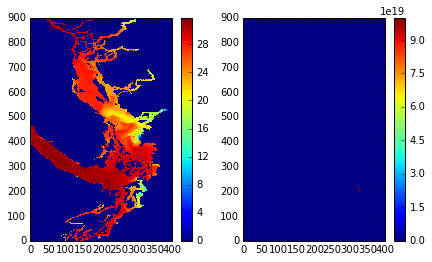

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
mesh = axs[0].pcolormesh(threemonthsbase_sal[0]*tmask[0, 1])
fig.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(threemonthv1803_sal[0]*tmask[0, 1])
fig.colorbar(mesh, ax=axs[1])

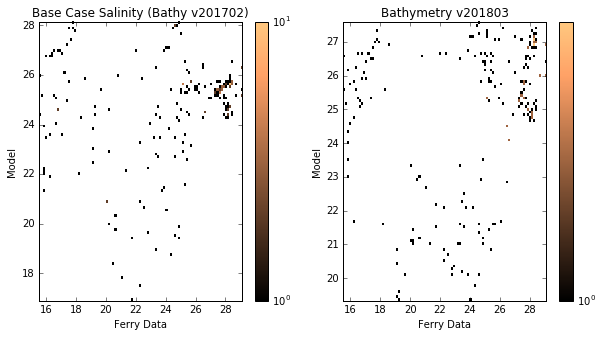

In [178]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
c, xedge, yedge, im = axs[0].hist2d(list_of_ferrybase_sals, 
                                list_of_modelbase_sals, bins = 100, norm=LogNorm(), cmap='copper')
im
fig.colorbar(im, ax=axs[0])
axs[0].set_xlabel('Ferry Data')
axs[0].set_ylabel('Model')
axs[0].set_title('Base Case Salinity (Bathy v201702)')

c, xedge, yedge, im = axs[1].hist2d(list_of_ferrybase_sals, 
                                list_of_modelv18_sals, bins = 100, norm=LogNorm(), cmap='copper')
im
fig.colorbar(im, ax=axs[1])
axs[1].set_xlabel('Ferry Data')
axs[1].set_ylabel('Model')
axs[1].set_title('Bathymetry v201803');

In [179]:
print('bias =  ' + str(-np.mean(list_of_ferrybase_sals) + np.mean(list_of_modelbase_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2) 
                              / len(list_of_modelbase_sals))))
xbar = np.mean(list_of_ferrybase_sals)
print('Willmott = ' + str(1-(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2)  / 
                             np.sum((np.abs(list_of_modelbase_sals - xbar) 
                                     + np.abs(list_of_ferrybase_sals - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_ferrybase_sals) + np.mean(list_of_modelv18_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelv18_sals - list_of_ferrybase_sals)**2) 
                              / len(list_of_modelv18_sals))))

print('Willmott = ' + str(1-(np.sum((list_of_modelv18_sals - list_of_ferrybase_sals)**2)  / 
                             np.sum((np.abs(list_of_modelv18_sals - xbar) 
                                     + np.abs(list_of_ferrybase_sals - xbar))**2))))

bias =  0.400130617412
RMSE = 4.2715693582
Willmott = 0.434873663005
bias =  0.654166090137
RMSE = 4.17277972462
Willmott = 0.511808702455


|  Salinity         | Bias          | RMSE          | WS             |
|-----------|---------------|---------------|----------------|
| Base Case | 1.52707575253 | 5.24464144716 | 0.777509231541 |
| Test A    | 1.94161838071 | 5.56267806197 | 0.743195687801 |
| Test B    | 1.79176312479 | 5.34840517666 | 0.767047886945 |